In [2]:
import numpy as np

def w(i, k, t, x):
    ii=i-1 # re-index to account for python array indexing
    
    if not t[ii]==t[ii+k-1]:
        return (x-t[ii]) / (t[ii+k-1]-t[ii])
    else:
        return 0.0
    
def bspline(i, k, t, x):
    '''
    B_{i,k} (x) on extended knot sequence t (t1, ...., tq)
    where k is the order of the spline
    i is the index of the basis (1...q + p -1)
    where q is len(original_knot sequence)
    p = k-1 (degree of spline)
    
    in order to cope with python indexing will internally shift all indices by 1
    '''
    ii = i-1 # re-index to account for python array indexing
    
    if k==1:
        # piecewise constant
        if t[ii]<=x and x<t[ii+1]:
            return 1.
        else:
            return 0.
        
    else:
        c1 = w(i, k, t, x)
        c2 = 1.-w(i+1, k, t, x)
        return c1 * bspline(i, k-1, t, x) + c2 * bspline(i+1, k-1, t, x) 

In [3]:
p = 3 # spline degree
k = p+1 # spline order

t_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
q = len(t_orig)

# extend knots
t0 = np.ones(p) * t_orig[0]
t1 = np.ones(p) * t_orig[-1]
t = np.concatenate((t0, t_orig, t1), axis=None)

# coefficients
N = q+p-1
c = np.ones(N) + np.random.normal(0.0, 0.3, N)

In [4]:
# plot basis
from matplotlib import pyplot as plt

yvals_arr = []
for idx in range(N):
    idx_curr = idx+1 # re-index to account B-spline indexing
    xvals = np.linspace(t[0],t[-1],1000)
    yvals = np.asarray([bspline(idx_curr, k, t, tx) for tx in xvals])
    yvals_arr.append(yvals)
    plt.plot(xvals, yvals, 'k--')
    
# now plot a superposition
yvals = 0
for obj in zip(c, yvals_arr):
    tc, ty = obj
    yvals+=tc * ty
    
print "coefficients:",c
plt.plot(xvals, yvals, 'r-')

coefficients: [0.61307724 1.05175444 0.97650047 0.40268474 1.67018471 0.80915929
 0.83331999]


coefficients [-7.40096878  6.60751404 -7.8123763   8.16091583]
knots [-2.  2.]


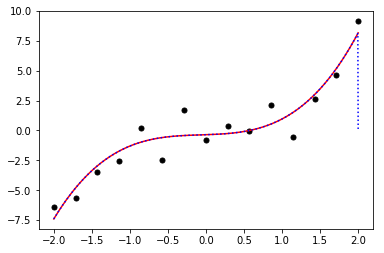

In [5]:
# now check consistency with scipy interpolate
# generate fake data - with noise
np.random.seed(1)

xmin = -2.
xmax = 2.
xobs = np.linspace(xmin, xmax, 15)
stderr = 1.0
yobs = xobs**3+np.random.normal(0.0, stderr, len(xobs))

# now interpolate with scipy
from scipy.interpolate import UnivariateSpline
func = UnivariateSpline(xobs, yobs, s=30, k=p) # scipy denotes degree of spline with k (meh!)
new_x = np.linspace(xmin, xmax, 1000)
new_y = func(new_x)
plt.figure()
plt.plot(xobs, yobs, ".", markersize=10, color='black')
plt.plot(new_x,new_y, "r-")

# now run my own code
print "coefficients", func.get_coeffs()
print "knots", func.get_knots()

t_orig = func.get_knots()
q = len(t_orig)

t0 = np.ones(p) * t_orig[0]
t1 = np.ones(p) * t_orig[-1]
t = np.concatenate((t0, t_orig, t1), axis=None)

# coefficients
N = q+p-1
c = func.get_coeffs()

yvals_arr = []
for idx in range(N):
    idx_curr = idx+1 # re-index to account B-spline indexing
    xvals = np.linspace(t[0],t[-1],1000)
    yvals = np.asarray([bspline(idx_curr, k, t, tx) for tx in new_x])
    yvals_arr.append(yvals)
    
# now plot a superposition
yvals = 0
for obj in zip(c, yvals_arr):
    tc, ty = obj
    yvals+=tc * ty
    
plt.plot(xvals, yvals, 'b', linestyle='dotted')

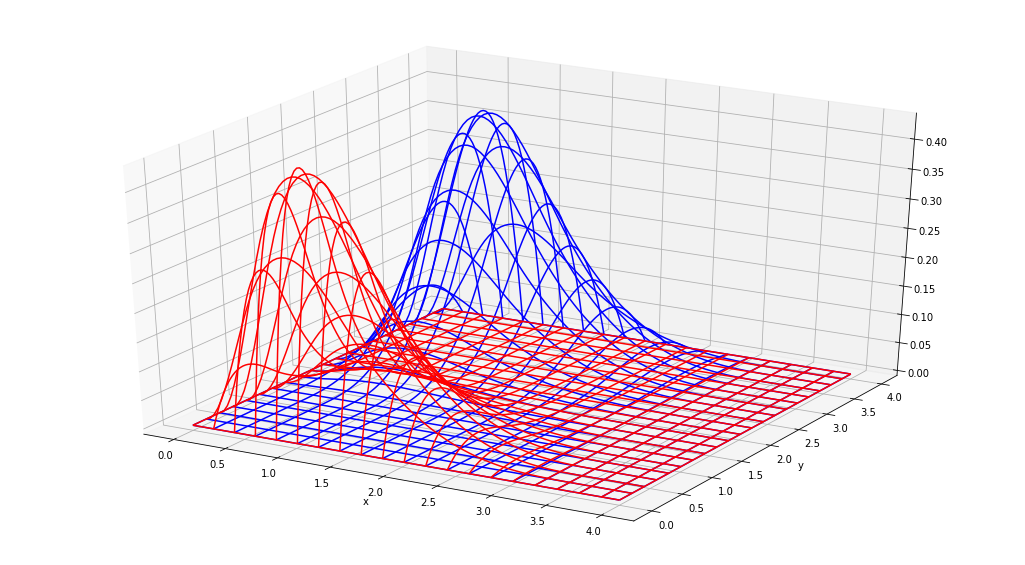

In [6]:
# lets see if we can repeat this in 2D 
from mpl_toolkits.mplot3d import Axes3D

# lets first build a tensor product spline

# we start one dimensional as before
p = 3 # spline degree
k = p+1 # spline order

tx_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
ty_orig = np.array([0.0, 1.0, 2.5, 4.0])
qx = len(tx_orig)
qy = len(ty_orig)

# extend knots
tx0 = np.ones(p) * tx_orig[0]
tx1 = np.ones(p) * tx_orig[-1]
tx = np.concatenate((tx0, tx_orig, tx1), axis=None)

ty0 = np.ones(p) * ty_orig[0]
ty1 = np.ones(p) * ty_orig[-1]
ty = np.concatenate((ty0, ty_orig, ty1), axis=None)
# coefficients
Nx = qx+p-1
Ny = qy+p-1

# now plot one basis element
idx_x = 3
idx_y = 2

xaxis = np.linspace(tx[0], tx[-1], 100)
yaxis = np.linspace(ty[0], ty[-1], 100)
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T
z = []
for ti in range(len(xx)):
    z_temp =[]
    for tj in range(len(xx[0])):
        currx = xx[ti][tj]
        curry = yy[ti][tj]
        z_temp.append(bspline(idx_x, k, tx, currx) * bspline(idx_y, k, ty, curry))
    z.append(z_temp)

z = np.asarray(z)
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='red')


# and another basis element
idx_x = 3
idx_y = 5

xaxis = np.linspace(tx[0], tx[-1], 100)
yaxis = np.linspace(ty[0], ty[-1], 100)
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T
z = []
for ti in range(len(xx)):
    z_temp =[]
    for tj in range(len(xx[0])):
        currx = xx[ti][tj]
        curry = yy[ti][tj]
        z_temp.append(bspline(idx_x, k, tx, currx) * bspline(idx_y, k, ty, curry))
    z.append(z_temp)

z = np.asarray(z)
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')

  
# values taken from scipy.RectBivariateSpline fit to Aeff for NuE_CC events

coeffs = np.array([-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
 -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
 -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
  0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
  1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])

tx = np.array([2.90998783, 2.90998783, 2.90998783, 2.90998783, 4.03010253,
       5.00991847, 6.96995941, 6.96995941, 6.96995941, 6.96995941])

ty = np.array([-0.9, -0.9, -0.9, -0.9,  0.1,  0.9,  0.9,  0.9,  0.9])

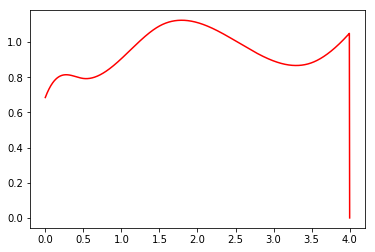

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from bspline_ev import bspline_basis, bspline_func_1d
p = 3 # spline degree
t_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0]) # knot sequence
N = len(t_orig)+p-1 # number of coefficients that need to be defined
c = np.ones(N) + np.random.normal(0.0, 0.3, N) # random coefficients

func = bspline_func_1d(t_orig, p, c)
x = np.linspace(0.0, 4.0, 1000)
y = np.asarray([func.eval(tx) for tx in x])
plt.plot(x,y,"r-")

Text(0.5,0,'y')

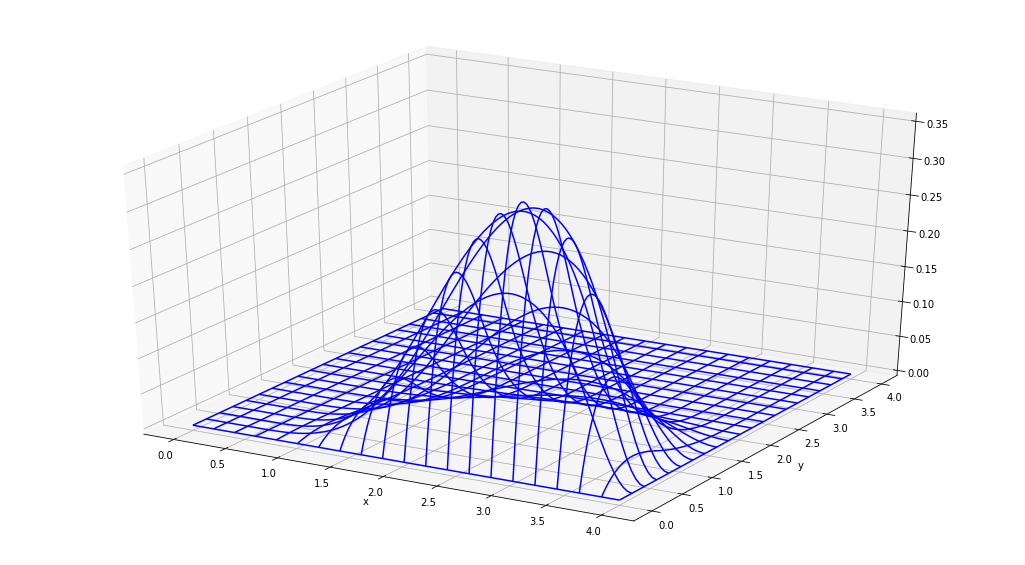

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bspline_ev import bspline_func_2d

p = 3 # spline degree
tx_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0]) # knot sequence
ty_orig = np.array([0.0, 1.0, 2.5, 4.0]) # knot sequence
Nx = len(tx_orig)+p-1 # number of coefficients that need to be defined
Ny = len(ty_orig)+p-1 # number of coefficients that need to be defined
N = Nx * Ny

c = np.zeros(N) 
c[25]=1 # all coefficients zero except for one
#c = np.ones(N) + np.random.normal(0.0, 0.3, N) # random coefficient
c = c.reshape(Nx, Ny)
func = bspline_func_2d(tx_orig, ty_orig, p, c)


#print func.eval(2.0, 2.0)


xaxis = np.linspace(tx_orig[0], tx_orig[-1], 100)
yaxis = np.linspace(ty_orig[0], ty_orig[-1], 100)

z = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
z = z.reshape(len(xaxis), len(yaxis))

xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')


Text(0.5,0,'y')

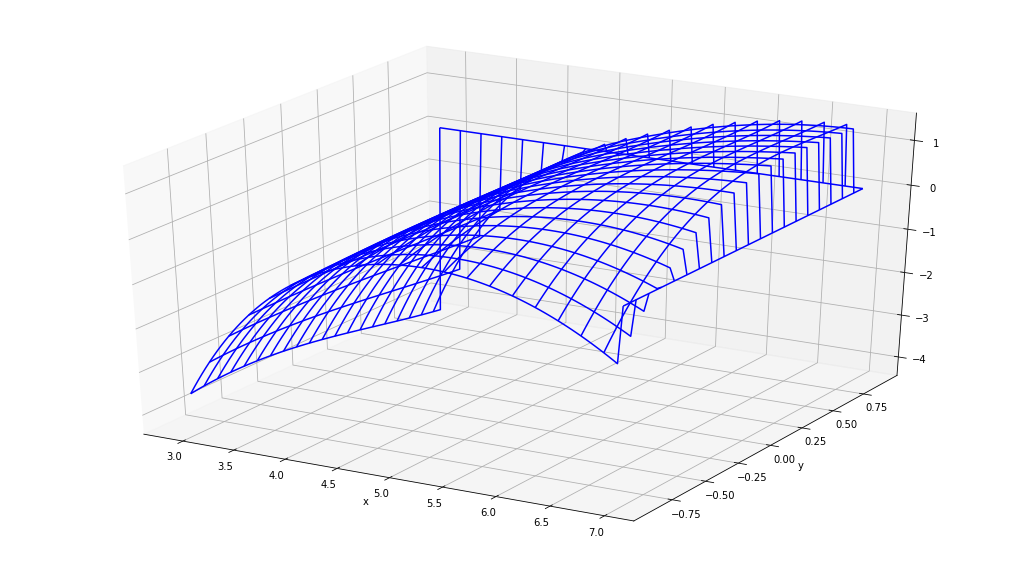

In [14]:
import numpy as np
from matplotlib import pyplot as pltdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABAEAAAI1CAYAAACnuOOZAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3VuII+eZP/6vzurzYXqmp6elHs9M9xzt8diesceBvQk/COsFsxBYjK+WkIsELwRylSVsYENg7wJZbDCBZcmNyd2SLIGwCVkIy2btrOPNwU7i8dierlJLre7WobtVpUOp6n8x/yqX1CW1DiVV1avvBxofeqZV1VJJ9T7vcwgZhgEiIiIiIiIiEl/Y6wMgIiIiIiIiovFgEICIiIiIiIhoQjAIQERERERERDQhGAQgIiIiIiIimhAMAhARERERERFNCAYBiIiIiIiIiCYEgwBEREREREREE4JBACIiIiIiIqIJwSAAERERERER0YRgEICIiIiIiIhoQkT7/PPGSI6CiIiIiIiIiIYR6uUPMROAiIiIiIiIaEIwCEBEREREREQ0IRgEICIiIiIiIpoQDAIQERERERERTQgGAYiIiIiIiIgmBIMARERERERERBOCQQAiIiIiIiKiCcEgABEREREREdGEYBCAiIiIiIiIaEIwCEBEREREREQ0IRgEICIiIiIiIpoQDAIQERERERERTQgGAYiIiIiIiIgmBIMARERERERERBOCQQAiIiIiIiKiCcEgABEREREREdGEYBCAiIiIiIiIaEIwCEBEREREREQ0IRgEICIiIiIiIpoQDAIQERERERERTQgGAYiIiIiIiIgmBIMARERERERERBOCQQAiIiIiIiKiCcEgABEREREREdGEYBCAiIiIiIiIaEIwCEBEREREREQ0IRgEICIiIiIiIpoQDAIQERERERERTQgGAYiIiIiIiIgmBIMARERERERERBOCQQAiIiIiIiKiCcEgABEREREREdGEYBCAiIiIiIiIaEJEvT4AIiKiTgzDgK7rCIVC1hcRERERDY5BACIi8h3DMKBpGprNJur1OnRdBwCEw2GEw2FEIhFEIhGEQiHr/zFAQERERHS6kGEY/fz5vv4wERFRr8xdf03TrEV/KBRCo9GA/bPKMAw4fXaZAYFIJNLyT2YREBER0YTo6WaHmQBEROQp+66/ubh3WrSb/+20mDf/nq7r1s9p/3P2DAIze8AeJCAiIiKaBMwEICKiseu06++0GK/X646L+n4fz/y8a88qsJcUsMyAiIiIAoyZAERE5C/mTr19t34cO/HdHsMMCjSbTWiaZv3/hw8f4sqVKywzICIiIqEwCEBERCPVadc/HPbHlNpOZQblctk6RpYZEBERkSgYBCAiopFwa9c/FAo5NgIch259CIDPygw0TUOj0TjxfZYZEBERkd8wCEBERK4xDMNa+P/xj3/EtWvXht71VxQFAJBMJn23cB6kzMD+d1lmQEREROPGIAAREQ3F3A23L3ZDoRCKxeLAi1lN05DL5SDLMiKRCACgVqsBABKJBKanpzE1NWV9JZNJ35QXmDjNgIiIiPyIQQAiIhqIfdffqcN/OByGruvWIr4X5XIZsiyjVCrh/PnzuHPnDiKRCHRdt8oCarUaVFWFqqoolUrIZrNQVRWGYSAWi7UEB8yvaNRfH3csMyAiIiKv+OuuiIiIfK3Trr/T7nSvtfyapiGbzUKWZSSTSaTTady8edP6efZFcCgUQjKZRDKZxNLS0olj0zQNqqpCURRUKhXs7+9DVVU0m02Ew+ETwYHp6WnEYjHfLZxZZkBERESjwiAAERGdyr7wNxehpy0ozUyATj/v8PAQkiShXC5jbW0Nzz77LBKJxMDHGAqFEIvFEIvFMD8/f+L7zWbTyiBQVRWHh4dQVRX1et0KLtgDBLquQ9d1IcoMDg8PUa/XsbKywjIDIiKiCccgABERObKnpDebTQCdd/2dOAUBGo0GstksMpkMpqamkE6ncevWra4/z62FaSQSwezsLGZnZ098T9f1ljKDQqGAWq2Gd999F4ZhIB6PO5YZ9FPqMA6dAgSNRgOKoiAcDrPMgIiIaMIxCEBERC0G2fV3YpYDGIaBUqkEWZZxdHSEtbU1PPfcc4jH46M4/IHYSwVMxWIR9+7dg2EYqNfrVoDg6OgI+XweqqpaPQ/aSwzMPgR+WTjbgwMsMyAiIppsDAIQEREMw7BSyO27/sOmwkuShP39fczOziKVSmFpaSlwi8VQKIREIoFEIoHFxcUT3zf7ENibFaqqikajgVAo5JhBkEgkfPd7GHaaQXtwgGUGRERE/sQgABHRBLOn+w+z62//ecViEbIso1gsYnZ2Fnfv3h16199p0ekX0WgUc3NzmJubO/E9XddRrVatZoV7e3tQVbVl3KFTkCBIfQiAz4JIuq6zzICIiMjnGAQgIpow5oJN07SW0X7DLDzr9ToymQyy2Szm5uaQTqcBAOfPn/dV2v+4hcNhTE9PY3p6GmfOnGn5Xvu4w3K5jFwuh2q1Cl3XEY1GT5QYDDPusJdJDYNimQEREVFwMAhARDQh7On+bu36FwoFSJIEVVWxvr6Oe/fuIRaLAQB2dnY6TgcIilFmIHQbdwg8buZnBggURcHBwQFUVYWmaY7jDqemphCPxx2P18uFNMsMiIiI/IVBACIigY1i179Wq1m7/gsLC7h06RLm5+dPLMjMxoBBZR6/VwvNYcYdtpcZ1Go1Xz4Xg5YZ1Ot1lMtlrK6ussyAiIioTwwCEBEJyNxZ3dnZwblz54ZOrTYMA/v7+5BlGbVaDevr63jhhRe6pqY7jQgcBBdzJ3Ubd2gYhtWHQFVVFItFlEolVKtVHBwcIBaLtZQX+HXcIdA5U6XZbKJQKGB1dZVlBkRERH1iEICISBBOu/4PHz7E+fPnB/6Z1WoVmUwGuVwOi4uLuHLliuPOtJNQKBTocoCgZjLYJxKY9vf3cXh4iEuXLlllBoqiWOMOq9Uqms3miXGH5lcsFvPVotnM0Oi0mGeZARERUWcMAhARBZhhGDAMo6XW3744GmQxYxgG9vb2IMsyGo1GT7v+TsLhcCAX0aagBgE6MV8b8Xgc8XgcCwsLJ/7MaeMOk8nkiQBBMpn03aK51zKDZrPJaQZERDRxGAQgIgog+8LfrVp/VVUhyzLy+TyWlpawtbXlOPauV26VA3hFpCBArwvXXscdqqpqNSo0+w04jTtMJpMjKTMYtlcDpxkQEdEkYxCAiCgg7Lv+5uJk2IWHruvWrr+maUilUrh//74rC7egL6KDfvxus487bGcYBur1OhRFOXXcYXuZgd9wmgEREYmOQQAiIp/rtOs/zIJCURRr1//MmTO4du2aY5O5YTATYHKYEwkSicSp4w5VVUWhUGgZd2iWGdgbFnYadwiMdnRjNywzICIiETAIQETkQ6Pa9c/n85BlGbquI5VK4cqVKyPrCu9WTwCvFkdclLnntHGH9jKDfD5vlRk4jTucmprybXBmmDKD4+NjJJNJTE9Ps8yAiIhGikEAIiIfsS/8zUXDMAuAUCiE4+NjZDIZ7O3t4ezZs7hx4wZmZmbcPOyOjx30TIAgH387vy6cI5EIZmZmHF+TTuMOd3Z2UKlU0Gg0oCiKY5lBv00sx+G0MoN8Po/l5WVEo1GWGRAR0Uj571OSiGjCmLv+mqah2WwCcGfXf3d3F5VKBR988AE2NjawtbU1VOPAfoXDYceUaBq/oC4SncYdAkCpVMLu7i4uXbpkBQgqlQr29/ehqmqgxh0Cnz0/5iK/HcsMiIjITQwCEBF5xL7wd2PXH3icUizLMvb393Hu3DnMzs7izp07iMfjbh12z4JeUx/04xddL+MO7VkE5XIZiqL4dtxhtz4HnGZARERuYhCAiGiM7Dt69l3/YXbom80mdnd3IcsywuEw0uk0rl69inA4jHfffdezlHY2BqRR6aUxYDQaxezsrGPDy9PGHcbj8RONCkc17tA0aLNDTjMgIqJ+MQhARDQGo9j1Pzo6gizLODg4wOrqKp566qkTadNeLsTdagzoFdGCACKdy7B6GXdoBggODw+xu7sLVVVHOu5Q13XXy3U4zYCIiJwwCEBENCLmDbamaS2j/Ybd9c9ms8hkMohGo0in07h27VrHn+llEMDNxnpejYMTZeEs2oJtlCMC7eMOFxcXT3xf0zQrQKAoSsdxh/avRCJx6vF6MfaQZQZERJOJQQAiIpfZ0/0/+OADXLx4ETMzM0PdFB8eHkKWZRSLRayuruLpp59GMpk89e95nQnAcgASTTQaxdzcHObm5k58r33c4d7e3qnjDpPJpJU146eFsxtlBoZhIBwOIx6Ps8yAiMhHGAQgInJBp13/TjfIvdA0zdr1TyQSSKVSuHHjRl8/y+tMgCAvorlQoX6dNu6wVqtZAYJSqYRsNgtVVa3vGYaBubm5QI87BD57P8xms2g2m1hfX2/5fnuZgRkcYJkBEdF4+O+ThYgoQOy7/uZi377TFYlErAaAvSqXy5AkCeVyGefPn8edO3d62vV3wkyAwQU9iCEyv+2a98KcSJBMJrG0tNTyPcMw8Lvf/Q7nzp2Drusnxh2Gw+GWwIDZsNCP4w4BnHgPtDdUZJkBEZH3GAQgIupTP7X+4XC4pyCApmnY2dlBJpPB1NQUUqkUbt26NfQNrwiZAF7e9IsUBBDpXERjLm7n5+cdA37NZtPKIFBVFblcDqqqol6vdxx3mEgkXG802C+zkaIdpxkQEXmPQQAioh4YhgHDMFp2r3rZmYpEIh0X4YZhWLv+R0dHWFtbw7PPPotEIuHacTMTYHAiZQKItjgKYibAabqdUyQS6Tru0F5mUCgUoCjKiXGH7V+jHHdoP7Z+nie3pxmwzICIyBmDAEREXZgL/2az2bLr3+sNpdNCuNFoYGdnBzs7O5ienkYqlcLy8vJIblIZBBicSEEA8r9BAxv2UgGnn2kfd3h0dIR8Pm+NO4xEIo5lBtFo1JX3I7fHHnKaARGROxgEICJqM+iuvxOzJ4BhGCiVSpAkCcfHx7hw4QKee+45xOPxUZyCRYRyAK8E/fgpWEaR3dDPuEOzWaGqqmg0GgiFQo4ZBL2MO7Sf07hKEoYpMzADBCwzIKJJwSAAEdH/b9hdfye6riOfz+PTTz/F7Ows0uk0FhcXx3ZTyUyAwYkUBBDpXIDJKwcYlW7jDnVdR7VahaIoJ8YdAnAcdzg1NdWy6Hc7E2BQLDMgImrFIAARTTQ3d/3tP7NQKECWZZRKJczPz+PevXuIxWJuHnpPvA4CBHnhKdrCmfzNb4GNcDiM6elpTE9Pn/he+7jDcrmMXC6HarVqNQOcmppCpVJBOBxGLBbz7bhDoP8yg4cPHyKdTiMej7eUGdizCFhmQER+5s93YyKiEbMv/M2bvGFv2Gq1GnZ2dpDNZjE3N4eLFy9iZWUF9XrdkwAA8PhG3mlnaxxCoVDgMwHIn/y2YHZDkM6p27hD4HHfE1VV8fDhQ9TrdciyDEVRHMcdml/mgtpvnLIIKpUKotGoleXAMgMiChoGAYhoYpi7/pqmWWP73Nj1Pzg4gCzLUFUV6+vreP75560dL3O3zCteZwIEOQgAcKwejU+QggCnicViiMViSCaTWF9fbyk3aB93eHh42DLu0KnMIJlM+qKswGSWObhRZuDUqJBlBkQ0agwCEJHw7At/N3f9ZVlGLpfDwsICLl26hIWFhRN/zuuFsAiNAXVdR7lcHvtuoUjlAKItKER5XtqJ9jw59QToZ9xhsVjEzs4OqtWq5+MO24+zl6BEL2UG9my09r/LMgMiGhUGAYhISOYOzOHhIZLJJIDPbqqG+Zn7+/uQZRm1Wg3r6+t44YUXuta5hsNhK+vAC0EOAiiKAkmSsLe3h7m5OdTrddRqNSsVuX20WT9dy8dx/H4j0rkA4i2YRaTrel/P02njDs0yA0VRrHGH1WoVzWbzxLhD8ysWi43ktTLsz+Q0AyLyEoMARCSU9l3/9957D5/73OeGuimqVquQZRm7u7tYWlrClStXMD8/39PfjUQiE50J0C9d17G3twdJkmAYBtLpNDY3N6FpmvXz7LuFiqJY5Ri1Wg2GYSCRSFjzzodJJxYtCCASEZ8XUc/JrTT+UCiEeDyOeDzumHV12rjDcQQO3dJvmUF7kIBlBkR0GgYBiCjwzBsiTdNaRvsNsyui6zr29/chSRI0Tetp199JJBKZ2EyAfqiqClmWkc/ncebMGdy4cQMzMzMATi6O7LuFy8vLLd+zdy1XFMUxnbg9QNA+1szEIIC/cTHjf+McEdjLuEMzQOAUOHTqQzDuMoNescyAiIbFIAARBZa5E9Kt1t/sUN/rjai5GN3d3cWZM2dw9epVx5vKXnm9CPf68bsxyyskSUKj0UA6ncb9+/cdb7x7vTHt1rXcMAzU6/WOY81isVhLgMDLqQ6jwICGv4m4+BpnEKCb08Yd1ut1KIrSddyh/cvP19IwZQbHx8eIx+OYmZlhmQGR4BgEIKJA6bbr78RcBHe7EbWnoOu6jlQqhRdffNGVXSCvF+FeP74Te1PFpaUlbG1tDRVo6ZXZeTyRSGBxcbHle/Z6Y1VVcXR0hEKhgHq9jmw2ay0E2rMI/Dr3vJ1oN+8iddIXWb89Abxgf1/oNu7Q/CoUClBVFe+8844Q4w7t9vf3MT8/j3g8zjIDIsEF4+6FiCZe+65/r6mLZjq+02JNURQrBX1lZQXXr1937Fg9DJYDPGYYBgqFAiRJgqqqSKVSA5VXjIpTvfHU1BSazSZSqVTLQqBSqWB/fx+qqp5oSGYPEoiURUA0CDd7AnjFHHdo9oHRdR2VSgV3795Fs9lsKTPI5/NQVdVqYBqEcYd2ZuaDUwCcZQZEYvHH3RcRkQPDMKyFfy+7/k7aF+G6riOfz0OSJABAKpXC5ubmyG7KvF6Ee/34hmHg008/xc7ODubn5zuOUuzl53hxE2ne7LYvBOzsDckURbF2CjVNa9kpbA8Q8KZ4cMwECA7Rnid7ZlkkEsHMzIzVv8TOMIyWAEF7f5JYLHbivSGZTHoaGNU0rePjuznNIBKJDN23h4iGwyAAEfmKYRjW4l/TNAAYaifBDAJUKhXIsoy9vT2cPXsWN2/edLxxc9skZgIYhoFSqQRJklCpVBAKhXDv3r3A7Yz32hiwW0OyZrPZkkpcLpehKIrVsdwpQDCqVGI/1zETBYWZ/XMa+/Xdrr386Pj4GHt7e47ZReMYd2jq9dzacZoBUfAwCEBEvtBp13+YGwAzVfP3v/894vE4UqkUtra2xpqK6fUNzDiDAJqmYWdnB5lMBtPT09jY2MDR0REuXrw49M82F+Tj/H26MR0gEolgdnbWscxE1/WWAEE+n4eiKKjX6y0jzewBgkFHmnn9OiQShRvNDnsZd2jPImgPHraPOzSzCIa9zgcNApyG0wyI/IdBACLyjNu7/qbj42NIkoSDgwNEIhE88cQTuHDhgluHHSjjCAIcHh5CkiSUSiVcuHABzz33HOLxOAB3Fu9e3eSNekRgOBzumErcPtJsf38fiqKgVqsBQMsiwJ5KPCk3xCwHIK+MY+JBNBrtGjxsH3do9iEYdtzhqIIA3bDMgMgbDAIQ0djZF/6dRvv1q9lsIpfLQZZlRKNRpFIpXLt2DQ8fPvRN8zkvjCoI0Gw2kc1mIcsyEokE0uk0bt68eeI5NB/fr/O2uxl1EKCb00aa2RcBZg8Cs9bYvggwAwR+aA5JnbFUIzi8WCjb9TLu0HxvODw8xO7uLlRV7Tju0N7E1Otza8cyA6LRmdw7YyIaq1Ht+h8dHUGSJBQKBayuruL27dstNZhe1+R7ze0bHTPLwvx937lzB8lksuvjB3WB49djP63W2D7zvFQqIZvNolKpoFar4f/+7/8cMwj8dOPfCxG6zlMwjSMTYFDdxqACpzcxVVUVH3/8cct7hF/HHQL9lRn84Q9/wI0bN6z3uk5lBuZz69dzJnILgwBENFKj2PXXNA25XA6ZTAaxWAypVAo3btxw/JmTHgRwg67r2N3dhSRJiEQiSKfTuHbtWk83wl5PJxiGX4MA3XSaeX58fIxPP/0UV69etRYA7buETt3Kp6amAhcgCCKWNwSH33bL+3FaE9Nf//rXWFhYgKqqVqNCpxKkIIw7bM8iqNfrVmNFlhkQMQhARCNg7vqXSiXE43HrA3TYD0977fn58+fx9NNPd92FBvwTBAjiTb6iKJAkCXt7ezh37hyefPJJxxTUboIeBBCFee11a0ZmditXFMWxW7k9MGD++ySX2rhJ13WhXm+AuCUOfs4EGIa52F1ZWTnxPcMwUKvVrCwCM8OoWq2eCCDav/z0/mD/DHarzKC9USHLDChI/HN1ElHgGYYBTdOsyPpHH32Ey5cvO+469ErTNGSzWWQyGSQSCaRSKcfa804ikQgajcbAj++GINXF67qOvb09SJIEwzCQTqeHmqgQxN10uyAfe79isRhisRjm5+dPfM9MIzbLDOxpxO3jzMwAwShHQgYxqNaNiOUNoi6Wg5wJ0E239zpzIkEymWzJMDL/nn3cYaVSwf7+fksA0amR6ajHHQ6j1zIDp3sLlhlQUDAIQERDsUfMzR1380MwGo0OtAtvGIa1618ul7G2toZnnnkGiUSi758ViUSsHgReMbMR/HzjWK1WIUkS8vk8zpw5g+vXrzt2pu6XW5kAXgQTgh7AcNNpacT2OuNSqQRVVdFoNBAOhzsGCHgz/BnRghqAuEEAkc9r0PGj3TKM7O8Pqqoil8tBVdUTo1DtX4lEwtXfsZvv45xmQKJgEICIBtK+6w+cjJ73m4rfaDSsXf+pqSmk02ncunVrqA9GP6Sj++EYnBiGgf39fUiShEajgVQqhfv377sarAiHw4FdSIsWBBjVuUQikY7jzJrNpjXJQFGUEwuA9pv/XhuRibZoFu18ADGzGwBxgwCjClR3e3/Qdb2lzKB93GE8HncsM+j3OMeViccyAwoSBgGIqGfmB5imadai1vyActJLEMDsHSDLMo6OjrC2ttYyZ35YfugJ4IcggP1mo1arIZPJIJvNYmlpCVtbW0OVbHQTCoU8P/dBiRQE8OoGMhKJYGZmBjMzMye+Z593rihKSyMys8GhvQ+B2YhMxJthEYMAIvY5AB4vlkdZ6uKVZrM59hp+e6ZQu/Zxh0dHR8jn81Yj037KkDRN80V/ApYZkJ94f0UQke/Z0/376fAfjUY7puLX63Xs7OxgZ2cHMzMzSKfTWFpacv2DzA9BAK+PwVyIl8tlbG9vQ1VVpFIpvPDCCyO/MWImAHVin3d+5syZlu+dtkOo6zqSySQ0TQtEp/LTiBoECOrz0Y2o5+W3krV+xh2azQrtZUj2MgPzfsXP19kwZQaVSgWxWAwzMzMsM6CeMQhARI763fV30r74NQwDxWIRsizj+PgYFy5cwN27d13b9e/lGLzgZSZAo9FAvV7H//zP/2B+fh5PPPEEFhYWxnZTwEwAGsRpO4Qff/yx9X5ULBaxs7ODarVqpRC3ZxBMTU35euHm58XJoLhYDpagnVe3PiW6rrcECMrlMo6OjvC///u/MAwDiUTCsczAr6/X0wIE+/v7mJ2dRTweZ5kB9YxBACJq0b7rP8xov2g0inq9jnq9bqWfz87OIp1OY3FxcSwfPn4IAoz7GAzDQLlchiRJODo6QigUwp07dxxTskfND6UQg2IQwJ9CoZCVCry6utryvfYU4nK5jFwu1zLKzClA4PXiR8QggIjnBDC4EQThcLilDGl6ehrJZBKbm5snxh22v0dEo9GW8gI/jju0C4VC0DTNGsfcrpcyAzM4wDKDyeLPVzQRjZVhGNbCf9Bdf6efaTYCy2azuHDhAu7duzf2Wko/BAHGtRDWNA07OzvIZDKYnp62Six+85vfeHZzF+SFtGg3P0F9Hjpxen66pRC3jzJrrzE2b/7bFwDjuPkXccHMxXKwiHpeQGu/g27jDgG0vEcoitIy7rB92on51Usz01FqNBod7616KTNoNpvQNI3TDCYMgwBEE8owDGvxb9btD7Prb7I3nUskEpifn8dTTz3laWMyr4MAoz4Gc5xiqVTC2toann322ZZxil7+DtwcEegFURbOvFk7fZRZt5t/exMye4DAraAmgwDBIep5iRwE6KcxYCwWQywWw/z8/InvtY87PDw8bJl24lRmMI5eJYM2PuynD8FpZQb/+Z//ib/8y78c8AzICwwCEE2YTrv+w9yAGoaBg4MDSJKEarVqNZ07Pj7Gzs6Opze3fmhMN4pMgGaziVwuB1mWEY/HkU6ncfPmTcfftZcp+SwHoFEYxaK5281/exOyQqEAVVWhaVrL7mB7gKDXY2QQIDhEPS/RgwBuBOz6GXfo1KvEjXGHThqNhusZS72MOwQe/27r9Tr+/u//nkGAgGEQgGgCjGrXv1qtIpPJIJfLYXFxEZcvX27ZYYtEIh2nA0wSN3fij4+PIUkSCoUCVldX8fTTTyOZTHb9O14uxN1cSI97ocQgAJm6NSFr3x0sl8tQFAWNRgOhUMhxjFl7+rCIQQARzwkQd7HcbDZH2qTXS+YUkVE6rZmpmWmkKIpVilStVk9kGtm/eg0kmiMTx8keJKhUKp70HKLhMAhAJDD7wr+f0X6n/cz9/X1IkoR6vd511JwfUvH9YNhFuK7r2N3dhSzLCIVC2NjYwLVr13rejWImwGBECwKIdi5+WWCetjtoDxDk83koimKlD5tjzMyGhtVqFYlEwjfnNgxRd8xFPa9xLJS9Yu8J4IXTSpG6jTs03yfaGxX66X3i4OAAy8vLXh8G9YlBACLBmKP9VFW1IsNu7Pqrqmrt+i8vL2Nra8txV8wuGo0yEwCPFwm1Wq3vv6coCmRZRj6fx7lz53Dr1i1MT0/3/XO8HNMX5IV0kI+9nV9uFidNe5dyOzN9WFEUHBwcoFqt4sMPP0S1WgWAljnn5gIgkUgEZgEq6mLZbBAnGlEzHIDBa+bH5bRxh9Vq1QoQmL1KarWaVWZQq9UgSZJn4w4LhQLOnDkztscjd/j3iiCivth3/XVdxzvvvIPPfe5zQ93867pu7fprmoZUKoUXX3yx5xsFP2UCeLlz2M9uuPk7395TNt57AAAgAElEQVTehmEYSKVS2NzcHOoDPRKJMBNgACIFAch/2tOHI5EIrly5AgDWGDNFUVp6EJj1xfYGZGaAYBwNyPohahAAgJDn5fVu+Sj5PQjQTTgcxvT0tOMGgDmF6Q9/+AMikUjHcYdOZQZuKhQKzAQIoGBeEUQE4LNaf03TrMW2OfN1mJ1/RVGQyWSwu7uLM2fO4Nq1a46prqfxywLQXMx5OaHgtN9DtVqFLMvY3d3F8vIyrl+/PtDv3InX5QBOs4n75cVzxyCAf/mpHMANTqO5zDFmTn+2Xq9bAYJSqYRsNgtVVWEYBmKxWEvqsDkjfdy7vLquC/UciY6ZAMFj3u9NTU3hwoULJ75vn3jSraHpsOMOmQkQTOJdEUQTwL7wd6vWX9d15PN5yLIMXdf73vV34pcbQDMjwavdm3A47JgRYZ+qYPZXuH//vus3YqI0Bhw3v7x+SXz9BDXMUWSJROLEnPNODchUVbV2BtsDBG51KHc6J1EXlSISPQgg6rl1mwxw2rhDe5mB+T5Rq9X6HnfIIEAwMQhAFBBmrb+Z7g88vhkcdmGrKAokScLe3h5WVlZc3YH2CzMI4HYKXK/aF+H1eh2yLCObzWJxcRFXrlxx/JAe1eOPk1+yQQYV1ABGuyAHY5yIngkwqNMakNkDBJVKxaovNheATgGCQXdQRS4HEJHIQQDDMIR9LQ46/jASiXTsV2IYRkuAoH3c4b/9278hm83i0qVLuHLlCj799FPcv3+/r8f/6U9/iq997WtoNpv48pe/jG984xst33/zzTfxxhtvWI1Xv//97+PmzZv49NNPcePGDVy7dg0AcP/+fbz55pt9nz8xCEDke4Pu+puLL6cPPnu3eQBIpVLY2toS9kPS694E5qjEQqEASZKgKArW19c7TlVwm9dBgKAuPkVbOJN/jSuo0W1n0N6hXFGUltTh9hFmZoCg2+KDQYBgETkIIFLAsF23TIBB2UebtjMMAxsbG/jggw/w4MED/P73v8c777yDX/7yl/jud7+L2dlZXL58GVeuXGn5WllZsZ6HZrOJ1157DT/72c+QSqVw7949vPzyy7h586b1OK+++iq+8pWvAAB+/OMf4+tf/zp++tOfAgCuXLmC//u//3P1nCcRgwBEPuTGrr/Zmd8+9/f4+BiyLGN/fx9nz54duNt8v7zetfMyCNBoNJDL5bC3t4dQKISLFy9iYWFhrL+PTuUI4+DlZIJhMQhA4+L1eyTQvUN5s9lsCRDYR5iFw+ETI8ymp6fRbDY9Pye3ifx+IHLQRuTnbdBMgEGFQiGcP38e58+fx+c//3kAwJe+9CX8wz/8A27fvo3j42N8/PHHePjwIR4+fIj/+q//wsOHD/G3f/u3ePXVVwEA77zzDjY3N3H58mUAwCuvvIIf/ehHLUEAe6CyUqkI917iBwwCEPmIrutoNpvWrv8wo/3MIEAkErF2/cPhMFKpFK5evTq2D3tzAe5lU55xBwEMw8Dh4SG2t7dxdHSEs2fPYmFhAU899dTYjsHOreZ8gz42gwDkNj8smt3k9/MxU3KdSsXaa4t3d3ehqiqOjo6wt7eHbDZ7IkAwSPMxPxB5oSwq0RtUNhoNJBIJT4+hWCxiZWUFADA7O4vbt2/j9u3bHf98JpNBOp22/juVSuHtt98+8efeeOMNfPe730W9XscvfvEL6/9/8skneOaZZzA/P4/vfOc7+Iu/+AsXz2ZyMAhA5LFR1frruo4HDx7g6OgIq6urePLJJ8ey69/ODEZMQhBA0zRks1nIsoypqSlsbGxgaWkJ9Xodv//970f++J2wMeBgRLpxFOlcROT3IEA3nWqLP/zwQ5w9exaJRMIKEOzt7Z1oPmYPEJjNx/z6uxA5ZV5UXm9CjJqmaZ73cSoWiyNpDPjaa6/htddew1tvvYXvfOc7+MEPfoC1tTVsb2/jzJkzePfdd/HXf/3XeP/990faV0lU4l4VRD5mjvZza9ff1Gw2kcvlIMsyqtUqUqkUnnrqKU93LryuxzePYZSL4KOjI0iShGKxiLW1NTz77LMtkXmvfwde9wQY9rEPDw/x6NEjKIpizUu2jz7jzlxvghqMcRLkRbMT0c4HeByINpsNdppxbs8gODg4sAIEhmF0DBB4eb0zEyB4vN6EGLVGo+FZ02NTe+npadbX1yFJkvXfsixjfX29459/5ZVX8NWvfhUArMkoAPDcc8/hypUr+PDDD3H37t0Bj35yiXtVEPmQfeHv5q7/4eEhZFlGoVDA+fPn8fTTT0OSJMzNzXl+w+L1Atg8Bk3TXP2Z9oBLLBZDOp3GjRs3HG/kvU6JD2ImgK7ryOVykCQJ8XgcqVQK8XgctVoNqqqiXC4jl8tZs9Hj8XhLcMAPCwaiXonYvfy0NOzTmo+Z17pTd/J4PN5yrZtfo/4dipoJIHLKvOhBAK/Pz96wulf37t3DgwcP8Mknn2B9fR0//OEP8dZbb7X8mQcPHmBrawsA8JOf/MT69729PSwvLyMSieDjjz/GgwcPrN4C1B9xrwoin7Dv+psLUTd2/TVNsxah8Xj8xCLUTMP3mh+Ow81FcKVSgSRJ2N/fx+rqKp5++mkkk8lTH9/LXdggZQKoqgpJkpDP57G6uorbt29jamoKuq6jXq9jamoKi4uLLX/HMAzU6/WWpmX2BYM579i+YGCAINhE2zkX7XyA4QIboVAIyWQSyWQSS0tLJ36ueb2rqorDw0PkcjlUq1Xouo5YLOYYIHBj8S5qJoCowQ3A+0XyqI1iOsCoHz8ajeL111/HF77wBTSbTXzpS1/CrVu38K1vfQt3797Fyy+/jNdffx0///nPEYvFsLS0hB/84AcAgF/+8pf41re+hVgshnA4jDfffBPLy8ujODXhiXtVEHms067/sDd65XIZsiyjVCrh/PnzuHPnjuMi1A+Lb8A/mQDDHIOu68jn85AkCaFQCOl0eqzNFYfl9yCAYRjY39+HJEloNBrY2NjA5uZmz79fs7Y4kUh0DBAoiuK4o9iecmyWGIi2IAPEKgcQjYhBgFEtmE+73jVNs6734+Nj5PN5qKoKXdcRjUZPjDmcmprqeRFjljiIRuS6ebNBsqi8DnIUCoUTgbpevPTSS3jppZda/t+3v/1t69+/973vOf69L37xi/jiF7/Y9+PRSWJe8UQeGeWu/87ODjKZDJLJJNLpNG7evNn1Z0YiEdRqtYEf0y1+CQLU6/W+/565K723t4eVlZWxjVR0m1/LARqNBmRZRjabxcLCAra2thzHkw37+OaCwWlH0Uw5VhQFxWIRmUympSa5Wq1CluWWEoMgLtaCeMyTRMQdZi/OKRQKIRaLYWFhAQsLCye+32g0WkYd7u/vQ1VVayfcKUBgr7duNpvCPU8AMwGCzOtSokKhMJKmgDR64l4VRGNkX/j/8Y9/xPXr14de+BuGYe36l8tlx4Zz3USjUVQqlYEf3y1+yEjoJxBhGAb29vYgSRKazSbS6XRfu9J+5LdMgHK5bI1PXF9fx71793pqbOT2Qva0lONarYb33nsPoVDoRNOyZDLZsliYnp5GIpHgYntMRNs5F+18AH/WmcdiMcRiMcdO4pqmWQECVVVRKBSgqio0TUM4HMbU1JQ1zadcLlsBAr+d4yBEDgKInOXgBwcHBwwCBBSvCqIBmbv+mqZZC8xQKIRSqTTUgrHRaGBnZwc7OzuYnp5GKpXCrVu3+r7R8MPiG/BPJsBpx1CtVpHJZJDL5bC8vIxr1655PnbHLV4HAcwgmdnoL5FIYGNjA8vLy769gTYDBNFo9ETXYntXc0VRcHBwYE3kaB97Zv6TAQLqRsQggNc7lP2KRqOYm5tzzEZqNpuoVqvY2dmBoijI5XJQFAWNRqOlwaH9mo/H44F5TkUOAmiaFsgMvl744X1jVOMBafQYBCDqk33hb++Kan8j7veN2TAMlEolSJKE4+NjrK2t4bnnnutr5Eo7vwQBotHoQKn4buoUBDAMAwcHB5AkCbVaDalUCvfv3x/ZzZBXH9heBgGq1SqOj4/xq1/9Cqurqx17WASJ/aa/vSFRe4Bgf38fiqJYc9GdMgjGtVgQqSeAH25+3STa+QBilThEIhHMzMxgdnbWKskz6bqOarVq9SEwexC0X/N+DgqKHgQQNRPAD+fGcoDgEvOqIHKZmQJoNvoDOo/2i0ajPaef1et1a9d/dnYWqVQKS0tLrtwc+CUIMIrxfIMcgz0IUK/XkclksLOzg4WFBVy+fNmxftRNZm38JAQBzEZ/29vbVlOmz33uc8IsCLrpFiDQdR21Ws1aLOzt7Z1YLLQ3KXQrQOCnBQedJGIQQMRzclosh8NhTE9PO+42t1/zZg+CarUKAC0BAntZ0bjfK0UPAoh6bl5PBgAeBwGuXLni6THQYBgEIOqil13/dtFotOsbs2EYKBaLkCQJlUqlr5rofpjBCK/5pRxA0zQUi0Vsb29DURSsr6/jhRdeGNsHqPl78GIhPK4ggD24sri4iKtXr2JmZgZvv/320OctwmLCrCt2motu7iaaGQR7e3tQFAX1ev1EgMBccIhSjzwI0RaYop2PSbRzMicM9KrbNW/2Hek2uaQ9QDCq0aYiBwFE7gmgaZrr9479KhQKeP755z09BhqMmFcF0RDMXX9N01pG+/X6wdtpB95cIGWzWczNzeHixYtYWFgY2U2SXzIBvA5GNBoNZLNZFAoFRKNRbGxsYHFxcew3p17X5Y/ysdsb/dmDK2bvDOrOvpvYnlrZnm68u7sLVVWtAIF9kWAGCiY5QBBEogYBROPmYtnemLSdOdrUDAqWy2XkcjmoqgrDMBCLxRxHmw56bKIvlEU9Nz9kArAnQHCJeVUQDcCe7t/rrr+TWCxmLb4Nw0ChUIAkSVBVdWS7/k68XHTaeVUOUC6XIUkSDg8Psbq6ipmZGdy+fXvsx2HyMiOi25i+Qdkb/Zk1sk6N/txc2EzqQum0dGP7yDN7w7JwOGxlECQSCWiahnq9zgCBD03qaztoxtXnwD7adHFxseV7hmFYow4VRcHR0ZHVh8DMVGgPEExNTXUNEGiaFvheLZ2IHATwSybAysqKp8dAgxHzqiDq0bC7/k6i0ag1c9ycf37p0iXMz89P5E3eOBe/mqYhl8tBlmVrYXrr1i0YhoF8Pj+WY+jEy6CMm687RVEgSRL29vZw/vz5sTb6m8Tr5zThcBgzMzOYmZk58T0zQKAoCiqVCur1Ot5//30rQNC+SDBLDIJAtEWzaOcjKj80OwyFQojH44jH4469bOwBgkqlYvUhMLMY7Ne8+e+ilwN4/ZyNih8yARgECC4GAWgite/6mzv+w9yEmc3Qdnd3oes6Ll26NNaac78aR1nC0dERJElCsVjE+fPn8cwzzyCRSFjfH8VOeL/80BthUPZGf81mExsbG9ja2hL2xkoU9gDB8vIyDg4O8MwzzwD4bOSZWWJQKpWgKErLTPT2MYdBCRAEEYMAwRCExXIsFkMsFsP8/PyJ72ma1pI5VCgUoKoqKpUKDg4OMDs7eyJAEI1GA//aDPrxd+KH8YeKoggzTnnSTPbqhCbKKHb9gccj0GRZxu7uLhYXF7G6uopEItEyQshLXt9cjmrx22w2sbu7C0mSEIvFkE6ncePGDd9+2PulPKMf9kZ/S0tLuHbt2kR+2Ht9DY2COfLMKYOg2Wy2LBTaAwTtiwRzoTBOoj0nop2PqPyQCTCMaDSKubk5zM3Ntfz/Dz74AOvr64hEIta1XyqVoKrqidIi+7XP0iJveZ0JYC+dpeBhEICEZjYlazab1m60W7v+e3t7kGUZjUajpRlaLpdDpVJx6xSGEolEoOu6pzsXbn84VCoVSJKE/f19rK6u4vbt246dl/0mSJkApVIJ29vbOD4+RiqVmuiMFi9HO3olEolgdnbWMeBjBgjsHc1VVbXGcDk1KZzU104/Ju01FlRByAQYRLPZRDwex9TUlON1b+894tScdJTjTYch+nXldU8ABgGCjZ/MJCRz4d9sNlt2/Yd9o1JV1dr1P3PmDLa2tk5E1P3SlR/47FiCftOi6zry+TwkSQIApNNpXL16NVA7Mn7PBGg2m8hms1Y/hY2NDSwtLU38h7sfSknc4sZ5nBYgMIMDZqqxoignapHtiwUGCB4TbbHi5/e6YQQ9E6CT04Ibp/UeMcebqqqKvb09qKqKWq0GAEgmkyf6ECSTybG83kUN2pi8zgQ4Ojo6cQ9MwcFPXxLGqHb9dV23dv01TUMqlcKLL77Y8YPFPh3Aa2Znfnt9fJDYgy5nz57FzZs3HW9CeuXljbaZleE3iqJge3sbBwcHWF1dHWujPxqfcbzuI5GIY6ox8FktsqIoUBTlRLOy9v4D09PTXW/eRVw0i3Q+hmEIu1gW9bwGXSx3m15iGEZLgMAMDNZqNRiGgUQi4RggcOt3LPJkAMD7TICDgwMsLy979vg0HHGvDJoY5jzdZrNp3US5seuvKApkWUY+n8fKykrP9dDRaBSNRmOox3aLn7ISer1pb29Cd1rQpVfmTrxXuwLhcNjzcgDzOTDLWba3t2EYRiAzK8ZFpEwAL3WqRQZaAwTt3cyj0ahjk0LRiLZoFnXH3OvyulEZ1fMVCoWsxX07897N3px0Z2cH1WoVhmFY5Qn2AMHU1FRfxylCJmQ3Xmc6FItFBgECjEEACqT2Xf/t7W1EIhGkUqmhd/3taefr6+u4cuVKX2+yflp4++VYelmA12o1yLKMXC6HpaUlXL161dU0M7Mmf1KDAOFwGNVqFdlsFtlsFktLS7h+/frYGv0FdeeWQYDR6xYgaB93ZqYaVyoVvP/++5idnT2xUAjiTX9Qr49ORA0CiPY82Y37vEKhEBKJBBKJBJaWllq+ZxgGGo2GFSA4PDxELpdDtVqFruuIxWKOAYL2a98MJIrK69fjwcEBzpw549nj03DEvTJISPaFv70hSTweR61WG/jNsFKpQJZl7O3tDZ127peFN/D4WLzefQY6L8ANw0ChUIAkSahWqyNtQud1Y75IJOJJhohhGCiXy1AUBe+9954njf68zsIYBoMA3uo07ux3v/sdLl++DF3XoSgKjo+Pkc/noaqq4yJhenoayWTSt69Br2/m3SZaeYOdqOflJ+Z9XTwex+LiYsv3DMOApmlWgKD92jezh6ampqy+UKKXBXilUCgwCBBgvCLI98xdf03TrEVce61/LBbD8fFxXz9X13VrxFwoFEI6nXZl9rmfar/9EpAwjyMejwP4bPRcNpvF/Pw8Ll26hIWFhZEegx+CAGajpHEwG/1JkmTdEN25c8eTVOogL6SDfOztRDkP4PG5xGIxJBIJx3no9l3Eo6OjEwGC9vKCftOM3SZaEEC08gbyj1AohFgshoWFBcf7BjN7yGxSqCgKfvvb37Y0KLVPMZiamvK0rn5Qfsi2YRAg2BgEIN+yL/ztu/5ON0r9NOM7Pj6GLMvY39/HuXPn8OSTTzo2tBGB2RjQa+ZxFItFSJKESqWC9fV13Lt3b2wfvl4HAcZVDlCpVKxGf2tra3j22WeRSCTw3nvvebYIdGsygheLJFGCACItMHvRaZFgphmbJQZOacZeBAhECwL4YYFCvRHh/c3Onj2kaRoWFxeRSqUAPO4RUK1WW/oQKIoCTdMQDoc7Bgj8eG36IbuhWCxic3PT02OgwTEIQL5iGAZ0XbfG+wGPb15Pu5k4rRlfs9lELpeDLMuIRqNIpVIT0QgtGo1CVVVPj8FM2/vtb3+LhYUFpNNpLC4ujv1D1esRfaN8/PZGfxsbG7h27VrL6zsUCnl2/l7/7ochShCAHrOnGXcKEJgLhHK5jFwuB1VVHRuVmSUGbnyOiBgEEOl8ROZ1c7lRajabVgYi8PieqNuIU3uAIJfLQVEUNBqNlgaH9veAeDzu2eu80Wh4nsFQKBSwsrLi6THQ4BgEIF/oZ9ffSSwWcwwCHB0dQZIkFAoFrK6u4vbt22NJhzYXXF4HGbwsByiXy5AkCYeHh4hGo9jc3MTa2ponxwJ4nwkwise3N1NcXl7u2ugvHA57tph1ayHtxUKJQQB/GsVr4bQ6ZDNAoCgKyuUystlsSyfz9gyCfgIEogUBRCwHEPV9QOQggKZpPWd6RiIRzMzMOPaD0nW9JUBglheZvaiSyeSJIEEikRjpNe2HTACWAwQbgwDkGXPXX9M0a5ewl11/J/YggKZpyOVyyGQyiEajSKfTuH79+lhvSNpr4L0y7iCAWYcuyzISiQQ2NjZw69YtPHz40PMbQq+DAG7thhuGgVKphO3tbSiK0nOjPy9344OcCSAKkRaYXjgtQGAfdVYsFltGnbXPQjczCNqfE5GeIz8Ewd0m4jkB4gcB3Fgoh8NhTE9POwYUdF1HrVazSowODg4gyzJqtRoMw+gYIBj2teSHTIBischMgABjEIDGzp7uP8iuv5NwOAxN0/D++++jVCphdXUVTz/9NJLJpFuH3ZdJCwIcHx9bGRfnz5/HnTt3Wn73Xi/A/XAMwz6+pmlWgGV6ehobGxt9lVV4OaLQzd30ce+YMhPAn/y0c37aqLPTAgTT09Oo1+soFApWBoFfzm1QIi6YRTwngEGAYdl7CSwvL7d8zzCMlgBBpwChPUDQawZRo9HwPBOgVCqdOGcKDgYBaCzc3PW3MxdGmUwGtVoN586dw82bNz2/geqnUeEojXJEoK7rVp+FSCRiZVw4/e79MKXA6yDAoLvhZqM/M8BiNvrrl5dTK9zIBDADheNekDMIQMM4LUBgLhDy+TwKhQIURTmxg2hvUBiUAIGIPQGCOub0NKIHAbw8N7NUIJlMdgwQmgGC9h4k9ial9i/zfDRN8zQTwBzZ7XU2Ag2OQQAaqfZd//bRfoMwDAOHh4eQJAnlchlra2t45pln8O6772JlZcUXNx6nNSocl1FMB1AUBZIkWdMVnnrqqVP7LIx7PF6nY/DyOeknCKHrutXozxxf2d7or19elwMEdSHNIIA/+SkTYFD2BUI8Hm/psm0GCMwMgoODA6sGGYBjicGoa5D7IWJPgGazKdw5AeIHAbzeLe/EHiDs1IPEDBC0jzk1N1ZmZ2dbxh56ca5+ec+h/vnzyqBAG9Wuf6PRsHb9p6amkEqlcOvWLesNyFxk+eEN3w87324eh7kolSQJhmEgnU5ja2ur5+c0Go2iUqkMfRzDiEQiqFarnj1+L4vw9kZ/N2/edGxSNKrHHxUvJxMMi0EA8oI9QNDOMAxUq9WWGmRJkqwmZWaJgRkcmJ6eHnsXcxFT50U8J0DsIIBf7gn71W2KCfD4fvjPf/4zkskkKpUK9vf3oaqq9Vy2ZxBNT0+7/nuo1+vMAgi44F0Z5EuGYVipQeai061d/1KpBFmWcXh4iAsXLuC5555zrLU3mwP64Q3fL0GAYXdgVVWFLMvY3d3FysoKbty4MdCi1OtUfD8cQ6fHb2/0l06ne2r01y+vMwEYBCByh31cmVMNsr2L+d7enmMXc3uQYBQBAhEXzKIulkU9L0CMjCEnsVgM4XAY586dOzERSNM0qKpqBQkLhQJUVYWmaVb/AqcAQb+/p0KhcKLEgYLF+9USBZq58G82my27/sO+6TYaDezs7CCTyWBmZgbpdBpPPvlk159rBgHGMQLwNJ1GFgaBYRjY39+HJEloNBpIp9N48cUXh7pJ8HoB7odjaF9M2hv9zczM4OLFi1hYWBjZDYuXu/FBXkiLeAMpAlFv7odlDxC0M8ecmQsEpwBB+5jDQQMEIgYBRDwnQOwggMg6TQeIRqOYm5vD3Nzcie81m03r+ldVFaVSCaqqotFoIBwOO/Yh6fQewPGAwccgAPXN3PU/OjpCOBy2Iohu7PoXi0XIsozj42NcuHABd+/e7bnDvl/q8IHHx6KqqteH0Rd7KvrS0hK2trYcP0QGMcoGhb3yQxAAaJ2ksLa2NnCjv34FvTGgV4JcykBkd9qYM3uJQT6fh6IoqNfrLYEFe5AgFot1/MwXMUgj6mJZ0zTH1wT52yD9DiKRCGZnZ09kDwCP3wPsAYL294CPPvoIv/rVr3DlyhVsbW1BVdW+MwF++tOf4mtf+xqazSa+/OUv4xvf+EbL999880288cYb1nF+//vfx82bNwEA//RP/4R/+Zd/QSQSwT//8z/jC1/4Ql+PTScxCEA9s6f7G4aBTz/9FGfOnMHZs2eH+rn1eh2ZTAbZbBazs7NIp9N9jT4z+aUjP+CfcgBTpxsywzBQKBQgSRKq1SrW19dHkoo+igaFgxyDV0EAXdeRz+dRqVTwpz/9CRsbGx0nKYxKOBz2LEjmVmPAIGcUkLtEXGR6yR4gaN/dMwMEZonB7u4uVFVtCRC0ZxA0m03PR+S6jZkAwSLq82Vy+3kLh8OYmZlxLPnUdR1ra2tIJpP46KOP8O///u/485//jEwmg7fffhvpdBqbm5vW15UrV7CxsdFyfM1mE6+99hp+9rOfIZVK4d69e3j55ZetRT4AvPrqq/jKV74CAPjxj3+Mr3/96/jpT3+KDz74AD/84Q/x/vvvY2dnB//v//0/fPjhh0K+bseJQQDqqlutfzweH3hhZ198qqqKCxcu4N69e0M1GfFTCr6fAhJODRPr9Tp2dnaws7OD+fl5XLp0ybH5jNvH4CUvdqNrtRokSUIul8PKygqmpqZw9+7dsR6DiY0BB8PAA42Dn19jp2UQ2OuPc7kcFEVBpVJBJBLB3t7eiSaFQW0mJupiWdTz8vNkgKAJh8NIpVJIpVLW//vXf/1XGIaBv/u7v0Mmk8FHH32Ejz76CP/xH/+Bjz76CNvb2/irv/or/OM//iMA4J133sHm5iYuX74MAHjllVfwox/9qCUIMD8/b/17pVKxAr0/+tGP8MorryCRSODSpUvY3NzEO++8gxdffHEcpy8sXh3kqH3XHzhZ6x+Px1Gv1/v6ubVazdr1X1hYwBNPPOFaHXQsFvN8DJ3Jb6UJ5qzccrmM7e1tHAWdMJAAACAASURBVB8fY319fejAS7/H4KVxBSLMspbt7W2oqtrSU+G///u/R/74nQS5MaCZSSFJkrUgaV9UjLKXgp8XaJOKz4k/dNo9fPjwIebn5zE9PW1lEGSz2Zb6404lBn4l6s4ygwDB44f3v0KhgK2tLUQiEWxsbGBjYwOf//znO/75TCaDdDpt/XcqlcLbb7994s+98cYb+O53v4t6vY5f/OIX1t+9f/9+y9/NZDIuns1kEvPqoIGYu/6aplmLpW61/rFYrKeRa4ZhWCOMRplyHovFcHx87OrPHJQfFr2mcDgMSZKwv7+P6elpbGxsDFRuMewxeP2hNeoggKZpLc0s3QxwucHrTIBBnv96vW5lUpw5cwZXr16FYRjWrqM9Lbm967EZIBj2fYZBAP/yy7XlBpHOBXj8uR+JRDqmF9sblCmKglKpBEVRHDuYm//0OkBgzmcXjchBABHPC3j8WvT63EbVGPC1117Da6+9hrfeegvf+c538IMf/MD1x6DHxHs3o77ZF/6ddv2dnJZ+X61WkclkkMvlsLi4iMuXL4805dxPC28/HMvh4aHVgC6RSHQcrTgpRhUEOD4+xvb2NorFItbW1rr+ns20eC92k4KUCWDPWEmlUlbQsNFoQNd1x7rlZrNp1S0rioJisWiNRYpEIlZQwL6o6OUmikEAGjURX1+nvc91a1DWHiCwX8vtmUCjmoHupNlsjqWJ67iJHAQQMWgDdJ4MME7FYrGvIMD6+jokSbL+W5ZlrK+vd/zzr7zyCr761a8O9HepN2JeHXQqwzCg67o13g94fLPbz+LEKQhgHy9Xr9dbbuBHzU89Abza+W42m9bYuUQigXQ6jUgkgrNnz050AABwd6etPT09nU7jxo0bpz6GuRietCBAKBQ6NQCj6zpyuRwkSUI8HsfGxgaWl5d7ft667Tqac5PNWmVzNJqu64jFYicCBMlk0nqOGATwL1F2z0VscjjM+1wvAQIz2FcoFKAoirWQdcogcOv+g+UAwdLeC0kkfghwFAoFrKys9Pzn7927hwcPHuCTTz7B+vo6fvjDH+Ktt95q+TMPHjzA1tYWAOAnP/mJ9e8vv/wyXn31VXz961/Hzs4OHjx4gOeff969k5lQYl4d1NGgu/5O7D0BqtWqNV5ueXkZm5ubLQ0+xsFPQYBxs4+dW11dxZ07d5BMJgE83lX1OitBFPbX+crKCm7dutXXaCWnJo3j4nUmQKeFtNk8cXd3F2fPnsXt27cdZ5wPo9vc5EajYS0oyuUycrkcVFWFYRhIJBLQNA3VahXRaBTT09NIJBLCLdjIWwwC9K5bgMAM9plBgvYAQXtwoN8AgciLZRHPyw8L5VHxQyZAv0GAaDSK119/HV/4whfQbDbxpS99Cbdu3cK3vvUt3L17Fy+//DJef/11/PznP0csFsPS0pJVCnDr1i38zd/8DW7evIloNGqNEaThiHl10AmGYaBer1uLgH53/Z1EIhEoioJ3330XmqYhlUpZDdC8MGlBAF3Xsbu7C0mSEIlEkE6nce3atRPPqx/G8wHepsIPw97or1qtDvU693oh7pfHNgwD5XIZjx49gqIoSKfTuH///qm/01GcQywWw8LCwolSJfM985NPPrH6msiybDUfTSaTY21QSOISMQjgxTl1C/bZs4EURcH+/j5UVXUMEHQqFwri51cvRHz9AWIHAfxwbqqqOmbedfPSSy/hpZdeavl/3/72t61//973vtfx737zm9/EN7/5zf4OkroS8+qgE8yU1kF3/e1UVYUsy9jd3YWmabh69arjh+64+aH5nF04HB5JhF1RFEiShL29PZw7dw5PPvlk191oP/QnAD7bBQ/KTZTZ6E+WZczOzroyRtHLUYleBwHMEqRsNgtJkpBMJnHx4sW+mlSO8/oOhUJIJBKYnp5GPB7H+fPnre/puo5arWYtKPL5PBRFGWmDQhKXiIswvy2YTwsQmBMMKpVKS4AgGo1a13GlUkG1WsXs7Cx3IQNA0zQhezgA3mcC2DOJKbh4VzJBhlkkmzXQsixD13VrN/Ttt9/2RQDAj+yj+Yal6zr29vYgSRIMw0A6ncbW1lZPN1nRaNQXoxPNBbDXKWyn3XAfHR1BkiQUi0VcuHABd+/eda2fgtcLca8eu9FoYH9/H7lc7kS5it859QSwjzcbpEHhaTuOdDo/BXyHZRiGrxbMbvBbEKCbaDSK+fl5xxLGRqNhZRA0Gg0r+86cFOBUYsDr2R9E7wngZZ8nBgHEIObVQa6x7zqvrKzg+vXrJ2rx/LaL4ZfjMYMAw0SizRr03d1dnDlzxvH33+txeM0Px9GpJt8Mcm1vb1szb3tp9Dfo43th3EEAexnF8fExpqam8Pzzzw+9MBj39d1vY8B+GhTu7+9DUZSeGhSSuPzymeWmIAUBuonFYojFYpifn0c+n8fVq1etAKY9QHB0dIR8Pt/ScNSpSaHfficiBdPa+SFlflQajUZf/Yjcdnh4OPa+X+Q+Ma8OctTrzaxZay7LMgAglUp13HU26/D90nney8Zr7WKx2ECLXvuEhUajgVQq1VO9dCfRaNSzhaedlwtgU/tCuFqttjSlO620wu3HH6dxPbY5oUKSJMzMzODSpUtoNpvY3d313Q1wL9ycDjBMg8L2DIJJb1Ao0rnrui7U+QBiBjbay/vsAQI7swGzeT07BQicMgi8eH/0w7z5URE5CKBpmqdZlYVCAcvLy549PrlDzKuDBlKpVCBJEvb393H27FncvHnz1KYfsVgM9XrdN0EAMyjhhzd+c655r2q1GjKZDLLZLJaWlrC1teVKqYUfduABfwQBzOfk6OgI29vbqNVqSKfTY2toGYlEhA0CmFlD+/v7OH/+PJ599lkrC6ZUKnl23sMyG1qO2mkNCu0j0digUCwiLphFyQSw6/WcQqFQ1+vZnkFweHiIXC6HarUKXdcRj8dPZBCMMiNI1MkAgNhBAK/vcxkEEIOYVwc5crrJMHfoZFlGOBxGKpXC1atXe/7AicfjvurIP+ju+yj0svi2p0yrqopUKoUXXnjB1Td3v0wH8DoYYaZiv/fee1hYWMDly5eHbvTXL7NZpBdGEQQwDAOFQgGPHj1Co9HAxsaGY9aQm7vp4+b1sZsNChOJBJaWllq+10uDQntwIKjPgehEDAKIeE5uBDZCoRDi8Tji8XjHAIHZpLA9Iygej5/IIBg2QCB6EEDkc/MyE+Dg4OBEPxwKHgYBJpQ5V/7g4ACrq6sDp0H7bSxfv7vvo9QtINFoNJDJZLCzs4O5uTk88cQTWFhYGMlNk9eLb5NXmQDmrn+pVEI4HMb169f7mm3rJi/LAdx8bdknJ8zPz2Nzc7NrfaBb5y3aomJY3RoU6rreMhKtVCpBVVW88847bFDoMyIumAExr9dRnpM9QLC4uNjyPTMjyLymS6USdnZ2UK1WrZIhe9Cv1wCByEEAkUsd/JAJwCBA8DEIMEF0XUcmk4Esy4hGox3nyvfDb0EAPx1Pe1d+cza6JEk4OjrChQsXcO/evZFHcycxCGD2tZAkyWr0d/PmTfzpT3/yNEXVDyURw6hUKtje3kahUMDa2lrPkxPGlVI/Cl5nAgwqHA6faFB4dHSEe/fu9dSg0B4gYIPC0RI1CEDusWcEdQoQmBkExWLRMUDQXmIQCoWEDgKIzOuJIoVCwbPNFHIPgwATpFwuQ1VV3L59G1NTU678zHg87ovxcya/BQEqlQo0TUM2m4Usy5ienkY6ncbS0tLYbvr8cnM5jiyN0xr9eb0I97IcYFBmo8rt7W3ouo6NjQ1cv369r9fVMONJvRbUIEA3bFDoLwwC0DC6lQy19xQpFovIZDKo1WrWQtIwDOv+xMwg4OuRuikWi7h69arXh0FDYhBggpw5c8b1kR6xWAzHx8eu/sxhxGIx3wQlzJnC+Xwea2trLY3SJlEkEkG1WnX955p16dvb26jX610b/XkdBIhEIqjX6549fj80TYMsy9jZ2cHCwgKuXr06cKNKL8sghiViEKCboDQoFOk5YRCARuW0AMHOzg7K5TJCoRAKhQIURbECBMlk8kQGQVCCfiJfU344N2YCiIFBgAkyijcNP+28A94HJZrNJnK5HGRZtur77t275/kbth+43aDQ3ldhfn6+p0Z/XgcBgrAYPj4+xvb2NorFItbX110pWQnyQjrIx+6m0xYT1Wq15waFU1NTnja18hs/3NRTdyK+B4RCIYTDYczOzmJ9fb3le+Y1raoqVFXFwcEBZFlGtVq13gvamxT6KUAgelNAr8+NPQHEwCAADcVv0wG8qn83Gy0WCgWsrq7i6aefhmEY+OMf/+ibD0WvbzSj0agrC/CjoyM8evQI5XK570Wq10EArx+/E8MwsLe3h0ePHiEUCmFjYwM3btxw7fUShOBHJwwCnC4UCvXUoFBVVZRKJSiKYt3IDtqg0C/vq27w+r2ZTifqc9SpJ4D9mm5nDxAoimL1FKnVagiFQo4ZBPF4fKy/v2azKex4QK8nAwCPywGYCRB8Yl4hNDaxWMxX6c3jzEwwm8+Zu/7tjRY1TfNFQz7gs+CIlx8cwyyAdV1HLpeDJEmIxWLY2NjArVu3+r6piEQinpaL+GExbL+ZbTQaVsr/0tISbty4gdnZWdcf062eAF7chDMIMBynBoWmYRoUivSciLbAFOm5MbkxHtCPms1m32WK9gBB+6x4+9hSVVWxt7cHVVXHHiDQNE3YIIDXkwEAoFQqnXjuKXjEvELIkcjj50zjCAIoigJZlpHP53H27FncunXLcbyi2+nvw/BDEGCQTABVVSFJEvL5PM6dOzd0U0uvd+K9fnxzQXt8fIxHjx7h8PAQ6+vreOGFF0Z6U8HpAOSk1waFh4eHJxoU1mo1q5lZkGqVnYgYBBDpfABxR+m5vWNuL/9pp+t6SwbB3t6eVTZkBgjaSwwGDRCIHATw+l7OMAzoui7s73eS8BmcMG7f0Prtg35UQQAzXdrskJ5Op7G5udl1Z8BPvxs/BGt6DYoYhoGDgwNsb2+j0Wj09Lvuldfd+b3MBNB1HZqm4de//jWi0SguXrw4UDbFILiQpn6d1qDwN7/5jdXMrL1BoT17YNQNCt0g2qJZtPMBxM4EGFdwIxwOW9ekU9mQ2VdEVVXs7u5CVVUrQGDvK2L+s9t17Ye6+VHxQyYA4K97XBqM968iGivRb8bdHkVWrVYhyzJ2d3exvLyM69evjyRdetTcqscfxmm74O2N/jY3N12fZhGJRDzdkfYiE6Ber0OSJORyOTSbTVy/fv3UBopuC/LNgujvmUFjNiWLRqMdm5mZC4mgNCgUbdEs4oJZ5EwAP5yXPUDQzuwrYn7t7u5CURQ0Gg2Ew2HHDAK/LJRHwetMgHq97ov3TRqemFcIjZW5u+qHDxI3mDvRkiShXq8jlUrh/v37A5+fH27w/FCa0GkBfHh4iO3tbRweHuLChQuudKPv9xjGZZyZAOVyGdvb2zg+PkYqlcILL7yA3/72txM9pnIQDAIER7dmZqc1KGzPHui1QaEbdF33/DPCTSIGAUQ8J8A/QYBuuvUVsQcIFEVBLpezyohCoRCOj48dMwiCrNFoDFUWOayDgwP2AxAEgwATZpRjAv30QTLIwrter1s70YuLi7hy5crQO9HmotPriLQfygHsz4dbjf765XUQYNSZCGazyu3tbcTjcWxsbGB5edn6vfqhMWHQMAgghl4bFJrdzlVVRbPZPLVBoRsMwxBqgSnigjkIi+VBBP28Ol3Xjx49Qjwex/z8fEvgT1VVK4OgPTjgl8yg03idCcDxgOJgEICGZgYBksmk14cCoL+Ft2EYKBaLkCQJiqK43iTNXHwzCPCYruv48MMPXWv01y+vgwCj6klQq9WslP+zZ892/L2KEAQY944pgwDiG6ZBYXt5QTKZ7Ps16odsMTeJltkAiBnYAIIfBOhE0zTMzs52DPw1m82WDAJ7ZpBTgGB6etrz+ziT16UOhUKBmQCC8McrmsZmFB/M8Xjcl2MCu71JNhoN7OzsIJPJYHZ2FhcvXsTCwoLrv59YLOaLxXc0Gh3b6MR2hmFgf38fkiRBVVXMzs661uivX34IAri5CC+VSnj06BEURUE6ncaLL77Y9YZOhCDAuDEIMNlOa1BoBggKhYI1Kx3or0GhaEEA0TIbAAYBgua0zZdIJILZ2VnHHk9mgMDMICgWi1BVtaV0qD1IMM5FOTMByC0MAtDQxjGWrx/ddr3NOumjoyNcuHABd+/eRTweH+mx+OF3E41GoarqWB/TPoN+cXERm5ubqFarWFtb8+yG1+sggBvnres6stksJElCMpnExYsXsbi42NPP9no6QhAxCOBPXj8nZoPCRCKBpaWllu/126BQtE7mIi6YRV0sixiwAYabDnBagMC8ru3BP/P14VRi4HaAwOtMgIODAwYBBMEgwIQZVU8AP2YCmDRNQzabRSaTQTKZRDqdbqmTHiW/pOGPczpAuVyGJEnWDPrnn3/eilqbNfFe3UwFeSe8Wq1ie3sb+Xweq6uruHPnTt8lOEE+f8CbKQMMAlC/+m1QWCwWrT4pXjYodIuIQQARz0lko+rFFIlEOpYOmb1FzOv74ODA6i0SiUROBAcGDRB43WeqWCzi2rVrnj0+uYdBABpa/P9j78zD5CjLvX1Xd/U6yWRmMllnJWSyQsiegEDCTkBi2BREwRNQQFCEIxEQ2SOICAgBBCQHPYGPXUQlAQICR0BDEnYIBEm6e/alZ+29q+r7o61Oz9490z1VU6n7unJBMku9VV1v1fv83uf5PXY7gUBA62EkUUWAzs5OfD4fra2tTJkyhQULFoy4M7qeygFyOQ5Jkqivr6e6ujppSNeX0Z/apUCrRe1oS7lVPSu8Xi+RSISysrJhlVKMdhHAxERltM1llb6MzHw+H6IoMmHChG5BRE+Dwp7+Ay6XS5eBqRE9AYyaCWBUtPBiGshbJNV8NBAIdJvboij2mUHQ3/2mdfmQWQ5gHEwRYD8jl90B9ICaqlVbW8uYMWMoKytj9uzZmj0w9VIOkKsWgcFgEJ/PR1NTE5MmTeKQQw4ZcHda63T80YIkScmU/7y8PA444IBeNclDwWKxaLqrrfXiZSiYmQD6xEifiTovtDYozBZGTDGXZTmnpYMm2UVvos1gc7unQBAMBpFluZtAoM5trZ99ra2tpghgEEwRwGTY6EEECAQC+Hw+WlpacLlcTJ48mRkzZmg6JtCmFr+/cWRLBFCN/rxeL5IkUVZWRlVVVVqLvpEsSxiNhEIhvF4vzc3NTJ48mYULF2Y1e0XLTABVgDBFABOT7qQzL9IxKAyFQoMaFLpcLux2e07noRFT5yVJMtw5GTFjQ2U0vWtsNhs2m63PltSpAkFXVxcNDQ2EQiG2bduGKIrd5rXavjTX4off76e4uDinxzAZGUwRYD/DSN0BZFmmsbERn8+HIAiUlZUxY8YMmpubaW9vH/Hx9IWePAGGO45oNEpNTU3S6G/GjBl9qtoDkauMhNFG6gJFURT8fj8ej4dYLEZ5eXnaokqmaGkMKAjCqAwOTBFAn4yWBX46DCdgGY5BodPp7OU/kA3XcSMGl1p62eQKve2WZxOj3H89BYJoNEo8Hmf+/PnJ7KBQKERnZyeNjY2EQiFkWcZms3UrG1L/PxvvX1MEMA6mCLAfku1F7UhnAoRCIXw+H42NjUyYMIG5c+fidrs1G89A6MUTYDhp+KkdFUpKSli2bNmQa+30Ug6gZTCaeg1qa2uprq5m7NixTJ8+vc+dgGwfW8tMgNHoR2CKACa5Jle7lukYFPbVJz3V5Tx1lzHdgHE0in2DYcRzMqoIoCiKYZ/ZqV4HA2UHpWYQdHZ20tDQQDgc7iUQDMVfJBwOd/M0MRm9mCKAybAZicBCURSamprw+XxIkkRpaWm/Bml6EgH04gmQ6QJTNfrz+Xw4HA7Ky8uz0lFBD5kR6v2q1YJOURQ+//xz2tramDJlSs7bVKaiZSaA1n4EQ8UUAUxyjRY7530ZFKr0bIPW08SsZ/ZAzwDCiJ4ARgyYjXhOYMysDZVYLDZoto4gCNjtdux2+6ACQXt7ezd/Ebvd3suk0Gq1JssSh/Iu3LJlC5dddhmSJHHBBRdw1VVXdfv6nXfeye9///ukOerGjRupqKgAEuu1gw8+GIDy8nJeeOGFjI9v0j+mCLAfMpoWteFwmJqaGurr6ykqKmLmzJl99m5NRW8igNZBbyb0NPobShu6gdBDJoA6hpF0Dk71UQgEApSUlDB79uwRXyhbLBbN5oZaDjAcZFmmo6MjmbY8EoHTaHpe7i8Y7fPQW/3yQG3QUlOQVYNCdYdRNSiMRqM4HA5CoZCmBoXZxMwEGD1o0RlgpBjuuaUjEKgGpO3t7ezdu5eLL76YeDxOcXExlZWVRCIRtmzZQlVVFZWVlQOOR5IkLrnkEl555RVKS0tZsmQJq1evZs6cOcnvWbBgAdu3b8ftdvPAAw+wbt06nnzySQBcLhfvv//+kM/XZGCMOUtMNCFbCxlFUWhpacHn8xGJRCgtLWX58uVpv6z0JALopRxgIHoa/eWyJl1PIsBIEI/Hqa6upra2lnHjxjFjxgz+/e9/U1RUpMmCUmtjwKEeOxKJ4PP5qK+vZ8yYMUQiEWKxGBaLpVdf9UzSltPBFAFMcs1o2jlPx6CwurqaYDDI7t27kwaFDoejV3lBrg0Ks4kpAowetGxDnGvSyQQYKqkCQUFBQfLf3333XWRZxufz8d577/Hpp5/y5ptv8sgjj+DxeJAkiSlTplBVVcX06dOZO3cuRx11FADbtm1j+vTpTJs2DYCzzjqLP//5z91EAPV7AZYvX86mTZtycn4mvTFFgP2QXLx01R3v4TycVOO5uro68vPzmTZt2pDaoukp7VjL9Oue9DRmSzX6KywsHJLRX6booVvCSIgAXV1deL1eWltbKSkpYcmSJcm5MVoD8eEylGC6vb0dj8dDIBCgrKyM5cuXI0lS8hkmSVIyrTEYDNLS0pJsraTWPab+Mcqu5P6O3nbOh4sRzifVoLC9vR2Xy8WkSZOA3gaFTU1NhEIhIpFI0rcgFwaF2cSIAbMRzwkY8Uy/kUSrLAeLxUJFRQXxeJwDDzyQW2+9Nfk1RVGoq6tj9+7d7N69mw8//DAZ2NfU1FBWVpb83tLSUv71r3/1e5xHHnmEVatWJf8eDodZvHgxoihy1VVXsWbNmhyc3f6LMWeJyYij7r5n+uJWFIW2tjZ8Pl8yTXrp0qWGeYDraWGnCjXBYBCv10tXVxelpaXDMvrLFCNnAqi+FR6PB0EQKC8vZ/bs2b3uAS2vwWgQINSuH16vF5vNRkVFBYWFhUkRIfXaWa1WxowZ06tEKLXuMRAI0NbWRm1tLeFwGEVRermiu93ufssLzEwAk1xjBBEglZ6ZDVoZFGYTI2YCGDVt3qjnBYlMgMFKYnOJ3++nqKio278JgsDUqVOZOnUqK1asGPLv3rRpE9u3b+eNN95I/pvH46GkpISvvvqKo48+moMPPpgDDzxwyMcw6Y4xZ4nJgOSyTWCqS/9AxGIxamtrqa2tJS8vj7KyMgoKCrI6NqMtrIaDJEnEYrFk3VV5eXkysBpJ9NAiMNtBeCwWS6b8FxYWMnv27AFf0qMhEM8FgwXTqddx/PjxHHTQQWk/T/o61kB1j+quZDAYpKGhgWAwmCwv6CkOOBwOUwTQGUb7PIz2rsokYM6lQWE2MeKuuRHPCYwtAmh9bi0tLYwfPz7t7y8pKcHn8yX/Xl1dTUlJSa/v27p1K+vXr+eNN95ImhCqPw8wbdo0Vq5cyXvvvWeKAFnEmLPEZMRJtw6/vb0dn89HR0cHU6dOZdGiRTlxRtfC/G0gtFrkqbv+zc3NCILAzJkzNe3vKoqiYTIBOjs78Xg8dHR0ZNQ60cwE6I5aOtHW1jbsFpTpkLor2XMx07O8oLm5mWAwSFdXF++9955ZXqAjjHTdjSgCZON8BjMoVOdqT4NCu93eK3sgG3PVSJ8RJJ53I9WZZiTROlDOJbn0BEgHv9+fkQiwZMkSdu/ezZ49eygpKeGJJ57g8ccf7/Y97733HhdeeCFbtmxh4sSJyX9vbW1NCvHNzc289dZbrFu3LmvnYmKKAPsluXiRDSQCxONx6uvrqa6uxul0UlZWxty5c3P6QlXHo4cXQTb8EjJBTUv3er0oikJZWRkzZsxg165dmqv+o70cIDVV3Wq1UlFRkfG9rMdAfKSPrZpRejweACoqKvosneiLXD43+isv2LZtG3Pnzk2KA62trdTU1CRNz9TyApfLRV5eHi6Xy5CLa5PcYDQRYCSMDm02Gzabjfz8/F7HVg0KQ6FQr7k62g0Ks4lRMwH0tAGUbbQWOPx+f7dAfTBEUWTDhg2ccMIJSJLE2rVrmTt3Ltdddx2LFy9m9erVXHnllXR1dXHmmWcC+1oBfvbZZ1x44YXJtcNVV13VzVDQZPgYc5aYjDg2m41oNNrt3zo7O/H5fLS2tjJ58mQWLFjQLc0nl+ipNZ/aISDXIkA0GqW6upq6ujoKCwuZNWtWt2BGD9dED2MYillj6rUdbqr6/poJIAgC8Xgcr9dLdXU148aN63WP6pX+XJOhd3lBfX39gOUFLpdr1Cy8m5oEnntO5KuvLHi9AsccI3H++TG0jpeMGDQb6Xy0rJ9PNSgsLCzs9jV1rqoZBKkGhRaLpZtXiCoQ6M2gMJsYVQSIx+NZbW2sJ7TOBGhtbWX27NkZ/cxJJ53ESSed1O3fbrrppuT/b926tc+fO+yww/joo48yH6RJ2pgiwH5IrjwB1Fq9hoYGfD4fNpuNsrKytHf4some2gSKokgsFuvTFGm4KIpCe3t7WkZ/egjA9ZAJIIpi2oGwem07OzuzZqKol934kUTdkauvr6esrIzFixcPeadcbwHTYOUFqjgQCASSQYfavUDNGtBjeYHfDyee6GL3bit5ezK3tQAAIABJREFUeQrjxyv87W82/vEPK/feGybHjUT2K/R2Tw8XvZropc7VnuZmgxkUhkIh9u7dq7lBYTYxsghg1EwASZI0nVuZlgOY6BtjzhKTEUeSJBobG2loaGDSpEnMmzcvJ0FvuuhNBMh28C1JEnV1dfh8PlwuV1pGf6YIkMBisQx4b8iyTENDA16vF7vdTnl5OUVFRVlbpO8vmQBq54+9e/cSjUZxOp1UVlYyefLkETm+HuivplntXtCzvCAcDiMIQr/dC0aKSATOOceFx2PhL38JcuSREooCv/2tnRtvtPPRR25efDHEpEnaGPSZxoD6JlueACPJYAaF7777Lm63e0CDQlUcyKVBYTYxRYDRiZZzyxQBjIVxZ4lJv2TrAaLWR/t8vuTLZOnSpbp4+RlVBAgEAvh8Ppqbm5k8eTILFy5Mu8RCFMVkXaRWWCwWzRfw/QXhkUgEn89HQ0MDxcXFOROyBhMhcslIiACyLFNXV4fX6yUvL49p06Yxbtw4vvrqq6x99qM9aBqovECW5W491VPLC3q2TMtFeYGiwEUXOXnrLZGNG0OsWCH9Z8xw+eVRFi+WOO00Fz/7mYNHHw1n7biZMpo//56M9vu5JyPhCTCSWCwWrFZrn7XQqQaFnZ2dNDQ05NygMFsYWQQw4nnpAb/fr6m5tEl2MUWA/ZTh9L4OhUJUV1fT2NhIcXExc+bMwWaz8cEHH+jmxW+z2TQPeFVUT4Ch0p/RX6bXWhRFgsHgkMdhFHqKAG1tbXg8HoLBIGVlZSxfvjynCwijZgKkiigTJ05kwYIF3eoys3FsQRCG9ewaDaT6CPQkHo8nA46e5QWpAYcadAwl4PjrX0WefdbG9ddHOOOM3s+tI46QWLcuys03O/jWt2KsWqVtZo8RMJoIoNdygKEyULA8mEGhOl9bW1upra0lHE4IZ3owKDSyCGDETAA9fF7t7e29vDZMRi/GmyUmOUF18/Z6vUiSRGlpabdgSZZlzVPNUxFFkUAgoPUwgH2eAJkSiUSorq6mvr6eoqKiYZuoWa1WXX1GWqFeh5qaGnw+H06nk4qKCgoKCkZkAWY0T4COjg727t1LIBAYUEQxevA+EoiiOGB5QSAQIBQK4ff7CQaDvcoLYrEY7e3tA5YXbNhgo6JC5rLLon1+HeCyy6I884zIf/+3kyOOCDDS3o5m0KxvzPPpblDYn5loXwaFqm9BqjiQq3IgPQSVucCo3QG0FjcURUGWZUNe2/0V85PcT0l3QZ4aiBYWFjJjxow+e/bqIc07Fb2VA6SblaDWUXu9XoLBYNbM6NRx7O8iQDgcpqamhvr6eux2O/Pnzx9xF2EtMwGyFYgripL0TRBFkcrKykE9KbQUP4xOanlBz12a1PKC+vp66urquhmepbY2/PzzfN55Zyy33hpmoEeOosAPfxjlRz9ysmqVm3nzJDo7BTo6BLq6BAoKFEpKZKZMSfy3slJhyRKJ/qZaZyeMGYPmXQe0woiihpHOJ9vB8mAGhf11G+lZDjRcg0KjiTUqRj0vvbS9NtLc3t/R/m4y0R2KouD3+/H5fITD4awGoiOFnkSAdMoB4vE4dXV1VFdX43a7KS8vz/rOtF5EAEEQRvQlrQorHo+HcDjMpEmTGD9+PFVVVSNy/J5o3aZvOMRiMaqrq6mtrc24VaIgCJqbQu6PpJYX7Nmzh5kzZybvg9Tygq6uLu66K5+8vDhz5vyT99+3pnQtcPPhh+PYvNnFu++KfPSRhVgs8Ts++MBCfb1AYaHC2LGQl6fQ2Cjw3nsiTU375rjLpXD44RJHHx3n2GMlPvnEwoYNdr780kJbm8CRR8Z55JFwWmaDRguajXg+RgrCRvJ9NVA5kCRJyfmaLYNCI913KkY8J2BEWk0PRDgcHrE23yYjw+iJ6kyySl8PyWg0Sk1NDXV1deTn53PAAQcwbty4jH6nXhRYPYkAA5UDBAIBvF4vLS0tTJkyJSOjv6GMQw8igCiKI9LmJrWDQl5eHpWVlRQUFBAOh/H7/Tk99kDooUNCpnR1deH1emlra6OkpGRIoqDesoVMupcXVFcL/P3veVx0UYyVKxcSjUbZuTPGAw/Y+etfx9LQYMfplJg1q4NvfSvI/PlRJk2y8t3vlnHuuRF+8Yvez5ZIBOrrBT791MJrr4m8+qrI1Vc7ufpqAIWpUxVOPTVGUZHC/ffbOfxwNxs3hjniiNE1P4aLEUUAI52PXtY1VquVMWPG9FkW2NOgsLGxsU+/kFSDQqNi1PeM1pkALS0tvTJXTEY3pgiwn6Pukvp8Prq6uigpKWHJkiVDUhvVwFsPSqHeRIDU4FuW5aTRH0B5eTkzZ87M+SJDDb61Rq3Jz5WiHQqF8Hq9NDU19dlBQesgfLSkxSuKQktLCx6PB1mWqaioYPbs2UNe3I+W894faWwUuOoqB5IEoqjwve+5+Mc/xtDUZEEQFGbOlDnzzCgnnRRj7lwLDodIMBglGOzkiCPaePjhPI466p+4XEKv1oZlZS4qKpT/GAhGeOklK+ec40IQoLbWwtatIhdfHOUvfwly8cVOVq928dJLQZYuHfheMVKQabSgGYz1+YyG2vmBDAp7tiNVDQoDgQAffvhhL/+BkTYozCZGK0VJRetMAL/fb4oABsMUAfZT4vE4Pp+Pmpoa8vLyKCsrG3b6uZ5EAD3tOqrlAKq/Ql1dHePHj2f27NnDMvrLFIvFohsRINvjUEtYPB4PsViM8vJyqqqq+hRWtBYBrFarroPheDxObW0t1dXV5Ofn9+sDkinZ8iMwDQaHh6IofPmlhS1bRLZvt7J9uxWfb988ufvuxPPbYlHIz5cJBgV27bKya5eVDRvsWCwKS5aM4Zhj4hx7bJwrrhA49VQ7e/cu56yz9tUy99yNdDgchEJj+eEP5zB+vMSLL7aze7eLe+6xc801TgoKFH72swj33mvnxz928uabQez2/s/BSBjtfIyGXjIBhkJ/7UgVReHdd9+lqqpKc4PCbGJUU0BIZAJoLQKMHz9es+ObZB9jzhSTQWlra0OSJBYtWoS9v5VWhtjtdqLR/h2l90cURaGzs5P29nZ27tyZ7KqgxUtKL+p4NjMSUgPWsWPHMn369F47IT3ROojUixjTEzWDorm5mSlTprB48eKsPRvAzAQYCcJhEEX6NPVrbhZ4/vlS1q3LY8eOxDeUl8ssWSKxcGGcP/858VlXVMhceWWEs8+OY7OBLCd+trZWoKbGws6dFl59VeTWW+388pcOiopkiopk7r7bzjnnxMnPz++3XdoNN9hobhZ57LFddHW1UFQU4cYbBfbsKeahhw7g6qvHMmNGjE8/tXHPPXZ++tP9432itr400ScjUb420qjB8nANClP/q4fgW2sH/VwSj8fT9uDJBX6/nwkTJmh2fJPsY8yZYjIoEydOzHqvTz2l4KtolWbZ0+jPZrOxfPlyc6FHdloVBoNBPB4Pfr8/44BV689AT8FwqmliJBIZMINiuOgpO8dIfP65hRtusPPpp1Y8HoHJkxXuvz/M0UcnhKadOy385jd2Nm8WicdnMHeuxC23hDn99Dhut8J11zn4wx/sgMKvfx1m7dpE8K9iscDEiQoTJyrMny9z8snwi19EaWkReO01K3/7m8jzz4v4/RbWrHGxfn2Egw7qfn8LgkA87uCxx8Zw8slxvv71UqAUSAQbc+aEOOqoZh5/vIPbb5+EICjccouNysoPmDuXbuUFLpfLkOnzJvpFlmXdlwNkymAlDpkYFKotSYdjUJgt1K4nRkQPmQBmOYCxMEUAk6yhNxFATfseSVW4q6sLn8+H3+/vVo/+9ttvm4vW/zDUdHxFUWhubsbr9SLL8oh5KWQbrcsRILGIq6+vx+fz4XK5MjYBHQqqcahJ9qiuFlizxkUwKHDUUXHOPFPm+edF1qxxc+qpMQIBgZdfFikoULjkkhgHHfQ+Z545E0Gw8MwzIldd5cDvF5g0Saa0VOHCC9MX58aPVzjzzDhnnhnniy8EDjssj//7PyuHHZbHCSfE+dWvwkybtk/0efxxG21tAj/6Ufd3hMViIS8vj7y8PC67DM46K8yPf+xg82YbP/nJYl59tQGHo4vOzk4aGhqSbujxeJzdu3d3a3E4mmuZTfSLUTMBhhosD9egMLW8wOl0ZnXOGj0TQMtz8/v9zJ07V7Pjm2QfY84Uk0HJxULJZrMRiUSy/nuHimrIl+uHpizLNDY24vP5EASB8vJyZs2apcvFqLoLreWCJtMuBfF4nJqaGmpqahg3blzWatS1Qsv7IhKJEI1Geeedd5g0aRLz588fMZfo0Z4JoLfdZ78fTj3VRWenwObNQQ4+OCGwfP3rcc47z8Wf/mTDZlO49toIF10UJT8ftm8P0NIi8MMfunjpJZGFCyU2bgyzerWLCy4YuoA7Y4bCWWfFePZZGz/9aYT77rNz6KF5XHtthIsvjiEIcN99dhYtkli+fGABbNIkhSefDHP++fD00zZOOmkSTz+dz8KF+wSkQCDAl19+SXFxMcFgkJaWFnw+X69a5tQ/Rg0MTHLP/pgJMFSGYlCoKApOpzMrBoWmJ0DuaG1tNT0BDIYxZ4qJJtjtdjo7O7UeRhI1MyFXQU4kEsHn81FfX09xcTFz5swhLy+vz+/VS/tENQDPZq13pqS7E662pWttbWXq1KlD7lphAh0dHXg8Hrq6urBarSxevHjEW0SN5kwA1UdCLyKALMPZZ7vYu9fCn/4U4uCDZSIRuOMOO3feacfthiOPjPPmmyIHHiijrsc//ngc3/nOGFpaBG67LcyFF8Z46ikRRRE4/vjhleiccUacP/7Rzty5Mtu2BbjiCic//7mTZ56x8a1vxfjqKwuPPhoi3Ut4++0R/vxnkVBIYNUqNw88EOa00xJjFAQBq9VKYWFhr7I2WZa7pSq3trZ2S1VWswa0SFXeHxjNQl9/yLJsuMBypNPm+zMohMQ9E4lEknO2ubmZYDA4JINCrXfLc4nW52YaAxoPY84Uk0HJVSaAnsoBcjEeRVFobW3F6/USCoUoKyvj0EMPHfRlqofgWy/jEEWxXwNJRVF6tU8cTlu6/tCLKJNLFEWhsbERj8eDKIpUVFRQVFTEjh07NAlm9eSFkClam0n2ZPNmkXfeEdmwIczhh0u8846VH/3IwRdfWPnmN2PcdluEggKF4493c/nlTpYtC/DMMzZuuGEBFRUyW7eGOOSQxGfx8ssiEyfKyb8PlSOOkJg4UebZZ0W+8Y04TzwR4rnnRK680sHVVzsoKJA55ZTMyg3OPjvGk0/aOOggie99z8Xnn0e46qrogJ9FanlBT+LxeLfuBWp5gaIoOByOXtkDZnlB5uhJLMsWo6FFYKbo6ZwEQcDpdOJ0OjMyKFR9C1LFgWg0algRQOs1i9/vp7i4WLPjm2QfY84Uk7TI9sLWyCJAqgv9mDFjqKysZNy4cWkvdtQ2gVqLANkw5cvFGGKxGNXV1dTW1lJYWMisWbNy2j5RzUYwogiQei2Lioo46KCDupk7aRWMZ+t5o8X49RTUKArcdZedykqZNWtiXH65g0cesVNeLvPcc0GOPXZfls1DD4X42tfyOPxwN36/hRUrGvnjH+0UFiYW//E4vPqqyMknxxnuVLBaYc2aOH/8o43OThg7Fk4/Pc7cuRJLl46hrU3g0kud3HNPmHS7yF50UYw//MHOqlUSVVUKt97qoKVF4IYbAkP6TERR7Ld7QTo7kWZ5weBoHajkAiOek55EgIHI1KCwtbUVgPr6ek0NCnOB1u8hUwQwHuZbzCRr6K1FoCiKwxYBUlPSh9M2LRtjyQaZ1uPngtRygM7OTjweDx0dHZSUlLBs2bIRWVyrYzBSeUEgEMDj8dDW1jbgtdRKBMjWcbXakddLJsA771jZts3KunURjj/ezWefWbjkkig//3mEnrqZ1Qpjxig0NVlYuzbKd77zKfn585Nf37HDQlubwHHHZeeZcMYZcR56yM6LL4p861uJ37l9eyLQOP/8KI88YmfvXoHHHgtTXDz49Zw7V2blyjgbN9r44IMAxcUK995rRxTH8J3vZGXIwOA7kQOVF/QUB5xO56gONIaLETMBjCoCjHYhqy+Dwi+//JLCwkLy8/M1NSjMNnp4/0SjUVwul9bDMMkio/sJYDIssp0JoAfX81SGmgnQl9HfcFPS9RB862UcFouFzs5Otm3bhtVqpby8nLlz547oC1gP92o2FsuKotDS0oLH40GWZSoqKga9V0e7CKAFeioHuOsuO2PGyNx3nx2HQ+G550Icc0zve3n7dgvf+paLWCzh/v/hh4lgPPU8Xn1VxGJROOqo7DwTli6VKC2VefZZW1IEeOklkZISmTvvjHDEERIXXeTk6KPdPPlkiNmzB78fLr44yre+5WbLFpFbbokQDsP9948hEinlrruyMuwBGai8QHVCDwQCdHR0UF9fv9+XFxg1YB4Nu+aZYAQRoC/U80rXoLCtrS1pUAgk5+1wDQqzjdb3oF7efybZxXhPABPN0Poh2RObzUYwGEz7+8PhMNXV1Umjv7lz5/aZgjbUsWgdfIO2IkA0GqW6uprq6moEQWDRokVZu76ZorUIoAbEQ32pS5JETU0N1dXV5OfnZ9QxYbSXA8DI7zbqRQT44AMLL72UeG0vXSrx6KMhSkt7j+tvfxNZu9bJpEkKzz4b4M03RS6/3MkHHxQyf18iANu3W5k9W6aHt96QsVjgtNPiPPCAjdZWyMuD114TOeOMRIeA006LU14e5KyzXBx3nJvnnguydOnA9+Lxxye8Bp55RmT16ji//nWErq44jzxSSllZhCuu0C77bKBAI7W8oKmpiWAwSDQaxWKxdEtPzsvL08W9lS2MKAIY8ZwkScKRbl3OKGIw87zhGhT2LA0aqWzCWCymqWgjyzKCIOhunW8yPEwRYD8mV5NZL+mA6WQCpBr9hcNhSktL0zL6y5T9uRxAdabv7OyktLSUBQsW8OWXX2omAID2IoDVah2SCBAKhfB6vTQ3Nw+5PMXMBMgcPYgAfj+ccUYiFXPt2ii33x6hr4/+wQdtrFvnYOFCmaeeCjFhgkJZWYxf/crOpk3lnHde4vsUBXbutHDyydl9HpxySox77rHz2msi48crdHYKnHDCvmMsXizz+utBvv51N6ef7uavfw0OaErYl9fAr37VRktLkBtuKMbpVPjhD7V/tqaSaXlBKBRi27ZthigvMGrAbMRMAKOdEwzPQT+bBoUulyurQXs8Hte0fLGtrY1x48ZpdnyT3GCKACZZRQ2u9JBmNpAI0JfRX09VOJvoRQSwWq1EIpGcH0eWZRoaGvB6vdjtdsrLyykqKkIQBKLRqOZZEVqLABaLJW1PAkVRaGtrw+PxEIlEKC8vp6qqasgLbSNkAow0Wo/d6xU4/XQXDQ0CS5fGufvuvufwXXfZuf56ByefHOORR8KoOpvTCT/6UZSf/7yQHTs6WLYM9u4V8PstLFqU3Xth8WKZoiKZl15KiAAOh8KKFd3nWmmpwl/+EuTEE92sWeNi8+YQs2b1P47TT094DWzeLPLNb8axWuH667/C6RzH1Vc7mDZN5sQT9VOKNhA9ywsURaGrq4slS5Z0S1Nub2+nrq4u633Uc41eNgGyiSlsjB5y1fowU4PCnr4hPQWCTO8nrTMBzPaAxkT7SM1EM3LZJlCvIkBnZyc+ny/Ze36oRn9DGUsoFMr5cQZDFEUCgUDOfn8kEsHn81FfX8+ECROYN29eLyMZrQNw0H5XWs0EGAhZlqmvr8fr9eJyubImVJmZAJmjpQjwwQcWzjjDRSAgAAI/+EHfYuKvfmVn/XoHZ54Z48EHw/R8BP/Xf8W47TYrv/2tk8cfj7BzZ2KhvHBhduei1QrHHivxyitWCgvh8MMl+iinp6xM4YUXgqxa5Wb1ahebNwc58MC+r/GyZRIlJQmvgW9+MyEgiiI89FCYE05wc8EFLv7+9wBVVaNPZEoNmm02G+PGjeu145ZueUGudiEzwQyYRwdGPCdgWGV2Q6Uvg0KV1LakXV1dQzYo1DoTwO/398qOMBn9aB+pmRgKu91OLBbThYOoKgKoRn9erzdpRJeL3vMDoZdMgFyVA6g71cFgkLKysgFLKvQQDGotRKiZAH2hCikNDQ1MmDCB+fPn43Q6s3rs0ZwJoMUuo1YiwKuvWvnud10UFCiccUaM//1fWy8nf0WB9evt3H67g7PPjnH//WH6mnpjxsDXv17HU0+V0dAQZccOKw6Hwty52b8XTjghzlNP2WhpgQsv7L9m/8ADFV54IcSqVS5Wr3azeXOQ8vLe19ligVNPjfPggwmvAas1ETi73fDYYyFWrHDz7W+7ePXVID3K83VPOjvnA6Upp7MLOZLlBUYUAYx4TkYVAfSWiTJQW9JMDAqDwaCmn1dLS4uZCWBATBFgPyZXmQB6aRMYjUYJhUK8/fbbTJgwoVe/9JFED6782R6HLMvU1dXh8/lwOp1UVFRQUFCQ1oJWa/QgAvQMxFXvhK6uLsrKyli+fHlOXvpanbsePvehosXY//xnkf/6LyezZ8s880yI005zceihUjcTP0WBG2+0c+edDr773Sj33BPpUwBQWbWqgf/3/8p56imRnTstzJsnk4vNpWOOiSMICorS3Q+gL2bNknn++RCnnOLmtNNcvPZa34H86afH2LDBzt/+JrJ69b5/Ly9X+OMfw6xe7eLCC5089liY0RSvDTdoGWgXMp3ygp4mZ8O9140YMOstsMwGRhUBRguZGhS2tLQkswO1MChsbW01RQADYooAJlllqG35soWiKPj9frxeL5FIBIvFkhOjv0wxkggQDoeTO9WTJk3K+k71SKC1CKAeX1EUGhsb8Xg8iKJIRUVF0jshVwiCoHkmxmhkJDMBnn8+IQAsXizzzDNB2tsFPvnEyi9/Ge72fTffnBAA1q6NcuedkUGD34qKEIsXx9m0yYbHY+Hcc3PzrC4qgoIChUAAKisHv26HHCLz2GMhVq92cdFFTjZt6h3IL1woU1kp88wzNk45pXtQdsQREuvXR7jqKie33y5z1VX6EKLTIZcB5kDlBeFwOJlB0NjYOGB5gdvtTvsdasSAGUa3iNkXuaqd1xKj3Ht9Zf4IgkBhYSGFhYVJg8JQKDRiBoUtLS1MnTp12L/HRF+YIsB+TC49AUaaeDxOTU0NNTU1jB07lmnTpjFu3DjefvttXexKaC2OqIiiOKTgN9WcLhwOU15ezmGHHaaLazsUrFar5hkrtbW1fPbZZxQVFY1olooeyjGGQzweJxKJ9Fs7mQtGshzgT39KtPdbskTi2WdDjB0LTzyReFWfeOI+AW/DBht33OHg3HOj3HVXhHQvxbe/HeGKKxJF+osW5U4Ii8cFolGB+nqByZMHv3apgfwdd8isW9d9fgoCrFmTyAbo7Ox9shdfHOODD6z88pcOFiyQOOGE0WEUqEXgktrubLDygpaWFkKhUNLINDW46Ku8wIiZAEZEi9r5XCNJkmHvPdUTYDgGhX15h6R7vVpbWzn44IOzfVomGmOKACZZxW6309nZOWLH6+zsxOv10tbW1qfRn166FYzWTABJkpIp/3l5eVntoqClaq9VJkAgEMDj8dDQ0EBxcTHLli0b8XvTYrHo4l7MlGAwiMfjwe/3J8uOhrtrmS4jJQI8+6zIBRc4WbpU4plnEgIAwIsvilRVSUyfnhjD44+LXHONk298I8Zvf5u+AADwjW9EWLfOTTwuZN0UUKW2VkgG6q+8YuW7303vfrv44hjvvWdl/Xo78+ZJvRz/TzxR4u67Bf7xDwcLF3Y/aUGAu+8O89FHFi691Mk//xlgNGSv6m33crjlBeqzJRqNZqW8wCR3GO2z0cNaL1ekY7idTYNCh8PRTSAwuwMYE2POFpO0GK2ZAGr7OZ/PlzT6mzNnTp/nowa9Wr8Y9PKyTXcXWO1H39TUxOTJk1m4cCEOhyNr49BanBlJEUBRFFpaWvB4PMiyTEVFRdL0R4vzt1gso6ZVn5qBsnfvXmKxGBUVFVRVVRGPx5Pmij13LYPBYLeFTeofh8MxpLk4EiLAc8+JnH++k+XLJZ5+ep8A0NEB//iHlYsvTjxXX3zRyiWXODnqqDi//33fJoD9IQgC48YplJfL7NljobQ0N+e0fXtiUBMmyLz8spi2CCAI8Nvfhtm1y833v59w/FeFD4ClSyXGjVN49VUnCxf2/nmXCx58MMzKlW7++7+dPPpouPc36Qy9iQADMVh5gdo/PRwO88knnyRTlEdCqDMx0cNaL1cMtztApgaFd9xxBx999BGTJk2isrKS2tpavvzySyoqKigpKUnrmbVlyxYuu+wyJEniggsu4Kqrrur29TvvvJPf//73iKLIhAkT2LhxIxUVFQD84Q9/4JZbbgHg2muv5bzzzhvyuZv0jzFni0naZHtxm0sRILUWPV2jP3U8o61mXQtS/RSi0eiw+9EPhFqWYGQRQJIkamtr8fl85OfnM2PGDMb+J7JT02u1QGs/hHRQhT6Px4PL5UqW96hfU+lv50Nd2AQCgaQ44PP5iEQi/3GVd2cUlORaBHj1VSvf/76TZcsSGQCpp/PWW1ZiMYHjj4/zj39YOe88F/PnJ2roh67LCSiKwEsviaxZk/2skO3bLdhsCsceK7F5s4gsk7ZZn9sNmzZ1d/xXBRFRTJgOvvaai5/+tO+fP/hgmauvjnLTTQ5OOSXO6afrO+tlNIkA/ZFaXhCJRJBlmdLSUqDv8gJVqEstLxisRZpWjBbB1MT4IkAuzq0/g8I//OEPSJLEnj17+Oyzz7j77rv55z//ydNPP01NTQ2iKFJZWcmMGTOYMWMGVVVV3TJxJUnikksu4ZVXXqG0tJQlS5awevVq5syZkzzGggUL2L59O263mwceeIB169bx5JNP4vf7ufHGG9m+fTuCILBo0SJWr15NYaorrklWMOZsMdGMbIsAPY3+BmvXkUM7AAAgAElEQVQ/l+vxDBc9Lvji8Ti1tbVUV1czduxYDjzwwF5qcbaxWq3E4/GsZhdkevxcBcJqFkVzczOTJ0/uVaIC2tbl69kTIBaLUV1dTW1tLcXFxUM2nUxd2PRcOMiynAxKAoFAr5rnvLy8PrMHchUM7Nhh4TvfcTFzpsyTT3YXAADefdeK1aowdqzC6tXu/5jjBXt9X7qEw+D1CuTlKTz/fK5EACsHHyxz9NFx/t//s/Hhhxbmz0//nquoUHj00TBr1ri45hoH994bSX7tuOPiPPeciy++cDNzZt8//5OfRNm8WeSKK5x87WuBtDwJtEKP74Th0NMTYDChLhQKEQgEurVIy2X3guGejxEwqrBhZBFAi+eE1Wpl+vTpTJ8+nV//+tfce++9yesbi8XYu3cvX3zxBbt372bTpk3Mnj07udbZtm0b06dPZ9q0aQCcddZZ/PnPf+4mAhx11FHJ/1++fDmbNm0C4KWXXuK4445L+pUcd9xxbNmyhbPPPntEznt/wpizxSRtsr24tdvtWTFci8Vi1NbW9jL6yxQ9iQBq8KWHNEhFUQiFQska6ylTpvQZrOYKrXejs338VOPESCQyaBaF1WolEon0+bVco0cRILXev7S0NKdeCRaLhby8PPLy8pgwYULy33umRfr9/mT2QCQSoauri4KCAtxuN3l5eVlxXd69W+CMM1xMmKDw3HMh+rLb2L7dysyZMued58LhSHzfcEozP//cSjwucMQRMV56SSQchmwmSkkSvPeelXPOibFiRWKOvfGGNSMRAGDlSonLLoty110Ovv71eNLo77jjEv99661xnHJK3z8rivC734U4/PA8Lr3UydNPhzLyTRhJZFk2nAiQzrxIFeoGKi8IBoM0NDT0ckDvaXCWq/eqEUUAI54TmG0Pc4WiKCiK0u3a2mw2qqqqqKqq6vNnampqKCsrS/69tLSUf/3rX/0e45FHHmHVqlX9/mxNTc1wT8OkD0wRwCSrDLfeeDCjv0wRRVE3IoDNZtO8LY+iKMiyzI4dO5BlmfLycmbOnDniC4KhdinIFtkKhNW+vV6vF5fLlbZx4v6cCaDuaPRV7z9r1izNAqKB+jbv3r2bMWPGIIoiwWCQ1tbWpOvyUFOa6+oETj3VjSDAc88F+9ytlqSECOB2K3R2Crz4YpCysqE/XwVB4IsvEs+fU0+N8/e/2/j7362sWpW9ubhrl4VAQGDxYonJkxVmzpR44w2Ryy7L/Dl8zTVRtmwR+dGPEkZ/RUUwcaLCvHkR3norH+j/WlRVKdxwQ4Sf/czJH/9o47zz9PEe6ImiKIYKyLIRYKaWF/Q0I+tZXtDc3JzT8gIjBpZGPCcwbiaAXrKFcjWGTZs2sX37dt54442c/H6T/jHebDHJCD08WNRAyufzYbPZKCsr69foL1P0lAmgChJapMCntlCMx+MccMABmjq9quUAWjHcbg3RaBSfz0ddXR0TJ07MOG3darXulyKAaubX2NiYFE6GmuUzkgiCgMPh6NVODRL3ghqQtLa2UlNTQzgcTgYyPYMSURRpb4dTT3Xh9wv87W/BbuZ3qXz+uYWuLoGuLoH//d8QixYN/3P74otEecEZZ8S57jqFF16wZVUEUE0B1faDK1ZIbNpkIxqFTPVchwN+97swxxzjZt06J7//fcLob+XKEBs2jKOlpWvArIgLL4zxt7+JXHONg+OPjzNliv7SoPWywM8WuT6fwcoLes5FNeNKLS9wuVzJTJ50NhiMuGtuZBFgpLIZRxKtxY1QKJRxWV5JSQk+ny/59+rqakpKSnp939atW1m/fj1vvPFGcm1cUlLC66+/3u1nV65cOaSxmwyMKQKY5IR0FgKhUAifz0djYyMTJ05k3rx5uFyurI7DZrMRDAaz+juHihZtAru6uvB6vbS2tjJ16lSWLFnCJ598orlRotblAEMNhDs6OvB4PHR1dWXsT9Hz+Fqdv1YiQCwWIxKJ8M9//pMJEyYMud5fCwYqm+oveyDVeyA1eyAalbn22vl8/rnAgw96KS9XCIX63rG88cbEoujSSyN84xvZeXZ88YWVadNkxoyBE0+M8+KLIrEYDMN4uhs7dlgoKFCSwsaKFRIPPWRnxw4rhx6a+T2/YIHMT38a5bbbHKxeHWf16jgrVwa5554CXn1V5Jvf7P+6WCxwzz1hli7N47rrHDz8sP66BRhNBNAqaB4ok6dneUF9fX3a5QVG7D1vZBFgMLPo0UgsFhtWZ4Dh0tLS0qcAPhBLlixh9+7d7Nmzh5KSEp544gkef/zxbt/z3nvvceGFF7JlyxYmTpyY/PcTTjiBa665htbWVgBefvllbr311uGfiEkvTBFgPyeXbQL7UmTVdmler5dYLEZZWRnTp0/P2UtWb5kAIyECKIpCU1MTXq8XgPLycmbPnp38rLUQI3qi9RgyKVtRFIXGxkY8Hg+iKFJRUUFRUdGw5o7Wu/EjeexgMMjevXtpa2vDYrGwcOHCYS/URjpoGop3Sqr3QCrr1jl49107t9/u5/DDw7S2BrtlD6g7lq+/PonNm8dityvccsvwfVZUvvgi4TEAcMopcZ54wsZbb1lZuTI7otT27VYWLZKSNfiHHx5HEBRef31oIgDAlVcmjP5+8hMHhx0mMW9elPz8OG+8Ye1TBOjshHfesfLxx1b27BE49dQ4Tz5p4/zzYyxfrq/OGKYIkHsGKy9QxYFAIEBTU1Oyf7rNZkMURaLRKC0tLbrsXjAUtOzMk0u0LrfMFVpnAvj9/oxFAFEU2bBhAyeccAKSJLF27Vrmzp3Lddddx+LFi1m9ejVXXnklXV1dnHnmmUBirfrCCy9QVFTEL37xC5YsWQLAddddl/HxTdLDeE8BE83pSwSIxWLJdPRx48Yxffr0nDvQp45FD+R6LKnO6oWFhcyaNatXyiRoH4CD9pkA6ZB6zxYVFaXVkjJdtDz/kRABFEWhtbUVj8dDLBajsrKS2bNns3PnzlG5SMuGgerLL1u57TYH27dbsVgU3nlnLMcdZ+9WCiDLMuFwmB07YlxzzSScTomDDmpj+/b3EUUxuVOpdjDINCCRJAt79lhZvTohKhxzTByXS+EvfxGzIgJ0dcGnn1o4+eR9okVhIcyfL/Pmm1auvnpov9dmgwcfDHPkkW4uv9zB3XfD4sVdvPlmPtDdYLOxUeD449189VUiEM3LUwgEBNxuhcsvd/CPfwTR0y1oNBFgtHkcWK1Wxo4dm2zfqqKWF9TX19PS0tKr1Ke/7gWjATNYHl1onQng9/uHVD560kkncdJJJ3X7t5tuuin5/1u3bu33Z9euXcvatWszPqZJZhhvtphkRC4WH2qHgLy8PDo6OvB6vXR0dDB16lSWLl06og8zPQS8KrkaS2dnJx6Ph46ODkpKSgZ1VtfalE8dQza6SOSCQCCAx+OhtbU1res5FIyaCZBqlOh2u3vV+wuCkJVjj3TgNFwR4JlnRM4/34miQHGxzMknx3nmGRt/+YvID34QY/36CFZr4rOJRNxcckke+fnQ0GDhuOPGsHTp0m71zqnt1IC0A5LqaifxuJDMBHC7Ey33/vpXkV//OsJwY7ePPrIiy0LSD0BlxYo4991nJxCAHokRaTNnjsxVV0W56SYHa9Y4Wbq0i9deK2DvXoHKysRn09aW8FpoaBB4/PEQhx8ex2aD225zcM89Nj75xMp999n48Y/1IQyD8UQAo3Q7UMsL3G438Xg82eoM9ol1wWCQUCjUrbzAarX28gLJZfeCoWDUcgCjZjjEYjHNMwGKi4s1O75J7jDebDHRHFEUaWho4IsvvsBms1FeXs7cuXM1WRjoKRNAFMWstYWTZTlprma1WjO6xnoQRrQ2BuyJWqbi8XiQZZmKiopuJRTZxmiZALFYLGmUWFxc3G+9/3C7h0BicT4aygFUXnhB5IILnFitcOCBMq++GiQ/H669Nsr69Xbuv9+O1Qrr10eQZbjgAhc1NQK//GWEK690snhx4j6x2WyMGzeul4liakASDAapq6sjGAwmd8VSg5E9exIeA6oIAHDyyXFeeMHG++9bWLhwePfFZ58lVIS5c7v/nhUrJO6+W+Cf/7RyzDFDv+9/9KMojz1m4+abi/jlL78C4M03RSorY4RCcNZZLnbtsvDUU6Fux7n55girVsVZtcrFjTc6OOec2LDaLGYTI4oAoykTYDD6Op9UH4GexOPxpBdIz/ICVVRIFQe0KC8wqghg1EyAeDyueSaAmY5vTIw3W0wyIpsvH9Xor6amhvz8/JwY/WWKli7sPbHZbHR1dQ3rd0SjUaqrq6mrqxtyiroeAnC9lAPE43Hq6urw+Xzk5+czY8aMXmmhucAomQCp9f6lpaWDZk1kKxNgpBmqCPD221a+9z0ndju43QpPPx1CrYKaNEnhnnsi2O1w7712Zs6U8XoFXnlF5M47w7S3J57NPXfVezJQQJKaPdDe3s7u3Ynv6ejYxkcfOXC73cybNxZBmMZLLwksXJjxKXZj1y4LY8YolJZ2v1bLlklYrQpvvTU8EcDhgNtuC3PmmW7+9a98Jk5MlBmce26Mu++28/bbIo8+GurzGIcdJnHppVHuvdfBd77jYvPm0JDHkU1MEUDfZBowi6I4YHlBIBAgFArh9/sJBoOalBcYWQQw4nnFYrFe3jIjid/v5+CDD9bs+Ca5wxQBTIZFf0Z/kiRpLgDojeHswKuu9J2dnWkFW4ONIxTSdgGstQgQDoeTTvVTpkxh8eLFI9paaDRnAqj1/nv37iUejyfr/dMJZLQUP4bDUII0RYFrrnFgs0EkAk8/HU6mrady220RvvzSwo9/7ECWBb7znRjnnx/j7LOdVFVJDGcDpmf2QF1dmNJSiSOPXJTMHggEAsyaFeSFF+Icc8x2rFZrN98B1XsgncBu1y4LM2bI9LxcY8bAIYfIvPPO8BfoJ5wgcdRRAR58cBIrV0q8+aaV9nZ44AE7J58c47TT+n/G3nxzlD/9KWGE+PzzImvWaJ+NZDQRwGjnky1RI7V7QWFhYa9j9JfNo87H1NaGbrd7WGOSJGnU+Bdkwmjzo0gXrTMBWltbNW0pbZI7TBFgP2eoL+uBjP6ampqSrT30gh4WJpmKALIs09DQgNfrxWazZcWVfijjyAVajaGtrY29e/cSDoex2WwsXrxYkzZ1WgbDQ71/etb7H3jggb1S09M59nDLAbQi03Fv2WJl585E0HvjjRFWrOhb9BFFuPHGMCtW5GGzKaxfH0YQ4IMPrHzta9kVijweF1VV8V5u6aecInLHHW6mT19Kfn48GYx0dHRQV1dHOBxGUZRuu5WqSJC6ON21y9LvTv9hh0k8/LCNSCSxoz8cfv7zFk48sZTmZgv19RZuu81BW5vAunUD+4xYLPDCC0EWLcrj8ssdpgiQA4yYCZDrACzd8oKuri4aGxv7LS9wu904HI5B7yejZgIYFa3LHIZqDGiif0wRwCSjhXl7ezs+n29Aoz891eHDvoBL65eezWZLK/CNRCL4fD7q6+uZMGFC1ssq9CACjOROeGrw6nQ6qayspKCggJ07d2oWkGajNn6kSK33nzBhQr/1/ukwmjMBMvm81CwAUDj55Dg/+Un/wWk0Cpdd5sLlgkBAYONGOxdcEKWmxsKcOdl7jspyQgRYubK3L8lxx8W5/XYHf/+7yOmnQ35+fq/uLX31Wg8EAsndynh8LPX1iygtbSUQiOFyuboFg1/7msSGDXZ27hx6q0CVysoY557bzMaNid7Sjz5q47jj4ixYMPi9NX26wrHHSrzyisj//I/If/2Xts9CoxjpqRhNBNB67TBQeUE0Gk3Ox5aWFqqrq5PlBarI11d5gVFFACPNo1T00B3ANAY0JqYIYDIokiRRX1+Pz+fD4XAMakKnNxFAHY/WLz1RFAe8Lm1tbXi9XgKBAGVlZRx66KE5GbMeRICRGEM0Gk0GrxMnTuwVvFosFl34EugVtUtCuvX+6bC/eAL87/+K/PvfViZOlPnd78K90uNTuf56Bzt3Wtm0KcTjj4v85jd25s5N3JezZmXv/vT5BCIRKzNmxIHuA1q8WKawUOGVV0ROP73veTlQr/V4PM4bbyR+rrS0nT17GgiFQt2yByorxwBV/N//KRx66PDP5/vfb+LFF4tpahIIBATWrUvfdPX++0PMmDGGG25w8L3vxQf8fHKNmQmgb/R6PoIg4HA4cDgcGZcXxGIxZFkmHo8nSw30eI6ZYDQxLRWtMwFaW1tNEcCgmCKASb8L3GAwiM/no6mpiUmTJnHIIYektSOttgjUC6oIoEXadyp97X7Lspw0pnM6nVRUVFBQUJDTl5nW9fi5HkNnZyd79+6ls7NzQDFFT6aReiG13l+SpKx3SRhNGRCpZCJexGKwbp0TQVB47rkQA1VMvPiilfvus/ODH0RZvTrO7NkSy5aJ3H13wp9i1qzs3Z+ff55Y5FdVxYHuu0pWKxx9dJytW63IMhm3ChRFEa838W5YuXIiFRUTgN7ZAwccEOLllyOsXPlesta5p1t6OsGIoijk5clcf32Eiy92YbEoLFmS/rWaNAmOPz7OSy/ZePhhGz/4gXaitdHqmI0maozGXfPBygs+/vhjnE4nnZ2dNDY2EgwGURQFh8PRK3sgnfICPaB1oJxLtDY8jEajmq+fTXKDMWeMyZBRFIXm5ma8Xi/xeJzy8nKqqqoyWqToYac5Fb1kJqS+SMPhMD6fj4aGBiZNmjSsFOtM0cPnk+1FhaIo3VompuOfoAcxRC/0rPdP9fjIJvtDOcCPf+wgGBT43veizJvX/7l6vQIXXeRi/nyJ9esTu9hVVQo/+EGM+++34XAofRoJDpWBRABIlAQ8+6yNDz+0MH9+5p/Rrl0W8vIUysr2jbln9sDRR1t5+ulCFi1aiqIkap0DgQCdnZ00NOzLHnA4HL3MCW02W7f5LAgCkycnjiXLAh9/bBnwevfkvvvCVFWJ3Hyzne9/P6ZZNoDRgmajiRp6zQQYKqIoYrFYmDx5Mo4Uc46+ygt8Ph+RSCQ5j3sKdnoyF9Q6UM4lWrTFVRmNor1J+pgigAmCIBCNRqmpqaG2tpaCgoJhtUrT24JGLyKAoijE43Hef/99wuEwZWVlHHbYYSO+wNCDCJAt4vE41dXV1NTUUFRUxJw5c9JupWOKANmt90+H0ZwJkM64X3/dymOP2RAEhZtu6j89PRaDtWtdSBL8z/+Euhnl/exnER580IbLlfmO/EB8/rmFgoIYRUV9n8exxybmwiuviMyfn3kml9oZYKAxH3qoxCOP2Pn4YwuHHNJ/rXMkEkkGI42NjQQCAWKxWHKHUw3M/vQnsNsVolGBu++2s3FjOO3xTpwIJ5wQZ8sWGxs3ipx/vjbPRKMFzUZjNGYCDEZfAfNg5QWhUChpUNjW1tare8FQMnqyiSRJhs0E0PKdKUkSFotFd+t6k+xgzBljkhHV1dXs2bOHkpKSPo3+RjuD1eLnGkmSkin/sViMioqKXi/ZkWS0BmKpBAIBvF4vfr9/yPetHkQArXYBJUnik08+ob29PWv1/ukwWj0B0qGpSeD733ciirBihURBQf/fe9ttdrZts7JxY4gDD+w+FwsLwemE9naorhYoLc3OXP3ySwsVFcF+vz5xosKCBRJbt1q58srMf/+uXRaOOmrg+XTYYYmvv/WWlUMO6fs+UHumO51Oinr0R5QkiWAwSG1tLV1dIf76V5Flyxp5550JvPCChY8++pKiIlcyi6Bn9kBPfvWrCFu2iKxfn/AG0CLWM1omgNEwWiYA7Avs0sVisZCXl9enwB6P7+sm0l9GT2qLQ7vdnpP73ajlAFrff21tbRl3ATIZPRhvxphkzJQpU5g8eXJWH8yq6ZoeFHStMgFCoRBer5empiYmT57MwoULef/994ecYWFEMlkAK4qC3+9n7969yLJMRUUFs2bNGvJ9q7UIoO4uj1QAkFrvHw6HKS4uZs6cOSMagIxWAWqwccsyXHihE79fIB4XOPPM/p8377xj5Te/sXPOOTHOOKP37nN7e6JLgCAoPPSQjZtuyo6/isdjYd68gXfKV66Mc++9drq6YMyY9H93WxvU1VmYNav/8w4EoL1doLhY5oknRJzOxHWTpEQ3hYkTFcrKZMrKFCZOVPrMKLBarYwdO5b8/Hw+/XQ8fr+dtWvzkWWZt94S2by5gm9/u4GmpiY8Hg/RaLRbfXRqQGK1WjngAIW5c2U++cTK00+LnHXWyGcDmCKAvtE6CMsV2TonURT77SaSSXmB2+0eVhBvVBFAD50BzPaAxsV4M8YkY3KRHq4XR351LMFg/ztg2UQNVL1eL9FotJengnpdjPiyypR0WzdKkkRtbS0+n4/8/PxhlaqkorUIoB4/1wtMtd7f4/GQl5fH9OnTicVijB8/fsSDj9GcCTCQCLBhg42tW0VWrozz1ltWTjqp7+dpezv84AdOyssVbr+974B8167E/bBsmcSjj9pZty6aUUDeF5EI1NYKnHBCBEXpf0G5cqXEXXcJvP22leOPT39uqH4DajeDQAD+9S8r//d/Vt55x8qXX1pobNx3nzc3W/jJT/p/BtrtCtOnyxx+uMSKFRJf+1qcHkkBbN2aj8OhcPzxcRobBd56S+S++wr54Q9tlJbu+z41eyAYDBIIBGhqakr2WXc4HJx9dgnXXnsAv/iFjVNOCeB252ansj9MEUDf6GUzY7SRTnmBOi9bW1sJBoPJlH41a0AVCtIpLzCqCKD1efn9/l4ZWSbGwXgzxiRjcrEA0Ysjf+pYckk8Hqe2tpbq6mrGjh3LtGnT+kyh0lM9vtaLTzUI7m+BFQ6Hu2VSLF68GLvdntXja1kmkuvuBNFolOrq6mS9/4IFC5LzUSuDPiMaA+7YYeGGGxycckqM996zcswx/ZcCXHmlk+pqgS1bgvSnY+3alZgPP/xhlHPPdfPYYzYuvHB496nPJ6AoAlOnRujLFFBl+XIJh0PhjTfEjESAzz5LjPmtt6zceaedHTusxGICoqgwf77MiSfGqaxUOOAAmQ8/tHDXXQ5efjnAAQcoyRT8+noBn0/A57NQXS3w4YdWNm2y8dBDdgRBYd48mdNOi3POOTEUBbZuHcvRR0uMHZvwGgBobRV48EE7//3f+7In1OyB/vqsT5gQYP16iYYGkd/9rokjjqjFYrEkAxDVnFDNHsg2Wj+HTQbGqJkAWjJQeUEsFksKBAOVF6h/1PICoxoDap0J0NLSYmYCGBhTBDDJCTabTTdtAnMpAgSDQTweD36/nylTpgwaqOpFBFADcC0VZlEU+9yJb2trS6asl5eXM3369JwswqxWK+Fw+kZi2UYtmck2gUAAj8dDW1sbpaWlLF++vNfiSKtgPFuZAFpkMPQlAgQCcMEFLiZPVjj//Chr1uRx7bV9GwI++6zIE0/YuOqqCMuW9X8NPvvMgsulsHq1xNKlEvffb+eCC2LDqlf3eBLzJyEC9J9W4HIlMhBefz29g3V0wAsviPzqV3ZA4be/dbBggcSll0Y5/HCJQw+VemUxzJqVEAH27LGwfPm+Z2FxscJBBwHsmxPRKOzYYeXNN61s3Spy/fUObr7ZzuLFJdTV2bn22hAABx0kM3asQkGBwm9/a+f886MDejLAvp3KqVMdfPvbEhs3Wnj22RlccUUpsiwlA5Ge2QN2u71bEDLcOmdTBNA3pggwsthsNmw2W5/lBamGoc3NzQSDwWR5gSzLuN3ubuU/RsgM0DoToLW11RQBDMzonyEmwyYXCxC73a4LR37IfuCd2kZRkiTKy8uZOXNmWgsFvXQqUK+Jli8Xq9Wa/FxSW9Q5nU4qKyspGGwVn4Xja1kOkM1APLXeX5IkKioqmD17dr9zW8tMAD3c/5nSnwjwi184+Pe/Lfz1r0FeftmGzab0WQpQXS1w+eVOliyRWLduYHF01y4LM2cmXPYvuijK2rUu3nzTOqjp3kB0FwEGZuVKiZtuctDcLFBc3Hf2g88nsGGDnT/8wUYwKOByKUyerPDSS4nd/YGYNUsmP19h2zYrZ5898HPZbk/s8h96qMTPfhbliy8sPPqojYcfdgHwm984GDsWvvGNOEuWSOzZI9DWZuG+++z8/Ofpi9Dnnhv7T9eChOCwYgWMGTOGMT0UjIHqnFOzB1L/DLY7aSQRYDT6faSDUT4fSLxrR+P5DGQYKssyn3/+OU6nk0gk0qu8oOecdDqdo0bY0ToTQDVfNjEmpghgkhP0EuxC9sYSj8epqamhpqZmyLXpeskE0MM41J34xsZG6uvrR6RFXSq52olPl2yIEH3V+/fcQemL0V4OMNKBU18iwMsvW/n97+1cemmUI4+UuPZaB8uX9y4FkGW4+GInsRg8/HCIwXS3XbssHHlk4r74+tfjFBQobNpkG6YIIGCzKRQXRwcN1FasiAMO3nzTymmndX9G7Npl4e677Tz1VOIkzjwzztq1Uc47z8URR0iDCgAAVissXizxr39lntowY4bML38ZYetWmWgU7HYb557rYskSiTlzJF57zc5JJ8W4/347l1wyeDaAyvz5MlVVEnv3Js5vxYpQn983UJ2zJEnd6pxbWloIBoN9Zg+43W4cDseIm4PmGiOdi1ExoseB2sJu/Pjxvd5/anlBIBCgo6OD+vr6tMoL9ILWmzV+v5958+ZpdnyT3GKKACY5ywQIBAJZ/71DYbi1111dXXi9XlpbW5k6dSpLliwZsjKrh+BbD+Po7OyktbWVlpYWDjjggD5T1nNNf+UII8VwAuJoNIrP50uKJ6n1/rk+9nAYqLZez/Qcd0sLXHKJkzlzJK67LkJHB3z4oaXPXf6HH7bxxhsi99wTZtq0gc+9rQ1qay3Mnp0QLZ1OOOOMGJs22Whvh6F2avJ4LJSVKYji4M/6BQsSO/Wvv75PBPB4BK6/3sFzz9lwuxW+//0Yl14apaxMIRyGujqBAw9M/35avlzi1lvtQzqnjnYOJzoAACAASURBVA744gsHF13Uwi23OHj8cRu33GLn3XcTZVgHHyzx4os2Nm60c8UV6WUDCAKsWRPnjjvsvPqqyMcfWzjooMzmh9Vq7Td7IBaLEQgE+nRJlySJSCRCPB5PO3tAr5ip8/rHiCIA9B8sp1te0NTURDAYTHYUcblcvTJ7tAjGY7EYLpdrxI+rYnYHMDamCGACZH9xrqdMgKGgKApNTU14vV4URRk0vTpdbDabLsQRLQJg9Zp6PB4sFgv5+flMnDiRyZMnj+g4VLQ2qfv/7J13fBv1/f+fd6fTsLMcnO3Yzo6zSEjsTEoCBAr5NhAoZcOPTQktUHahJaRQoOxSVoECpQmzQCg7QFtKGEkgrLCSYElesR1va+vufn8cp0iWZMu2bClCr8cjjxZb1s3P3ef9+rxer3dPlACJ+P0Twb6uBIDUrTpqGlx8sd4O8PnnPVit8L//SaiqwOLFkddz1y69eD700CCnn97187Bjyj7AyScHePhhM88/L3PGGT17ptrtIkVFiZ13kwkOPDDIf/5joq3Nx513mrnnHjOiCJdd5mP16gD77bf3XWGEDhYXJ35d589X0DSBrVv1IMXuYPNm/VzPnevGZLJw2mkBjj02wF13mbnlFjN33mmhpEThvvtkVq/2Y7Ek9r1HHRXk1lstmM16rsBDDyUnL0QQBMxmM2azOWZK+jfffIPNZsPj8dDQ0IDH40FRFGRZDoUSdlQPpCv2Van5jwmZSgJ097i6shd01r2gP+0FqVYCZDMBMhtZEiCLPkE6kgCJFA2BQIDKykqqq6vJy8tj6tSpUSs7vUGqV+BTsR/BYJDKykqqqqrIy8tj2rRp5ObmUl5evs8V4clEogWx0XbS4XAk5PdP5raTjWSQjYIg9LuiQBTF0PaeesrEhg0ya9f6mDlTP4fvvy9hMmmUlu69nxRFtwHIMtxzj5dELtd33+kTySlT9l6bAw5QmTpVYd26npMADofAz36W+L1+4IEKr7wis//+uezZI3L88QHWrPExZkz0Of/+e32fx41L/H6aN09BFDU++qj7JMD770tIksbs2XuL9NxcuOYaP6+8YsLpFEPdCh591MT55yf2nJs5U6W4WEVV4bnnTPz+9wJjx/btPSaKIiaTiaFDh0Z0kzHUA0YR0tjYGLfHutFKLR1C0DRNyyglgKZp+6RyqTOkOhC4r5DMYrmr7gXGuGxpaaGmpgav14umaVit1ij1QG/tBemQCZCfn5+y7WfRt8i8J0EWPUKmKwG66knf1taG0+mkpaWF0aNHM3/+/D55UaYLCRAeytdXCO+cMGbMGMrKyiJeZqk+F6kmAbqyqaiqSk1NDU6ns1t+/0SQCUqA/oamaVRVCVx+uZVFi4L86ld7peabNknMmaOSk7P38/fdJ/PhhyYeeMATs3iOhfJyEUnSKCzc+3lBgFNOCXDttVZ27BCYNKl7z+n2dmhoECkqSuzv7HaB557Tx+mAAfD00y5KS+NfM7tdL/qKixPfr4ED9UT/nuQCfPCBREmJl9zc6O0deKDCo4+K/O53Pv7wBzO//a2VKVM8CeUpCAL87GdB7r9fRhDgvvvM3HRT10GKvUUscjpcPdAxILWzVUpZlmOuUvbX6nym2QEyjdQAMraVnqIo/XKtZFlm8ODBUS2gE7EXhI/LRIm7VCsBWltb+zykOYvUIUsCZNEnMJvNadMiEPaSEuEvP1VVQ/J0SZIoLCxk2rRpfTphSnXh29f7Yaxa2+12VFWlsLCQqVOnxjynkiTh8/X9JDseUk0CxAsm7K3fP9Ftp4oE2BdX1vQWVBq/+pWVYBDuv98batnn8eht7Fav3vu8+/ZbkbVrLRx5ZKDLBPxw2O2Gdz/y57/4RZDrrtNYt05mzZruPVeNzgCGHSDe+VdVePhhmeuusyCKMGCASlmZ0ikBYOyzzaYxfHj3rmtZmcLTT8soCgm3P/T5YOtWieOPb4n5+/nzFe6/38whhwTRNI0bbrBy9NE2br3Vx7nndk1Kr1wZ4J57zCxYEOSxx2SuuMJHBwV/0tFdCX1nq5ThnQuampqoqqrC6/VGqQf6yuOcaSRAfxWW/YlMtQNAars4dGYviBUaath+urIXBAKBlJEAxrsi08ZAFnuRJQGyAJL/8OxtGF+yYZAAVqsVv99PZWUlNTU1DB06lOnTp8ecUPXlfqQaJpMpqQW4oihUV1dTWVnJgAEDEuqcYDKZcLvdSduH7iLVJEDH7SfL758IUmkHSKfnQqIQBIF//Ws/3nrLxK23eiNS8D/+WCIQEFi0SL+WwSCcd56V3FyNu+/2JWQDMGC3izFl9SNHahxyiMIzz8hcd52/W9/pcOgfLiqKX2za7QIXXGDlvfdMHHpokD//2cu111rYtElC0+h0e3a7ngfQ3VfI/PkKDz9s5quvxJCtoit8+qmIz6fnAcQ6lrIy/Rps3ixxySUB/vY3M14vXHaZlfJykRtu8HVKOJSWqowapWK1arhcAo8+mni4YE+RzGyLnqgHTCZTVPZAT9UDmZYJ0Jl6cF9FppIA6XzfxQsNha7tBR6Ph9raWmw2G7m5uciy3O/Hms7nNoveIUsCZPGjgCzLNDc3Y7fbaWtro6CgoM8k/50h05QAXq8Xp9NJXV0do0aNYu7cuZjN5oT+tj8sCZ0h1S82URTx+/00NDSElBPFxcVJCaBMZNv7qh3AuOfCi5e+butUUyNx552FLF4c5JxzIkm8TZskBEFjwQK9AL33XplPPpF49FEPI0Z0b3Xcbo/v3T/mmABvvmljyxaRsrLEz2G4XH/Pnujfv/iiiQsvtP4ggfdw8slBBAGWLFF4/nkZu13otPWf3S52ywpgwDhfH30kJUwCvP++/rw+4AA3EH29Cwo0xozRbQbnn693MPjtb62sWhXg3nvNOJ0CDz3kjbBthEMU9baM69bJLF4c5G9/k7noIn/CSoWeoD8CLhPxOLtcrij1gNVqjcge6Eo9kGny+awSYN/AvqguM9CZvcDr9bJt27YI1Wo8e0FfdBVxu90p7UyQRd8jSwJkAfRdQZTqvsGqqlJbW0ttbS3Nzc1MnjyZoUOHpmyf0sUT3dvuAM3NzTgcDjweD4WFhUycOLHbk6VUr8SnEqqq0tLSQl1dHUOHDmXSpElJ8/sngn0xGLC1tRW73Y7b7WbkyJFomsaePXtwuVyhiVHHgsVms/V6Eq9pcMUVQ1AUgXvv9dDx695/X2LGDJUhQ2DHDoEbb7Twf/8XCLXXSxRtbbBnT/yC+sgjg5jNGi++KFNWlriKx+kUycnRyM+PJAF8PrjmGgt//auZefMUHnvME5FFsGSJPjbfe09i3LjYx6JpOglw0EHdVzcVFmoMH66yebPE2Wcn9vfvvy8xaZJCXl4QQYhNNs6fr7B5sz4ZPv30ALfcYkHT4OabvVx9tYUVK3J45hkPw4bFPs8//WmQhx4ys2CBwqZNJjZulPjpT/vuOZXqd2S8IkRVVbxeb2iVsqqqKm5Cem5uLlarNePsAJmqBEiUqN9XkInEhkHCmUwmCgoKIn7Xmb0gPBfEIAp62r2goaEhytqQRWYhSwJk0WcwVptTkWzq8/kifNWjR48mNzc35a1OUr36bKAnq/AGoeJ0OrFYLBQVFTFkyJAeH1Mq2hSmGuF+/9zcXEaMGEFJSUm/78e+ogTQNI2GhgbKy8sRRZFx48aRl5dHIBCIKp4URQlNitrb26mtrcXj8YRkleHkQE5OTsLPpXXrTLzzjoVLLiln/PjIlORAQF/JPvXUAKoKv/qVFYsFbr+9ezYA2Ovdj9dqb8gQOOQQhRdfNHHDDb4oMiL+9wo/WAH0/9Y0je+/FzjjDBvbtklceKGfNWt8dKwLpkxRyc9X+d//TJx6auxnRX29gMvVvfaABgRBl+9v2ZLY5F1V9XN91FGdEwalpbqCobpaYPRojbPO8nPnnWauu85HYaHGWWdZWbnSxssvu4n1OliyRMFq1WhtFRgxQuWRR8z89Keebh9fokg1CRAP4aRaR8STMBvvlF27dkWQBKlMN+8NMo3UgMwsmFMdntdXiHetemMv6Kge6Mxe0NjYmPI5cxZ9i8wbNVn0CH0xCTH87/05AWhubsbpdOJyuRg7diwLFy5EkiSqqqrSwoufLuiOHSC8cM3Pz2fWrFlJkYil2g7Qn3C5XNjtdlpaWhg7diwLFiygubmZPbH02f0Aw4qQiu0mogQI74wwcOBASkpKIiY8sRQFkiQxcODAqCwKQ1ZpTIx2796Ny+UKTRw7kgPhfujqaoGrr7ayYIGfY4/dDUSSANu3i7jdAgsXKjzyiMz775u4914Po0Z1X+2wV7Yfv6A++ugAr72mWwLmz0+s8HY49nYGEASBf//bwoUX5iII8OSTHlasiD0GBUFP23/vvfi5AOXlQpf73BnKylReflmmoUFgv/06P2dffSXS3Kyf687uofnz9+YCHH10kPPPD/CXv5i5/34zt93m4+mnPRx3nI1Vq3J46SU3HYOvbTb9uN95x8Tppwe49VbzD7kHfSM5TlcSoDPEUw/U19fT0NDA4MGDcbvd1NTU4Ha7I8Zaf/VXTwYysWDOxGPKVBKgJ4toXdkLjPdgXV0dLpeLQCAQshc0NTWxY8cOSkpKmDZtGo2Njd1WArz++utcdNFFKIrC2WefzVVXXRXx+3fffZeLL76Yzz//nKeeeoqf//znod9JksTMmTMBKCws5KWXXurWtrPoPjJv1GSRNuivEDxVVdm9ezdOpxOr1UphYSF5eXkREytZllMaQtcRqV5hSIQEaGtrw+Fw0NraGipckzl5SBc7QF9Nwjt2SiguLo7oPhGvO0B/IFXBnV0FAwYCASoqKqipqWH48OEccMABWCyWXm/TZrNhs9miVjXCV02i/dA2rrlmGj6fxh//WAtE7/cXX+hjePhwlQsvzGHZsiCnnNIzYstu77qgNiwBL7wgM39+15YATdNJgMWLA2gaPPXUCO66az+mT1dZv97TZdvAJUsUXnghfi6AQVx0lhnQGUpLjYJd5IgjOh8LhsTfyBKIN2ZnzdKD/QwSYORIjaOOCvLUUzLXX+9j6VKFdes8nHiijWOPzeHFF910zDBdvjzIFVdYOeSQILffbuaxx7rflSFR7IskQGewWCwx+4oHAgE8Hg8ulytqhTKWvzkd1AOpfk/3BTKRBDAsKpmGZHYG6Ow9aNgLvF4vO3fu5I033sBut+NyuZAkCb/fz5QpU5g8eTJTpkyhqKgo5j2kKAqrV69m48aNFBQUUFpaysqVK5k2bVroM4WFhTz22GPcdtttUX9vs9n49NNPk3K8WSSGzBs1WfQIfTEJ6es2gV6vl4qKCmpraxk+fDizZ8+O20otXVL5Qd+XYDCYUl9ePBJA07RQAI0oihQVFTF9+vQ+uT/SISTRKIaTOSkKX8UeMGBAXL9/KvMh0s0O4PF4sNvtNDY29mtoZ2d+6GefVfnPfwbzm9/UYLFU0NTUzObNmzGbzSHlwNatY8jJ0bj9dt13/uc/e7ttAzBQXi4yZIjWaUu6wYPh0EODbNhg4o9/7NoS0NgIbW0CY8aoXHSRhcceK+Twwz08+miQGErSKBx4YOe5AAYJUFjYs3tpzhwFk0ljyxapSxLgiy9EBg/WGDdOw+GIXzibzfr3fvTR3jF99tkBnn1W5rnnZE4/PcBhhyk8/riXU0+18otf2PjnPz0RYYHLl+vH+vnnEkccEeTvf5e5+mo/veSjYiKTSIDOimZZlpFlOepZGL5C6XK5ItQDkiTFVOr0V2GeicGAxnnNJGTiMUHPlAA9gWEvmDt3LnPnzg39/MEHH0RVVZYsWcK3337Lu+++y0MPPYTD4UDTNIqKirjoootYunQpAJs3b2bixImMHz8egBNOOIENGzZEkADFxcVAtu1guiBLAmTRZ+iLwlvTtFAondfrjZD8d4Z0KDgNGPuSShKg46QzGAxSWVlJVVUVeXl5TJs2rc/bJvYmJC5ZMFbjkzGBMGwTNTU1jBgxostV7FQqIVLVqq/jNW9pacFut+P1eikqKmLq1KlpURC1tIhcc81AZs9WuPbaASjKZL755htmzZoV0Yv9s88gL8/L22/buPDC73C5mnA4ciPC0hKd7Ogp+11fk1Wrgrz6qszmzVJoVTwejJyBp56S+eorif/3/6pZu1ZjwIDEQii7ygUoLxcZNUqlp+6gnByYOVNNKBfgiy8kZsxQEiJZyspU7r9fxusFq1VXD0ybpls2TjstgCDoXQAeftjLWWdZOfFEG88958GYb0+YoDF+vMrGjSZ++Us/L78s89JLJo47LvnvkB8LCRAPna1QBoPB0FhrbW2N6282SIJkF0yZGgyYaceUqXaAZCoBeoLm5mZmzZrFokWLWLRoUcTvFEXB6XRGzBOrqqoYO3Zs6L8LCgr46KOPEt6e1+tl3rx5mEwmrrrqKo4++ujeH0QWnSLzRk0WPUJfZgIkA4qiUFNTQ0VFBTk5ORQXF0f1Qu6vfekt0omQcLvdOBwOGhsbGTNmDGVlZf0mw0yHiW8yCvH29nYcDkfI758IKQU/XiWAoijU19djt9uRJIlx48b1KmCyL/C731loaBD45z89mEygqkKoWLNYLFgsFoYMyWPHjgH4/XrA3fXXD8frHYDL5aKtrS0imDBc7hyv1ZrdLjB9etfX5IgjdEvASy+ZuiQBtm3T78OdO0UeesjD7NnVCMLIhM9DV7kAuk2gd/fRvHkKTz4poyjEbcWnqnr+wimn6M/wrsjD0lKFu+828/nnejtFQYCzzgpw6aVWPv5YZN48fZ+PPTaIx+PlggtsXHGFhTvv3GuxWL5cVwD8/e8K48erPPywnCUBuoCqqkk9FpPJxKBBgzpVD3TM+TDUA+H/etolJFPtAJlWMGcqCZCqYG0DnQUDGu/uZMLhcDBmzBi+//57Dj74YGbOnMmECROSuo0sIpF5oyaLHiPZK7Nms5mWlpZefYfH48HpdFJfX8/IkSN77BFONxIglftieNXdbjfbt2+nsLAwbVZg+xs9JQG68vsnuu0fEwmgqirV1dW0t7dTV1fXL2qTnuC//5X4+9/NXHKJj/33189RrGdjRYVAW5uAKGr8+c9eZFlCljsPJnS5XFRXV0eEpemKgRwcjhIOP9zXZVE4aBD85CcKr7xi4sYb43ch+Oorkeuu05+Vf/+7hyOPVPj22+6fj8WL9VwAp1OIyhCw20WWLu0diVZWpvDQQ2a++kpk5szY9+T33+tdCGbN2rutzs6RkTWwdatEWZn+nccfH+D3v7fwyCNm5s3zhj57yilBduzwceedFqZNUznnHP3ZvHx5kAcfNPPBBxJnneXnmmusbN8uJkTUdAeZRAJomtYvRXOi6oGOZFysdPTOFHmZWDBnqhKgt9kx6YhUK0a72x1gzJgxVFRUhP67srKSMWPGdOvvAcaPH8/SpUvZtm1blgToY2TW0y2LtEJPC2+jwHI6nfj9fgoLC5k0aVKvJhepLLg6wsgE6G+EqykGDBiAxWJh3rx5GTMB7Qm6SwJ09PtPnjw5quhLFD+WYMDw7hIjRowgJyeH6dOn9+o7++qe9Xjg17+2Mm6cysqV+krw7NkKJSXRJMD69foKzQknBJg2Lf65TCSYcNcuH36/gNVazZYtDgRBiFIO2Gy20OR9xYogl1xi5ZtvREpKorf9/vsSJ5xgQ1HAZNK69Nt3hsWL9+YCFBXtfW55vVBdLVJc3DtCs6xM//4tW6S4JMAXX+jHPWNGYvfsqFEaBQWGzUDfv0GD4Be/CPDkkzJ//CMR2Qu//72fr7+WuOIKC5Mnqxx0kMKBBypYLBpvvWXisst8rF1r4ZFHZO64o+tAxu4gk0gAVVVTXjQnqh6ora3F7XYTCASQJAmbzRaRPWCz2TJSCZBstUY6IBgMpiWh3FsEAoGUHldjY2PMkM94KC0tZceOHZSXlzNmzBieeuop1q9fn9DfNjU1kZOTg8ViYc+ePWzatIkrrriip7ueRYLIkgBZhJBsJUB3SYBgMEh1dTWVlZUMHDiQ8ePHRwV2ZQL62w7g9XpxOp3U1dVFqCk2b96ccrkZpFZymSgJ0F2/fzK33RfoDyWAYTVpamqioKAg1F2irq6uT7fbG9x8s5nycpEBAzSWLds7+Zo61crBB49h//11ybrHA/ffbwY0bryx50WhEUzo8ehF7uLFoykrG4GqqqEkdbfbzZ49e3C73aiqisVioaRkMDCTf/4zwBVXKBG9nl95xcQZZ1gZO1Zl8mSVL7+UehxWCFBSopKXp/H++xInn7z3ueV0dt3SMBEUF2vk56ts3ixx5pmx3xdffCEiSVqI8EikcC4tVdi6NXLF86yzAjz6qJn162VWr967LUmChx/2sHx5DqeeauPf/3YxYYLGggUK//2vxE03wTHHBHn6aZkbbvBFhAj2FplGAqRr0dyVesAYb+HqAZ/Ph8ViobW1NYIg6Ky3+r6AfXnfYyETFRuQeptDU1NTt0gAk8nEX/7yFw4//HAUReHMM89k+vTp/P73v2fevHmsXLmSLVu2sGrVKpqamvjXv/7Fddddx/bt2/n6668577zzQnOTq666KiJQMIu+QeaNmizSBmazOSESwO1243Q6aWhoYOTIkcybN6/PJFDpMOHqLxLACFD0eDwUFhYyceLEiAmasR+pJAFMJlNKE5i7KsR76vdPBKkMRuxLEqClpYXy8nJ8Ph/FxcX7jNXks89E7rpLf+4cemiQn/40yAEHqLz3nsSTT5q4776JVFUFeOghL3/6k5mmJoHRo1W6oZaMi47tAUVRJDc3N2oVSNM0/H4/LpeLmTM9vPKKzIoVn4dWM//3vwKuv34CM2b4WL++lXPPHcqoUXuvc0/uOVGERYuCbNpkAvYSHt9/r+9zbzMBBEFXAxgtAGPhiy8kJk9WidP8JSZKS3UbQ22twIgR+jHPmqVSWqrwt7/JXHBBIIIcGTQInnrKw9KluZxwgo233nJz0EEKa9daqK8XOO00XUXwr3+ZOP745D6/94XxkQj21VVmk8nEwIHRVp4dO3YwcOBAzGZzzN7q4baC3NzcHmcPZNE7pLpY7isEAoGUzs8CgUC3FzuOPPJIjjzyyIifrV27NvT/S0tLqaysjPq7RYsW8cUXX/RsR7PoMTJv1GTRYyT75d2Z913TNBoaGnA4HCiKQmFhIZMnT+7TF6hR+KTaDyfLMl6vt+sP9gCqqlJbW4vT6cRisVBUVBQ3dC0dAgqNIjxVL7pYJEAy/P6JIJWT5WSTAEZrSbvdjizLobC/vkQyCT23G372sxw0TeCKK3xce+3e1qZTp6qceaaPq6+u5/77J+JwCHz5pcSAARrz5ydHyVFeLiKKGmPHdl6ghwcTrlolsnatjZEjD2DUKI1//ENkzZoc5s71cPfdu2hubsNun82kSW188cUucnJycLlcuFwuBgwY0K1J8+LFCq+8IlNTIzBqlL6PRnvA4uLeE1llZSqvvirT0EBMUuXLL8WQLQG6DgaEyFyAFSv2PufOOsvP+efbePddiYMOirx+48ZpPPGEh6OPtvHrX1tZvdoPWHj3XYlVq4IUFamsXy8nnQTIFPRXJkB/wcgRGDJkCEOHDo34naIoIWuBy+Wivr4et9uNpmlYLJaY2QP7IkGyLyCTSYBUHVeqOzdl0T/IvFGTRdpAFMWoB0kwGKSqqoqqqioGDRrUK091d2HYE1JNAvRF8R3uu87Pz2fWrFnYuujbZazCpxKSJKWUiAgnAZLp9093JIsEUBSF6upqKioqGDJkCDNmzCAnmVrpfsLJJ1tpbhY48UR/BAFgQBAEfv5zJwccMIZzz7UiSdDeLiTsUe8KdrtIQYFGdwRQK1YEWbvWwquvmpBl+NWvLBx0kMKTTyrk5hajadDYaGP6dIkJEybgdrtpbm5mz5497N69O0S+dezDbrFYooqVRYv0MfL++xLHHquPV6dTxGrVGD6895PF8IL98MMjn0kNDVBVJTJrVuR16aqgmjVLRZY1tmwRWbFi78+POSbI1VdrPPKIHEUCgB66eO21ftassXDwwUEGDdL473/14z7hhAB/+pOZqiqBMWOyk+SOSGc7QE/QWYieJEkx1QOapuHz+UIEgUEO+P3+KPVAx6yPvsa+qtToCplKAqTyuAyFZibeL1nsReaNmix6jL4c7O3t7TidTpqamhg9ejSlpaX9vvprkADW7mhK+wDJJAHa2tpwOBy0trZG+K4TQaoLcEg9ESFJEj6fj127diXV75/u6C0J4Pf7cTqd7N69m1GjRvWphaev8eGHIm+/bWLECJUHHojt7zeejS6XgKYJGMNmxozk3Lt2u9htb/3UqSrjxqk8+KDMN99IHHJIkPXrPRjcX3MzeDwCo0droYKjsbGR4cOHh1Qafr8/VKw0NjZSUVGBz+dDFMWIoLTx43MYODCH997bSwIYhXAyXhtz5iiIosaWLdEkwJdfdi8U0IDNBjNnGuGAe2G1wimnBLj/fpn6eoFhw6KL+Ysu8vP22xJXXWVl3rwg//mPboU48cQAt9xi4emnZX7zm2iy6MeOTCMBenI8giBgtVqxWq0JqQc8Hk8o66Ov1QPpoITsC2RixwMDqRpPTU1Nfa7myyL1yJIAWfQZNE0jGAyyZcsWAIqKiigpKUkZs5gubQJ7ux+G9NrhcCCKIkVFRUyfPr3b5zWd7ACpQHt7OzU1NbhcLiZOnJhUv3+6o6ckgMvlwuFw0NzcnPSMhFTh9NP1qvnvf/d0WtA2NcmsWWPhwAODBALw4YcmWlqS8yxzOAQOO6x740AQoLBQ5b//NXHooToBEM5v1tTok0dDvm8gXJ1lNpsxm81Rkz1FUfB4PBHFSkmJmbfftvDZZ5+Rm5tLeflURoxQkuJbHTBAL/I7FuyghwICEZ0DErWCzJunsG6djKLo4X8GTjklwD33mHn2WRMXXBD9Bii1zwAAIABJREFULJYk+OtfvSxcmMuuXRKVlSIOh8D48RoLFwZZv97EJZf4k0KAZBIybaU52Xk1nakHDEIu3FpgqAdsNlvcTiHdQSYXy5l03xlIpSS/u+0Bs9g3kSUBsgghWQ/RQCBAZWUl1dXVqKrKhAkTohjxVCAdit7e7EcwGAyd1yFDhvS6z3o6nI/+VgJ09PsbXs+xY8f22z6kA7obENfU1ITdbicQCFBcXJxSMg+S96z6059kampEli0LsnBh56TIgw9OxOWCO+/0cdddMlu2aFx9tYWlSxVGjuz5ZC0QgLo6fcW+O1i3zsR//6u/wk85JRAVmlddrZ+j8O9N9LxJksSAAQMYMGBA6GdHHGHm+ust5OdPxWZzsXu3iblzW/jyy69CNqvwQiU3Nxer1ZrwNktLFZ59VkZV9TBCA198ITFypBpzxT6R7/zrX818/bUYoSQoKVGZM0fhySflmCQAwJgxGn/5i5dTTtFJov/+18RppwU46aQgv/qVlY8/Fpk3r/d2kEzy3mZaJkB/rZyHZ33khfeuJJKQM+wFhnrAbDZHhRN2ph4IBoMZSwJkGlIdYt3Y2JgW8/Ys+hZZEiCLpKGtrQ2n00lLSwujR4+mrKyMr776Km1kwumiBOhu8W20WmtsbEyqlaKz4Mb+Qn9ZElRVDXnXw/3+9fX1NDU19fn240EQhJRIaBOZXGiaRl1dHXa7HYvFktSWname4AC4XHDLLRZkWQ+D6wzvviuxceMoLrvMx+TJKrt26UXlt9+KXHONhUce6XnQ5+7dusWgOx7z554zsXq1lWXLgnz8scTbb0scc0zkOKqp0c9veHeA3sAI5tu2LZcjjrBQX2+ipGQgc+bMAfQCw1jJbGlpoaamJhSAaqxkhqeod/S6lpYqPPKImW+/FUOtAEFXAoSrACDxwtnIGti8WYqyE5xwQoArr7SyfbvI9Omxz9HKlUFOP93P44/LPPOMTgIcfXSAyy+3sH69zLx5PW8PmYnINDtAKjvXGIhFyEGkesDtdtPQ0BBl5+loL8hEJYCmaRlFpBlIdc5BQ0NDVgnwI0CWBMgihJ5MylVVpb6+HqfTiSiKFBYWRiSpp0vhDemzL7ECEzvCWLF2OBwEg0GKioqS3mrNZDLh8XRe/PQ1+toOYAQmxvP7p9KOAHtl+ameaIZDURSqqqqorKwkLy+PmTNnJjXsz1AhpJoEuOQSC4GAwKWX+hg0KP7nfD79s6NGebj8cr3Q3rVL5Kc/DbJ8eZDbbrNw3nl+ysp6VmzvXbFP7O9fftnEOedYWbhQ4cknPVxwgZU33zShqr6IFfTq6th2gJ5izhwFq1XjvfckDjhAQVEi1Qsmk4lBgwYxqMPJVFUVr9cbIgiamppwu92hYEJDOTB58iBgDB99tJcE8Pvhm29EDjssdlhjVxg3TmO//VS2bpU488zIZ/9xxwW55hqNJ5+UueGG+MX8zTf7eP55mffek2huhiFD4P/+L8hzz8ncdJOP3saHpHocJBPp9izrLdLZQ98d9UBDQ0PIXgDw3XffRZADscJA9xVk2j1nINUkQFNTU5YE+BEgSwJk0SP4/X4qKyupqalh6NChcaXpZrM59OJJNWRZxu12p3o3OoWiKNTU1IRWrCdOnBg1qU4WUh3KZ+xDXxAz7e3t2O12WltbO/Wup5oEMLafDsnGPp8Pp9NJbW1tn4Z3pgPxUV4u8MwzMmazxlVXdf58+vOfzezYIXHTTd9is02gtRXq6kQmTNA45xw/Tzwhc9VVVt5+290jj3hVlX4eElECbNwo8f/+n5U5c1SeecZDTg4cdliQ55+X+ewzkTlz9hIJNTUC++2nRtkEerpqZrHoK+sffCBx7LHCD/vcNXERnoien58fsR+BQCBEDgwaVMugQcN57bVGZszQi5SamjyCwcmMG+dBVYUehLTBvHkqW7ZE/11+vsbhhwd5+mkTa9b4iDcEc3Ph3HP93H67hUsvtfLII15OOinAc8/JvP66iaOOSr3FLF2QDuResrEvHk889UB9fT3Nzc3k5+dHqQcEQYgIAzX+pSsJYiBd3p/JRjKyVnqDxsbGH51N8seIzBs5WfQYibzsWltbcTgctLW1UVBQwPz58zt9AKfL6juk1750hNfrpaKigtraWkaOHNkvCfXpkAkgSVJIMtxbaJpGQ0MDDocDTdMSCkxMNQmQrFZ9vUF7ezsOh4OWlhYKCwtZtGhRnxboqT5mTYOLL7aiqnDiiYFOV3LLywVuvdXM0UcHKCtrBCawa5d+biZOVBkwAK67zscFF9h49lkTv/hF98dTokqAjz4SOeUUGyUlKs8/78bIFjvsMAVB0HjjDRNz5uwlNKqrxaicgd4WNIsWKdx6q5mdOxMnLuJBEISoYMIFCwTs9pHMmZOLx+Phk0/0z+bkVPDxx/Whvu1erxdRFEMEQ2eT5dJShTfesIRW8cNx4olBXnlF5t//lli+PP5z4OSTA9x+u4XnnjNx3nkiy5YpjBqlsn69nCUBwpBqci/ZyDSZuZEjkJeXF6UeUFU1Igy0oaEBj8fTrVaiqUCqV8z7Cqk+rsbGRmbPnp2y7WfRP8i8kZNFrxArMExVVWpra3E6nciyTFFREUOHDk3oBSDLMj5fevgm06HoNWB4wQ1SxePx9EsBFo50aBGYjCI8nt+/v7bfG6Rq+0bnjk8++QRFUSguLo6w8fQluhtKmGy8+qqJf/9bf/XFC4UzcOWVViQJbrrJR3W1/jOjAJ4wQS/aTzopyIMPKlx3nYWf/SwYatGXKKqrRWw2LapADcfXX4scd1wOo0drvPCCJ+Kz+fkac+eqvPGGKULVUFMjJM0KYGDxYoVbbhH48EN9dbA3JEAslJYqbNxopr1dYvDgAdTX63kyhx1WzODBxaEe7N999x2KorB7925cLldowhyeO5CTk4PVag3lAnzyicTBB0eOtcMPD5KXp1sCOiMBJkzQGD5cpa1N4Ne/tvK//7k5/ni9w0BdncDw4ZlVLPYUmUYCZBo6ywQQRZHc3Fxyc3MZNmxY6Ofhih2jlWhlZSVerzekHugq76Mvkepiua+QDkqArB0g85F5IyeLpMHn81FRUcHu3bsZNmxYj7zBZrOZtra2PtrD7iFdlACqqqKqKh999BE2m42ioiKGDBnS76x6OpAivdmH8F71sfz+iSDVJEB/r4prmkZtbW0o6b8v7SbxkIxj7ulYcbvhyistmM0as2apEQF0HfHaaxKvv27ihhu8jBmjhUiAXbtEBEFj3Dj9b0URbrjBx89+lsMTT8ice273njHV1bq3Pt4hVVQIrFplw2rVePFFN/n50QXn4YcHufFGS0RBWl0tMGdOcu/t0lIFk0nj889FrFaNoUOTTwJomsDHH+sF+86dAsOHqxh5lEYPdovFwogRIyKCKsODCZubm6mqqvpBZWRCEH7Cxo0tTJ/uipA5Wyxw7LEB/vEPmZYWiJd7KQjwk58ovPWWxFdfSdxzj5mTTgpy110W/vlPE7/8Zc/eK5m40pxJJEA6rHQnEz2RzsdS7BgIVw+43e6ovI+OwYTd6RaSKDKVBEj1cTU1NUXYt7LITGTeyMmiVxAEgaamJpxOJy6Xq9e9wNOl8IbU70t4joKqqkydOjWlTGs6kAA9KcIT9fv31faTif7afjAYDIX97bfffuy///5s27YtYcVEMpFIMGZf4bbbzDidepFyxhnxswDcbrjiCitTpypRBd7OnSIFBVrEiv9PfqIwf77C3XebOeOMAN1ZwKmqEuN66xsaBI4+2obLJfDaa26KimKfN4ME2LhR4uSTg/j9UF8vJl0JkJsLc+aofP+92Clx0VPMnatbGzZv1kmAHTtEJk1KjDDqLJhw0qQgX301CK+3IRSSZkijlyzJ5+GHS1i/3s+ZZ2pxW6wtWaLw3HMyBx8c5OabdYvI9OkKL7zQOxIg0wrNTDqeTCNpFEVJqs0wXD3QEeGdC5qamkKkXEf1gPGvpwVvprY9DAQCSQ3k7S4aGxuzJMCPAFkSIIsIfPvtt7hcLgoLC8nLy+v1Cz3VhXc4JElKiRe5ra0Nh8NBa2trKEfhm2++STl7neoCGBIPJzT8/na7HSAhv38iSLU/va+37/P5cDgc1NfXh9p2GhJDY9v9PYEyrDD9jR07BO6+28zEiQrV1SKrVsUnwO64w4zDIfLKK+6ogn7nTpGJEyP3XxDgsst8HHdcDs88Y+LkkxMn16qrBRYvjj4fLhf8/Oc2KipEXnzRE9XiLhz7768yapRuCTj55CC7dxs5A9FFTG8Lm8WLg2zdambKlOQ/OwYPhpISlc2b9Xty506RFStin8tEx74oipSVwauv2igsLAoRF4bMubDQxbhxPp56yszChZ/i9/tDWQPhHujFi3MBK0uXBtm6VeKSS6ysWhXkhhssVFV1r8WjgUwkATIFqqpm3LXpzxaBPVEPmEymqGDCrtQDmRoMmGolQFtbW7+rBLPof2TeyMmiV5gyZUpSJ+jp1B2gP6FpGvX19TgcDkRRjCpa04EcSYcJTle5BOF+/4EDBzJlypSkrl6n+hz0FTFlqCXa2tooLCxk4sSJUTLdVJEAqVACaBpcfrkVmw28XoGlS4N0CM4OYdcugbvuMvOLXwQ48EAl6nu+/17k2GOjx+5hhynMmqVw++0WTjghSCKnVVV1735HJUAwCGecYWPbNpF167wsWtR5wS0IsHx5kA0bZIJB/TsBRo3qSFb0/n5ftEjhrruEqK4DycL8+QrPPy/T2Ah79sRWAnT3/iktVfjHP2TKywXGj9f/1pA5Dx1q5rTT4PrrBzJ48BzGjdNQFCVUpLS1tVFbW4vb7SEvbzH/+18bq1fXc9NNY1m8uB2w8OKLJlav7v7zPEsCpC/SuT1gT5EOBXNn6oHwbiEd1QNWqzUq88NQM6b6mPoCqcwE0DQNTdMyytqTRWxk3sjJoldI9oQkHVab+xOG7LqqqoohQ4ZQUlIS1aYH0kOKnw6Id3+E+/37q1tCKiCKYtLGh6ZpNDY2Yrfb0TSN4uLiTtUSqVJBpEIJ8MorJt55x8Sll/p+aPUWm5g0yAKrlZi94xsaBJqbhSglAOiF+KWX+jn9dBsvvWTqVGlgoL5eIBgUIlbs9X2w8PrrJu64wxt3Jbwjli9X+PvfzWzeLFFbG18J0FvoQXsaSWrqEYWyMoVHHzXzzjv69CRZJADAli0S48dHn8/jjw+wdq2ZZ56RufJKP5IkMXDgwCjCcdkykQ8+GMr991ewYYOHhx6yMX58G088obBw4WfdXsXMkgDpi0zLN4D0l87LsszgwYMjsj5AvxZerzdEzFVVVYXUA8FgkJycnJB8PicnB5vNts+Pq1SSG8bzdV8/h1l0jSwJkEUEkj3o0+0hYhRdyX4Rut1uHA4HjY2NCfVYz5IAOjqSAOF+/8LCwl75/fcFJEMJYHTvcDgc5OTkJNwdIVUkQH9v1+OBq66yMG2aQl6ePrk59NDYY+/ll0289ZaJm2/2MnJkdKG5a5f+PItFAgCsXBlk0iSFO+80c/TRwS4981VV0cX6n/8s88gjZi66yM/ZZye+urx0aRCTSePNNyWGDdO/r6MSIBkIBARAoL6+b57tZWX68+Cdd/RxH+9cd+fdUlKikpursWWLxPHHR1/7ggKNhQt1f/+VV8ZXri1ZoqsU2tryufVWjRUrLBx8sMQ775jIy9ufoUPbY3qgw4kBI0FdkqQsCZDG6E/pfH9hXz0mw54TyyP/7bffkpubiyRJtLS0UFNTE2o7HK4eMP6lMnG/O0ilEsDlcsVUamSReciSAFlEoK8mJOky2TFk+Ml4ERorrw6Hg2AwSGFhIVOmTElo9SBdWicaq7KpWvEw2sXt2bMn5PfvagU7k9AbJUAwGKSyspKqqiry8/OZPXs21m5otPd1JUCi98edd+phgK+84ub2281MnqzEDNhzu+Hqqy1Mn67ETfjv2B6wIyQJVq8OcPHFVj76SGLBgs6vbXW1/n2jR+vf9/zzJn73OyvHHBPg+uu793wYPFiX0m/caGLZMgWLRWPo0OjP9daKUVmpn3eHQ8TvB7O5V18XhYkTNYYOVfn0UwlJ0igu7r2aQZLggAMUtmyJ/9xftSrI5Zdb+eYbkalTY19fwx6yaZOJ004LsGJFINRu8pVXrFx4oRRzFbNj/3UjmFCWZTweD1VVVSGCQJblH8WzL92RiUqAfZUE6AyqqsYNBA1XD9TU1OB2u6PaiYardtLpeqfyWjU0NDA01ssji4xDlgTIos9hrPamg2/LIAG6Uyx1hKIo1NTUUFFRQW5ubo/arJlMJlwuV4/3IVkwFAnmZM/kE4BxHl0uF7t370663787SBVJ1RMSwOv14nA42LNnD2PGjGH+/Pk9GlupVAL0VyaA3a77+489NsDcuQqbNklxV9fvuEMnC157zU2807lzp4jJpMVN6QddWr5mjYUHHpC7JAEMJcCYMRoffihx3nlWFiwI8sADXnoyH12+XGHNGgtFRSqjRkWn9yfjHjeIC79fYNs2kfnzk3sPCQKUlqps2iRRXKzF7LTQk/FaWqrw5z+b8XiI6Oxg4KijglxxhcYLL5i4+urYaoDJk1X220/l/fclTjstwNq1PubPN7HffirPPy9z4YXR91Zn/dfb2tr47rvvIjJk/H7djtBRPZBuRUqmQ1GUjDvfmUgCxJtbdqYeCAQCeDweXC5XhHpA07SYnQtStSKfKjKwsbExpZ2rsug/pL4qyyKt0BcPHaPwTgcSoDcyfK/XS0VFBbW1tb32qaeLHSAVJEBHv39OTg4zZszot+13RCpJKkmSEg7ObGtrw263097eTlFREZMmTerVJHVftwMkUgj+9rcWJEn397/7roTPJ7B8efS4+/57vXPAcccFWLw4duEuCAI7d4oUFcUuTA3k5sIppwR44AGZmhqh0zZ9NTUCsqzR3g4nnmiloEDjySc93Q7d83ph926BkSP18/rhhxK5uRr33itjMukr4RaLhigOYMoUE4MG9XwF3yAuQF8Rnz8/+cGv8+crvPGGifnzk5cnU1amEAwKfPqpxMKF0d87cqTG4sVKpySAIOjBiO+/rxdSkyZpnHOOfq0bGkQcDqFTgijyuwRkWcZisVBQUBDxOyOY0OVyhYIJPR4PQNyAtFQj09rpZWIwYCaqG3rinZdlGVmWoxZvNE2Lqx4wiLnw3I9MJeYaGxuzSoAfCVL/5sgi42GQALZYyy8p2pfuoKWlBbvdjsfjYezYsSxatKjXD/506A4A/RvcGM/vX1dXl1K7SKpJgM4KYsNyUl5ejiAIFBcXM3To0KScq1TaAXpbMAiC0OU52LhR4uWXZa6/3seYMRp33mkiJ0eLmbR/9dVWZDl2GGD4NmO1B4yFs8/2c++9Mn/7m8w118QvkquqREaO1DjhBBuKIvDMMy66WoBpa4NPP5X49FORTz6R+PRTiV27Ip9He/aI7NkDV1/dsYiZ8MOxaIwerTFtmsqSJQpLlgSZPVvtlNwI32eLRaOoSOW99yR+85uu/6a7mDdPv0Y5ObHvk57cP6Wl+nXbskWMSQKAbgm49FIrX38tUlIS+zovWKDwr3/JrFljpqBA49xzffzjHzJtbbBhg4lf/zrx53q85168YEKjSHG5XLjdbqqrq3G5XCiKgizLUeSAxWLpt+dqulj+koVMLJgh/XKaeotkBugJgoDNZsNms0WthAeDwRA50NraGqEeiEXM9UY9kOr2lFklwI8HWRIgiz5HOrUJTLT4NsLWnE4nZrOZ4uJihgwZkrQHc7opAfoKmqbR0NDQqd8/Va3qDKSyg0U8O4CqquzevRuHw8GAAQP6xCqxrysBOoPfD1deaWXCBJULLtCfPRs3mjjwQCVqlf311yVee83EDTd4O1211zSB8nKRgw7q+vkxfrzGYYcpPPqozOWX++OuuldVCbS1QU2NyAsveJg0Kfb27XaB114z8frrJt57T/ohnA/GjlWZPVvh+OMDFBSoDB+u8dhjMi+/bOKMMwKsWeNDVQWCQT0gcfPm3TQ2DqaxcRB2u8i2bSLXXWcBLOTm6uF4xx4b4Kij4rdQrKrSuxkceKDC00/rLQmTzZ8ZiobOYlO6+yweNkyjuFhl82YJiH0NV64MctlluiWgpCT6nfXiiyZuuUVXf91xh/6/smxhyhSVL7+UePRROSkkQDyEFykdEd5erbGxkYqKCnw+H6IohiTORoFiBBMmE5lWNGeidD4T0V+t7EwmU8zsgY7qgd27d+N2u0PZUx2tBTabrcv9TXXbwywJ8ONBlgTIIgLGClsypX3psuoNXe+L3++nsrKSmpoa8vPzmTVrVp8oGDKdBDD8/k6nk0GDBnVaxBr78GMlAcIL4mAwSEVFBdXV1QwbNow5c+b0Kr+iO9vuLyQjE8Dn89HQ0BB3UvXAAzI7d4o8+6wbiwUqKvQC/vzzIws7r1cnCyZPVjj//M6fUQ0NZtxuIW4oYEecd56fY47J4YUXTDET6QE+/1yitVXgrru8HHRQ5D1YWyuwbp3M00+b+PprfWxMnqzwy18G+MlPghxwgEp+fvR5bGkRePllGU2DvDyAvZ9RVRcDB4oMG7b3nqqrE9i0SeK99yTeesvEL39p47LLNI46KshJJwVYskSJyCeorhYYM0Zl8WKFRx4x89lnInPnJvc+MnIH6uqSuxpWVqbw7rsSmkbMzg0jRmgsWbLXEhD+mfXrTVxwgZU5c1S2bxc55pgAq1cHWL9e5tFHZURRY9cuiV27BCZMSOz+TubqeWft1YwCxe12U19fj8fjQVVVLBZLlMS5p9awTCMBMu14sugbJKoeCLf1dFQPhGcPCIKQ0s4AAE1NTRQXF6ds+1n0H7IkQBZ9jnQjAdxud9TPw6XqBQUFPQ5bSxSZSgL4fD4qKipCfv+5c+d2mZuQyiI81ds3tu3xeHA4HDQ0NPQq7K872Be7A7hcLsrLy2ltbWXIkCERkypjtdPtHsTNNxdz2GEBDj98b394ICqo7557zJSXi2zY4O7SI19bq5OBRUWJ7fvBByuMH6/y+ONyTBLgb3+TaW0V2H9/hTPP1J+PigJvvy3x+OMyr71mIhgUWLgwyB//6OWII4IJFZfTpunHGO7dNxCr4Bw+XGPVqiCrVgXRNB+bN4usWyfz/PMy69fLTJyocuWVPn7+8yCSpNsBFi5UWLLESMqXkk4C7NihF1/ffSfFVBr0tHguLVV45hmZykqBsWNjn8tVq4L85je6JWDaNP24Hn1U5qKLrCxdGuTJJz2ceqqNbdskZs70cdNNPo45JsD//V8OHo/eYeKZZ7wJ7U9/SOhFUWTAgAEM6CDt0DQNv98fshbU1dXhcrkiVjDDyYGueq/314psfyHTlACZltmwLyBR9UBtbW2EesBkMhEIBKivr09YPZBMNDY2kp+f32/byyJ1yJIAWUShL5QA6ZCED5GERHgisyiKFBYW9ltrunTx5SWLBGhra8PhcNDW1sbYsWNDfv9E8GMmAdxuNw0NDaGwv8mTJ/fby35fsgM0NzdTXl5OIBBg3LhxTJs2jUAgEBpHmqaF2rCtWTMErxdOPfUTNm9ux2w2s3Hj5B8C2Brx+/XVzooKgdtuM3PUUQGWLev6+tfV6avnhYWJPRtFEU47Te8UsGOHECH1f+89icsu08mx444L4PPB+vUyd95pxm4Xyc9XueCCAKef7o9rEYgHj0c/J0Yh3R0IAsyfrzJ/vo9bbvHx0ksm7r7bzDnn2Lj1VoUrr/RTVaUrAUaO1JgwQWXTpu754BPBzp0iVquG2y3w5Zcis2cn5z4tK9Ov8+bNEmPHxn7uGZaA5583MW2an+3bRX7zGwvLlwdZt04PbVy0SGHtWgsNDbDffnrewJtvujnwwBzeeMNES4vesrErpLJwFgQBi8WCxWKJCgELX8GM1Xs9nBwwgglT7WNONjJNCZBpxwP7LrHRlXqgurqa5ubmKPWAodzpmD2Q7HGXtQP8eJAlAbLoc5jNZpqamlK9G4Be9Pr9fhwOB1VVVQwZMoSSkpKoVZIfC0wmE77OjLedIBG/f6L7kEpVRH+TAJqmsWfPHux2e2gFu7S0tN8n0OmuBDDOU3l5ObIsM27cOIYMGRL6XcfvzMnJYfv2AWzYkMsll/g46qhpodXOr78eyPTpXpqa6qis1Fc7b7hhJqpqY/XqchoazKG053jXobZWJwEKChI/ZyefHOAPfzDzxBMya9fqVgSnU+DUU62MHq3hdAp8/bXI/vvnUl0tMneuwvXXe1ixItjj9P76en3/7Xbph44BPZso22xw/PFBjjsuyEsvmbjpJjNnnaWrIVwufRtLlgTZsEFGUfQOBMnCzp0iEyaobN8u8cEHUhQJ0NPJ/4wZKjabxubNEsceG/uZM3y4nnfw4osmfvtbP1deaWHQIHjoob1dG4wOEh9+aGLFCv179t9fZelShf/8x8Rxx9l4801Pl/uTrmF68VYwO/Zeb2pqwu12h9rpBQIBKisrQ0WK2WxOy+NLBKqqpkXXhWQhXdo0JxOp9s73BUwmE2azmSFDhlBYWBj6uaZp+Hy+0NgLV+6Et0MM/9dT0ierBPjxILNGTxZJQbJf2uliB3C73TgcDurr6xk8eDClpaUp9V1B6ieBJpMppj2iM3T0+0+dOrVXJEqqlQD9VQyrqho6bwMHDqSkpASTycT27dtTcg+kUgnQ2fOg43maPn06ubm5XX6vqsLll1sZOVLlssv0gls/rxa2bzdz7rkBJk+eDMC770r85z85XHppK0VFugeyqqoKr9cbIhSMQiY3NxebzUZtrYW8PDVuYF4sjBihccQRQdatk/nd7/z4/XDSSTb8foGlSwM4nWbWrTOzZEmQ++7zsmyZEtOr3h3U1++d+L31lsQpp0QWu90toEURjj46yMqVQe66S2bNGisPPmimvV1g3rwgjz9uZvt2kVmzkne9qcxdAAAgAElEQVQv2e0i+++v0Noq8NFHEr/8ZfT90pMxI8swZ44SsofEw6pVQS6+2Mq998q8+66JO+7wEr5YfsABChaLxqZNUogEALj5Zh8LFpj48EMTr74qceSRnT/X9rXV8856rxthhKIo0tDQEBFMGF6YGOMp3VelM80OkMrcnb5CJpIAQMxMAEEQsFqtWK3WKOWO0VLUCAaNlfsR/q8rcq65uTmrBPiRIPNGTxZph1SSAJqm0dTUhN1uJxgMUlBQQFtbG+PGjUvJ/oQjla3pwvch0VX4nvj9E4HJZEq5HaAvlQiBQCAU9jdixAgOOOCA0HkLBAIpKcRBn9CnQoERLxgwGAxSWVlJVVUVw4YNizhP4dA0DU3TCAaDoSBTQdBD9D75ROLBBz2EZ1B+8YWIzydQWqr8sB244goLRUUqV1whYLONivj+8CA1Y0LldruprJxBfr6LXbt2datH+2mnBXj5Zd3j/89/mvjiC5FRo1T++U99qf/xx92sWpW8+98I0xsxQuWtt0wRJEBvCk5RhOnT9Xv1pJP8PP20zOuv60XF//4nJY0EUFU9yHHlShVJ0q0T8YL8eoKyMoV77zXj9RLVKcLAz34W5De/0bjlFgszZiiccUbk+8ti0dsYbtoUWVSVlKgMG6ZSXy9y3nlWPv/c9UM4Y2ykmgROJkwmE1arldGjR0f83Mg8iVWgJLu1WjKRafL5TCM1IDOPCfR3YXcCgTtrKRquHjDeZX6/P4Kc27ZtG2PHjqWkpITc3FyCwWC3AkJff/11LrroIhRF4eyzz+aqq66K+P27777LxRdfzOeff85TTz3Fz3/+89DvHn/8cW644QYArr32Wk4//fSEt5tF75ElAbKIQrInJaloEWisVldUVJCbm8vEiRND0kZDvp5qGDL4VJIAiUjxDb9/a2srhYWF3fL7J4K+LsIT2X5fFOIejwe73U5jYyNjx45lwYIFUdc6XovA/kAyUvp7go52AJ/Ph9PppK6ujtGjR8cNRTSKf1VV0TQNSZJC/93aCtdfP5DS0gCrVrkJBsUQObB5s/5dBgnw0EMyX30lsX69h1iNP+IFqTU0SEycCEOGDMHlclFVVRWSQsuyHCpiDPWA4dU89FCF0aNVfvtbM06nPm5sNoHjjw/w9NMyRxyR3OtfVycwaJDG8uUKL79sSmoLP4NguPpqP6tXB7jwQisNDXDXXWZOOinQacGbKHbvFvD7BQoLNcaOVXj2WRmHQ6C4eO+92pviuaxM5a67BD77TGT+/NjjftgwjaIijfJykVtu8cW0OixcqHDnnWba2wmpQwRBt1D85S8yLS0Cd9xh5g9/iP/uyyQSIJ6qQZKkuMGERoHicrmiWquF5w7k5uZ2atXpCxgWh0xBJhbMqZ4/9RUCgUBSjqsr9YDH48HlcvHZZ5+xfv16nE4nfr8fj8fDJZdcQklJCVOmTGHKlCmMHDky5vhTFIXVq1ezceNGCgoKKC0tZeXKlUybNi30mcLCQh577DFuu+22iL9tbGzk+uuvZ+vWrQiCwNy5c1m5ciV5yXiRZJEQMm/0ZJF26M9iw+v1UlFRQV1dXdSqa7oh1V74zvbB8GM7HA6g537/RJBqO4AkST3ORYiFlpYW7HY7Xq+XoqIipk6dGve8pUqSn8ptG9t1u92Ul5fT0tJCUVERCxcujDnpDi/8jaJJEISIFcM//EGmrk7kmWc8mM2mCMJg61Z95X34cD/V1XDjjbksWxbgiCP8QGKTfE2D2loLBx/sZb/99ouQSmqaRiAQCKWsG2Gjfr//h6TnXGy2mezaZcFk0li71se55wa49loLgwZpcVeje4q6OoFhwzSWLw/yj3/IbN0qRXVF6Clqa/XzNXy4XiS/846bQw+18fHHEgcdlMu6dR5mzuzdPeV06tsoLFQZNUp/b3zwgURxcXKelUY44IcfSnFJgGAQGhv1/z9iROx31+LFCrfdJrB5s8TBB+89vytWBPnLX/RVtPvuM3PhhYG435FpJEB3iubOChQjmNDlckUFExpdQMLVA31R3KqqmlFFc5YE2HcQDAb7XBETTs6tWbMm9HOfz8chhxzCUUcdxbfffsuGDRv45ptv2L17NxaLhUmTJrF06VLOOussADZv3szEiRMZP348ACeccAIbNmyIIAGMdoMdnw9vvPEGy5cvD43/5cuX8/rrr3PiiSf24ZFnEY7MGz1Z9Br74qSkpaUFh8OBy+UKrVanO4ufDlkJHUmAZPv9E90HY4KXCiSDhAgP+zOZTBQXFyfEZqdyrKWKBDBaIjU3N1NcXMy0adNingejiDf2URCEmGN6506Be+81ceqpQUpLBSBy8vTxxzJlZfoE+I9/tOJ2C/zxj64fvlsJbUsU96oHOm6nuRncbomCAgWI3FdBEDCbzZjN5qhrvmmTxvnn23A49H36xS8qmT//Oz77DHbsmMWQIQOpra0NFTPJeGbt2SMwbJjK0qVBRFHjzTeTSQIIDB6shRQUkgTnnx/gnHNMtLdrHHpoDnff7eWEE3pesDsc+vktKtK7DwwerPHhhxInnrj3O3tTPA8frjFunMqHH0pcdFHs5+/GjRItLfq1ePVVE5MnR6/ml5UpiKLG++9HkgDz5yvk5akEgwJtbXDLLWbuuCM2yfhjJgE6Q1fBhAbhFh5MaDabo8iB3gQTZpUA6Y9MJQFiZQL0F5qbmxk2bBjLli1j2bJlEb/zer3s3LmT9vb20M+qqqoYO3Zs6L8LCgr46KOPEtpWrL+tqqrq5RFk0R1k3ujJIm2R7AmPqqrU1dXhcDgwm80UFRWRl5fX5TYMCXaqX4jpogRQFCUkya6trWXkyJHMmzevW56w3iAd7AA9JQFUVaW6uhqn08ngwYOZNm1aQiF26YD+JAGMThLl5eWoqsrAgQOZPXt23M92LP47G9NXXy1jscCaNdGFWl0dlJeLnH12kC++sPDEE2YuvDDIrFnmCHVBuHIAiLgfBEHA4dBflaNGBYCux4XLBdddZ+Gvf5WRZRgwQGPyZIUtW0Zx//2D0TQVt9vG8OG6JHPPnj1xfdK5ubndmujW1QlMnqySl6cXqm+/beL3v997bnqjyqqrExg+PPKe+clP9HN19tl+3nvPxLnn2tiyxc9NN/l61OHAUAKMHatnApSVKXzwQXKf1QsXKrz5ZvysgcceMzN8uK5EeOUVExdfHH1vDRyodwTouG8mE/z0pwobNpgAgUcflbnoIj9FRdHnPZNIgP44lnjBhB3VOHv27MHtdkcFExrkQCLBhFklQPojE8MOIbXkRmftAa1WKzNmzOjnPcqiL5ElAbKIQl+8yI1V72QUln6/n8rKSmpqathvv/2YNWsWtljm3i72JdUvj3QgAVwuF+3t7XzyySeMHTs26X7/RJAOdoDubt/v91NRUUFNTU2/kybJQn/kEaiqyu7du3E4HKGOCIFAgJqamqjPdrf4B9i4UeTVV0384Q9+Ro6M/v3Wrfq9PHeuymWXyQwbBr/9rb76G68IMLZv7I+iKHz+eTMwkLFjVQKBQJRyIPz7Pv1U5MwzbezcKTBxosquXbpNoapK5MILrWzdKlJaqmcMlJQIIamksU2fzxcqZmpqanC73SF5aHghE68FW12dwOLFesF52GF6P3u9eO99kVZbK0RJ20eN0gmOTz4x8dJLHq67zsI995jZtUtk3ToP3eXEnE6BESPUkNpg4UKFjRstNDRA+Ny0N8eyYIHC+vUyO3cKTJoUeTzV1QJvvCFxySV+LBa46SYz9fW6xaIjFi5U+NvfZHw+PSzQwIoVQZ58UmbECJW6OoFbbjFz333RaoBMIgFSGaTXmRon3Pvc3t4e0XfdINzC8weMFdhsMGD6IxgMdmvut68glQRUQ0NDlD2nM4wZM4aKiorQf1dWVjJmzJiE//Y///lPxN8uXbo04W1n0XtkSYAs+gXJIAHa29txOBy0tLRQUFAQN0As0X3pTvpqX8BkMqXEDhDu9ze81QsWLEjZZDTVZEh3SAC3243dbqe5uZmCgoKUkCbJQl8FIoI+OauqqqKyspL8/HzmzJkTGm8tLS0RhTbQ7eIfIBCAq64yM2GCyurVse+fLVtEJElj1y691dwDD/jooDCOgjHxDwaDVFdXU11dTWVlCQBTp+Ygy2qEisDY70BA4d57rdx4o438fI2zzvLzyCMWrrvOxyGHKLS2Klx+uYX162VKS33U1YkcdFDkfRfuk+64GhO+0hmrBZtOCuTQ2DiQYcP0fTrssCBr11rYuFHi5JN7P8Zqa/XWfR1x4IEKTz8to2lw440+pk5V+NWvrBx1VA7PPuvuMjBQVfVAQKdTZPNmCbNZl9F7PLBrl349zjvPyrRpKrm50NIyiqlTLUycKDJunMqIERrdqdcMe8RHH0lMmhR5Xp54QkZVBf4/e+cdXkWZtvHftFOSQBqBhPSEEqqKFEEBUZTFVVTs7trwExV1Fduq69rX7iKWdUUBuyiKukixIIhSFEVFlCKQnpCE9JyTU6Z8fwynpUDQhBNj7uviop2cmXnnfWfe537u534uvthLfb3Agw9aWblS4qKLmo/fscdq/Oc/Fr7/PtRk8IQTVKxWg5wcnbIymUWLFO65x0Pv3qFEQjcJ0PE4kDGhy+XyO6fv3bsXh8Phz8L6SLgePXoQERFx2I0J2xs+A9OuhHB3V+oohMOw14fq6upDag84atQofvnlF3Jzc0lOTmbRokW88cYbbfrZKVOmcMcdd1BdXQ3Axx9/zEMPPfSrzrsbvw5db/V04zejI5UAh4qmBnXp6emt1hC3FeEOOn1QFIXGxsbDdjxN0ygpKaGwsDCk3n/9+vVh3dz8HpQANTU15OXl4Xa7ycjIYNCgQb/rDSF0TDmAx+MhPz+fsrIykpOTGT16dLONp++4hmGgaZp/w9PW4N+HefNktm8XWbzYTWven1u3CmRnG9x7r4XhwzUuvPDg88yn8vB1Kxg1ahRLl9qxWg369BEQBKkZ8VNcbDBzppU1a2ROO83D+ed7uPjiSE491cN11znwesFmM/jznz28+67CPfc0UlMjNAsKDwRFUYiJiSEmJibk3309oh0OB/n55vOksTGfTZuKsdnsJCSM5H//U5k2rd4/7r8W5eXNlQAAEydqzJ9vYfNmMxi+6CKV6GgXM2bYOOWUCN57r5HERPPnamvhhx8kvv9e5LvvJLZsEcnLE/F6Q+/9v/5lRVEMTOW3wdq1Mp9/Dm63AGSHfNZmM+v8R4zQGTNG45hjNAYM0FslBgYM0ImJMb0Gglsoahq88orCpEkqmZkmyZOaqrN8udwiCTB2rDmf1q+XGTMmUDIQFWWOyfbtIjExBjU1AvPnK9x+e2hZQTcJED4IgoDdbsdut7dIuH377bdYLBZqamooLi72m8fa7fYQ5UBHGRO2N7qqEqCrkQDhJADgwOUALUGWZZ555hmmTJmCpmnMmDGDIUOGcNdddzFy5EimTZvGpk2bOPPMM6murmbp0qXcfffd/PTTT8TFxfHPf/6TUaNGAXDXXXcdkgqhG78dXWv1dKPdIAhCuz6MDrVNoC+TWFxcTHR0dLsa1HUGQz44fGREOOv92wKfL0G40BoJYBgGFRUV5OXloSgKmZmZzQKw9kI4goGmrfp+C4IVEmlpaYwbN65Vp38IGHlGRkYSFRV1yPNx3z548EGFE0/UmDpVwzDMbHLwHtcwYPNmkbo6AadToLxcIiXFzoABOgMHGgwcqJOTY/6emWng8TRSUFBAdXU1qampjBkzxn8NhYUCqalGi/XjX3whctFFVhwOeOYZNyefrDNuXCT9+hnMm+fBYlH8qoELLvDyzjtW3n7bPNH4eBWv1+snQJqWFrQFwT2iy8vNnxs1Ko2jj07E5XIxaVIjK1ZEkpu7jfr6KgRBoKysrFlpwcGyhA4H1Ne3TAKMH2+un7VrA8HwtGkqixc3csEFdiZMiGDqVJVvv5XYsiVwk1JTdY44QuO001RSUw2Sk3UuvNDOzJke7r/fg++U/vQnO42NAp9/7kRVYcOGLSQkDKGoyEJurkhursiuXSIrV0q8/rr5QzExBuPHq5x+usqf/qSGKEBE0TTw27gxNCj68kuJwkKR++83Az5BgKlTVV59VaGxkWYtJXv1Mksh1q+XmD079P9OOUXl449tXHGFhxdesPD88wo33ugJIay6EgngK5HpClAUBUmS6Nu3b8i/67pOY2Ojn3SrrKzE6XSi6zoWi6VZW0Nfm9DOgG4S4PeBcHtRVFVVkZmZeUg/c8opp3DKKaeE/Nt9993n//OoUaMoKipq8WdnzJjBjBkzDv1Eu9Eu6FqrpxudFm0NvJ1OJwUFBVRWVvqzcO0tYfujkAD19fXk5eXR0NBAampqq4GZLzMbrg1cZzMGDFZMxMTEMHTo0GZGVB1x/MO9mWmP1p11dXXs2bMHt9tNZmZmqwqJ4DZ/NpuNnJwcGhoaKC8vJzc3198X2WeE5/tltVpb/L7771eor4ezz1a5+WaFZcskSkvNrP+AAWZQ/8UXInv3ioDB4MEal1+usXOnwPbtIqtWibz+emC8LRadlBSdQYMGMHy44icH+vc3W/gVFJgkQOg1wdNPy9x5p0J2tsGKFW6ysw3+9CcrLhe88Yab6OjQNXXSSdC3r84775ilEUlJIpIkhZQVAH6FRGu+A62hvNz8XO/ehr9MYNo0mbfflqivH0pqai6KohAXF4fD4cDhcFBWVhYig24ayPjuge+7+/RpThzFxxsMHarxxRcSt9xiZvs//FDmvfcUVBX27hVZuFBh5Eidf/zDzdFHaxx5pE6vXqFjWlwsoKoCAwYYBD/2jz1W44knLNTVQc+eEBWlkZ2tk5OjAYG1axj4Sz82bpT4+GOZpUsVLBaDE0/UOP10L2ecoRIRYZYEfPRRqNfAihUyVqvBlCmB59Epp6jMm2dhzRqJqVObk4Xjxmm8956CpoWSUFOnqtxwA/TsaWCxGFRViSxZIrdbl4POBl3Xu1RA1tKzURRF/7MpISEh5LMej8dfWhDcJjS4XMf3u81mO+zv264YMHfFcoDD0R7wQKiqqmLkyJFhO343Di+61urpRruhvZUABwq8DcOgurra/9JMT09nwIABHfaS7CwkQEecR3CrOlEUycjIIC4u7oAbTR8ZES51QGcpB/B4PBQUFLB3716SkpIOm2IiXK36fq0xYLDTvyRJZGZmttoOsbU2f3Fxcc1kf76ad1+GraCgwF/zHkwM5OX1ZMECOwMGGFx9tRW73eCEEzSmTzf4/HMzG+z1CiiK+fyy2+HDD9306RN6bvn5tXzxRQW5uTZqapLIz7ezbZvI8uUChuELug0yMgyKikwDuVdekcjJMUhJ0bn9dgvvvCMzbZrK88976NkTbr5Z4auvJF55xU1OTvPnpyTBeedpzJ1rvnoTE4VmGz4fWdKS74DvfrXW0rCiwjxvnycAwPHHqyiK2Srw8svNe2C1WrFarS3eA1+Ws7q6mqKiIv892LWrNzAEq7UGh0No5rA+bpzGwoUK555r47PPZDwegdRUncsu89K/v87991upqhK47DJvq2UQ+fnm96Wnh66H8eM1HntMYMMGiSlTtFaDZ0GAfv0M+vVT+ctfVHTdzaZNIu+/r/DBBzIrVti57TaDSy/1cNRR5jG+/lryq0lWrJCZMEELMTM87jiNnj0Nli+XWyUBXnrJwk8/iQwfHjjvpCSDo4/WWLNG5qKLvCxYoPDUUxbOP1/1K0q6Uvb891YO0J4IXlMtGRP61lR9fb3fmBBo1gkkIiKiw4LarqoE6GrX5CPEw4VD9QToxu8b3SRANw4LLBYLTqcz5N98PekLCwuJjIwkKyuL6OjoDj8XRVGanUs40J5KgKb1/oMGDWpz+YQvEx8uEqA9MtK/Bb7szTfffENaWtphN/vrSIO+9jyuruuUlZWRl5dHVFTUAefYr3H6P1jNe0NDAzU1tfztb7EIgsH27SKXXlrEJZfU8cknfVi4MIbSUolhw3RGjlRZtEjG6zXrtn0EgI/AyMvLw2KxMG1aRlAvclPG3tgIv/wisGOHyI4dIj//LLBnj8z27XD11cHmAwZZWWYbuUWLZPbuheeeU5g1y8tZZ7VOrlxwgcqcOWbg31Iw7Aukms7BtpADpaXmz8bFqei6SQ707GkGqh9/LHP55Qe8BSiKQnR0dLPnsKZp7NljnmtERB25uVX+QKasLIZly1J4771IvF6Br7+W+L//8zJ9updRo3R/wHvEERqnnx7BmWfaWbbMSUuVNfn55ofT0kLn5ejRGopisG6dSQK0FabsX2fMGDcPPuhm/XqJ5583g3EAQTB47z0zuN+1SyA3V+Taa0PL1iwWmDxZZcUKGV13N/MZOPZY83zWrZNCSAAwVQT332/loYdcLFig8NNPEps2iYweHTDG7EpKgK5EArTXfQku1wlGsDGhw+GgpKTE3wnkQIqcX4uuSAJ0xWvyer1hVwL06tUrbMfvxuFFNwnQjRbR3hsTRVH8ngC+GvXy8nJ69+7NiBEjsLbm7NUB6CzGgO1xHsH1/r82e91ZxuNwo7q6mry8PD/zPnbs2LBsyA9Hq77WjtsWEkDTNIqLiyksLCQ+Pj7E6b8pfk3wfzAEb6IXL5bYssWKLBvMnesiPz+WKVP64vGIJCe7mDEjnxNPLCUpSWTx4tGAyGefydx/v5fLLy+hsLDA36owspXedXY7DB9uMHy4KTXfvVvggw9kRo7U2bRJ9HsPTJyoU1sLr78u09AQuMY33pDZvFn0+w74vAfS0kwH+yFDDPr00SkrEw/JGPBg5IBJcMjYbAaRkTqaFiAHTjxR4q67IigpkUlL0w85YJMkidpac2N69NHJ9OrVl2XLZJ5/XuGLL2QUxWDChDpWr+7BlCmFTJ++C4vFwq5dAQn0UUdF8NprAuedZ+f88+28915jsxr7ggLznJqWXkREwNFHa3zxhQx4fhVpKAhmwH7ssRqFhQIvvmiSAYsWWXA4BLKzzTkbXArgwymnqCxZovDNN4EA3ofUVIP0dJ316yWuvjpU2TVlikkC7N4t8qc/mUTCwoUKo0ebngO6rncZEqArERrQ8QZtBzMmDFbkFBcX43K5EAShmXLAbre3KRDuigFzV5tzEP6yjW4S4I+FbhKgG4cFvuz7li1bcDgc/oxrODIHnaUc4LfI4IPr/Q9kxNYW/JFIAMMwKC8vJy8vD6vV6lefhLNDQriUAAcjAYLLI/r27dui0z8ENsu/xem/LXC54G9/MwmuyZM1brvNrL1PSTGorTUoLraxYEEWCxZkYbEYeDwCkZEayckOHn64J5s2Wbj9drMGv7q6Go/Hs7+tXuuk2aZNIrfdZl7zt9+a6ysjw+CDD9z062dea10djBtno7pa4LrrvJSWmiqC5cslXn458Iq12w369zeJAd8h164VOeGEwN9/DYLXfWWlRO/eBna7LaQN4+TJHu66K4IPP9SYPTsCTdMO2XegvFxAEAyWLZN5+mkLu3eLpKfr3HOPm7/+1Uvv3iJTpuhs357CqFGx/hpph8NBeXk5DoeDnj293HZbIg88MJhzz4UXXqgkOjrQfq2gQCAxUacljum44zTmzLFQX2/+/bfMr9RUg3vv9eDxwHPPWVi9WmbpUoiN1Wlp/33SSSqybLBihczo0c0NbseN0/jkEwnDIMQ8ctgwnT59dD79VObGGz2sWKHwzjsKjz/uJjKyuxygsyLcwWVrihyfMaGvVei+ffv8xoRWq7UZQRBsTNgVSYCuiHCXAzgcjmaqlW50XXSTAN1oEe31AtR13R90OZ1OsrOziY2NDfsLtjOQAIc6Br+m3r8t+COQAMHZ7Li4OIYNG9ahZn+HgnApAVqbN06nk/z8fL9LfmvlEcGS9I4M/n24+GILdXUCYLBqlcQFF2jccIOXgQPNY1dUwI4dIl99JXL//QqCYKCqsHOnKfdftSqVNWtSyM5WycpqJDXVQd++e0lOriM93UVcnG/zHMk338Qwd24kX3whYbeb36+qAhMmaLz+uhtfKb1hwHXXWcjPF1i2zM2ECaGkSmUl7Nwpsn27aUjoO7/CQjNYOussG6Jo0KePwciRoV0LBgzQOdSGKOXlAgkJ5vmKooiqqhQVFeFwlJKSMp4dO/rTu7f3kH0HHA6BVaskBAFuuMHGUUdpvPxyI9OmqSFmeCecoPHggxYqK0V69Wq5RnrECBW7vZY77ojhttvc3HjjDn+W8+efj6ZPH5ny8nIiIyNDfAfGj9d4/HGBjRsl2quL1KRJGs8+K/DEE06uuspOba3AUUdFcuedbmbN8vqvLTbWVBEsXy5z993NSYDjjlN5802FnTtFBg4MzAFBgBNP1FixQubFF13k5Ghs3y7x/vsyf/mLGvZgsz3RlUiAznotwf4owfAZE/rIAR/p5vV6kSSJiIgIPB4PlZWVREREhMWYsL3RldZOMMJZmhn8Hu/GHwPdJEA3OgQej4eioiJKS0uJj49n+PDhfP/9952iB2hnIQHaiuB6/+jo6EOq928LOgMJ4GtX194bk+ByiQNls8OJcBkDNkVdXR25ubm4XC4yMjLIyck5qNO/byPWUcG/YcC6dSL33quwfr0EGMyapTJ7tkrfvqFy3YQE6NHDyVNPgWHEYBgi99zj5ZJL3GzfLnLDDQo//igSGyvyyy9RfPxxD3Q9CTBrw9PSNKKiVEpLJaqqFKKj3Vx2WR5r1iSRmxvB2WfX8+STLqKj7YA5T+fNk3nnHZl77/U0IwDAdJ0fO1Zn7FgIdrGfPNnKt9+KeL2g6yaxsXOnyIoVpju+DykpgTaGOTkBkqA1tWZ5uUBysuFXcVRUVJCcnMyYMaM57TSBhQtlnE4vERFt8x1obDR46SWFOXPsVFSIREbqvPpqHRMn6oii754H1uwJJ6j8619W1qyROPvslp8psixz7bWwb5+bf/+7FxMmRDFjhtH8CNMAACAASURBVElMVFREcuSRZqazoqICp9Pp7yiRkNADWR7GZ59pTJ/ePjL6Y47REEWDDz9UMAyBl1928uabFv7xDxtLlig8+6yLwYPN+zp1qsptt9nYs0cgKyt07o0bF/AFCCYBwPQTeOMNhc2bRWbP9nDllXaefdbSTQJ0Ymia9ru6lgOZfaqqSmNjI9XV1dTV1VFaWorL5QICxoTB/gO/F7f9rjTfguH1esOWoOgmAf54+H2s9m4cdvzah0BDQwP5+fnU1taSkpLCmDFjOt1LpbMEXT60thFsj3r/tiDcLfp859CeG6+Ghgby8vKoq6trU7lER5EQbUE4uyMEO/0LguB3+j9Q8N/U6b8joOuwfLnEv/8t89VXEpJkAAYLF7o599zma9fhcJCfn8+GDQLLlh3NOed4WbxYZOhQiI42zeE++sjNpEk2du0SWbvWRWKiwS+/CGzdKvLuuxJr10rk58sIgrkRqq21snBhNmB2CVAUN3PnNpCUVEhamoPq6hhuvXUIJ5zg4IorGtC0iIPKbWtqTOLg669FNM0c4wcfdPO3v2kIAni9Zos705QwoB5Yv17G6Qzck169An4DweqBvXshK6uazZu3kJqaypgxY/z3aOpUjeeeU1izRuKUU1qeb77PGobEG29IPPigQlGRyMSJKnv3GqSkGJxwAhiG0Ew5ADB8uEB0tJ3PPpOYPt1zwPnxz396+PFHiZtvtjJokM6oUVBSInHuuZaQPtXBBmpDhzby+ecCf/qTk02bNoX0ZvdlSA+lN3vPnnDEETobN0r06qVz2mkap5/eyLvvytxyi5Xx4yO4+WYPN93k2U8CwMqVMrNmhZLIWVkGiYk6X34pMWNG6P9NmqQiCAaffioze7aHG24w2LpVYvduk/zpKhvuruRvEO5e7e0JWZbp0aMHiqKQlZXl/3eT5Gv0G+NWV1fjdDrRNA1FUZqRA7/VmLC9Ee7a+Y5COFsENjQ0tGuCqRudH11vBXXjsMMnU8/PzwcgPT2dwYMHd6oXRjA603n5svDBD/32rPdv6zm43e4O+/62nsNvffn5Wk3m5eWhaRoZGRkMGTKkTfe7vUmIQ0E4PAEMw6CsrAyn00lxcTEDBw5stQ6wI8z+WoPHA/PmScyfb0qr09N1Zs70Mm+ewpAhejMCoK6ujry8PDweD6mpGSxcmExSks7w4QaLF8OQIYHP9+wJb73lZuJEG5deauH9992sWiXx9NMye/eKHHWUxs03q0ydqvHddwJXXGEhN1ckOhrcbli6NJ6Ghl6AGaCKooEsQ2Skl0cfdZGUVEZqagMpKQY9epgBaVRUFBEREVRWKjz7rMILL8jU15vtC08+WWXNGok9e0QEwQykFQVycgxyckKDdF2HoiKBbdsCXQt27BB4/32Zqqrge2Gwdm0sDscEjj02oCLIyjIYP16nRw+D5ctbJwEAPvlE5PbbLWzbJjJqlMZ//+ti0iSdnBwbiYlGyBoN9h0wSTSDCRNUPvtMQlU1BKF13wFJgvnzG5k0KZK//tXGokWNqKpAWlpolj3YQG3yZIk5c+wYRg9GjToSVVX9Eujg3uw+CXTT3uwtzdtx4zSefVbhnHMCpQ1nn61y/PEaf/+7lYcesrJypcwrrzTSr5/OqlXNSQCf6eD69c19AeLj4eijTV+A22/3cOGFXubPV/jvfxWuvLLrkADd/gadFz7VVjCCTQabwufn4XQ6qaqqorCw0N8q1G63h5ADERERYRmrrkoChNMToLKyslOodbtx+ND1VlA32gVt2ZioqkpJSQlFRUVER0eTk5NzQBYxnNnWzgpf8CvLcofU+7f1HBwOR4cf50D4LdlwX0Cbl5eH3W6nX79+QW3fDu344WDgD6cnQFNvBLvdzvDhw1v87OEM/hsaYOFCmaeflikuNp8P8fEG/foZvP66DBhcc42XykqIiwuQPb61EhMTw0svSXz3ncSCBW7WrpXo1cugd+/Q4/TrZxrCXX+9lexsOy6XwPHHa7zwghnoCgLs2SNwxRVWSksF3nnHzf33W+jd22DJEjfFxWYgftttFnbuFBg0yGDDhmiWLg30u4uIMMjK8pKZ2Uh0tJMdO1S++y4KTRM56aRqrriijnPOyWD4cC9RUbBkicxjj3kPaA4oipCWZnYYmDIlQGzU1dXz3XdF7Nwp8+OPGcyfH01Vlcjnn8MnnwRe7xaLQXa2QY8eBm+/LTF+vEROjs6AAYbfoX/nToHbb7ewcqVEVpbOm2+6Oe00U6FgGFBWJtCnj9HkvALPcl/m9OSTDZYulcjNtTJwoH5A34GICIPXXtM5+eSeXHWV6QbYtD1gMI4/3vQF+OGHGCZOFLBYLFgslma+A6qq+oOY2tpaSktLaWxs9BMKweRARoYIWEhODj1ur14G8+e7OP10lWuusTF+fCRjx6qsWSPjctHMvPDYYzXefVchN7d5ucDkySqPPmqhshKuu87D/PkKixZZuOKKrkMCdKV3e1cz0TvUe+NbV03bteq67l9XvpKdxsZGvzFh07aGHfk+7aokQDiVANXV1c06VXSja6PrraBudDicTicFBQVUVlYekkzdYrHg8XhabS92OOELvML9opckiaKiIioqKjqk3r8t6AyeAL+GBFBVleLiYoqKioiPj+eII47A3rTnWAcev71wOMpTPB4PhYWFlJaWkpSU5PdGWL9+fcjnfNmiwxX879sH//2vwn//K1NdLTB+vMbMmR40zTT5W7dOxOEwjz1rlpVZsyA21kNmZk+GDx/B0KEy1dU6SUkGd91lYexYjXPP1XjuOZnBg/WQjGxhocDcuTILF8r7xwReesnNOecE7vvWrQKnnWZDVWH5cjejR+tccw0ccYSBIJidCBYtkti+XWTOHA8zZ5rrxmdKuGOHaQK4ebPEqlU9cToD7t6ybJCb24NnnjGflT/+WEtWVi1VVQOZP7+YU05R/ZL21rLWPtTU1JCXl4eu63g8A1m5Mo6VK81n2Z//rPHMMx5stoApoU85sGmTOZ4zZpgtWQXBIDXVvLaCAgGrFWbO9HLbbV769Ak+Hng8zUmAlnDCCea8Wb1aYfBg9aC+AwMH6vznPw1cdJGpRElK8uDxaCHqAV8AM3q0ht1usHnzgbNVsizTs2fPZmSgz13dF8SYxGs80J+ion3s2lUeUlogyzLTpqkMHergoovsrFhhbs6/+ELipJNCnxfHHRfwBcjKCn2eTp6s8vDDVtaskTnrLJUhQ3R++kniu+8imDKlmwTobOhK1wLtR2qIokhUVFSzPYphGLjdbj9B4FOZBRsTtkWVcyjoDPu3jkA4yY1uJcAfD90kQDdaRNMHtE9q7ZNbpqenM2DAgEN6UfoM+ToDCeA7l3C9RHz1/vv27aNPnz4dVu/fFnQGEuBQzsHtdpOfn09FRUW7mf2F0yeiIwmIxsZG8vLyqKqqatXp3xf4H06n/4ICgaeeknnpJZnGRoHTTlO58UY1pAe70wlZWSapM29eEfv2VVJR0Yvy8nh27YrkvfdEXnopVApfVydw9dUWfvhB5MQTNfLyBBoaYO5chbffNq/7ggs0Lr7YywUX2Jg7V+aMMzQUBTZvFjn9dCtWq8GKFW5ycgw0zTTbS0w0x+TLL02TwrPPVrniisB8TUiAhASz1d9HH8ls3CgRGWlw5ZVeTj5Zo7IyEIh//70pv12+PBFIBAzuuiubpUsbSU93kJxcTVJSDRkZjfTubfEHpJGRkbhcLvLz85EkmcLCHJ59NpovvpCIjze45BIvL7+scM01ql8BMXKkzsiR4DMl3LcPMjLszJihMnGizv/+J7FsmURjI0gSuFwC8+YpzJun0Lu3sd+MMNA2z2IxmsndmyIjw9gvm5e45prma9r3zgieh9OnwwsvqKxdK/P111YGDvS0qByQJDjmGJXNm2MxDO2QJejB7uoJCQkAVFXZkCSDvXsTiI01+7OXlpbidDr9G/LIyEhefjmKf/0rhXffjeL6622sW+cgWIBgGjbqfPmlzEUXhV730UfrxMSYvgBnnaVy881uLrssgoULE/nTnxrafP6dGV3JE+D3Zgx4MGia1qGBpSAI2Gw2bDZbi8aETVU5PmNCu90eohyw2+1tPs+uqgQIZ1lNVVVVtxLgD4aut4K60W4QBAFN0ygtLaWgoIDIyEh/X/Vfg87kyh8uQqJpvX9qaioxMTFhIwCgc5AAbQmEfWZ/9fX1pKen069fv3Z7WYZzDERRbPd1UV9fT25uLk6n84BO/4IgoKoqgiB0uNM/mJn2OXMUFi82282df77G7NlecnKaZ5gfeUSivl5g6NAajjmmmtTU9P3rRAfcGAbs3QsrV0pcd52FnByd+HhYsULC4xFYsUJmxQp5/3WapQV//rPG6NE6cXHw+OMeLr3Uyn/+IzNqlM706Vbi4gyWLXOTmWmeT3m56d6flGRQXg6XXGIhO9vgmWc8/kDYMOCzz0Qef1xh7VqJ2FiDO+7wctVVXkL3U+b8/ugjkenTbcyf78ZigblzZTZvFqmosLNxYwRud6CGoU8fjawsD3371tK7dzkpKQ1UVcXx4Yfp7NgRRZ8+KvfeW8fMmQKffGLh5ZfxtwhsCb16md0K1q2TKCkRWbFCYtgwnaef9jBihE5+vuA3JNy2TWT9epEvv5T3dzCA2bOt3H23EWJIOGiQ+ef0dMNfU3/SSdp+ggfaKs7JyjJYv97g9tttHH88fkl9sO9AfX09gwfXs3p1OsXF1SQmGmha674DbcGGDRKpqQbffqvQo0d8s02w1+v1+w7cccdOvv12IHl5EUycKDB37i9kZQVM1I47zsoXX8jNiBJJMjsnfPqp6Rlwxhkas2YZfP11TzQtvKVY7YWu5gnQlbLM4cyaH0iV4zP8dDgczYwJm5YWWCyWkPdSVyUBwoluEuCPh+4V1I1WsWfPHoqLi+nTpw9HHXXUbw6YfeUAnQGHM+jzGSe2VO+fm5sb9gBcluWwSeGDz6GlcTAMg6qqKvLy8jAM45DM/g4F4VYCtMexfWqd3NxcDMMgMzOzVV8JX5bVarWyefNmv8TTlyVtb1Jq/XqRJ55QWLnSzJBffbXKddeppKQ0D1g9Hg9ffVXKk08OBOD++y1kZ2c3+5wgQGIivP22TEwMfPSRm7g4mDtX4h//MOXuEREGQ4boRESYtf5PPhlQjMiyQWSkwZ13KoiiWQM+d64nRPK+d685dr17G8yYYaWmRuD991306GGa9S1dKvH44zKbN0skJek8+KCHyy9XOVBFT1mZ+Z1jxuhkZpp1/hMn2rj2Wg9//avmD8R//lnghx/c/PyzwQ8/JOB0Jvq/QxQN0tK8jBjhoKqqjpdeqmH79kggm9ra3RQXW0Pc8n3QdYiJMVi/XqKgwOChhzzMmqX6M/1ZWQZ9+xoUF4t8+aVIfr7IkCE6I0aovPqqwq23eqipMUmCTz6ReO21wBbCZjOJlpwcHVk2aGwUePVViUsu0bBaWx+PwFiL9O9vUFIicPnlFj75xI0sm2vT175S0zROPXUAzz4LGzZEcN553mYtK5uqB5oSBMGBammpQF6eyIUXennjDYVvv5UYOzb0WagoCjExMf766JkzJe64Q2DfvkiuvHI4L7xQRGpqDXv37iU9PZ733x/IypW/MHBgqAz6pJNUlixR2LpVZNgwndNOU3n7bYV33olk5syDj09nR1eS0Hela4HOKZ0XRdEf5PcK6nlqGAZer9dPDlRWVoYYE/p+xul0EhkZ2aXuVVPzxsON6urqkA4S3ej66CYButEq4uLiSEtLa7eXR2dUAnQkfCZsPuPElur9O8OYdEYlgK7rlJWVkZ+fT0REBAMGDGjVvb4jjn848VuNAYONEQ82Vk3N/oYNG4aqqjQ0NOBwOCgrK8PhcODxePzZmOBfh9ImStfNLP0//iGzc6dEz54Gf/ubh5tvVmkp2dDY2Eh+fj41NTU8/fQodF2gVy+zJV1reP99s7XfE094WLNG4oknFH74wdwQ3nKLeazgJdfQEFon//HHIlu2iOi6GYSecYYNQTCz2jk5BhaLuSl7/XWJ1asl/vMfs0zgtdck5sxR2L5dJCtL55ln3Fx4YduC3fLyALEAplS8Xz+dRYtkLrlEIyNDw2IpITa2iClTevHll9k89ZRAfr5pmnfccTo2m8Evv4isWxfN++/HAGn+77/++gFkZjaSktJA377FJCfXkpGhUlsby7/+lcW335qv/Rtu8PC3vwXmncMB8+fLzJ1rdksYNUrj8cfdTJ2q8cwz8v7vVgn2CquuDoynr53hN9+I5OcHlAM33WSQlRWqHvD9HpwcLC4WyMgwuO02L5dcYuWRRxSuuaaC3NxcADIzM4mJiUHXTXPI1aslLrjAVyZwYN+B1siBdevMG3buuW7efFNmzZrmJEBTTJ6scccdcM01Hl55ReEvf0njjTcSmDBBw2oVmTsXCgv7MXLkPr+7utPpJC5OBsazaFEN8fENzJ4dxdtv9+X55yOZOdN14EnzO0FXKgfobEHzb8Hv6XoEQWjVmFDTNL+nR1VVFY2NjZSXl2MYBjabLUQ5EBERETaDvV+LcN+nqqqqEEKmG10f3SRAN1pFbGxsu2ZHFUWhsbGx3b7vt6Ajg29fvX9ZWdlBjRM7Q3u+cGbBfZAkCa/Xi6qqFBUVUVxcTK9evTjyyCMPS8lGOEmAX3tsTdMoKSmhsLCQ2NjYAxojHsjp32KxEBcX16yW0yeD9hmo5efn43a7kSQphBiIiooKMXryeuHtt80geds2EbvdDHbr6gSeesrCggWKv6/9wIE6GRkOIiIKiI2tISsrncrKQSxbZkcUDc47L5ClbgqnE267TSE5WefZZ2X27BHp319nyhSVVask7ryz+c9GRcGIETojRsDKlQZPPSXTp49BWZnICy+4sVphxw6TINi2zQxqAZYtM7/ottsszJ4NbrdAUpLO3//u4YorVBITD1wnH4zycoHISIPISPbfCzj/fJV//Uth48ZiDKOAHj2SWL9+LM8+a/UH5I89ZgbkTZNelZWmKeEDD8hs2CCRlCTxww89+PDDaCAZMJUDhmHK0idMqOHnn20sXuxh/PjvsViieP/9FF57LZ7qaokJEzRefNHF8ccHjBXLygSsVoOmlWCxsaaiYcwY8JU7+O7NGWdY2blTYMYMjZ07TZLg448FvN7AQPXtaxICOTk6e/YIpKbqHHecyllnqTz8cATp6ZVMm5YdIiUWRbNLwOrVYqv+BC35DgAhpIBhGHz1lUJEhMExx3gYPtzGmjUiN9/sbVYWE5xpHDhQJyVFZ9s2kU8/dXLWWXamT7ezYIGL005TSUzU2bjRzsyZCSHHNgyDoUNVNm2KR9frkOVS+vSJ5Zdf7KxZ8wOJidYQ87TO1pf9j4SulF2G8AeX7QVJkvyqtdraWnr16kVsbKzfmNBXtrN3714cDoe/ZKApOdAexoQdAa/XG1biorsc4I+HbhKgG62ivR+SFouF2tradv3OX4uOIAF8PcsdDgdpaWmMGzfuoBuJzpCF7wzwZf6Li4tJTk5mzJgxh7XeL9xKgEMhYbxeLwUFBZSWlpKYmHhAkum3tPlrKoP2wdeb3eFwUFNTQ3FxMS6XC5dL4tNPM3jzzST27rUwaJDKiy96OPtsnZoa9jvnB7LGq1YJvP66BbAAsVitBv37GxQVCdhsBi6XwJgxOh4Pzdrn1dfDBRdYKSoy19dRR2m8/rrZ0u7SSy1kZBitkgcAK1eKXHCBlSFDdN56y82kSTaeeUbhyy9dIUH23/8u88wzFnr0ME0C6+rMAF4QDEpLRR55xMIjj1iIi/OZ6AXM9AYNMkhONpoFqeXlgl8FAOb9HDeuAMPIYfHiGGJjU3n+eStVVQITJ2rMn+9i4kS9VZIhPh7GjdNJTITkZIMPPjBJxYYG+PxzkTvusLBrl0ifPjqRkbBuXTSaJrBvn42pU8fvbwEokJzs5tRTSxk5sgxVdbJ1a8CUsLg4kT59pDYTHRERcM45GjfcYOH889307Gnw9NMK+fkyXq/p8j9xokZRkWmW+MorMg6HwPLlMsuXy/ToYRI4N900lJISL0ccYZJGqakGogiTJmksWSKzc6fAwIFtl9A2fR5/9ZXCqFE6kZEWJk3SefZZBZdLIiLCCFmTTX0HTjhB5f33FRITXXz0kZNzzong0kttvPKKi/HjNdaulZoRFIIgcPLJGk89ZSU6OoWUFDjzzHL++98MVq48mttvr/TXRhcVFTWTP/sCGLvd3qUC1M6IcLWL7Sh0FRIgGMGeAMHGhE2DWJ8xoe99VVJS0syYMNh/IJzjFG6fg+rq6m4lwB8M3SRANw4bOoP03QdFUXA6nb/5ewzDoKKigvz8/Gb1/m09j84yJuGAz8CutraWiIgIRo0aFZYNbriVAG0hAVwuF3l5eVRWVrbq9A+BukJf4ALt6/QvyzLR0dF+g9DKSnj+eZn//Eehulpg1KhG/vnPPI46ai+NjU6+/RYiIiJISoqkX79ITj7ZQ1lZGTabjdjYTIqLe/rl+Z9+KlJTE7j/F19sRZbNHvc5OTppaQa5uQKffSbhdAokJOgsWOBh0qRAkLx7t9isT3swggmApUvdxMbCAw94uewyK4sWSVx4oTkPSkpg4UIFMKivFzjpJI1bbvFy7LE6hmHK1wMyePP8//c/yd+CECAqKlT+npNjkJ8vkJBg+LtcVFVV0aNHOklJOs8/3wvDEPjzn1VuuUVl1Ki2k0NVVQJxcb5OD/DBBxI33WRBEOCFF9xccIGGIEBursBNN8l89JEZ5CQnG9jtBoWFFl59NYVXX00BICFBIzvbQ3q6k6++MjCMRj788DuSk0WiogIqkMjIyBbn4ZQp5jhec42FzZtFPB44+2xzDAcPDtwfwzD45ptqjj8+hQsv3MvgwVHk5lrZtMlgyxaBe+8NMEARESZRlJJijsucOTI33KCSnW1wqDFbXR1s2SLw97+bTvAnnKDz5JMCX39t5eSTA+PeUmnBpEluXnnFwsaNBscco/LWW7WcfXZPLrnExqWXeigrU9i5U2TgwND7N3myxr//LfD55zKnnqpyzjklPP98Ou++a+Xhh6Obme765M8Oh4OGhgbKysr8ajqf/DlYPdDVAr1wodsYsPOjrQFzW9qFOp1OKisrcTqd6LqOxWJpRg40NSbsCIRbCVBdXd2tBPiDoZsE6EaraO8HXmcKeH9rBr4t9f6H4zzaEz53+MNxnMrKSvLy8hAEgYyMDFJSUti7d2/YMlySJIXNtPJgngANDQ3k5ubS0NBARkZGq605mwYq0LFt/goLA23+nE4zcL3xRpVjjjGA3vt/mZsth8NBSUkJO3fuRJIkRFHE4XCgabuIj4/i5JMjmTw5ijfeSGDECI3Nm0Uuv1xl3DhTdv399yKffy5RUwPgux4Dmw3+8x+FVat0cnLMIHv3boFx41oez5YIADCD06ee0rjvPoWRI3Wee05m/nwZTROw2w0+/bSRI48MBK6CACkpBikpBpMnhwZ65eXsbwdoqh62bRNZvVrkjTfkoJ83GDlSIS2tP7W1NrZsETGngMBLL7k455xDL8+prDTd/6uq4PrrLSxZInPccRovvODxkydz5si8+qqMqkJkpMFRR+l89JGpHNA0QroDmNdgYeVKG7W15pifd95x9Oypk53tJSPDud93II/k5DrS0w169DDJgYqKnsybFwsYbNggctFFGjff7CU7OzT4Ly8vJy8vj927+wJw/vkxnHiiDngBL//8p8K//63w6KNu7Hb857Vlizn/X31V4dVXFQTB9B0YMiSYcNEZMCBQdtEUX38touuC3wNg7Fgdi8VgzRophARoqbTg5JNBkgxWr7Zy7LEGMTEG775bz5ln9uCll0zSYvVqyMz0hJgSjh5tjvvq1RKnnqpisegMHqzx008Su3cLIePjO2ZrfdmDA5hgZ/WmAUxHGH12dXTFFoFdbQ781qx5cLvQYPiMCX2lBfv27fP75PiUOcHkQHsqc8KpBDAMo8spYLpxcHSTAN04bOhMJMCvPReXy0VBQQHl5eUHrfdvCzoLCeDLRndktkDXdfbu3Ut+fj5RUVEMHDjQb2BXX18f1nHobEoAwzCoqalhz549bXb69wX/Hd3m7+efzTZ/b79tzpXzztO44YbQ7K4PPrLM5/EwZswYrPvd8wzDwOVy+U0JH3oogooKkfHj89m8OZ1p035BliNZsSKBNWtMr4MLL9RIS9N5+GELkyZpxMXBtm0iq1bJeDyB633jDZkdO0Q/MZCTo1NRATNmNCcAwKwznzlT5eqrrYwYYUMUzaA4JsZg5Eg9hAA4GHr3ht69dcaPD72nJSUO1q4t5/rrB9Crl4HLFcGaNb5zDhAb119vZfFize+ZMGiQwYAB+gE7DoCpBIiJ0RkzxkZFhcB993m44QaVnTtNt/3FiyUkCS6+WGX2bJXnn5f5739lamshOtr0C8jKMoPpqVMD524YkJ1tY9gwg6lTtf0kgcy6dTGUl8cCqYDZHSA5WcXlMigpUZAkg9RUJ8XFdi6//EcUxU5lpdkLvKamhoKCAr+XRX6+uRHv2zd0nO+4w8v770vMm6ewcaMLuz2wRi++2MJ770nounn/4uMNtm8XWbZMQNMCcyEtLZQY8P15wwYJUTQYPdq81ogIOOYYnTVrJEwSonXExJheCKtWydx7r7lpTkiADz/0cOqpVr77TuS996zMnKmGmBIKgsbYsV7WrJFQVRVd17niCic33NCTRx6xMG9e2/xhBEHwByHBMAwDj8fjlz9XVFSQl5eH1+v1e3n8Hmqjw42upgRQVbVVv5jfKzpK3RBsTBgb/JLYf0wf8VZfX+9X5viMCYPJgV9jTBhuJQB0HXPPbrQN3SRAN1pFez8MwhloNcWhkgC/pt6/LZBluVMQI5Jkbko74qXq9XopKiqipKSEhISEFttNhntuhNsTINixeHYvgQAAIABJREFU3Jcdtdls9O/fv5mM0YeW6v07Mnu1YYPIv/9t1myLosGAAQannqpxzDEadjv+YAzMe15YWBhijtl0cyMIAna7HbvdTm1tb956y8ZFF6kUFqaQkaHxzDOZfPKJHZtN48wziznzzDx694YZM0aSkeHhxRcriIszs5yqasrcP/hA4u67LRx5pE51NX6Vgg+SZGC1wj33KP4g2+OBhQtlPvzQvC5ZhshISEw0qK6GpKTf1raptraWvLw8VFWlT58BOJ0yeXlm0HnddSozZ6o0NJhZ7ocfVsjNFdi9u7mJXmpqwHPAR24MHKgTF2cSFiUlAvn5Ev36Gbz9tgtBMAPlDz6QsNth1iyV669X/ddz+ukaTz2l8NFHEueee+C5X1MjMGyYxlVXhRJ11dX4yzgWL5bZtUv2ewyoqkBhoRncn3fecIYObSQxsYrevQtJS3PQr59IVJSX0tJSdu5MAqz07asTIETAboe5cz2cdpqNRx9VuPtuL1u3Cjz6qMK770qAwOmnq/z73x4S93dQ9Hhg925hv5IhoGr48kuZxsbAdyuKqSS5807FTwyMGKHx5JMW9u0zVRUHwuTJGvfdZ6G83CR+wCQH/vc/N8OH29mwQeK776x+ksG3TidN0vnHPyysX5+P3a5yzjkebrrJ4MMPZdzueiRJpDVTwoNBEASsVitWq7VZANO0Ntrn5RFMKAQHMV0pE36o6DYG7PzweXQcTkiSRI8ePZp13/ER2j6CoLS0FKfT6c/sNyUHWiPfvF5v2Mgar9cbVj+CboQH3Xe8G4cNnYlhbAsJ8Fvr/dsCSZLC3hsWAooEa1t6nLURvpZvlZWVpKSkHNDsT5blPywJ4Dt2UVERBQUFxMTEMGzYsGZZPh9+i9nfocIw4KOPRJ54QmH9eon4eIPjj1fxegV27xZ4/HEFMIN7u92gf3+N5OQ6kpKqGTEijmOOySQ5WThovfbttytYrXDssWY23jAE6ups3HGHl6uu8hIfHwfE8cgjAgUFNl54oZCamgqKi02Zpm+jZbH0Bfry2GP1DB6sYBgCH34ocdllprnfpEk6+fkC77wjU1MTGDNBMOjbV2fIEJ1PPpFQVVi40MP06VYSEw99fRqGQXV19f6SF5Hy8oE8+2wMq1aZG/Hjj9d4+WV3SKA5fLhGVBScc46VBx5wM3my6Zjv8xwwTRVF1q0LDWbj4w1UFTwegb59dS65ROUf/7Dw+ecS0dEGt96qMmuWt1lQO3q0Tp8+Bh98cGASoKHB7IYQH998HHbvFnniCZ+Zn8Ett6hce60Xux127jRLIa691oIg6OzcKbBmTSqqGmhnmJyskZXlpqICLBadxYu3k5bmIDExYEo4alQkF14o8cQTMl99ZdbTR0UZXH+9ynPPyaSkGH4CAEwTyUGDDAYNCr0mXTdLWHz+E/fdpxARAe++K1NdHbp+xo2zccQROmPGBJQkTc0mTzpJ5777YNWqQKtCgLg4uOsuD7NnW5k+3coXX7jIzDQDlsbGRtLT84EhbN+ezFVX9UcQBEaN0ti4UWbDBivjx4eqB4KfS8Eqn0MNgA5UG+0LXnzqgcbGRnRdD8lu+n5v6RneGd5h7YmuFjRrmtYd4HUgggntpjX1Xq83pGynuLjY3xEqmBiIjIzE4/G0Svp3NKqqqpoRh93o+uh+KnSjVXRcYHF4as8PhAM5sgfX+8fExDB48OBmdWNdDe1ZluBTTTidzgPWsAfDp0QIF8JFAvgy5nV1dbhcrg5z+j/084J33jHb/P30k0hqqs5jj3m45BI1pMa6psbMYG/Z4mXTJge7dil8/300K1bEsWCB+RlFMejXz2DQoEBANXCgTv/+ZlZ+5UqR5ctlkpJ0rrrKVIhcfrmXBx/0hkjgi4sFHn/cxmmnqVx4YTwQH3S+Zg1nYaEVSTJoaPiJjRtd7NkTzU03HUlCgpd33iknM9POqlWRPPaYwubNErGxOsceq9Orl8GePSLr15vZZV2HM84wz+WNNyQKCgQGDQpk4rOyWu4+YBgG+/btIy8vD6vVRkHBUJ55pgcbNkj06mUwe7aHOXMsnHuu2mKm+aSTNHr1Mnj9dZmpUz37M9TNg9mCAjOYXbpU4s03Tcd9gJISkTvvNOeP1WrQr59OSYnAa6/JfvVAWprpsC+KcMYZKq+8ItPQQKvlBpWV5hzr1SsQ6H35pcgjjyh89plEXJzBP//p4cor1ZASi+HDVeLiihg/PoZNmxLYs0dDFBtbyNLb+OUXU8J//fVH7z+W7jclFEU333zTiKb1ZO1aif/7v71ceaWT5GQ7W7cm8MknB5fvg3m96ekG6ekGRxyhc/vtFu65x8M116h+H4ePPxZ58kmF4mKRffvMbgU+WCzmPPZ5DQwYoBMTY7BiRSgJAKbKYvZscLlg+nQry5bVUFOzh4aGBsaNyyQ+3mDz5lgEwfQhufZalY0bZZ580saJJwa8SVoyJWxKDgR3Lfg15IAoiq36Dviymz5PD9PHw6wbDiYHDkcb18OJbiVAN9oLiqKEGOn6EGxM6HA4qKys9P8KJgd8a0xRlA7dN3e3B/xjopsE6MZhhS/jG25WuqWHaXvX+/+e8FtJgODgR5IkMjIyiI2NbfNL61Db5LU3DvfxXS4X+fn57Nu3j5SUFCIjI+nXr1+zz/kybIcr+Hc44JVXZObOlSksFBk0SOeFF9ycc47WYjZfEGqx2/M4+miVs87KIC6uB4LgoaHBw86dItu2BTLZP/wg8t57AoZhnrskGcTFGezbZ/5d02DkSJWtWyUefdRL07jijjsUdB0efrh5wOdrZ1hebiEtzWDMmKPYvl3g9tut9OxpsHBhKR9/LDB/vp28PBtJSY38/e97OffcRuLizE3WunVRTJ9u45RTVFaulDjqKI1vv5WJi4N160Teeis0IMzODhAbAwZo9O5dgSjuJiYmil9+OYqnnorixx9NAuWJJzxcfLHKjh0Cc+aY2eKWoChwzjkq8+fLVFaa7f+aQhQhNdXgtddkXn5ZJjXVwGIx2LVLomdPnfPO08jKMtizxwy2P/pI4tVXA+dut5ulHAMH6kREGDQ2CsyfLzNrltriPfbdn169DD79VOTRRxXWrZNISDB44AEP//d/KsHqWFVVKSwsZO/evfTt25dLLonh009lvv7awoQJeotZ+kmTrAgC3Hqr1y/f37TJwpIlVlQ1MNcNQ2DFil7s29dAamoDVms5O3f25YMPtjJwoOxXD0RFRR3w2f3DD2aAd8QRZleJwkKRp55SWLFCQlHMbgk//dSIJMHOnaJfPeCbx++/L6Dr5nm9+67E5s02f0mBrwvE4ME6kqSxY4fEWWeJvP12AoMGDUIQzNaPa9aI/jaCp5yioygGa9dKOBz4ibaWTAmBEFKgNXIAQpUDwd/XFhwou+nxeEKM0xoaGnA6nXz77bctGqeFm/Q/VHS1oLmrXY+u67+7OdUUwcaECQkJAPz4449kZ2cjSVKIMic/Px+Px4MkSc3IAZvN1i6EVWVlJXGtvZi60WXRTQJ0o1V0xENWURS/fLezILjePz09nX79+h3WLIAgCGHPPPxaOb6u65SWllJQUECPHj1+dZeEcL/QD5cSINjpPz09nf79+yOKIsXFxSGfC97YHw6n/8pKmDdP5rnnFCorTcf0OXNcTJmi03RaGoZBVVUVeXl5yLJMRkZGsyxHVBSMGKEzYgRAYFwbG+GHHwTmzVP48EOJigrzy0XRoLxcpLxcBAyOPtoWUv/udMI778jccYeXjIzWpcc+h/WCAoFp06xIksDFF6vMmJFKQYHIkCE6Cxe6OeMMDbc7AofDoL6+ni1bKrn00mFkZDi45ZafsVr7sXSpmdaeM8fF2LFQX4+f2PA5/weIDQVIRRBSkGXwegViYw0uvdTLJZdoDB6sExERyKq3JK334eKLVZ57TuHtt2Wuvro5MVdRAZddZmX1aomYGIOCApHERDMAfOUVDyed1JzMqqrCH8Ru22YG2Rs2iBQWmuN/xx0W7rpL8We6fWM/cKBOUZH5HXfeqbB9u0TfvqYq5NJLVYIrVrxer59ETUlJYfTo0UiSWUJitRosXSoxYULLRFtJicCECTpTpuhYLLBihcS2bSIJCQaXX+5h1Cid/HzTk6K0VGL9+p6Ul8cEjdko+vf3kpnpIjW1gaSk0v0dC9zExkb4N9u+TbOPBHC74fTTrXz6qalouPtuD5GRBrfeaqW8XCAnx2DUKJ1RoyB4HrtcsGuXwPPPyyxYoNCvn0Zhocjq1TJud/AaFejXz8uWLTGcfXYPHn7YS06OzsSJOkuWyPzyi8CAAaYi5rjjNFavllmyROKiiw78LGrtXeEjAoJVQ8Hkpq9taLBy4EDf1xqaGqd5PB5+/vlnhg4d6pc+19bWUlpaGtKTPVg9YLfbO21gGu73cXujq5EAXe16fFBVFUVRUBSlRV8PnzGhw+EIMSaEQMvQg5XutIbu9oB/THSeSKwbnRKCILRrvV9n6RDga4fy9ddfI8sy6enp7V7v31b4svDhVB0cqhLAJ2MvKSmhT58+jBgxol39BA43OpoEqK6uJjc3F03TyMzMJD4+vlM4/RcVCdx9t8z//mca6J1yitnmb+zY5sGaz7QwPz+fyMhIcnJyDqlMpqLCbOc3b55Zjz9unMb334scd5zOW2+5WbdO5NRTbUyerBETY5YZrFkTGlQtXCixcWOo639Ojk58vOlfsGePyNChKn/+s5XKSgG7HR56yMKYMRpPPOFm6lQNcyhFLBbT4ElV4eqrraiqyOLFXtLSMrnxRgcffBADCJSXf8/GjS5sNhs9e0Zy4olR/PnPNn+QY7Ek8u67Wbz6qpWqKpGICIOoKJ2yMoGXXlJ46SUzvZ6aqhOzP279/HMRUYSBA3WalmEOH25w5JE6r77anARYt07kvPOs+1slQu/eBo8+6sFuh4sustKnT8vP6rg4swXe2LEQHMw2NMC111pYskTiqqtU8vIEtm4V+d//ApluML8zN1fkxBNVzjhDY+hQw1+C4PF4/N4fqampjBkzJiSAiooyzfCWLTMVHk2nsqbB3r0CLheccIKVr7+WSEoyiYbLLlMJ+GTpTJ6scfTRNqZM0Xn4YRfbt4uce66Fnj0hPV3i55+jWLGiB4ZhthwURYOMDI3MTBfp6Q6Skirp27eWd97ph9UqcfrpNuLjNe68s4FZsyA6WqSgQODWW+GTTyRyclp+JtpsMHSowU03qSxYoDBlis7VV3uoq3Owbl0JO3dKbNmSwaJFUXg8puHk1q0Sp55qBi49ephjeuWVFqZN08jJ0TntNJMEeO45+aAkQGsIHvfW1AMHKi2AX+c74Aua29KT3Sd99vVkt1qtzXwHwu2Q3hVbBHaloDmcrfQ6Ege7roMZE/rUOU1Ld5qSA1artdmeorsc4I+JrreKutGp4VMChAvB9f6aptGvX7+wS6A6AwnQ1pr8xsZG8vLyqKqqIjU1lbFjx3aJzUVHkAA+Y8nc3FysVivZ2dnNMubB0DTtsDn9b99utvlbtMg0wQOB6GiD2lqBN9+U+O47M9AeNMigd2+N0tISioqKiI2NZfjw4YdUA1xQIDB3rildd7nMeukbb1R58UWZr7+GRx7xYLGYPerBlPsPGmQGSZoGd90l8+STFv7yFy+GIbBtm8DLL8s4HIFNTEKCQXa2Tm2twFtvyZiPGJNouPVWL8cdpzcLPn144AFT3v7ii24GDRKASEaMiGTECINvvoFBg46if38dl8tFbW0tJSUl1NbW4nbbWL48nSVL0qiutjBiRCNz5zo59VQZi0XB6yXE2G/bNpF168T9x7TwwAPm8fv0ae74f8YZKvfcY+GHHwSOOMKgsRGuvtps8wcC/fvr3HOPh2nTNEQRFiww1+Ch7uGiouCaa1QWL5YZOlTnkUc0VBVef13i0UcV8vJMUsPpFMjMNPjiC4lVqwLbhoQED6mpLoYOTWfEiIF4vaAoOgkJhIz3qaeqrFxpZetWgWHDAkSFrpvHUlWBJUtkUlN1nnzSw0UXqc3KQQCysw1mzVJ56imZK68UOOYYnbPO0njtNZlNm1zY7eB0wi+/+OT7Pu+BCNaujcTr7RP0bQaZmR5Gj/5/9s47vqr6fuPvM+69mQSSQPYOEPZGakFFrVJU6qqi1bqwtY6qFEXb/tTaiqLiwr1wFIQiIAhiHQiiogwBGUkIkB0SstfNXeec3x9fzh1JgICBKM3zevESw82953zvWZ/n83yepwGXq4FFi2pJSbETG6uSnj6ClSt1rr++kZCQkMNe41JTDVJTdT77zGD8+B04nU7Gjk1j0qRINmxQ+M9/hFKjRw+D+HiNnByZadPEdfbdd1W2b5fZuFEJ2Kbt2xUuv9zKqFE+RUZmpsGPvT0cbbTgx/gOHE2e3Z702Xxfp9PpLV7ac1X3JwisVutJIeq7wnn+ROJU259TlQSA41NF+o/utIZpTNjc3ExNTQ0lJSU4HA7Wr1/Phg0byMzMJCsri/379zNkyJAOf+bHH3/MnXfeiaZpTJs2jfvuuy/g351OJ7///e/ZsmULUVFRLFq0iNTUVAoKChgwYAD9+/cHYNy4cbz88svHvM/d6BycmmdRNzoNna0EsFqtXaIE8J/3j4+PZ/To0WRnZ/8kZv5/CuoIVVW9srL2UF9fT35+Pk6nk5SUFLKysk7Iw1hXmUbKstxpx7mu65SVlR2T07/VamXjxo2EhYV5Z5pDQ0PbZex/DL77TkiqV65UCQ42mDbNw+jROtXVoljNzpZYsiTQOT801E1mZiJDh6YycCBeciAx0ThsYQ2we7fEU09Z+M9/FGQZrrpK46673PTvb/D99zLvvqvw5z976NdPrPtnnykkJIhC2ER5ucRrr1mYPNnDq6/6zhFdFyqGnBxRXG/ZInud910u30Zt3Sp74wD9C21z2z/5ROaJJyxcd52njblbv34GmzcbPPOMhWeeaaKkpISqqipCQlJYu3YMr71mpb5eYuJEN7feWsHgwbU0NTWxfXuzl9QLDRWEwoQJ4jt94olQZs2S2bZNGORlZ8uH5PkSCxaoNDb6L6jBJZfYSEgw+OEHGY9HIjzcYO5cB5dfHkhqmGMGkZHHfgyPHq2TkqKzeLEwGJwzRxT/gwfrvPuuk++/l3nhBYnNmx1oGmRnO/nqq2pyciRqavpQUBDB0qUy77wTmFggZuNFIRsTowNiJGDIEA+aBh98oDB7tjCeBLjlFjePPuo+arE7c6ab+fNVZs608t//Opk8WePVVy2sWyczaZIYuxg2zGDYMA3QMAz4/HOZWbMsfPedQkSETn292D9VVfnwwyjsdp9LY1SUjsWi8803Co88UkVSUjlJSU0kJkJYWGjAaIHT6WTo0EbWrIkiJiaBPn0i2bRJZto0C598oqCqBlFROtu3O7BYYOLEIJYuVfnqKwdOp0iuyM21s3evOAZmz7ZQVCSxYYPC6tW+xzNFMUhPNz0HDK/vQL9+Oq2agseMzvAd8Hg8xzXWJkkSQUFBBAUFteuqbpID1dXVFBcX43Q6kWU5oKvZmXPRJn4K5sXdODxOZRKgs3E4Y8IhQ4YwceJEdu3aRU5ODt9++y2rV69m7ty5JCQkkJWVFfAn2s/JVtM0brvtNj799FMSExMZM2YMU6ZMYeDAgd7XvPHGG/Tq1Yu9e/eycOFCZs6cyaJFiwDIyMhg27ZtJ2cBunFEdJ9F3TipONkF75Hm/X8KxTd0rjN/Z26D2ckuKCjAYrF4zf5OFMxu/M/15m4aopWWlhITE8OoUaMOOyLR2ul/+PDhaJpGc3OzVy5bVFSEw+FAUZQAwzPzobejD6lmzN/TT1v46isx+3z//SJ6rz2HeofDybZtB/j+ewf19fEcOBBJXp6Njz+Wefdd32eGhfmKEUEMiL+Xl0s8/bTKqlUqISEGf/qThzvu8JCYaJocwowZFnr3hvvuc3t/tnatwkUXaQHF7f33W9A0eOKJwPNUliE52aC5GRYvlvngAwWzLvnjH11cdJHuJTVyc2VWrlR46y3fcRUWZpCWZrBnj0RMjM6vfqWxf79ESoqBWQs1NkKvXgb//rfCuefuJiUljmXLBjBvnoWWFpgyReOee9yMGGEA4Yf++GCapzU1NXHw4EHy8/PZtSuV8PBY3O5dDBwYxpgxoV6yByTKyoTSYetWmWefVamokKio8BU3jY0Sd9xhY+5cn2ogK0uYAAYHGxxPxLTDAenpBp9/LvP55zZGjdJ44gnf6MSnn4q5fru9mYKCAhwOO5dfnkp0dPShY9CJYYj0hpwcX5Rhbq7EBx+o1NT4vtBHH7Uwf774WUODiDT83e/czJ9v4ZprPB3qdkdEwIMPurjjDhvLlilccIFGWJjBRx8pTJrkG2Mxj/vHHrOwaZMgmJ56ykVmps6UKUH8859uzjtPDyCUTFPCb7+VKS+XmDs3GRCRhqGhBhkZbtLSWoiLqyM6Oo+kpEYGDerNihUxzJ+v8NlnMmvXBhEZafDQQy50HR5+2IrdLhEXZ/Dee07Gjw/i6qtt3HKLm3ffVSkpkbyjGlYr3HyzjV69DPLyWtizJ1DRIIweJdxu35omJAQSAyb54tdwPy501Hegrq6OgoICevXqhaZpneY7YJp99uzZM+Dnreeiy8vLvb4D7UUangpKtW4EwuPxnHLf68k2Rg4ODmbkyJGMFMY93Hbbbdx+++2MGTOGsrIycnJyyMnJYdGiReTk5FBVVcWqVauIj49n48aNZGZmkp6eDsDUqVNZvnx5AAmwfPlyHnroIQAuv/xybr/99lMuSvRUwM/zabsbJw2dzYZbLBbvDftEwSxeCwsLj+hU300CtL8N/p3siIgIBg0adFIiEn8qyRHHCqfTSUFBAVVVVSQkJDBu3LgjZmkfzulfVdV2GXuTHGhqaqK2ttYr55MkqQ054O/E7fH4Yv527pRJTNSZPVsYurXn3Wi32yksLKShoYGUlGTGjk0+9ODuOfQHqqo4ZIonCuzsbJk1a2Tmzw/cX0UxGDRI54ILPIwcKeTsHg+oKrz3nsJ33ym89JITc3Q4J0eitlZi/Hhfh3HNGpklS1T+/ndXGzPALVtknnxSeBkEBxv07WuQkyOKjH/+U8QYTpwY+FBVWenb9t27JRYuFGMDFRUy11wjyJqgIOGcn5np4rvvNHr0cNLYGMI//jGOwkIRHXjllRp/+Ys7QLHQHlqbpwFYLFb69JGIj49vl+xxOCJYvjyJRYsiaW6WD72PwXPPiTUQBbYoVtuuu8FppwV5CRlTSp6R0b6UvLERXn9d5dlnLVRWimPmllvcPPlk4Nx+RYVGWJiT7Oxs0tLS2vVOkSRITBQKi3PPDSzEKyth506Z//s/C9u2KRQUSKiqWLuyMpn588V+TptmY/BgPaCYzcwUpnmtcd11Gq+8ovO3v1mYPFnj3HM1PvpI4ZlnxLZ/9JHCY4+pfP+9QnKyzrPPihEDmw3mzhVrNmyY2E6TUEpONjjvPPEzhwMSEoK58koPU6dqXlJj1y6Dr78OpqoqAkgB8O7L3/8eh82mcc45B5kypZCsrBaqqiKBwSxd2syNN0qkpQXx+usufvtbm1e58sUXCiNGiPPr17/WkGWD/HyZ/HyJ4cMNhg8XigaA3FyJWbMsvP++gs0GEycK/4zcXDEiY7cHqjH69fOtpbmuiYlGG7PPY4FZzNfX17N//34kSSIrK4vw8PAT6jtg4nBz0bquB8xF19TUBPgOtFYPdLXvQDeOH6eiEsA0Bewq1NTUeIndhIQEEhISOOecc9p9bWlpKUlJSd7/T0xM5Lvvvjvsa8xnm+rqagDy8/MZMWIEPXr04F//+hcTJkw4QXvVjaPh1DqLuvGTh9VqPWGeAB6Ph7IyMbvcs2dPBg4ceMTi9adEAnT1dqiqisvlYt++fZSXlxMTE3PSIxJNX4Kfi8Fgc3Mz+fn5NDY2Bjj9t4ZZ/JsdMjg2p39FUdo12zI7Yk1NTd5Z9ZaWFpxOhc8/T2HhwnhKS6307+/h5ZddXHmlfphisPFQh9dBamrqEUc9oqNFhvsvf2k+2MOyZWJ+fNcumZ49dQYNEkVnXp7E44/7PtCM1du/X3SAw8IgO1u4+W/cKNZt7Fjxvi4X/OUvVtLSdO6+23NoHYWh3hNPWFi7Vjjjz5zpprFRGA6OHKlRVCRzuFO+d2/o3Vtn/HhRPNbXS8yb5+S88zSv2/8PP3jYts3NN98EcfCgDRDH4t69ogN92mk6KSkGO3fKeDw6ffu2X6QeDtXVElFRtOlwlpRIPPWUwttvW3C5YODAFrKzxVB8RkYDw4fnEhoaSv/+YVx9tSB7ZFmmrk4kFvz5z1bKyyUSEgw2bZJ5/33frV1VRb69WQQmJels3y5eU1srcfbZQtEwfbqVrVtlLwHQ0NBAfn4+paWDiI21Mnr06I7v6CG4XLBihcqcOSpFReI7njrVw2uvuWhsFKTMY4+pfPKJQkqKwebNMkuWKAExkqYM3l/50K+fILQuuCCIuXNVJk/W+OADEW35n/+o/PCDTFqazosvOrn66sB4y+3bRZpCTEx7WywQFAQTJuh8/bXCiy+6GT68jv3796PrOunp6UhSTxYvVnjxRQu5uSLRQlXB5ZL5/PM+fP55H2TZIDlZw2bTeeGFMOrqiomPryclxc4NN2Qwb14Cffp4+Pxzg7vuEjL6Xr3gl7/UWb9eZvFilUGDxH0hJ0fiscdE8R8SAtOne/jzn90B3X5d96kx/JUDK1YoVFf7joeQEF9EpDmu0b+/IIs6UoM0NDSwb98+JEkiIyMj4Lp0In0HjgZzTKD16JVhGAGRhhUVFTQ3N3sLydbkwM/l/tNRnApxeq3xc2wWHA1dTWyYJMCJRlxcHEVFRURFRbFlyxYuvvhidu3a1eb5phsnB6fWWdSNTseJUAJ0dsFrzvtXVlYSFxfX4eL1p1B8Q9eTEXa7nfyStT9KAAAgAElEQVT8fKqqqoiKimLcuHFdIrU7WTF9R0JHZkHr6urIz8/H4/GQmprKoEGDOuT0D50b89e6I1ZTAy+9pPL00xZaWiSyspzMmVPAuHHlOBx2vv8e74NuaGgouq5TXl6OJEnHPOrhcMCCBUJlsH+/TN++ouC66iotgGgwCz2ze71smYLTCQcOSFx7rXjYVlWD0FBBErz3nsqAATrffiuzZ4/MkiUOrFZYuVLhiSdUNm9WiIkR+fQ33eThnXdUZs+2Mm2am6IiGV0/utxw9WqZZ56xMG2amyuuEMdb//41WK35DB0Kv/51P15+OZzVq8W2/fKXGuvXK/ToYbBvn8Snn6reIlWWRZHqb+o3YIBOv35Gu2RETY1EfLxvG/ftk5gzx8KCBQqGAVOnamgavPdeCOecozF6tMbs2T3R9UxCQuq98me73Q6I7zMqKhRV7cuAARLvv+9GlmWam/FKyU3PgR07hOu/ue1gEB8viKH//lchK0tn2TKVr75qIjQ0D4C0tDRaWsLIytKBjpO3LS0wb57K00+rlJXJjB0rIicfe8xCdrZIRoiIEKRPZKRQESxd6gSEsV9rGXxOjszHH0t4PL5zJylJp3dvnUcesXDhhR7A4O9/t5KZqfPqq06uvFKjvWfq7dtlhg07+nFy/vkaM2ZYWbEim6QkB+np6URERPDVVzKPPGLhyy8Vevc2mDXLRUGBxDvvqBQWtlBc7BsryM2VWLNGorDQxqxZfb3vHRen0bOnRmWlwpdfyrz00m7S05uIi1M588wk1q9PZP58md/+1uCJJ2ze4v/uu9sW/yZkGZKSDJKSjDYxkaYKxjwXc3NlvvpKZtGiQLIoMhLGjdMC1AP9+xuEhIjif//+/RiG4V2LjqIzfAeOd7RAkiRsNhs2m62NCbC/aZqpsnI6ndjtdnbt2hVgTGgSbz83nGrJACAK5sP57Pxc4Xa7u1QJYLfbOxzvnJCQQHFxsff/S0pKSEhIaPc1iYmJeDwe6uvrvalIJtE2atQoMjIy2LNnz3GRzN348egmAbpxUtGZBe+R5v07ui0nejShIziaKd+JgjnL6XK5SEhIwOFwBEi8Tja6mgQwTTAPV9D7+yOkpaW1mVX1f+3JjPkrLZWYO1flzTdNx3xR4OTk2Lj33hQyM5O9pnhpaS306nWA4OB9WK06iqIgyzJFRUXU1NQEmJ61dy41NMAbb6jMnWuhokJixAiN+fOdXHSRRnvPmeHhwnhu9GjIydGZO1fl+us1nnjCxZ49vsz6l15SUVV48kkVTfMVqX/6k5inbmqSiI7WmTHDzZ13uomMhP/8R2HmTCu/+Y2Hp55yc9ppQWRmHnmusqhI4uabbQwbpvPYYy6qqqoPfadWysoG8vzzPfjyS4VevcQa3nuvm7/9zcNf/mLh9ddVtm93EBNjeN3nTXl+bm7bIjUlxeeXIMgBg8pKES23a5fEE09YWLJEwWKBG2/0cN11Hu6/38q6dQp33OHmX/9yU1UljPoWLuzBo48GDvybsWvC9VkiKqqJTZt+wDAMgoKCCAsL5YwzQhk1qgevv96Tzz8XRMO553o480wdhwMvSbBmjeo1VDz//D7Ex0eRlSVMIMvKJAYPFqMgR2sUNTX5RgwOHpSYMEHjlVccTJwojAxzczX++lcr+/dLpKebIwFCwWAiJIQ2MngAt1uQJmYha6YtuN2wbJnv4bmhQeLf/1bZvFn2jkT0768TG8uhfZa46KIjX2fq6+tJSSkFRpOT05eLLlL58kuZRx+1sH69IKIee0wQUSEhYvzg1Vcltm+XOfNMnSFDfNu+cqXClVfaePVVMf5iHi87dwolh2HI3HvvCAAiI3WSktyAQVmZwtixIdhsGlddVcJNN9WRmGjDYgnD7T42Obu/CsYfjY2wYYPMCy+orF2rcPAgbNsms2qV5HceQmysg5QUG8OHD2XoUAsOhyAJfmywTkd9B/xHqIBO9R1oPYKl6zpbtmwhJSXFO4Zl5rEbhkFwcHCAeuBY89hPNk5VEuCnvObHg67cJ/8mRUcwZswY8vLyyM/PJyEhgYULF7JgwYKA10yZMoW3336bX/ziF7z//vucffbZSJJEZWUlkZGRKIrC/v37ycvL83oLdOPk49Q6i7rR6fipKQH8izFVVQ87738ytqWzcDIVCf7rZ7VaSU1NpWfPnui6TlFR0UnZhsOhq70R2otq1HWdAwcOUFhYeFR/hNZmfyc65i831xfzp+vw299q3H23m4wMYXgn5vZFwbRrl8yHHyrouhWIQJb7k5HhK5DS0x0kJzcRG1tHVVUVzc3N3gfe0NBQHI4evPdeNG+9FUpdncSZZ2q8/rrbW9wdDYYBM2ZYCQuDhx5yBRR6dXUaTzxh4YEHXNx5p4cLL7SxcaNMSAgcPChjsxkoikFVlcyTT8rMmaPSp4/BwYMSCQk655yjsWWLyHc/66zDd3hdLrj2WiuaBk8/XcqOHfsIDg6loGAYc+eGsXmzQmyszqxZLs49V2Ps2GCSksT7TZ/u4c03VZ580sLzz7sYOtRg6ND2i1T/SMCcHJm1a1WcTt8iLVwoMX++isVicNZZOjff7KZPH4NrrrFRUiLxyitOrrlGvG9sLFx0kYjAe/BBd0Bsnn/sWmOjlYyMHpx22mnezOg9exw89lgwS5f2xOOROPvscq67roxBg2Svh0RISAiNjY3k5eVTXd2Dhx4axIEDCmecYXjnzFtaJJYvV1m+XCU62jjkN+CvfDAICTF49VVBDlVXS0ycqPHuu+42Recll2j89a+wdKnCjBniXC8rkxgy5OimWBYLZGUZZGZqNDYqLFggU1Ym07OnQX29wZQpHpYvtzBhgkZxsYiKrK/3rXvPngYJCQaaJlFSIvHxxzIDBojOuXma1tUJ2b8sy4wfn87AgTpLl4by2Wfw9dfi+Hj8cRc33ugJMGEcP15DUQzWrlU488zAfTnrLA2r1WDXLplZs9xcdJHv3+bPV/jDH2wMGKBx/fUa330n8+WX/io2CadTZfnyRHbujCE1tYWkpCbi4kpITGwkKclFRERgYkFHE0UOHoRnnrHw6qsqTqdQodx3n7h+OJ3www92vvqqmv37g6iu7s3+/RG8/baEwxEYzWleQ0zCJSvLIC7uyMkhR4P/ddO/gG2tGDgRvgOm1DwsLKxNZ7R1HnttbS12ux1N07BarW1GC34K6UPdJMDPA12pBDhWEkBVVZ5//nnOP/98NE3jxhtvZNCgQTzwwAOMHj2aKVOmcNNNN3Httdd6Y7gXLlwIwJdffskDDzyAxWJBlmVefvnlLo/p/l/GqXUWdeMnj+ONYms9798ZZnU/FRLAYrGc8OJX0zTKysooLi6mZ8+eDB48OEBO15kReceLrlYCyLLsfZj0eDyUlJRQWlpK7969j8np/0R2/QE2bRKF8MqVCkFBcNNNHv78Zw8pKb7vz4xI0zQXpaWllJaW0qNHH5zOFPbts3k72NnZMqtXK3g8VqAHkhRHWpovTq9nTxfffQeffRaCyyUxfnwVV16Zz/DhbsLCwjhwwGdKeKQHzeXLFb74QmHOHFcbKfOmTeIBfdAgndtus7Bhg3ifAQM07rnHw6RJQiJvFthr18rMm6ditUJlpcSf/+z7XhYsUNmzR/bK8s1OfGQk3H+/GCd46KEdhIa62bp1NM8+G0J2tpgff+45F9dcI8zjNm8W29S7t1jThASD668XRMC990okJ7c9V8wiNSsr8BjWNGHQ+NRTKjt3im58XJxOfb3EmjUKa9aI/ZUkg6FDxVx8Y6Pk/Q5uvNHDsmUqH3ygMHVq2/ND06C2Fm9Xdv9+mSefjGDBgkgkCa65RmP6dDdpaT1wOm3e7ub+/fupq6vzGkxmZOj8/vdV3HdfHNdd18yECTIHDkj07RvCH/7gJi3N8BIc778fGCMp1CeClPnjHz2cd55GUpKBrhNgQpecbDB6tMayZSozZngwDEECnHfe0a89LpcwlXziCQv5+TJDh+osWOBkzBiNoUODvSqMceN03nlHvHd5ub/rv8TatWKt589XvaaKISHC9T82to70dA+nnTaYYcNsfPONRH09lJYqxMToPPmkMNVsL4GhRw8YNUpn7VqZBx8M/LewMBg/XueTTxRmzQq83/zudxr3368fOg8N1q0Tsv8zz9RZt074Xjz0kPvQSITC5s3hrFgRAQjprcVikJbmIS1NkHjx8QdJSGggOdlBZGRwADlgmoZWVvqKf4cDrrhCFP99+4rvoKmpiX379qEoGjfckO6neBIRkUVFkndEwxx5WLw4kHDp0UP4NvTtaxAfb3DaaeJYTk012lUMdRT+19YT5TtwpJjDw+WxG4bhjTRsbm72Eu1utxtFUQLGsEJCQo4p3eXH4lQkAU7FfepKYqOxsbGN0ebRMHnyZCZPnhzws4cfftj796CgIBYvXtzm9y677DIuu+yy49vQbnQ6ukmAbhwRXW0oY877Hzx4kPj4+E41q/upkAAnsgPucrkoKiqioqKC2NjYk272dywwjQG78vNbWlq8/hIJCQmcdtpph70xn8zi3zDg009lnnpKyJF79TKYOdPDLbe0Px/scrkoLi7m4MGDxMXFMWbMGO9+jBwZ2MF2uWDvXp9yIDdXYts2mY8/NpUDAvHxOiEhkeTlRaDrLpKTm4iLq6O2tpjm5mY0TfNGdPknFrhcKvfdZ2HQIJ1p09p+v2vXCmO1adNsNDZKhIYaLFrk5KyzfCoDWRYFdmiozowZFvr0MfjiCyexsQb5+RKffCJz7702Bg3Sqa6WmDdPdLBNhIeL7nHfvi3s3Nmfl19WKS+XGTBA5403nFx+eeD8eFWV+K//2v7lLx7mzVN58kmV5547+nXD/M6eeMLCN9+IaEaA2bNd3HqrIDZmz1aZNctCTIzB+PE6JSWioPIvsHv2NAgKMrj/fiGxN7utpst7bS0YhoTLZXDDDVbef1/BaoVp0zzcfbcvmhHELGZ9fT3l5eX06NGDAQMGEBwc7DVOO++8Jh56SOPFF5uwWHZTVBQBjGbAgINcdpnu7TRXVko8/riFt94S65ySYhAZqVNaKvPKKxZeeUV0tPxN6ExSZvx4jWeeESMBUVEGzc2B4wCt4XTCv/8t1r2oSGbkSI3Zs51MnuyLk/zjHz08+6xKRobO8uUKt97qQZIgLk50pc2kiL/9DV56SSInp4W9e2W+/76FzZvtFBWFsnt3FJ9+qvDKK77PVhSxXaNH60RFiTGQvn3bj2I86yydOXNUGhqgtcfV+edrzJxppbBQCiDrsrMlIiOhuhrWrVO47TYP99zjpqlJYtCgYOrqxPd9880+dUFDgzCDNOMvhQFgKJ9+Goaux4lvWjJISdFIS3OSktJMfHwd4eElbNoUyerVCTidMhdd1My99zoZOtSGLMteYsjtdpOent6uR4iiQFqaiNdsHcdYXu7zHdi9W2LdOoVFi2R03Xcs22zCpNLfkLB/f0EW+Ktcjged5Tvg8XiOWcElSVK7aSAgijvTd6Curo7S0lJvuos5TuA/WtDZ6rHugvnnAbfb3eGZ/M5GdXV1dzf+fxSn1lnUjZ8FJEk6ItsOYiazsLDwuOf9O4KfijHgiSABmptFpnd9fT3JycldZvZ3LDAjArsCzc3NNDQ0sHPnTtLT0w97vP1Yp/9jhccjpNNPPWVhxw6Z+HidRx91ccMNHtoj7h0OB4WFhdTW1pKUlMRpp5121PPGaoWBAw0GDtT47juDbdtU9u2TCQ42uOQSN7/4hU5lpVANZGfLrF1rwem0AmFALAkJorgbMEAnM1OQAwkJ9dTXl9Lc3MxrryVTXJzGa6/lUV5uUFsbwb59YVRUWFi5UuaLL8RxGRtr0NgosXy5k1/8oq08vLYWLr7Yht0u8cknDm9x27evwd694u+zZrkZM0Zkv+/fr/H117WsW6ezZEkyVqvB3r1B5OX5vquDBwVhsGGD7FUNZGXpVFSI10RH+wq2xESD667z8PbbKvfc4/GOCrSGros58McfV9m6VeTTP/mki1GjNCZODCYxUYwO3HOPhddes3DBBR7efNPljW30L6hMUuazzxTy82Xuv99HyoSGiiLKFETNmWMlONjg9ts93Hmnm9hY/23SqaiooLCwkF69ejFs2DCC/Kou/wLm4osNVq+O5c03I2hu1r3rUF1dzdatB/j3v2P58ENRSJ5/fgN33tnM6NFWb6e5poaAkYjcXDG7729CB3D22TZvTF9xscSOHVJAMehwwNtvi2SB0lKZMWOEueD557cdQbn7bjdvvKFiscDXX8uUlxOw/yZycmQyMw1UtQabLZ8zzrBw/fXphIZa+e9/3fzrX7B1q0JkpM6IEQYWi8GnnyqsWqWwapXYfkkySE01/NIKxPE/dqyGpln46iuFyZMDr2OTJmnMnCkMGP/wBw/Z2cLtf8kS5ZCRpvDyqK2VDiVwGAwerLN7t8TixQoTJvjOhx49fD4b/mSew4HXq8JnxhnM11+H4HL18b4uKMhg2DAnISFOli1rYMOGGmJiaujVy010dBRxcXHIsnxMhZYgXERySEGBxCefCMJm3DiNu+5y06cP3rSCnByZ77+XWbrUZ1Ipy2JN/YkBc32PwX+wXRzNd8BfQWA2HcwGQWf4Dqiq2m66i7+nh6kesNvtXk+P1uqB4y16u0mAnwe6cp9qa2u7SYD/UZxaZ1E3Oh0norgxb7Ct5dWdOe/fESiKEmA21FXoTBKgtrbWK0NMTU1l4MCBx7R+HXHHP1FQFOWExUceDmbWtdvtJjQ01JuD3hqt51DhxBb/LS3w7rsqjz2mUlEhExlpcP31bq6/3sOgQcKt2x9NTU0BpFm/fv06vG1mx3rOHFHAREYa/PWvbm65xU1UVNvXaxoUFAjlwO7d0qHRApk33lBpabEAoUAMsbEiTm/TJpkRI9xs3hzL888rbN/e1tVZlg327pX41a9c7RIADgdceaWN/fsFSTB4cGABXlwsHswTE3Wv+qWyspKBA5N56KEMNE2Y9k2YoHHDDWK//AvVJUtEXJ6JoCDx/o88YmHIEFHoDRhg8Je/eLyF6TPPBBKIHg8sXqwwZ45wwM/ICExMWLNGbKPNZnDZZSIn/u673Tz8sDtAMm8WVHFxOmedJdaittZNv37BXHCBxrRpHnJzxVjEunUK1dW+7W5pkXjlFZUvvlAOdVs1YmJqCA0tZMiQYEaOHHlUJdB113lYuFCMH9hsoniIjIzm1VdjmDdPxeWCyy/3cNttNSQkNNDc3ExeXjMtLS3e7mZsbCgZGaFccUWY11W9sVF0sHNyJP7xDxHRuGuX2PGXXrLw0ksWbzEYFASFhRLNzRJDhmjMmePgwgsP7z8RHQ233+7h0UeFAmHlSrWN6sQwDHbvNsjMrKa0tJT+/fsTGhrGxx8Lw78tWxRSUnSef97J737nS7m45RYrK1YofPRRC/v2+dIKsrNlPv/cZ6h46FO4+24La9bIASRBZqZBZqbO4sUKX38tYhBDQ4XXxI03uhk6NJixY3Xmz1e59FIPkybpXHqph507rSxdqjJnjvuo8X1BQTBkiOE1JaypgblzLbz4oorLZXD66TojR+rU1krk5FhYsaIXzc1RQBoAPXsKEi8lpYXExEbi4wtJSGggKckgPDzQd6D1MeTxiFGN2bPFqMbo0RrPPuvgV7/yfWennQb+pEVLSyBpYZ6Ln32m4nb71jQuTvczePSRBDExdIrvgCzLuN1uiouLqaqqIjk5mZhD+ZEnynfA/FxzPf1h+g6Y6oGysjKv0spisQR4DoSEhGC1Wo94rT8VSYCjNZF+juhKT4Dq6mqi2rvZd+OURzcJ0I2jwnRN7yy0JgHMef/i4mJ69erVKfP+HUFXjzqY+LHz+IZheLt8NpvtmOObTJgz+V3FRp8sY0DDMKiqqvKSTabTf25ubhtS6GQ7/dfWwmuvqbzwgoWqKon0dJ3ERNGZfustC2+9ZQnoRKaltRAZeYDk5CYmTIhj4MCOk2aaBsuWiaL1hx9kEhKEY/4NN3g4kipRUSAjwyAjQ+OCC3w/13VRuJlmhDk5phkhbN1qYetW8wFHmIZlZuqMHOlh0SIbQUE6LS0yn35qZcKERv7wh0JGjzYICwsjODiUu+7qw9dfK7z1lpMzzmhLEhQXS1gsBnV1uRQW1hIUlMqHH2bxwgsWPB6JMWM0Zs92c9ppvt8999xAOfPBg3iLu7ffVti5U+bTTxUWLPCdD2FhBj17Grz+ukpEhIhTS083+OormaefFgXQwIE68+Y5ufTSwBGDmhrxvcyYYaWoSOLFF51cd13HlC+9esHvficiES+91MPSpQpr1ypERRlMnepm4UILL7/sRNfxyrG/+UZn8WIbEAfEoaoGffsGxhlmZbWVYk+YoJORofP22ypnnSW27+KLbRgGXH21xowZwjxOkD2B12ld173Fi+mqbsYZBgcH07NnGOecE0p9fTT33NOD6dPdPPywlYULHdTXCzO/r7+WcTolJElcE3fsUJg6VSE52VcMCnNCsQ+m+vqOO9y8/LIgKZYtU7wkgGEY1NTUkJ1dQHHxeK68MpTBg4ewapXCo49a2LZNJjVVEDZXX621KbYnT9Z4910x837ZZYHfl8fjI8SysyVeekmlqkrEBYqkDoGICMM7dmO1wqWXatxzj5vBg8W5MHKkUK8MGKBz551WNm92MGWKxsMPQ22txJo1Muef3zHCurYWnn/ewgsvqDQ2Slx2mYf77nMzcKBYz+bmZvLz82lpcRAcnElFRS9ycpRDnXoL69bZqKrySdpNz4TUVAdJSU3Ex5cRH19PcrKbsLAQ1q6N5+WXe1NQYGH4cI0lS9pXa7RGcDDtGmx6PJCf70uBMAmC+fPF/pjo1Uv4DvgnQGRlGSQnG3S0PvR4PN5xueTkZMaOHXtYU0LoPN+BI8Hfd6B1YeZyubznl2ng6nK5vISCPzlgKnNORRIAfjrPb52FrlQC1NTUdJMA/6PoJgG6cdJhkgCmdLmyspL4+HjGjh3bpTmpPzdomkZpaSnFxcVERkYyZMiQH5WdaxbhXXUjOtHGgLquU15eTmFhIeHh4QwYMCBgBs//80+2039ZmcTzz6u88YZKU5PEr36l8Ze/CHd1SfI5z5sF9vbtbnbtEoZ9brcvfzw52WeGN2CA6F5nZekBowMOByxYoPD00xb275fp10/npZecTJ3q634eD2TZnBfWmDxZmAHOn6+iquJhWdMkbDYxI66qBvv2ySxaJIhAu10hLMygd2+d3bsj+dOfIrn8cju3317Om29aWLbMys0355GaWsbu3T6/gdDQUDRNY9cumejoEOz2KBYtGsw77wjHc8OQuOEGN88/f+SxH0mCmBiIidE580ydLVtkamsNcnIcVFXhlTFnZwu/hMpKiSeftAC+61VwsJh3P/tsjeBgUcikpRleIsA0G6yulvjww/bJjMPBMGDoUB2nU+Kqq4KIiRH59DfdJAiBhQvhjDN0EhOFoWVZWRmxsbH06pVIfr7VK8vPyZHYsUNm+XLJO6stywbp6b5Oa1aWztixGu+9Z+Hrr8U2X3uthxkzAs0n2z8GZK+rutlNhbbS52HD8lDVEXzwQTNgZe3aWhYt6kNtrcJZZ3m4/34Pp52ms3+/5DWxNBUn69erAQ71MTG+4/300zVWrVJZt07m4EEDWa4mPz//kJx6EIYh4XRaOf10hR9+EIaQL70k1BqHu/Wcc45GcLDBihVtnf9VlUNdfo0LLxTH0YMPWtm3z47bLbwq3nhDZft2+VBhKuFywZIlKkuWqISHCyKjpUUiO1vi73938/DDFh580MJTT7np10+swZIlKueff2SVVF2dr/hvaJC4+GIP99/v9qpm7HY7+fn52O120tPTiYyMRJIkBg82OOecQPLVPOZ9BoAKW7eG8eGHPYB4QPglyDK43RKRkW6uuKKUiRNLCQlxsGtXEK1NCTt6/VRVMeLTt69YU4Bt2yT++U8rH3+sEB5uMHmyRni4QW6uzEcfKbzzju+eFRwsyC6T5DLJosxMw3t90zSN4uJiDhw4QGJiYofGpqDzfAeOd7TAHNtpHU/r8Xi851d9fT0HDhzwxh+b4wWmiiA4OPiUJAV+7uhKJUBNTQ3RR8t/7cYpCekYO5Bdax/ejS6B2+3uVNn8zp07aW5uRtd1UlJSiI2N7TJp17fffsuYMWO6/Kb4zTffcPrpp3fotU6n09u9iI+PJykpqVNuHtu3bycjI6PLzGnq6+spLi5m8ODBnfq+/k7/0dHRpKSkBMxDm8jPz8dqtRIbG3vSnP7z8kTM34IFCpoGl18uYv6GDm17qdV1nYMHD1JUVERYWBgpKSnYbKHk5/vIgd27RaG0Z48UEEuXmCg6vi4X7Ngh09AgMXy4xsyZHi68UOtw56yjaGyEvn2DaWwEEAZwd97p5uabPV7TNMOA66+38P77KhkZBmecoR3qYsutnOdFcf7rX+v06+cmNdVOYmIDVmslNTXVeDwepk8/k5qaIBoaLEgSnHuui88/tzJhgs6yZc5jdiS/5BIblZXw1VfONv/W0ABTptgOpRpIZGbqDBqkY7cLJ3pzNAHAahUFSWioGIswDIn//EfIpDtCuOg6rFqlMHu28Bew2QxsNsjJafHOSj/9tMrf/27lu++yaWwsIz4+nsTExCNe0/znx01yIzdXHDf++fCyLAq9W2/1BCgIWtUgx4VLL7WyZo2CsGWRGD++ieuvLyYjowJN07DZbN4i0mIJw+0Oo7lZRBDm54s/xcUiGrK0VKKsTAowg7TZNPr1szN8uIVBg4QvwYcfimIxI0Pn3nvdTJ0aqNY4HK66ysqmTTJ79jiOeK5s3CgzcWIQjz3mZPNmxSv7/9OfPNx6q5vRo4M5/XSNW2/1eMdRcnJktm+XA8ZRwCAjw8BigZwciZAQ+PxzB1lZRpvjpr4eXnhB5fnnxYjFbyBe4SIAACAASURBVH4jiv8hQ8Q1pKWlhf3792O320lLSyMqKuq4r2kNDfDqqyqvvKJSViYTFmYQHi7iOs3jRpIMkpI00tOdJCfbSUhoIC6ulpQUO336WAPIgZCQkCMepzt3SjzyiIUVK1R69hTXkD/9qa0fSnV1a9JC/L2oyL+rLwwNU1Ka6d27muHDLYwb15MBA6QjKp9+DNrzHWj9zN0ZvgNH+vy8vDwURUFVVex2O3a7HV3XveeXv3rg59CEMQyDzZs3M2bMmK7elE7Fpk2bGD16dJcoHB555BHGjBnT7dp/aqFDB1K3EqAbJwX+8/4ul4vevXsf09zyiYKpSuhqEkCW5aPK9pqamigoKKCxsZHk5GROP/30TiVPTpYc/2R9vsvlorCwkIqKig45/auqSlFREU1NTd5uZkhIyAk5RjdvlnnqKZUVKxRsNrjhBhHzl5bWtvjXNI0DBw5QUlJCZGQkQ4cODSAxzK7ZlCn+v4OXHNiyRWLVKpUvv5QDCrxt2xRmzJB4/XXV20k1VQTtGIN3CB6PiMObPt1KY6OEqho88ojoWLd2VJck4YguSbB0qZPMTLHvpjR/+nQrH3ygoCgQH2+wcqVCVZUKBANRhIQkkZRk0NKiUFQkIUlwySWNXHllGXfdlUpEhJM77thCTo6v8AgLC+tQPFdlJW1SF6qr4cUXLbz8snDvl2WD887zsGRJYIfWnH3PzhYFycqVCrt2KZgc+hVXBKGqPpd0f0NCU5qvacIQ8vHHLezeLZOervPCC0569za44oogPv5Y4corNdxuN/v3N6Gq0fToITNgwNgOXctaz4/v2CHc/rOzFYKCDM4+WyM3VyI/X3SwRZxc2zlt85gxu67tJVW0Rm2tWMf16xXcbgmr1WDFCgfh4Qp79qTz2WcZlJRIFBVBcTEcOCDT3Hzs12enU2HHjnB27BDxhSYURUQXLl+uUFYmOuFZWcK/4nBL95vfaKxYobJpkxwwUtIaQUEGimJw331WwsJgxgwPd9zh89a48EKNZcsU3nnHFaAEaWqCuLhgrr5aY+RIjf/7PysVFRJhYWLb7Xb4xS+CURSfaiM11aCoSOLzzxWamiQuusjDX//qIxBbWlrIz8+nqamJ9PT0H1X8GwZ8+KHCv/5lYdcuEcH5zjtOLrlEEIhOpxh18C/Ec3KC2bAhBKfTd1D06aORkeEiNdVOQkIjsbFlpKQ0ExsrER7uU/eUloYze3YQS5YohIfDX//q5vbb3Yc1CYyKgtNP1xE8uq/z3twMe/YIcm7z5mZ27tTIz+/BunUpLFwYOK4xYoTOwIG+87F/f50f2xz19x0IXM9AxcCJ9B1QFIXIyMgArxvDMHA6nd7RgvLycpqbm71KQH9ywPSA6OpnNROn6ngDdN2IQ7cS4H8X3SRAN46KH3Nh8ng8lJaWUlJS4p33r6+vx+l0/iRuKl1d+LbejtY3N8MwvGZ/mqaRmprKoEGDTsjadaU7P3TeOIDdbqegoIC6urojkiVmR8aU/cfExNCjRw/sdjtNTU0Bbs3mA5EpQz+eKCfDgM8+EzF/X34pMsDvuUfE/Pkpp71wu92UlJRQXl5ObGwso0aN6nCnRlFEbv3atTJvvSWk8b/5jcZdd3mIijK8pn6m+/y8eSp2u++Yio31jRL4PxgfzkDY4RAxbk8/rVJQICL/bDaDnTtbiI9v/3c+/limslJEvpkEAAhyoKxM4pNPFLKyDGpqRDH6+usHsVrzKSoKZ8eOFD76KITcXPnQ7LiEYcDSpT1YvjwcXYfzztPZvn009fVCORAZWR8Qz+XfkRTeA8He86qqSmLAAPFAfuAAPPechTfeEHPeU6Z4uPdeN/Pnq7z6qsr+/RLp6b7tDw8XmfFDhsAddyjk5clMnerBboctW2T+8Q+3V5q/a5fMihWB0vzoaBGb19wsERen8/e/u7j1Vg8REUIZ0K+fzrPPKowYkUNNTTWNjaOIjobk5KQOHRv+2LpVuNSvXCmk6ffc4+H2291ER4vv57LLgkhJ0dmyxUFhoU+abx43774rxldMREf7CA1/ciM2FmpqhFz9xRfF72Rm6uzdK4ijSZN8pJYkGcTEiAjEwYMNzjtPp3dvjZ49RVxiWJgbVW3B42nB5bLjcjXjdLbQ0qIDQahqNNOnp+J2S0RHG1RViY61ponjVNNMJYHMRx/51sJiEZ3ioUP1AHIjI8Ng0iQNi8Xggw+UdkmA3bslZs8Wbv+yLIwKv/++pY2x5kUXCWPJL7+UAzwpwsKE4/++fRKvvKKRmOjiiitsTJ/u5q23VEpKJM44Q2PsWINduyQ2bFD48EPwJze2b5d54AErmZkuoqIqiImp4YwzYhgzZsCPKv5XrxbF//btMpmZOm++KSI1/W9VNhsMGmQwaFDg9VvThE+IjxiQyc21smpVEA0NUUAqABEROhkZbqKjnRQVKeTmhmCxaFx9dTE33lhLQkIQmhaKyxWGxWLp8P4EB+vExJTjdBYxdmxvkpOTsVh03O4WsrMl5s5V+eAD4feQny+xcWPgdTA62mdEaI4VmPGcP+YW7N/1P9G+A+0VzZIkERQURFBQUBsjXLfbTXNzM3a7nerqaoqLi3E6nciyHBBpGBoaSlBQ0ElXcZ6KyQBdjW5PgP9ddI8DdOOo8Hg8x1yctZ7395esV1ZWUlNTQ//+/U/E5h4Tdu/eTVxcXLuZyCcT27ZtIzMz0yvFN6XfBQUFhISEkJqa2iZiqLOxb9++NrO8JxMej4fvv/+esWPHHtfv19fXk5+fj9PpJC0tjd69e7f7sHisTv/+88xNTU3eByTDMAgODvYSA6ZyoPVDkccDH3wgYv62b5dRVRGFdd55GsOH+zrAZliGOe5RVVVFYmIi8fHxx9T52L1bYs4cC4sXi4LkqqvEiEG/foe/fOs6FBWJuWQxWuCTiPsbnPXpE0gMJCfrbNwoM2+ehYoKiVGjNLKzZex2IV8eN679z2xuhhEjgigtlXn8cRe33eYj4oqKJM46KwibzeCLLxyUldVw9dWRHDwYxIwZdr74IphvvlGIjja4/XY3kydrjB0bzN13u8jLk1m5UqVfP52mJigr830XwcHCj8B0zU9PbzlEDtThcPjc7YODQ5g4cQwXX9xMUJDKe+8F4XbDb38rTPFMg7UDB2DIkGCmTNF4881ANUBtLVx9tY0vv1T4299c3H+/h9/8xkZ9PaxbFzhi4HSK7+y11ywsW6bQ0CC8EzweApQbKSk6/fp5aGpysGFDDx54oJI//jGYW24JYt8+mU2bHB04OgS++07msccsfPKJIKNuu03IrP0vg5oGUVHB9OgBRUUt7b6PYUBpqcTu3b7RAtPl3X+kQ1XF/gj4ZOMmZs4U8vV+/UTR3So45jCfbXivkT169CApKQmXS2PxYokHH4ymsVGlRw8Xd965l1//uolrrx1KerrOa6/ZOXAglLw8mW+/ldmwQZhBmkoHRTEC1l1VhTS/tlbC4YBnnnGRlaXTr59Bfr6v+Ddl/7JsMHu2lfx8O336BG5zSwskJwdzzTUenn460KfigQcsPPecSmlpC6GhcM01Vj76SOGqqwRxEBUFt97q5vnnLdTUSEya5OF3v/Mgy9KhUSCDHTs0CgpsuFy+60VMTOB8vNnljo09vLu+YcAnn8j8618Wvv9eIS1N5/773Vx5ZcfGJ47+3cGBA5LX+G/zZhEVWlEB/sRGcLBBerqbtDRhShgXV0dCQj0pKW4iIkICiDx/hY9hGF7/l6ioKFJSUryJBk4nvPWWyuOPq5SXy5x9tsYDD/iiRYuLfdtlKhtyc2WvsSeIeE5/U0KTMEpPNzplfdrDkXwH/NHadyAnJ4fk5OQfPeanaZpXOWCOFbS0iOtCUFBQm9GCE9WtN5NwBg0adELevyugaRrbtm1j1KhRXfL5F198MfPnzye2vVzVbvxc0SGaspsE6MZRoWlah7vl9fX1FBQU0NLSQnJycrvz/idq9vt4kJeXR0REBH1aP62dZOzatYuEhATCwsK8ygnz4SW4tY76BKGgoACLxUJCQsJJ+bzWMAyDDRs2dNgbwfyd6mph/qUoCmlpaYcldNpz+ofjV7oYhuF9KDIJAn9ywGIJ5+OPY3jjjV4UFIjCNCtLR9PE/Or+/b4OsJD5aiQmNpKYWM+oUcGMGxdOv350qCACUdjNmaOyapVKaKjBDTd4uOMOD4mJx3/Z1nUoKZG80nbTeyA7Ww7oAFss4mHY7YacHIWJEz28+aaL3r3bLzTuv9/Cc88JUvDTTx2cfrp4mK2vh3POCaKsTGLhwmJstn2EhfXg22/7c++9oTgcEr1768yc6eG66zyEhIhc+PPOC+Khh1z84x8WfvtbUZRLkng//+61SW6UlPiuSTabv2u+hiy7ePjhcCRJSLvPP/8AU6cWkZkptVGDPPigjaefVtmwweGdwc7Pl7jsMhv5+RIvvujiqqsEgfrLXwpDv6VLfSSA3Q7z5gkFxYEDMmPGaNx3n5vzz9fxePAa4/3wg8bWrQ727rVQXByKyxXoOxASItID/DvY7ak21q8XcXjr1vlIlD/+0efT0BqxscE0Nkps3tzCgAFHP44MA7KzJT77TGH5coVNm3wjKLIsCqTWkXogMXasxgUXaF71SWrq4aX5/mkoERERpKamYrEEsXixGJ/IzRVml3l5EpGRBvn5zdTX20lL68Pvf1/JtGn7AuIMhVlaKOXlPfj++1DWrlVZs0bxkhgJCWI8pqICKiv972ViPRRFuPtPneph1CiDpia48MIg/v1vIZdvjauvtrJxY1t/gU8/lbn44iBWrHBwzjk65eUwcmQwffvqbN7sW4xJkzT+9jc3I0eKc8bhcFBQUEB9ff2hiNPeFBf7zBT9XfYbGnxr37Onr7PtTxLk5ko8+qiFTZtEZOLMme52UxM6A2VlEo8/rvLWWyqSBDfd5OGmm9zU1fnIpPbm+1XVIDVVIy3NQUpKM/Hx9cTF1ZGS0kJoqITdbic8PJzU1FQiIiIOxQAKQ9RHH7VQXCzzy1+K4n/8+KP7HRmGGBEyiQH/1ILSUt92WSxizEeQLAZjx+pewuhE3caP5DvgcrnYtWsXWVlZ3tG2E+E74HA4vOSA+V/Td6C1euDH+g7U19dTXl7+k2gidRacTic5OTkMGzasSz7/rLPOYsOGDUeNj+3GzwrdJEA3OgdHIwHMjkxhYSGqqpKamkqvXoePKrPb7eTm5jJixIgTtckdRlcXviZ27drlleGZxl4n26SnpKQETdNISUk5qZ/rj44aJOq6TkVFBQUFBYSFhZGWlnbYTkd7Tv8nchSlttbgpZfglVeCqKpSGDiwiSuuyOeXv6wkNDTYW0iqahilpWFs2+Zi48Ym9u0LorQ0gsJC1Vs4KYroQpo59ebsvjk7bnbsnnrKwldfKURGGvzpT6KwOxHqvpISiWefVXnzTRWHA8aN0xk1SqepSWLbNont24VZnomoKN82m/Jwlwsuu8zGyJE6W7YolJXZiYgQCQiXXGJl/XqFRx/dxllnyWzcmMlzzwWTmyti3Ox2aGmRWLXKyahR4vtcuFDhpptsREQIme4XXzg4WsJoQ4Mvs94kB374QQpQDkiSWPuhQ/VDXT4HSUmN9OlTh8slCJ+GBoVrrz2dESPszJtXRU5OT667rie6LvHee86AAmPAgCDGj9d57TUXDQ0iCvK550QU5IQJGjNnujnrrMBotebmZgoKCmhubiYtLY3o6Gh0XeL//k/l2Wet/PGPbt57T/UmSPhLmf07wJIkyJKdOxV69za4+24306Z5jrhOhgG9egWj66I4a9259m0jrFmjsGqVwmefyRw4IHvXzzDErPaDD7oYP148Ppgmbrt2ydx1lwWLRRBF/uSAPzHjIzY0wsLKKSsrpGfPnqSkpKCqQfznP6L4z8uTGTRIdKx/8xuN88+38c03CqtXO4iJMRg5MpjXXhMxgNA2ztAsXgCs1mCKiqLZuDGK//43nJwci3d/oqIMqqtlrFYxPiBJgqzx335JMkhIMLjoIh+xYc6Ym8erUMoE+gLExwczfbqHhx5y09QE119vZfVqs7Vs8Nvfarz1llCd+Bf/qamp9OnT54jXtdbdd3+JfmVl4O9ZLAbDhulMmqQxaJDY/s7scpeXw5w5YsRG1+G66zzce6+HhITDP2I2NQkzy9bExr59gWaWcXEO+vb1kJraQkJCA3361FFYGML776dSUhLMsGEO/vrXFiZNUlHVH9+t9r+W5ObKbNki/jQ1gb/qJSXF8BspaBtx2Zlwu90UFBRQXV1NcnIyvXv3DlAQtMaP8R04HAzDwOVytSEH3G43qqoGqAZCQ0Ox2Wwdui9XV1dTV1dHRkZGp2znTwFdqW4wDIMzzjiDrVu3/iRGdLvRaegmAbrROdB1Hbe77QNg63n/1NTUDkXUud1utm7detyy785ESUkJHo+H1NTULvn8pqYm8vPzqa6upk+fPmRlZXVZUoJpDtSVN9ejkQCaplFSUkJJSckRnf7h5Bf/Bw74Yv4aGyXOOUfE/J1xhijCDMOgpaWFpqYmmpqaqK2tpaGhAYDw8HB69ux5iBwI5cCBcHJylIDOu//Driwb9O5t0NIi0dAg0auXzu9/Lz7vRBT/e/ZIPPWUhYULFQwDrrxSY/p0N1lZvlvCsGFB7N0r8dxzTlJTCei85+QEysMlyaBXL3C54MEH3fTt6+aVVzysXh3BAw+UEh4eyXPP2SgulhkyROeee9xcfLFGebnEr35lo7lZYs0aBxkZBrNmqTzyiJWICIOvvnIEzOd3BBs3yjz+uIXVq0VM4fjxGh9/rHLJJR7cbrEf+fmBqg3T1K9/f509e3Q++CCIW26pYN683kRFOZg1azt9+xoBUYaZmTFcdZWHmBiDF1+0UFsrce65ovg3lRAmzOuCOdpixrmZqK+H/v2DOf98jW++EfPlL7zgorjYN9KRmyvk7vv2+bYdIDLSNPTzj5M0iI0NnHOur4f4+BBGjNDIy5PJy2vxKgYqK2HlSoWVK1W++ELG6ZQIDxfHZGGh8Gf43e807rnHTUZG+99HRQWkp4cwZYqHFStU1q5tAXyqE3O0QHhMCKiqQXq62G6PRxhsHjwoiv+//c3NRRf5ki42b5Y488xgRo/WmD7dw9VX21i/3uHtoB8O/uepqfL55JNgXn89jcJCQTRaLAaXXWbnz382GDZMbpNt/9JLwjxSUQgYp4mONsjMFCM0p58uuuz+az9xog3DEP4dzzwjCKKQEJHQ0NQECQkGP/xQT2Gh8DzpSPF/NKxfL/PQQxa+/VYhIkJn2DBR7O/ZE6iYMbvc/vL3/v1Fl/swl+A2qKyEZ56x8MorKi6XOEZmznSTmnr8j5bl5TWsX3+AAwd6UV8fz759Vm/Shb+ZpTh23IwY0URiYiNxcbUkJjaSkCATFhYaMFpwPAR8fr7ErFniGhkSArfc4uHXv/ZQVhZIuOTlBSa3mCNWpu+Aub6tz8eOQNM0ioqKKC8vJzk5mbi4uHafJ9rzHThaakFnPpe43e42owUOhwNZlgkODg4gB1rHS1ZUVOBwOLq0WdHZqKur4+DBg/Tr1++kf7ZJAmzbtu2kf3Y3Tii6SYBudA5akwD+8/4JCQnH3LU+Htn3iUJFRQWNjY1kZmaetM80DIOamhoKCgowDIO0tDSampqQZZmkpGM39+osVFVVUV1d3aUyu8ORAC6Xy/twc7RYxJNd/O/dK/HMMxbmz1fweODSS8UM/vDhbS+XZkpGYWEhwcHBpKamEhoa2qboaG5u9o4V+JQDoeTnh/PWW8I1v65OOKt7PLSb+e6vHOjfv+MP6v7YulX4C3zwQWCKQXJy4L4tWKBw8802Ro3S+PLLtrF6hiG6fw8+aGH+fAvnnedh/XqxXm534IM6gMcjkZKi8/vfe7jmGo2EBN8D8d69EmefHUSvXgaffebgV78KIi9PZskSB5MmdSzK1DDgyy9F8b92rVBQ/D977x0fVZn2/7/PmTMlhRBCSO8JJfSurILoqqyiPrZ1lV1dFHUVbIC6oqJgQ1GRtWJDFCyogK7CoyCrKBaKgAikQEhCSAJJSCNlZs6cc35/3JwpKZBAgP0+v1yvFy+jhpl7zpxyX5/rU6ZMEQyKX36RufpqB+vWORk+XLxeY6NvCmkCM9nZzaeQDofB6NEagwbpRyLS6oiJqaakxMVllw3GatVQVQtjx9Zw1121nHmmcOI2ja5qa2vJz8/H4/F4m//W6qGHhIbcZoNbb/UwZ464R+u6cHJ/5hnhQZGUpDNpkod+/XTy8mSvPCI7OzCWrmvXwLSCrl0NJk+2M2OGmzlzbMye7aZ7d4Nly3xJE8nJOmPG6FRUwJo1Iunh+us9TJ/uOWZjt327xKhRQbz2mos777QxZYqHp57yPWd0XefAgQPk5OyntjaWmpoEdu+28c03IkbS4wmMMkxJMZoBG1deaaOiQmLqVJV582wcPNjQrji4nTuFceLy5cI48cwz3axZY2f06MNs2CBkGf36VfO3v5VwwQUuunQR1+obb0Qwe7aDvLwG3G7Je7xNYOPXX+WA8z4sTGjM9++XOHBAAiT+8AeNxx4TjIDLL/ddvK++uolx47oTHR19Qve1n3+WefxxIQ2JidG5914PN97oCbhP1NXhBTb8Iw39QTHz2Pv7DZgggQkaVVUJc81XX1Worxcg4owZaoAhaHurqqqKvXv3YrPZSEtLI+QIrcUw4OuvZWbPtrF9u0x8vM7o0TpWK159f02N/7HXychQSUlpJCHhMDEx1SQkHCYxUSMsLBAcaMklv6RE4plnhKRBUcS1OG2a2mpSRlOzRH9Whr9cIyzMoKkhYWspFrquewcy8fHxxMfHH5cm/3h9BzoKINA0zeu/Y4IEjY2N3mdhcHAwLpcLu91+hAn0f8MgsLy8nMOHD5OWlnbK39vlcnHRRRexadOmU/7enXVSqxME6KyOKZPW1Ra9f1urrbTvk12VlZUcPHiQzMzMk/5eJoW9sLCQ4OBgUlNT6XIk8LikpMQ79TtdVV1dTUlJCX379j1ta/jpp58YNWqUd3PR1Ok/Li6uTU7/cPKb/59+EjF///u/okG+4QbRILc0idZ1ndLSUoqKirxU5mN5PZgTSRHh1MCSJSF88EE0lZV2MjPruOWWCi65RMPhCKWkJJTcXIWsLN/kfc8eydsoybKgLpvUanMS3KuX0JMHvi+sXy/z3HNWvvnGQteuBrfeKnLOW7LOUFVITg6ithZ27WokKanlz7Nrl8Qf/uDgiis0XnjhMImJ4Vx3XQHx8SHMnRuFLBvoukR4uKBdB27UAxs8gFmzrMTFGRQUyERF6eTnH9sYz2wQ5s61smGDhehog7vuEtR4szl87z0Lt99uZ+fOxmM2svX18I9/WFmxQgBSI0Zo1NVJ7N4t+TWpxhEmiERUlM6kSU5GjaolNrYaEMCP2+320mSjo6Pp0aPHMSeSpaXQr18QLpfEI4+4ufdeT0CsYEaGzr33qlx7bct6bsMQ03gT2DAbpKysQHq41Sqc9cVlJRETo3PZZRrnn6/xxRcKH34oDCj//ncP06Y1B4haK1MD/803Tl58UeHnny3s3t2IxSKa/3379nl9UcDG++9bePZZK4WFMkOGaEyf7iEjQ/fqtP3Pe/8GG4TBnMUCc+e6vQ1qeHjra2va/N9+u4j6k2VITQ3ills8/POfKh98oLBggUjE6N1b5ZZbyjn77FK2bJGZPHkIs2fv4pJLnM0ayaVLFSZNsjN3rhvDgBUrLM2AAYDgYIOMDI0DB3TKysSXeOONKvPne46bmr9pk2j+164V0pDp08X53x7NutMpQDF/M0hzyu3/GWJjdRwOYR7pdkuMGePhkUdURo06/q1kTU0NeXl5WCwW0tPTvTIww4BvvxWfbeNGn5nhtdcGJhmYgGTTtWdny5SVBQJ6pilhUlIdsbE1xMXVkJTkIjw8GJcrjPfei2Hx4jA0TQCk99/vITb2+D6bWFdzuUZOjszBgy1LZXr10omKqiQ4uIBhw7qQkZF4Uhrjo/kO+NYfyByAjgMHDMPw+g4UFxejaRqGYaBpGjabrZm0oD0JEv8NVVpaisfjOS1DoNLSUu644w5Wr159yt+7s05qdYIAndUx5fF4+Pnnn7FaraSkpBAeHn7CN9imzd7pqsOHD5Ofn8/AgQNP2nt4PB72799PcXFxqxT2srIyampq6Nmz50lbx7HqVByLY9Uvv/zCyJEjvXRop9N5VMqref8yNwVwcpt/c6P5/PNiggxis9ivn86gQb4GOzNTuG9rmpDMlJSUEBUVRWJiYrvMd8rKRKb6G2+IGKtzz9WYNs3NGWfU09BQH8Ae8GcOiGZDgAO7dysBsgL/BlWSxBTPBAfcbhEraGrH77xTNAit5XODcDV//nkr48d7+Phjd4u/o2nwxz/aycuTWLr0d/Ly3Nx22whGjvSwcaMFkBg/3sM//+nxav3LywmYvAuAo7l+WZIEdXbKFM+RY2+QmGgEmK5pmsiFf/ZZK9u3yyQm6kyb5uGGGzzNGBLz5ilHctqPPjWurYXrr7fzzTcWpk1TWbXKgtsNv/7qZN8+icceU/j8cwVNg9hYg5IS+YhLvm/98fEeEhJqSUtrZMgQB716eYiLq0GSar253TabLSCBwh8cmDLFyqJFVi65RCU310JurkyfPjr33682i3Fra+k6fPmlzDPPWNm2TbxA03WLEuBGRobQvpsmaKmpbdOOL1li4R//sPP7743k5kpcdZWDl14qJTNzl/c+CTYWL1Z47jmFfftkhg3TePBBYZzY2iWuqoKanZUls3WrxLPPimMlywTIImJi/GMMjSPeCQavv+5r/idPFpGJ/oSMa6+1sWmTMPazWET6xyefWHj+eStZWTJpaUK+Mn26jQkT3MyaVRHA8HG5XLjddi6//A8MGNDIvn0OysstjB0rJDZXXGHncQ/HgAAAIABJREFUmms0zjjDzebN9eTkyBQUdKW83HdQbbZAar45gfdPGWlaW7dKPP64ja+/FqaQU6eq3HLL0X0h2lummeW2bTJLllj44QcLbrfULHHBjJL0Zw1kZhrExrZOgT98+DB5eXkYhkF6enpAWs5PP8k89piVH36wkJAgZBbXX99+M8OqKpr5JeTkSBQW+m4mFotBWJhOba2MpsHAgYe55pp8hgyppnt3RwDgczxRsv5lGPCf/8jMnGnlt98sREfrXHihRnm5SIMoKlIwjECgN9DsUTBMTlawkAkOHEtaAB3nO7B3717CwsKIjIzEMAyvl5I/e0BVVSwWS4AhYXBwcECCxH9TFRUVoSgKsbGxp/y9d+7cyb/+9S8+/PDDU/7enXVSqxME6KyOq5qamla118dTGzZsYPjw4SctRqat5XQ62blz50mJZjFlExUVFV7ZRGsofVVVFaWlpad1Ct/Y2EhWVhZDhw49Le9vykQURcFisZCWltYq4NR00wEnt/nXNBHz98ILClu3CvrsX//qISLC13BkZQXGSIWFeUhMrKNvX4Nhw4Lo1w8vOHCsZRYWCgO+d99VcLmERnj6dM9R9czmtMQEBsy0Al3XcTgc3gbSbg+ltNRkDois+k2bZIqLBQ0ZfEZWZhSgCWz07h3IHCgokBg0yIGmQW5uI3FxLa/t+ec1HnmkCw8/nMX553fh4YdjWL9eAQy6dIEVK5xtng5WVMD69RZuu82G2w0ul9SsSQ0JMbx6ZbdbJCcUFx97Og4iueDNNxXKyxtb/Z727xcJAFlZEi++6GbiRM072R46VGP7dhlZFtT4adM8lJZKnH++g2XLnKSl6Wza1MDGjYfZt68LJSVd2bNHCdAvx8X5mrtevVSSkuqIj6/BYqn1bnIlyc6772bw3nsi1qlfP40HHvBw+eUax7PHLimRWLLEwnvvKeTnyzgcBk6nxMKFLi6/XCMz04HHI1FZCYoC/fqJ5iI/X6KoKDCtoGfP5r4D6ekG/viXCbaUltZRVVXCuecmkpSksWaNhq5bee890fzv3y9SE2bMULnwwtab/9bqsstsrF2rMHKkxttvuwNc580YTP+kC9PUb+xYjUGDmnsmLFtm4YYb7Kxc6WTsWN/1qOuwcqWFp5+2sm2bTGioQUSEQVZWIEPF6YS33pJ55BE7LpfE8OGHmTixgMzMcmRZ5s47hwE6zz+/gYSEBBITE7FYLEyaZOWjj8RJe8MNKhUVPmq+fyNoyoFMer4kGXzyicLXXytERBjcfbfKbbd52iWLaGs1NAjDy3nzhJ/BuHEaM2e6GTTIoLhY8h5v/wm8vySlS5fmTWxSUh2quhvD8HifCWZt2SIze7ZgLEVFGdx/v8pNN3nanKjS1qqvh99/l3jlFSurVllwOoUHRkNDYIxnQoJGWpqL5OQG4uMF2ycxsY6YGGsAOBASEnLMvc+GDcKr4fvvLSQm6jz4oMp113mora0kLy+PLl26EBOTyr59QQFxhi2xYeLimscZ9u6tt5re0hF1snwHcnNziYqKCjgPWiqPxxPgO1BfX4/T6fSmgvizB04UrDnR8gc2TnV9//33rFq1ildeeeWUv3dnndRq05X9f0NQ01knvYKCglpEd4+3rFYrbrf7lMXftVaKorQ5/rCtZU7UGxoaSE5OpmfPnsd8wJyMdbS3Ttca/GUSbrebXr16tfowbCnm72Q2/06n0LvPn28lL080kS+/LBzGm240DQMKC518/30FO3fCoUNRFBZ2Ye1amU8+8a2vWzdfg5SZ6fs5JkZQ5ufNs/LJJ4JiPWGCxj33qPTqdexrT2TcBxEUFEQPP0FqU3Dg0KFDNDQ00L07uFyJbN6cQHGxQkaGyB1PS5PIzRWbyV27ZNas8W0oTeaACQx88YXQ9V99tadFAKC2tpbvvy/lyScHcsYZTnJyevLUU+bm1yA8HL7/3tmqeVxLFRICzz8vHl0//ODkjDMceDzw7rtO4uNFRN2OHTLffWfhk0/kgE16cbHEa68JFkefPjp9+zaPpKuokIiMbH0iuXWrxJ//LMwJV6xw8cc/6uzcKbFkiQA1tmyRufFGDzNm+NzOs7JMU8EqampyGTw4mMsvTyEkJBhQ0TSVwkLTc0Dysh8WLVJoaLACwUAU0dFismcYsGOHRHW1z4n/oYe2EBVVy5YtvobDBH5a0jKDALdWr5Z56y0rq1fL6LrEmDEaDz/sorhY4pFHbCQn69xyi+0IJVni2ms9zJnjDpCGmNpxf1O/zZtlli2zeBtURfElXfTpY7Bli4TDobN16yYSEiK57TaJ2bNDmTPHzZIlCsXFMmecofHSS04uuKD9zb9ZEyZ4WLtWYccOmaQk0SRfdJFo3nfsEHF4n32mEBRkMGqUiHbLz5dYuVJhyZLmngkCzDCYN89KaqrbyzqRZbj0UhF1+OmnFqZOtbFvn8z48YL2n55usGiRADZKS2V699bJyZF48kkrZ5+djqomkZ+fT//+FXzySQphYbHeODRJkrj55hA++WQEmgbR0S5eeUXQrU2/iqbN9VdfSQHAWNeuwvG/vFzi008t3mawI9zpnU4Rdfnss1YOHpQ47zyNmTNVRo70gSSJiYKhc+GFvv9mGILt5K+Nz8qSWbPGcuR6ArBjt0f4xXjqBAUZrF5tYd06he7dDZ580s2tt3qaSZs6opxOePdd8dnKyiT+9CcBbAwebKCqkJfnM4QUn8PBp58G0djoe4ZFRuqkp7tJSWk44jtw8IgpIV5TQvNazc628dhjVlatUujRw+C559zcdJOHxsZqtm/Pw263079/f68Jc7duBoMGaYAvjrKpUaV5bBcvVgIAr27dDLp3NzjrLD2AmdGUSXU8Ze55moIdR/Md0DTfZ2jNd8Dj8bRJ8qAoCmFhYQGMEfP9TZldfX095eXlNDY2esHyptKCU+E74PF4TnkalFlVVVV0Pxluwp31/0R1MgE6q03ldrs7FAT4/fffSU5ObnaDPtXVUSaFZl59QUEBkiSRkpLSzNH7aHW6p/Bw6g0bNU2juLiYoqIiunfvTkpKCrm5uQFeCf5rO5V6/5oaeOsthVdeEZvaoUPFJP7SS1umWNfV1Xn9MpKTk+nRo4d3feZG12QLmI1SU+aA1WqgqmKqPWqUMHMbPVojOrpjpzWHD8Pbbyu8+KLCwYMygwa5mDSpjBEjSnE6fcwBc2Nqs4VQVtaFnBzFu/Zdu8Sm0r/BTk42zQg1kpPrCQ0tJDHRybRpw9i9W0FVJUJCDCZO9PDeewp1dbBmjYtRo9pm5mcey1tvtfHBBwoff+xi+HCNtLRg4uJ06uslvvrKyXffWfjXvxQOHJAZOVJjyhSVhARhCrZrl09e4J/v7XAY9Oolmoxff5UxDIPly93NqO2rVlmYONFGRITBsmUu3G545hkrX3yhEBpqcOWVHt5/X+GmmzzMn68eWbPBG2/UM21aFMuX72DMmNg2g5+6jtfx//ffZb780sJvvzXXjoNBdDRcdpmHnj09JCfXEx9fQ1BQLQ0NgoKuKIr3O21o6MLy5d1YvNjBvn0y0dEGN9wg5BGmp8XkyWIabxgSoaEGN97oYdEihXHjNN59t2XZR9NqaMALKJm+A1lZMnv3NjeWM43bQKJ/f5HhfvHFx9/8m7VunczFFwsW2+LFLq68UmPHDqH5X7Giddq/6ZlgNtf+cZL+kpTgYCPA2d005Cwulrj4YgfBwQZOJwQHQ12dxFlnaTz0kMqwYTqpqUFcc42bqVNzKC8vJykpiR07ErjyyiC++MLJeef5tNgNDQ387W8hrFkTQo8eLpYu/amZBCg0NJTCwlCeecbO8uUKISEG48ZpZGToFBSItTd1zY+ODjQQNZvBqKhj33fcbnjvPYW5cwVoM3q0aP7POqvt13TTamxsJD8/nwMHnHg8PSktDfeCBDt2SM0YS+npgrHkH7/Xq5dxwjIHVYX337cwZ46V/ftlxozRePRRNSDWsbXSddi3z1/f7/Pc8Gc+hIYaZGS4SUlx0qVLI7/95mD79q6EhGj8/e8HmTSpjtBQiQMHDqAoChkZGa1G4balDEMAoTt3SnzwgfCzqa+X6NrVCPBgCQ4WbB7zeJqAUXq60W6JRVurrb4Du3btomfPnt57aEf7DjRlD2iahtVqDQAGgoODWwVWj6d27tzpNQk+1fXOO+9gGAZ33333KX/vzjqp1ckE6KyOK0mSOpwJ0FLs4KmuE72Jmw7WhYWFdOnShT59+hzXQ/q/4XicKq2c2+2mqKiI0tJSYmNjGTlypBcFt1gsAdOAUx/zJzT4b72lUFsrJloLF6qcc07LzUh1dTUFBQXouk5KSgrdunVrtj5JguhoiI7Wm9GHP/lEZt48Kzt2iMl/YqJOba3EDz8IPS2ISDdzAmYyBzIz9XaDAxUV8NprIp6rqkr4Cyxc6Dzy2boDYhrQlDlQWVlJfX09MTE6KSkOrr46BJcrjHHjkqmrgwEDdC65RCMrS2bHDp21axVUtRvgGzHKssGZZ2pcfbWHr7+2cPiwaIbaAwAAvPKKwgcfKDz8sJvx4zW2bRMH4K67VGbPtnH22Q40TUyz33pL0LXNY3TmmeA/LautxTt5N6fXP/8se6ntgwcHBZhwHT4Mq1dbyMzUmTlT5eGHbaxebSE83ODBB1Vuv100kSEhsGCBwvXXq8TFlVJYWMiBA8LrY9iwtHYZsMmy+P537bLwyitWysslRo8WsWo9exq88YaF55+3kZ5ukJcn8eGHCnV1ViAIiAw4d3r10vB4XKxbJ/Of/4SgaTJDhlRy002lXHhhI127BhMaGspPP4Uxf34oK1cqSJLBjBkqkyeLz2axwIsvKsyeLbUp1i04GAYPNhg8WEPT3BQXF1NcXEy3bjHcemtvampkUlIM1q+XjzSm4jV37LBwzTUWkpP9dfvi/Pd3nW9LFRT4DBrnzFFYvtzibf4feEBlypTA5t8sSYKYGOEdcM45gefpsmUyN9zg4MYbVYKDxXn0ww8yH33k21LZ7QaSZOByCS+Cujro3l3nnnvE/URVVc4918Wnn4YyfXoQZ5xxBrIsExZmYLEYrF9v8YIAsiwTGhrKvHkSAwZAebmdyMgzSUvzTTW3b3fz8ssKa9YE43Bo3HBDETffXENsrE+nrijCo8JsUP117++/L6JNzYqICHSlN3X78fEikeSDD0QCRWGhYGy8/nrg9dbecrlc5OfnU1tbS2pqKpmZkUfupRr5+Tpz5lgpLZUJDoarr1YZPlxn/34fsLRyZSAomZTk7zfgAwmOxXzQNOHx8NRTgv01YoTGggVOzj237fcqWYaUFAFu+SeW+ANLJjDw228KX38dRmOjz3hFVS2sXRvJrl0KCQmHSUvrTkLCYerqsujWLThAVhAUFNSuZ+KmTcI/ITdXeGzMnq1y7rk6hw41TYIQ98OPP/ad0yabJzC1oGNAF7OZb9rUm89+0xDSZrNhtVq9+4TW2APtBQf8mXRNJ+Nut9sLClRUVHjNXE3fAX9woL3fB5xeJkBlZeVp9aLqrNNbnUyAzmpTqaraYlTM8dbevXsJCgo6LUYoTet4kgpUVWX//v2UlJTQo0cPkpOTsZ+AEPG/JTbxZKY2NDY2UlBQQFVVFYmJicTFxTWjCubk5BAZGUlERMQpbf7z8iQeesjK119bUFVfzN+QIS3H/FVUVFBYWIjNZiMlJaVdjBZNE27gzz9v9UZY3X23h4kThUmX6V7dkime/xTJbPBMMzzz56bgQHGx8Bd45x2FhgaJyy7zcO+9PgO+tpY/OHDnnV1Ztaormibx6KPbGTOm4oi8J5js7N68/HIkO3ZYAIOwMEhIMNizRziEmxUebnjN5Pw/QxMSiLfWrpW54go748drvP++G1mGjz+WufFGMW1taBBN5NixOl9+6TruZqRXLwf9++tccYXmZT38/LMc0CCBMAjr00fnoouEdjwzU0zK6ut1hgxxEBHRwAcf5JOamsS8eSE88YSN6uqGNk/SamoEmPDyy1YqKyX++EfR/PtPWd94Q2HqVBubNjVw3nlBnHOOxvz5bu/EOjtbsB+2b5cD8uptNrH2IUMMevf2kJzcQE2NkyVLBAjQpYtKZKQLVVX4+uu93oajsjKY/v2DmDjRx3Q4Vmma5r1XxsTEkJiYiNut0K+fg5oakZk+erQw/FMUuOACBzfdpJKQYBxhnIjptX+2eny8fxSg7+eWGrxHH7XywguKt0EMCTG4447mk//2lKZBZqaDfv0MVqzwRWLW1sLOnTLvvKPw+ecW6uokJEncQ0xZhFiDRv/+lfToYefLL8OYM0fQ2U3bnTFj7DgcsHp187jNAQPs7N1r4ZprPLzzjps9ewSrYelSCw6HyKe/6y43Xbq4msWOejwe7HZ7QBMZGhqK1WrFMIQvhE+375MYHDoU6E4PwosjLk5n4kQP116rBUhq2lNut5uCggIqKytJTU0NMIEtLhbxe+++K+L3brnFw/TpLcfvud0tUfNbZz74+yaYzIcvv7Tw2GPC4LF/f51HH1W56CLtpOjmy8vhueeE/4iuC/+Qiy/WKCnxsHFjHXv2WCkp6UpRkU9SI1gzGqmpLpKS6o/4DlSRlNRAZKQ9QFbgr3M3DQYffdTK1q1CCvXooyqXXnrsz1ZX54tH9Wc07NkTCLokJvqAgbQ0nQEDxM8nKnOvr68nLy8PTdPIyMgIYAmeLN+BtpamaV5wwGQPOJ3CA8SMNPQHa1rzgdi8eTNDhw49Lb4EDz30EBdffDF/+tOfTvl7d9ZJrU5jwM7quPJ4PAGI64lWUVERhmGQ1Fqe2Cmsn3/+2TuFOVY1NjZSWFjIoUOHSEhIID4+vsM0Y/8NsYknYw3+HgkpKSmt5lsbhsGePXuQJInY2Fgv3e5kNv9bt0q88IKVFSss3gg0u11kXpsT9759xc9JSRrl5QfZt28fXbp0ISUlxavLbEs5nfD++wrz5yvs3Ss0wVOnqvzlLxptCQwwp0gtyQpaAgfi4gwKCyW2bJExDLjmGo1771XJzDyx27hpgNe7t8bBg/Dhh+sID+/Czz8nsmBBOLm5DqKjGwFoaFBYsSKX5GQ7K1dGcs894QwdqrFli4WzztKorZWaNXgJCYGgRmamgaIYXHKJg/h4g//8x0ltrcT8+QpvvilkBn/6k4geW7vWwsyZNp580s0997Tf38IwIDIyiH/8Q2TWHz4MEyfa+eorC1FROmVlMl276gwebOBwGOzeHWjMpigGcXENhIVJ7NgRzMSJIlpx4UKFJUsUDh5sPOYaKivhlVesvPaaSIS46CLR/I8Y0Ry0efZZhVmzbFRWNjB/vsJjj9lYu9bJmWeKyd7ChSLC7sAB4Vo/bpxGYqJBQYHv3AlMWzCIizMYPVpn82YJ0Hn77RK6dq2hsVFkds+b14fVq2P46qvdpKXZvQ1H0+vUv/mPjY0lISEBl0t8Z/PnC1ZDXJzOwoVuRo82XcZh9Gg7jY0SmzY5vbpkTRMTfRMUMwGOnBz5CPgjyp/a3qeP0O4/9piVAwfkIxGUcPXVbZczHK1mzbLy/PMKOTlO4uKEAeWSJSKisahISFF699ZZvNjKrl0NVFTorFtXzdKlIezcGY4si8/bVBbRp4/OwYPCYf9//9fFoEF6gInfokUWpkyxY7Ua/PnPGkuXWrDZRIM8dWrLMZ7eb/dI3K8/MFBXV4eqql7Ks9lE+ntJHDwo5FFvvy0kRCEhwuTR/77jcPgo5P7SgqaGkGapquo1zk1OTiYmJsZ7Dh08KBrkt98WDfKJxO+1xnzIzg4E9swEg7Awg4sv1vjznz307WuQkHDi+nj/qqmBF1+08vLLCg0N8Ne/CtPL2FjBhKiuriY1NdUrKTM9H/yb8JbN/zTS0tykpNQTH3+YmJgqkpLqOXSoK2++mcqmTV2Ij/fw0EMqf/1r2xI8jlb+oIu5JvP69F+XfxKECRJkZor7zNEe7S6Xi71791JXV0d6ejoR7UDsjuY74F+t+Q6caJm+A/7SAtOk1wTh/NkD27ZtY8SIER3y3u2tyZMnc9ddd5229++sk1adIEBndVx1NAhw4MAB6uvrSU9P77DXPN7avHkzAwYMOOokv7a2lvz8fBobG4/ayJ5I/beAAB0R3WgYBpWVleTn5yNJEqmpqS1S5c3fNR/SdXV1FBcXex3QFUVpFo/Wnoi9ltcmYvDmzbPyn/9YCAszuOUWD2edpXHggBTQZPvrxu124fw8cKCFfv0k+vYVm5mkpKNvEmtrxQb65ZeFv8CwYRr33uvhkkuOz8W9pc/jzxxYv15m/XoLhw6B/3MgIqK5IWFmZtu0v2YdPgwjRzqQJA/FxQpXX13JqFHBvPiig7w8EU83fbpKcbHErFk23njjMOPGVfHddzqTJiUxYEANF1xQyty5ffn002wGDVIICgqlrCyU3butZGWJyXVL2mVZNhg6VKexUXxWwxBpCzt3WqisbMBuF8fi+uttfP65hS+/dDWjcR+r6uogOjqYxx93c/XVGuPG2dm3T2iQExN1pk/3cP31gbGChw9rrF9fwa+/1lNeHk1JSTg5ORby8gK1yxYLjB+veQEOk0Zr3nbKyuCll0QcZF2dYGzcf3/LbBSzHnxQ/H5FRSP19dC/fxDx8TrDh+ssWaLQ2Chx/vnCF+H88/WA8+2HH2TmzLGybp2Frl0NzjlHIyrKYM8esZE/cMD3y6buvU8fg6gonZdesvI//1PHI48U0NhYR2Nj45HfE9TYxsZGamtriYuLIykpicZGC2+8ofCvfwnX+HPO0Vi3zsLMmW4eeCAQrPnoIwuTJtlZtswZQKVuqfw9E/x9B3buDAQHTNf8PXsEGLBokYs//MHn+H88tWePxKBBQTz6qJuoKIO5cwU1fsQIwWq44AKdTZtkzj3Xwbx5RQwcmOsFjn//3cJNN9nJzpbp1Utjzx6Zu+/2UFjYPMYTxJTVpLaHhRk89ZQVENF7t93mYdo0lZiY4/scZplRa/7sAafTxS+/RPPuu2ns2RNMz55uZsxwcfXVMhaLRHV1IIW8pUg9f0PI3r0NevVSCQsrITi4iF69EoiNjfU2X4cOwfz5VhYsEKkoZoOclNTxW0/DgC++kHniCSs7d1oIDRURhVVVEhUVgfp40y/EP+2irVGYZjU0wOuvi+SEykqJK6/08PDDKunpAgwpLy9vBoYcrcwozEDmg0RubiDrB8R30L9/I2PGVJCQUE1CQi0JCT5TQn/Q53jK4xH+CU8+aaW4WOasswSI0tAgteqH0KWLMDn1yQrEPxMS3BQXC3AoLS0twF/nRKstvgNw8sABwzBwuVzNfAdqa2sJCwsLAAeOZujakXXttdfy8ssvk5qaelLfp7NOeXWCAJ3VcaVpWoc6xx86dIiysjIyMzM77DWPt3777TfS09ObaflN2ndBQQEWi6VVzXdHVUc14CdSGzduZMiQIcetTzMMg4MHD1JQUEBwcHCLJn/+v9vU6R8CvQlUVaWuri4g9k5VVWw2WwAwYFJaj1aaBl98YeH55xW2bLEQHW0wZYrKzTd76Nq1+e+rqkpWVgmbNtVRVRXHwYORXnO8kpLmDZLZWJvggN1usGCBaNJqaoS/wLRp6gnpZlsrw4Aff5R57jkra9YIYOPmmz1cc41KebnsBTZMaUF1tW8B3bsHTk9bAwdUVeW22zSWLu3GhAmHeP/9SHr00Ckvlxk6VOO++wSwsWOHxJgxDsaP11iyxM3u3RLnnecgOtpg7VonL72kMHeulezsIjweX9OhaVpAlKHDEcKBA1248cYgdu2SiYoyOHDAXFBgg3feeT5ZQXKywdSpNqqqJH780UlCQtsfW4WFEn37BnHppR5WrbKgaRKxsTqPPKJy3XWBsYIej4eioiIOHDhAXFwcCQkJAXTPrVslxo51MHSoTmWlxMGDEjExQrvvP/1NThaN6L59Eh4PnH++MCAbOvTY65482cbXX8vk5TnZtEnmrrtsbN8uoygGEyZo3HGHSr9+vtcxDPj2W5mnn7by44/iGpg6VWXSpObO6pmZDnr2FLII8/zJyQkExmw2wzvx7dVLJTy8lPDwYjIyJOx2C5WVKp99Fs+nnyZRXW1l9OgG/vlPJxkZdvr0CeHll13ceGMguKyq0K+fg/R0g//93+Z0+KPV778Lavxnnwmjxosv1vj8cwupqQbh4QYbNsgBtHzT8b+p70BCwrHBAVWFYcMcFBaKhn3YMGH4Z8YYejwe9u4tYtSoPlx1VS2vvaYEnB8NDfDww1Zef12cVDNmqDz8sJBYVFRAcnIQV13loX9/g+xsmd9/b27GKUkGZ5+t069f4GdoiS7fnjIM+Pprmccft7Ftm0xamocpUyoYO/YgjY11uFwuZFkOaFhCQ0O9euj6ep8hpM/1X2LvXl9ah5k00ru3QWqqTlGRxH/+Y6GhQbCWHnpIJSPj5Gw5t26VmD3bxpo14hr45z9VJk70RQtWVIB/WoH58/79ged+RoYP3DD18T17GgEgodst0gWeflowci64QOPRR90MHOjxeuOY8riOaDbz84W07fPPLdjt0LevjtUKe/YEGtGGhhqkpamkpjaSmFhHbGw18fE1JCSodO0amFhgt9tbAfDFM3X2bCvZ2TLDhwuPAX/vG//fLSvzGW2a7IGcHInSUt/ntlp1UlJU+vXzJViYx/VkhUmZ4MCxpAVwYr4DLZVhGGzevJnBgwc3kxb4X2f+15rD4egwYOLCCy9k9erVre7TOuv/2eoEATqr46qjQQCTIj5w4MAOe83jrV27dhEbG0u3I4JSXdcpKSlh3759hIWFkZKSckKOvG2tDRs2MGzYsFMSSdNabdmyhczMzHZHN/o7/UdERJCSktLqa3SE2Z/b7Q4ABkzmgM1ma8Yc0HUrH34oYv5275ZJTxfmXBMmaAGbNbOcTif79u2jsrKS+Pj4Fr0Lqqt9pnKm43xWVuD01Lyei2aCAAAgAElEQVRdJiUZjB+vcf75Gn37iviljgIBzM36c89Z+flnC5GRBnfcoXLrrS0DG+bfEYwHqU3gQK9eHqKjK6iqquf113sxcqSHLVsseDwSZ5+tcf/9KuedJxofpxPOPttBZaXExo2NGAace66DujqJ775zkpJi8Pe/2/j1V5kdO5xN1iWmJP7f6333JbNuXRRg4HDoTJhQy+23u7FaQ8jNtfLIIyJuLTXVICdHorExsEHq0kVExA0Y4GuSWouXVlV4+mmFp58W0zCr1eDRR1XuvNMTMPFTVZV9+/ZRVlZGQkJCi+eHWU8/rfD44zYyM3W6dzf4+msXLpdokH76ycKSJRa2bZPRdQG4+Gt/U1N9DarJ4Ojd2who1idMEMdSmOuJib6iCGBq2zan9/w2DCHjeOYZK7/8YiEuTmfqVA833uhpdWMdHx/Eddd5eO65QO1/TY3QF19/vZ3Bg3UiI3V27jQoKfFNEa1Wg27dDKqrhQ9E//4qt9xSzZgx5bhch9m61cLttw9n7txsxo1ze6/X4OBgLBaR7vDggzbWr288KhPCLP/mPyzMYMoUD1OmqOg6JCUF8/TTbu6808OTTyo89ZSVsDB4+GHVG63XVBYRGtqy439ysoFhwIcfCtr/3r3ien/ySRd33y301ZqmeZu7+Ph4Jk/OoKxMZuNGZ4tr/+ormWuusWMYsGiRm6uuEqDIH/7gIDzc4O233Tz3nMLChYIaf9VVHiIjhWQEIDZW5/BhKSD6zbx2/Z3dMzPFpPto9x5TO/7EE1Y2brSQkqIzY4bKtddqzabe/npo85r1Z4T4AwNVVVWUlJQQGRmPy5VIbq5CdraI8vzlF9kbP2lWXFzguk06+Ynqy3ftknj8cSv//reIFpw2TW1XtODhw5Cb65NimRPu/PxAYC811RfluXmzTEWFME98/HGVUaM8lJSUUFRURGxsLImJia3eP9pTBw/C3LlCQmGx4GWImB53hiF8CJrKCrKzA5twm80gLc1DaqqTxMR64uJqiIurJjnZRXi4z2Ry69ZwnnqqC5s3W+jdW3gMXHZZ+/0TDMMgJ+cAP/1USU1NHBUVkeTmWpodV0kS5+/Agea16TtHWrund0SdbN8Bj8fD9u3bW02GMq8zf/aAeZ2ZKT7+0oL2nkujR49my5Ytp8WPoLNOanWCAJ3VcaXreoe61zudTnbu3MmwYcM67DWPt3bv3k3Xrl3p1q0bRUVFlJSUEB0dTVJS0gmZ/bW3fv31V/r164ejpc70FNX27duPOr1vWmZDZDr9JyYmtkopPBVO/yY4UFdXx8GDjXz0URiffJLAoUN2+vRp4Pbba7jySggLa57/W19fT2FhIXV1dSQlJREVFdWuB+POnWYjYkGSoGdPg7Awg8JCc5MrKjTU11j4+w7Ex7cdHPB4YPlyYS64Y4dMYqLOPfeIiLfjzcpuCg7s2KHz228e9uyxU1/fnGWRmalx882adwIfFQX//KeVV16x8tlnTs4+W2f8eDu//Sbz1Vcur6Z91CgHMTGBhmpN66efZO64w0ZOjozNZnDnnU7+9rdD2O2HvQ2HruvceecIwsIMFi8uw+EI4dChUHbvtpGVJbF6tYX16y1era9ZsbGBxz493WDrVplXX1W8k76EBJ1165wBFGu32+31A0lMTAygMbdWqipAkexsYey3fLmbggKJ556zsmSJBcOAv/1NY/p01Wue6D91b0oN95+egsF//mPB7RbaetNccsMGmcsuczBrlpt77/Xw1VeC9v/rrxYSE3XuvVdIGo52a9M0CAsL5sEHVR56qOX7/k03KXz+ucKiRT8yeHAUYWFx/Pab8DL4+msLLpdEUJCIx/P3TMjIEFP5X36xMGNGPeecU0NUVDWqWufVzWpaCFdeOZyxYxt48816QkJCWtzcbt8urrnPPw9s/k2DwE2bZMaOdfDxxy7Gj9coKZHo3duBrkssXOjiL3/xsRDM6W9T34HAKaW4Rt1uiZgYnT//WeOttxSuuEJjwYJGrweCPzPkmWeEV8O+fQ20Fsf9xBMKc+aI++bdd6s89pjK3XdbWbJEQZY5YhwnALekJANNg5iYIBobRQLDjh2NqKpPFmE2qE39QsLCjABgwLwPJSYa/PijzOOPC4ZIQoLOAw+o/O1vWrsj4cw4w7q6OkpLS6mursZisWC1Wr3NisUSyrJlPXjppRAqKmTGjdOYOFFFlqWAY9+U2h4ZaRzxG/BnPhxb1pGXJ/Hkk1Y+/thCaKg4xlOmeNqVMnG0cjp9uv3sbJlvv5XZtk0O8DoBiInxEB9fS58+OsOHh9Cvn3TC4EZ1tZBQvPKKkFDccIOQo8TFtX27XlMjwA1fpGHL4EZSkkaPHirFxTIlJXbCw11cf30B11xT5WUPtLUZNQyD8vJy8vPzvYODpmy+ujqYP1/htdcUqquFj46iCCmO/7GNjm4eZ9i7t05MTMfG6/pXR/kONDY2snv37nYPxAzDCPAdMAECXde9TEl/9kBLTEnDMBg9ejTbtm07rQzUzjop1QkCdFbHVUeDAJqmsXHjRkaNGtVhr3m8lZubS01NDaqqejWbHYHMt7fa24CfjNq1axdxcXGEHwNa9zdITExMPOoxO9UxfwcPwmOPWfn4Y+GGf845Gnff3cCwYdU0NPimVqZTts1mo76+HoCUlJQAd+q21IYNMs89p7BqlcjlvvFGD3fd5SE+3ne7rKwMNPQz2QP+00f/Dbo/OOBvoORyCe3lCy9YveaC06erXHNN+zfrrVV9fT0FBQXU19ejKGksXhzLW28p6LpEerpGUJCIcOvSxQgw1jL/vW9fjZtuEjTsH36Qef99N5dfLpotXYfoaOEu/+yzgfcTwxAJAM8+a2X9epEs0Lu3wTffOFt0cTcMgz59HJxxhpPHH98X4IBuTkhefz2JBQsieOghJ0OG4D3uLZnKCeM48e/33edm3DixqQwKclJYWEhVVRXJyclER0e3CxzaulXi7LMdJCYanHOOzocfWrBY4O9/9zBtmueYemdVFZvenByZ7dsFuLFjhxxgvgUExOl9+634nGlpBjk5MsnJOvffL9gvbZH9HjokJujPPutm8uRABpgJ/G3bdpibbhrFDTd4ePxxlVdfVXjlFSvV1RIXX+xhxgwPQ4fqNDQI5oM/uLFxo0xZme8YWixCs282eOnpLlavlvjssxCWLdtOeHiVVy4SEhJCUVEECxb0YNWqIMLChNv/5Mlqs3SApUuF9n7z5kavIeaECTa++MLC4ME6P/xwbLnBoUPw6qtiEl9WJhMaKuje/rpxMEhKqqdvX40hQxz07Qt9+uhkZBhs2iRz4YUOli51ccklLfvqlJdDRkYQffro7NghwJoDB4TB2oUXepg3TyU1NfA8mTjRxiefiBjH6dM9zJ7d/PlsUrD9Ke3m9+B/7zHPfYfD4LzzNCZM0BgwQOje2/so9I/NjYqKIikp6Uj6gEFNTSMLF0q89FIYZWVWhg2r5O9/z2PoUHcAe8uMM9R1kRCwa5fZnMre9AJ/1lLXri3HGUqSmI6/954wT7ztNmGe2BoYcyJlsihmzbKyZYuFXr10HnpIpX9/jc2b69i4sY7S0nCKi8PYvdsScO/xN89rK3OjoUGkh8ybZ6WqSuLqqz3MnNmxEgp/cOPnn2VWrrQcAUoN/HuM2FhhSpic3EBiYi0xMdUkJBwmJsbi9R0wv1tFUaiqqmLPnj2EhISQlpbWbPBhGPDvf1uYNUtEGY4cKVgUZ58t9hCmUWhgioX4p/8zyTwv/OUavXsLCdbJ2uK113fA9EHq27dvh7y/v/mnP3tAVVUsFgtvvfUWCQkJZGZm0r9/f2688Ua2b9/e5tf/6quvuPvuu9E0jZtvvpkHHngg4P+7XC5uuOEGfv31V7p3787SpUtJSUkBYM6cObz99ttYLBZefPFFxo0b1yGfubNarE4QoLM6rswbS0fW6TbCq6mp8eYSd+vWjf79+59WNLSpLOF0VE5ODt27dyeyldFEe5z+gVPa/O/dK6LwFi8WExHzHhgSEqjZN/8EB1dQWFiAruuEhYV5jQmbatPNf/qDHIYBq1cLc8H16y1ERBhMniyope3ZYFZU+Az9zAn8rl1yQIPRtatBz57iGObkSBw+LNO/v8aDD3q49NKOMRcE33frdrvR9Z4sXBjJhx8qGIbYdP3lLxoLF7q5+GI7ZWXCvf3AAbFB37JFUM0BrFaorQ2kJpt09thYg8cft/H4426mTvUgSQIYWLnSwrPPKvz6q4XISJ2aGol+/XRWr3a1mj9tGNCtWxB33imaUN9/F7KC+vp6amrq+Mc/4ti4sQvPPbeFYcOcGEYYn30WzzvvhFNVZaFPH43KSumI879BTU3gOdq9u4vevXUGDVK851CfPnqb4+V27ZI44wwxfbbZjCMu7u1zOj98WJhLvviilbIyiZEjNaZO9TB9upXUVIM//lHzGipmZweaykVECENF37kvrofW5CLgM7176y0X110nGlfTzb28vNyrYb7jDjvvvacQEgJ1dRKXXOLhgQeObmYIMHeuwuzZNr7/vpG8PN+6s7Jk8vL8de9C0jF6tGCc2O0e1q2T+OmnIEJCPFx99X4uv7yQyEhLsybSarUyZ47CE0/YqKho8MoefvxRNOXi50YGD255rZoGn35q4emnRSPSv79o6sxYtepqjR9/PMTKlRrvvptOnz4abrcUkBZhght5eRJDh+pMmeLxGkI2JXxdc42NtWstaJoAfoKDoaFBYtYsN/fd11yKl5srMWSIkAx4PBJZWY3tijz87jvRsG7aZCEoSLAB6utpYoYqmBv+chQT3GgKJhmG4W3+u3fvTnJyspcV5vHABx+IY1lYKDNqlMYjj6iMGaMHXK/+poQtxRmaZmlmUkpTt//sbJmyskBwBgQr69JLPYwYIdaflnbi7vj+tWGDOJbffy8AnBkzVP76V43a2kry8vKaNbu6Dvv3+1gP/vT8pswNf1mKmbbw3XeCYXLggGBRPPqom0GDTs72vLQU5syxsmiRgt0Od94p2DaVlS2bEvrLUrp100lPd5Oa2khCQh1RUYeO/HHRo0d3wsPDm5ng/fCDzMyZ4rzs00dn1iyVSy5pm8zAMKC0VPICAqYvRdPzwuEQ53XPniJF58wzBQCTkWEclSF1ItWS74DT6SQvL4/Q0FASExO9v9vRvgNmqarKjz/+yM6dO8nOziY3N5ecnBwyMjLo2bMnmZmZ3j8ZGRnN2AOaptGrVy/WrFlDQkICI0aM4MMPPwwAMF599VW2b9/OggUL+Oijj1ixYgVLly5l165dXHfddWzcuJGSkhLOP/98cnNzT8vA7f8n1QkCdFbH1f8VEMCkoBUUFGC1WklJScHtdnP48GEyMjJO6VqaVm5uLt26daPHibo6nUCZG5YYPx60YRhUVVWRn5+PYRikpqYSERFxTKd/895yspv/bdtEzN/y5RYURThKT5qk4nJJR9XsBweLCK/+/SWvoV/fvgaxsTputyvAkNA0rrNag/j553jefTeGrCw78fE+GnZrzerxVHm5mN5t3iyzYoWF7dvlgMYOIDzcB2r4swfaS4Gsrq4mPz8fgLq6nrzxRgQrVojM8b/+1cOaNeIhvXGjE1UVhmVTp/omj4YBN9wgpqvffutkyxaZu+6yc9FFHsaO1b3eCVlZckCDHRFhEBlpUF4uUVUl6NU33KCyaJENh8Pg22+dR3U8F+ZpLU+r/auqCsaMcVBbC1dc4WbpUhu1tTJnnVXN2WcfYOHCFGprrTzxxD5KSrrwwguRLF26jb17ZWprEykqCj3CHgikJkdFGQGNtSmLMEGg336TmDtX6NQBb6zapk2NxMa27buprBTTvldfFdO+887TuO8+ldGjhQeDqdt/5hmV5cstPPOMyDhPSdGJiDDYssXC2LEaVVUSOTmBaQvx8b7Jad++gZ4JJo1+2TIn550nPDLKy8tJSkoiNjaW6mqZl18WFOS6OiFH+PRTV5sbkenTrXz0kUJxcfPIRLdbgBDZ2TIvvKCwdatMQoLB/v2+5hqEY37fvgZ9+mhkZKgkJ9cTF1cNCMmIx+Ph2Wf7s21bN77/vsAPHLBx1ll2tm+XmTTJw7/+FThB1zRYtkw0rDk5Mv36+Zp/Wfb5nxQXFxMTE0NiYiLjxoVQUSGxdauzGTU8K0vim28sCBlvc8+HlBQR2bhmjZB2nHmmMHScPt1OeTlHZSykpARRUSHkFg88oDJz5rHZetu3SzzxhJWVKxUiIgzuuUflttt896/aWkENN6fvZoNXUBAIbmRk+GjX8fE1BAcX0L+/lT59kr0yOl0XQMqTT1rZs0dmyBDR/F9wwbHNUVuKM6yvr8ftdnvjDJumxlRXC3nIm28quN3Qp49B9+7i+LZm6tfUfK49TeDvv0s89piVVasUevQwuP9+YbLpdNaQl5eH1WolPT29zVGyJrhhsh5MYCwnJ1BSBsL3Y+RIndGjtWPGMR5PVVXBCy9YefVVBY8HJk3ycN99R0+hMAzB3DDZGqasIDtb4tChQDPd9HSfKWFcXA0ej8rKlQls3Nid6GiVadNq+fvfITTU0SH7h8pKcV7n5Ig9wbp1AnD3l4pZLOK6NIGXXr18oGlHEjRVVaWgoIDKykrS0tK88Ycny3egtcrLy2PWrFksXbqU3bt3k5WV5f2zZ88eNE1j8uTJ3HzzzYCI0541axZff/01ICb7ADNmzPC+5rhx45g1axajRo3C4/EQExNDeXk5Tz/9dMDv+v9eZ52UatNFc/ocyDrr/6k6WU2cvyv8ySxN0ygtLWXfvn2Eh4fTr18/Qo7seiorKztU6nC8ZbVaT/s6FEXxGkAahkFZWRkFBQU4HA569uxJWCsiypac/k9m828Y8P33Ms8/b2XtWkFNv/tuD1Om+E9YDc48E0BD13VKS0vZubOUQ4diqK6OZ88eG7t2yXz1lczixb5boXAMd5CZGeYFB9LSdNassTB/vkJBgYW0NBczZ+5l9OgiLBaN3bubMwdO5CGtqhIrV1p45x2F+nqJSy/1MH26h+RkPUBWkJ0t8/nnCgsX+k9fApvTltz+/SMcbTYblZWZvPxyV1avFskC06eLaY85uVu1ykloqKBXa5rE+PE+WvOiRRaWL1d47DE3Bw9KTJ1qY9w4jY8+cgdM2wwDnntO5NpffLGHH36wkJsrItsADhyQmTvXjiQZDB4sYtD8J+/R0YHghpkUEBNz9MbT6YRRozTef1/hzTcdjB/vYcYMF/n5QfzjH73p1s1g1arDJCSoPPRQAw6Hh4iICrp3l7Dba73fZ3BwKFVVZpShr8FbskRpMv0ykGWDQ4dkHA6DK6/0sHy5wpQpKi+9ZOW22+x89pnrqE1Q07jA8eNFTvrw4T7Nqa4LLW9RkcTw4Q5yc2UyM3XeecfFVVdpuN1wxhkOiookNmxwYrPhjaAzQZnsbJmFC5UAQ8XYWJ2oKHFMv/iihqKi/Zx1VjhnnJFGVZXMY4+JCLfDhyUuv9xDRITBwoXWIyBV20CAgwcloqNb/l2bDfr2NejbVyMkxOCqq+wUFcmEhRn85S8qI0bo7N/vo7V/950Vl8sGhABRJCT4AI3cXJnISI2aGom6uoPeJvLyy+P47bdMliyxcN99ZURFhWCxWFmxQmHOHOF03revzpIlLv7nf7QjunydoqJi9u/fT3R0NCNGjPD6itxyi4dJk+x8+63MH/+oM2iQwaBBGiCukyeesPL00wpr1zayf79Y9++/S/zyi4WVK8F/v7Ztm8zixVbGj/fw4YcKW7bILFxo4aabmksJrrzSw+uvW+nfX+O11xTuvFNt1SQtK0vo4lesUOja1WDmTAGeNb2lh4XB8OE6w4fjXT/glXWYk+tduyR27DD48ksrut4D6IEkmU2UgaIY/PqrTEmJiA5dulT4MrT1kSBJEna7Hbvd3iwj3j/OsLy8nF27ivjoo2g+/jiJ+nqFiy6q4f776xkwwI7DIZpI09TP33Ng2zaZFSt84IYZJenPesjMFMwNf5B3zx4BpHzyiUJ4uMGsWeJYGkYdWVl7MAyDnj17tlvaJ0kQEwMxMbo33tQ0f505Uzyv4uJEBKjTKYC9777zdf1mHKO/rMBknrTVK6ahAV57TcgMampEUsPMmc3lKK2tPyFBpGtccIGO2+0mPz+fmpoawsN7cvBgBLm5liMggYVff+3Cv//dFYg/8goGPXpoDBzoIi9PZcGCWmJjq0lKaqRbN0fA8zUoKKhdz9iICDjzTJ26OpkFCyz8/rvMwIE6Dz/sIj7e8AIvJnCxerUUILmKjw+MMzTlG+2Z2ei6zv79+ykuLiYpKYmMjIyAPVLTqfjRfAf8I7uPN9KwsrKSiIgI7HY7/fv3p3///s3e3zQhBCguLg5gLCQkJLBhw4aAv+P/O4qi0LVrVw4dOkRxcTFnig2Z9+8WFxe3aZ2ddfKqEwTorDaXJEktapuOt8ym90Rz349WbrfbG+MVHR3N8OHDm73ff0PzDYEN+Olcg8vloqioiKKiIrp168aAAQNanWS01PyfTJdZXReRRPPmKWzebCEqymD2bDc33+xpcfPr8XjYv38/paWlREVFMXbsQL/v3/edV1Q01+x/8YWFRYsCb5GhoYJ6PW6cRN++cWRkxNCjh4HL5fQyBw4dOkR9fT2GYRAUFOTduJju50c7Pnv2CFbD++9b0HWxAZs2TaVvX991FxXl2yCCb3rk35hmZcksX64EUEsjIszJYz2RkQfp3VtDUQaxeHEo69eLZIFZs9zccos4lt98I/P661buuEP1vt+qVRZ69DC8zejOnRL33mvjvPM0xo7VuOgiBwMGGLz3nqsZ3baxEb75xoIkGaxapTBkiMb993sYP16jqEjiuuts7NghIrRqayWWLVMCdL/m+k3mQ0OD+O+tNZP79km88ILCu+8qqCqMGaOzfr18JNZK4ZlnrJxxhsYbbxyivj6Pgwc9SNJQIiNl/vCHP3gnkSYbpLS0mPr6esLCPIwZY+eii0xH+xCqq7vw73/bWbhQYc8eGYtFTBudTonly8WBeO01K/HxBt98Y2HCBBu33+4hMzNwE1laKjF/vsLbbys4nXDllWLyP2BA4GdUVXj7bQuGIfHllwr9++u8/76Lyy7zyUOCguDFF92MH+/gmWeszJqlkpZmkJamMX6877V0XRwr87zZuRN++MEALCxaFA1EA4LJ4HSKSfngwTq33ebh4ouFF8W//61w//1Wvvnm6OCGWWVlrYMAIFgUTz8tXNxtNgNNE/GS/teBWZomYtH8z/2cHJm33zbBDQsjR/YkNta3eU9PV+na1UNNjcKSJR4UpZR33kmkoMBOWloj8+ZVcuWVOmFhoRiGwv79pRQVFXmfIU1psldcofHPfxq8+abCH//YnDF39tkahiHYHBdcoLF7t8QPP4jo0Esv9TBhggfDkHj9dQvr1ikUFEisW6d4mRt33mnnoYfEded/Ddx6q8rrr4vXqamRWLBA4YEHAp8he/aI5v+TT4Qp3gMPqEcFC1qr4GAYPNhg0CAPlZWV7N27l+DgYOLj0yguDvY21t99Z+Hbb+UA1kl2tsz06WJC759a0KeP3szHoS1ltVoJDw/Hbg9n+XKF55+3UlEhcfHFKtOmlZOcXEN9fT05OfU4nU4kSSIkJISIiBAuuCCEyy8XpmmSJNHYiDclwl9a8NVXgbKapCSRDlFZKSRQNhvccYfKAw+o2O0N7N27F5fLRXp6+jE9ddpaP/4oZAY//WQhLU1n4UIXf/5zoATMjGNsuv6VK6WAOMakJCMAGGjqrK+qsHixhaeeslJaKmQGs2a5GTiw/Xs+j8fjlQ6lpKTQq1cvJEmiVy+D0aPF+VleLvwa3nxTQpJg7FiNjAyDwkKJ7Oxg1q4NQddj/NavkZbmIimpgfj4WmJjC0lKqqdHD1szyUhLFPOtWyVmzrTx7bcWkpN13npLGIOax3LwYB9oZx6PvXulAKlGTo7Ee+8pAYyw8HDBGPj229b9Rfyjk6Ojoxk5cmSbaPCt7RVa8h3wNyU0AYJjgQOHDh2i+1H0i7Ise4dlnfV/szrlAJ3V5nK73R0KAmzbto2ePXuelJtMQ0MDBQUFVFdXe/Wrrd10/1uSCkpLS2lsbCQtLe20vL+qqmRlZVFRUUFSUhJJSUmn1enfv1wu+OgjEfOXmyuTliZo+H/7m6fFmD+32+2lMMfHx7fb7LGsTERwvf66mHj26qWTkaFTVdVct2lq3s3Je9++Ji1cuPf6R941NDR4wQETGAgJCWHPnlDmzbOxYoUFq1WYxt1zj4fk5OO/3oTbP0d8BiS2bHGyY4dBYWEodXW+Dt3Mqj/nHI2BA8VniY3VuegiB+HhsH69iJpzu4UU4IorNF591U19PZxzjogDXLbMyVVXObDZBI3fn+5eWwtvvKHw0ktiox4SYvD++y7OP1/3egJMnGhj2TKFN990MWGC1mz9ZoNn+ic01c326+drjMLCDNassfDZZxb+P/beO7yKMn0fv2fmtPTeeyUBpKmALF1FBBEXURFWRValiVTBpSMiKlJFUHFBpCqsfQVRbFRBaiC9d9L7KdN+fzzMOXOSAAkE2c/3l+e6coEQyZwp77zP/dyFZUkeMmsWj6goGevWabBgAd3TTz7ZgEmTzkOnI4mLu7s7nnxSh9xcFidPNh/nRsclq1Io6vHLLww++sgPFy64w93dgmefLcX48Ub4+jqiqsoZBw4Y8OqrOtx/v4DaWvJPUDcX3t6Uk06beYoL/PvfRSxcyCM21v76WyxkDLlqFTE0AGDSJB6rVvHX9IaYOFGHvXs5HD1qagImqMtsNiM7OxuVlZX47be78PrrPvj2WyM+/liLAwc4WCyAhwcdg3oT7ONDcYCpqSzGjePxzDPiDbPqu3Y1oFs3Cdu32zfMFy4wWLlSi2+/pWn11KkCHn1UQN++BkyYICHFcOcAACAASURBVGDt2paDtdXVQGCgI55+mkA0pUltLOtQTM7c3WUMH87j0UdrEBpaA52uGhUV5TAajdBqtfD09ISLi4sV1Gucnb5kiRZr1mhw4YIJkZH257mhAQgMdEDPnsTkqaggdsf8+bydJ0FRERAX54CJEwWsXMnjzBkGgwY5wM9PwpUrLHx9JdTVMc0YWgJBQdSg7txpRo8eEurrCUjZs4fy4idNEjB9On9LTvSVlZXIzMyETqdDZGSk3bv7118pXeDkSYoWnDuXR69eEtLSbOc9KYl02mrmiZ+f3AQYUO6fa71SeB7Yvl2Dt96iiNDBg0lmoCSQNC51nKGyFjcXZ6g4qrMsa20Ck5NZnD3L4OuvNUhPZ0BbIPXza0FISD26dtWgSxedVRp0veO/UV24wGDZMh1++IGDv7+E+fMp+aU15q+KrMZet0/nv7GzvpeXjIICApLi4kQsWcJjxIgbSzYal3rSrZgsN2486+qAjRs1WLdOi/p6Sr1YsIC3M9IFiMGlHL8ynU9KYptJBhARFWVBeHgDgoJqERBApoQBASycnZ1QUeGGjRv98OWXjvDykvHqq+Tdc7Paf8Ws8vRpBh9+qMXx4yx0OqCgwNjsXqSiogLp6elwdXVFZGTkbR16Nec70Jy0AKA92969e1FRUYEFCxa06N9vlwP8n6p2T4D2atvieb7ZCJSbrcuXLyMoKKjNUHPApm/meR7h4eHw8fG5YXMqCALOnDmDXr16tdlx3EyVlpaioqICHTp0+Et/rslkQnZ2NsrLy+Hh4QGGYRAfH9/s9/7VzX9tLW0YNmzQoKaGzLnmzuXx2GNis+6+SmpBdXU1QkJC4O/v3ypmQk4OmQtu307mgiNHipg9m1zOlVI3p8pXYiJNINWGeD4+slVOoKble3jI1g3pb79J+PBDD5w44QFHRwGPP34FEybUICzMYM3YvhVmhSiKKCwsRH5+PtzdfXD6dBTWrXNASgqLgAAJffpIcHSkSVhjzT4go3t3op7Gx9MUeP58nTVubfJkHXbs4LBnjxnLlulQWMjgp59s09qyMmDTJqKOV1fTBDQhgUHfvrbmT5aBOXO0+OADLVassGDGjBszYRTmw7JlWnz6qRbPPccjPZ1FQoL9+dfpCBzo2pXOvYuLjNWrtcjIYAAwmDo1GwsXGuwkLg8+qIdGAxw4cH3XeIWi+/bblKceECBhxgwe48Y1QJLq7EzOTp50xWuvdcfWrano25eBIDjjoYd8UV/PYOxYAYcOaZCW1lxzYWuIoqNl5OYy+PJLDkVFLO6+W8RTTwmYO1ePvXvNGDGiedd5gNzt77nHAX5+Mn77zdRk86tu/sPCwuDv74+FC7VYt04HBwcZZjMwerSIefN4xMXJdrpfNUDz55+sNV1BOX5FyqE0d4osJTjYAWPGCFi9mpp69eTfzU3Gyy/zmDLFxu6ZPp2Myc6eNSEqqmXbkIsXGdx3nwN27DBj1Cjb+REEYPt2AlLy8myRkDU1jN394+pqQUyMBV27ahEXJ1mdzx0calBfXwez2WydlDk5OaGuzhV9+wZhwgRy81eqvp5AsKVLSTIxdCg1Peo1RV3jx1Pzl5ZmhLMz0L27AeHhMqKiJGzerMULL/CYMUOwUvP37uVw8SIHjUZu5BtCzvIdO0p4/HER99xDHgo3itNrrqqrSePOcRyioqLg7Oxs/buTJ1ksW0ameIGBEubNo4b1Wr2OwjxR692VJlXt7O7l1XRqHRsr4/ffKfIyO5tF797UsPbvf3P7EoXurPZ+UQO1kuSCvXsDsW2bO4xGBv/4B8U08jyP338vw6VLEior/ZCd7djEmV5hLimyAsWc9npRsOnpDJYv12L/fg08PGTMmkV+DTcb+9pciSK951JSSHL29dccKipYu3QUgGRNjanvcXFE9W/8SlKbQiqJEI0jeHke2LaN5DYlJcSAWbqU1pTWHr+SDNDYe0B9/l1dJRgMMkpL6bP161eGp5/ORGysBS4uTf0kWrqPMRopLWT1ai1qawnEWLiwaSRjXV0d0tLSwHEcoqOjW+wLcbuqcVrBiRMn8Morr2D06NHWZv5GJQgCYmNjcfjwYQQFBeHee+/F7t270alTJ+v3vP/++0hISLAaA37xxRf4/PPPcfnyZYwdO9ZqDHj//fdbz0973ZZqBwHaq22rrUGAtjLCU5v96XQ6hIeHtwpYUBbEO5lUABCAUVBQYLeg3s6qq6tDVlYW6urqrE7/NTU1TY7hTjj9l5QQffqjj+wp4YAt552M/JSc6xqUl2fDaDQiLCysReCPui5fZrB6tRb799P0+OmnRcyc2XQSe72SZaCwkLECAmrdvnpz4ucnw9dXQlkZZZC7ucmYPJnH1KkW6PVGO0PChoYGMAzT7LTqep9PLYPw8AjAr79GYMMGPXJyCEiZM4fHqFH2QIrirPzhhxzefVeH7t0pTq4xuOHlRZOj1FSawJWVUfTeV1+ZMWiQhKIiAlK2biXa5MiRZCgVHy/D29sBr70mYOFCapJWrSKPgFde4bFyZeskOXPmaLF7twZff23GO+9QRKOjo4xhw0R07ixdbVTpOpSXq52hRTg4MKisZPHEE0TFjo+nze099xgQFydh167mTVAlCfj6aw7vvKPFxYsUvTd7toBx45pnpADAvn0sxo834PDhYgQGVqG+vh4HD+qwaFEnyDIDrVbGE0/UYPp0M1xcHJCerrMe9+XLDBIS7KnVLi4y7rpLgrs7ySreesuCJ54QmngmqOv77zk88YQes2dTBj1gA/+qq6ut0YfFxQzWrdNi82YNRJGeg7lzW/YcnDjB4oEHDBg9WsC990p2978aXPLwkFFZyaB7dxEDBog4eZLDyZPkRTFtmn3zr1RREdCliwOGDRObsAeuVV9/zWHsWD2OHjWie3cCL777jkzqEhJYxMRIiImR8P33Gjz+uIBt20y4cKEUx49Xo7zcB1eu+FzVL9vH0Xl42AzlYmMFhIc3IDi4Bs7O1Zg/PwC//OKFvXuPw8PDAd99F4xt23xQVkbT8bw8BoWF1Nw3rpwcBjt2aLBvH4f0dPJAiImRIIpAWhqLwkIjli7VYu1aLZ57TsB771nAcSSF6NzZAQYDMTKKihiwLBAbK8PZWUZGhj1zhjxP7Kfuyv3f+P6pra1FRkYGZFlGVFSUHWB27hyD5csJsPDxkTFnDo8XXrj2c3CjUtZPtWZfMVesqGhqite7t4j777eBBKGhTZvTm636ehkbNwLr1xtQXc3hgQcq8Mwz6QgKqrXGJfv4+CAoKAjOzs7QaDTW41caU1t0nf364+xs31zHxdF127mTw44d5MD/8svE2mjD+YhdnTnDYvFiLX79lUNoqIRFiyhmtqSEsT6zyvGnpNin1Tg5Ef1dATeCgqqh12ciLk6HmJiIJpNuSQK++ILDsmUUa/u3v1HcX69ebbeXBGz3z/nzDLZu1eDwYQ48DxgMsFs/FVPC8HCT1ZQwMLAKISEWuLk52skKHBwcrO9ZUaSEi+XLtSgoYDF0qIjXX7egU6fGDAZy/DcajYiJiYHb9WJY7kClpqZiyZIlkCQJb731Vqv3m99//z1mzJgBURQxYcIELFiwAIsXL8Y999yDRx99FCaTCc888wzOnTsHT09P7N2718puXbFiBbZu3QqNRoN169bh4Ycfvh0fsb2o2kGA9mrbEgTBzozkVktx6A8KCrrxNzdTypQzLy8P7u7uCA8Pv2m09U7HFQLUlGdkZKBr16639ecoTv+iKCIiIgJeXl7WF536GJS1QRTFv8zpPzubGshPP6VJ/KOPipgxQ4Cfn9zE6T85mbWjlQYFCejUCSqAgDZb11ObnDzJ4t13ie7s5CRjwgQBr7wiNEH1b6VkmeKgLl1isG+fBocOcaisZMAwsp3beWCgjTGggBtxcRKcnSUrc0ABCIxGoxUcUBsSchyH/Px8lJSUwN09BAcOhOK99/TWWLm5c3kMHXptmmd+PoPevQ2IiZHw449mVFRQfN+RIyy+/JIaQ44jqimVfXPh4CCjpISm2gMHSpg3z4K+fam5SE5mcPfdtti57ds5TJmix5gxArZssbRqAy/LwEMP6XHuHIuGBgaengSkTJok2MWkiaKM11+34N133REcbMK4cSIqK/VITGTxxx+snfGTszOxHSIiZDz3nGCVd4SEyBBF4PPPOaxeTY7xMTESZs/mMWaMeEOK7scfazB9ug7p6UZUV5MOdt8+DhxHBpBPPVWHpUvzrddXEAQIggEHDoRj504/lJdrcM89AkaOlKDTwbpBv3CBtaOFN/ZMUJgnCjgwZQoxN777rhZ+fumorq5GeHg4fH19UVzMYvVqDbZtI/+E0FBiAKSlXVsW0Vy98IIO+/dzOHHChPh42XqtiottzIFz5xjs2aMFx8l2ztxubjLUSQuUWmDLSl++XIu33tLi999NuPvuGzcQa9ZosGiRDgUFDTh2jJr/CxdYREVJeO01anrq60niIsvA11//hqAgD7toO+X4lTg6Yj7YGBDq5s7FhRrRy5dZdOggorgYqK7m0LNnLSZMyEFVlYDXXuuG9euTMXiwYH1uTSYHzJxpwBdfECLXt6+ES5dIFhIXJ+HUKRayTM/vxo0Wq3nhmDECPvzQgooKAkhqa21ryrx5PBYvtqV3lJSgydS9cRSpEqUaFycjMtIEV9d8hIXVok+fYHh62hqZy5fJFO+bbyhdYPp0HpMnt206ivrcHzzIYskSHS5fZuHnJ6FLFxkWC10PtWO+g4OM2Fj7ZyAuTkJERMvjAC0Wm8yguJjFkCEiFi+2oEsXwUpz9/f3h4uLix2DQBAE6HQ6u4hKZcIMkP5dHWdI14JAYNWnhZcXmZh27y7dFsf/lBRKM/jqKw28vWXMm0dpBjeixpeW2icW0LMAFBXZUOTmEheqq4GPPybAtFMnCa+/bsFDD7VeZtCSEgTg00/pOS8uZvHII5RgExcno7wcTWQRKSmMlQkEkKliRISIiAjT1aSRagQEVCEkxIiUFD9s2hSO9HQDunXj8eabAgYMaOzTQhGqZWVliIqKgre39x2NnG5cpaWlWLlyJc6fP48333wTgwYN+p86vvZq82oHAdqrbautQYCCggIrbb81pei9r1y5Yo1oulWd1f8CCHA7vQkUtkRWVhb0ej0iIiKaRaiVY+jWrZudlux2N/8XLzJYs4Zi/lgWGDtWxIwZzU8gZVlGWVkZMjKyUVnphvr6cGRlOVoBgpQUBhaLzRApPNzWXCiNUW4ug40btTh2jIOXFzWQEycKrcrZbmmZzTRBWLtWi4wMFrGxEmbN4vHEE6K1ObKBG3T8anAjOJiaIeXYKRZNgoMDgQN1dXWoqqpCWVkZzGYzTCYn/PBDLPbt80dNjQYDBlgwb56I/v2vTwMWBGDYMD0uXGCxaZMF335LunqeZ+DiIqO2FujcWUJ+PguTieQOeXmsCsyga6XRwI6WrExOnZ1l/PgjTa4NBhkzZ+pw//0ULddSrassAwcOcFi1SoNTpzjodDKWLKGNrNqIW5ZlpKWVYepUJxw/7o3Ro83YvFm0o9XW1ABDh+px6RJFxbEs8OGHGjg62mvedTr6XBYLAz8/CWPGiBg/XkBUlNysJKVxKWyHkSMFfPMNBwcHcpN/5RUea9dqsXGjFu+9Z8aECSKqqigS8P33NaioYNGnTz3Gj89HbGxxk0bjm2988eqr7ti61YzyctsEr7FngnL+w8N5fP+9Bhwn4rPPytC7tzuKilisWUPNvyDQc/fqqzzmztWhuJjBsWOtAwFKSoC773ZATIyEn34yNwF2zp9nMH++Fr/9poGDAxnb9ekjXXXMtzE31JNfR0eisHt4yLh4kZgzI0aI0OupaVOedXVpNMDJkwwyMlh4elIagZeXhBEjRDz4IElyvLwkAFewaJEehw4FYv58IxYsaN0WR2nuFNbGr79ySE8nuYlSTk62Zm7fPg4jRpgxa1Yp3N2rcOGCjNdei0FpqR7/+Echnn66DjExenz7rRemT3fFd9+Z4Osro2dPmvTzPDBjhgBnZxnLlunQoQOtZYqBd4cOMnx8KBLv0iXTDZ+rsjJYp9W0DslITARKS23vU6W5Dgqin3XpEgsnJ+CVV3i88krTdIG2qt9/pySKEyeIRTF/PoFu6meuogLWhk4BZpKTm48DbCxNiY62NdeiSMknK1aQzKBPHxFLl/K47z7BOmjw9/dHaGhos/RlWZbB87ydrKC5OEPli+f1eP99LdatI0p5r160thcV0fErfh+AzfG/cZxhbKwMB4eWncuCAgZvvqnFjh20/kyfzmPaNOGmYu/q6+uRnp4OSZLg5xeDwkJXFfuBrkVWljrOU4avr2JqqWbRtE3sHhm9cliyhPyCevcW8cYbPO6778ZAYV2dLTFCzd7IzGRUACV5hoSF8Xj55SL07VsEo5EkIwaDAY6OjjCbzaiurkZoaCiCg4Nvqzlya8toNGLTpk3Yt28f5syZg3HjxrVT8P//Ue0gQHu1bYmi2Kbu9SUlJaiurkZMTEyLvr++vt5KXw0NDUVgYGCbLbYnTpxAr1697ujiLYoiTp8+bRejcqslSRIKCwut0YjXY0soG5njx4/D39/fzrjudpwXWQaOHmWxZo0Whw5xcHamSfy0ac1P4iVJwpUrV5CbmwtXV1eEhYU1+1kEgQyd1E7/iYks0tLs3Z45jtySH3pIRJcutiiotpq61NUBW7eSn0FREWVkz5kjYMSI5v0MlFI0mwQM2ACCxoZOYWESYmMFBASUIzCwErGxHjh1yhs7dhANf8iQOjz3XBHCw0thMpns9MvKdVXiswDgzTc1WLFChz59RBw/zsHNTca4cQKee05AVhaLMWP06NtXxPHjLCZOFLB5sxbh4RKys1no9bS5y8+n6aiPj4Rhw8jtOTubmlNlaq8+/9262UANhZYcEtKU1isIRCl9910tLl8mGn5dHYNBg+zp4co9cvhwOZYv74riYh3efpsAnuYAkMpK4JFHDEhKYvDJJ2Y8/bQBb7xhweOPC1izhrLsa2sZuLrK0GrRSFYgIyam6eQxMlK2Nl/nzjF47jk9MjJYODvLmDhRwLRpvNU0TxSB0aP1+PlnFqNGiTh4kENNDenG583j0bOn/UZWnVawebMT1q8Pxjff/Ap3d041hXRGfb0z0tJ0SE5mkZAg4eJFHhkZBtTU2LpCnY6aSoAi4V58UcCgQRICAmTcf78ejo7Ad99d3xuhudq1i8NLL+mxZo0FEyfS++L8eXKo//57DQwGSk148kkezs7UoKu/mmvqmy+a8Op0gFZL51yrBVgWaGhgUFkJ0D5IxvX2Q4qxHscBw4eLCAmhiX54ONHx1dezubJYgJ07Obz9thb5+Szi40UkJXGYMcOCyEioEgvsJ7/K+TcYgKef5jFggBHBwTXw8qpGdXUDHnusG6Kja7F+fSqeeqoHIiJEBAcz2L3bARERJHexWBhERBCde8IEGucuW2bBkiU6K+OmJWU0GpGVlYX6+npERkaCZW1RbqdOsfjxRw6FhfbgRkua65upP/8kj4Gffyavjddeu77HQHOlxAGq0yKSkxlkZ9uaU46jOEB3dxmZmbRuxcRIWL7cguHDRZSUkJu7t7c3wsLCmiRCtLSUOMP6+npUVNRjzx4XbN8egqoqHfr3r8SsWRXo3l1rtx43dvxXmtOMDHvH//Dw5h3/FWCmvBxYvZp8WWQZeOEFkmb5+rb+c5hMJmRmZqK+vh7R0dHwaCbWISODmAb795O3x7BhIoKDZaSn0zsgPd0+di842MZ4UPsnXMew3q6OH2exaBGZUXboIGHZMh6PPNLyGMprVUoKg3nztPjxR5KYLVtGUhf1PaiYIObm5sLR0RE6nQ4NDQ0QRRF6vb4J8HM7DQGbK1EU8dlnn2H9+vUYO3YsZsyYAYeWokbt9f9CtYMA7dW21dYgQFVVFQoLC9GxY8frfl9lZSWys7MhCALCw8NvC83qzz//xF133QX9zVrGtkG1pTeBIAjIy8tDQUEB/Pz8mlBcG/9ctd7fbDbb6dKVuDu1Lv1WTOskiSjma9bQNNfbW8bUqTxefFFoNi5KFEUUFBSgoKAAPj4+CAkJadV1MpmAnTs1WLtWg+xsMsTr0UMCx9EUT72x0mhsG1u1039U1PUbAXVVVNA0d/NmLSoqGPTvL2L2bB73339rNEhBIP1vUhKL8+d5nD1rQkaGAXl5TqqNFeVZd+8uoWdPycoe6NBBhl4v2rlj19XZzM1SU/0waVIctFoyh5o5k8err9oovq++Sv4MgsDg/vsFHD7MAWDg5iZjyhQBkyfz8PIi86cffuDw0UekySS/A9K3rlypxaZNmqtZ2DIefFBERgYBHCUl9pPf2FjazMbESCguZnDgAIeCAhbx8UTDHz1aRHCwA8aPF/D22+RVUlREMW5HjkTjrbdC4OkpY+dOyw21p+XlwPDhBiuD5OGHBZw4waGqisHAgSSh6N+frl11NayGVAq9NzmZQW6u7TnQasn8y2gErlxhwXHUFCUkGO1SEwCa0L3zDkUCyjIwaBBNsdSO8deqpUvJjb662giet9ilUChTSCX61NfXF35+/khNdcWUKY5ISeEAyPDzk2E2M3aadzc3kgL4+8uYNMkmiwgMvLGhXHU1kJ7OYvJkHVJTGfTpI+HiRXtmgrp8fGjK7+cnX/XKkOHtLV+d1BOLwc1NhrMzyTUaGoChQw2oqSGzQmr07O8fxeCMYUhKsGaN5WpqhITs7HKkphaDYTyg0QSgslKHkhIGO3dyKCykDPbqasaOCUI0YZpcdu4so2tXCV27SggMlLFnDzX/OTksevYkw7/BgyUMHKhHWRmDCxfsp/GzZ2vx8ccazJ5NLBCdjtItCgtt949eT+ASIOPSJQ6vv16H48cZHDtmwJgxRdi+3R8WiwYODgLuv78G333niRdeqMeXXzqgro7BgAHkPcBxwMmTputeM7PZjKysLNTU1CAiIsLu3VpYSPfmJ59owLLUQE6cyKOqyj6pIyWlaXOtpoUrDV5srHxdv4CEBDLF++9/iao+eza9E9qybzEaYTWRO3iQww8/cFf9KmxAEd03JkRGWtC9ux6dOjGIj6f16GYn14qefMUKMqPs31/E4sUmdOpUa/eeVccZNtamsywLsxnWhlqJrUtOJoBbDZ4FBkowGEjeZbEADzwgYtmylq0rjYvneWRnZ6OiogIRERHN+u0UFwNvv63F1q0a6HTAtGkCZszgm7BEeJ7eYQooowA0qan2iReKqWiHDjZgID7eZmqZlMRgyRK6VwICJCxYQKkkLZV9XKvKyuhzbNmigUZDn2PmzKafo7KyEunp6XBxcWni+N84Wlb54nm+WVZI45SRWy1ZlvHbb79h6dKl6NmzJ5YsWXLLvlvt9X+y2kGA9mrbUgxx2qrq6+uRlpaGbt26Nfk7JVc1JycHBoMB4eHht9Vg5cKFC01cj+9E3aoswWQyWXVpSkRPY5depVrj9C/LchNdutq0Tq1LV5vpqMtioZi/JUu0KClhERQkYc4cAc880/xGj+d55OXl4cqVKwgICEBwcPA1P0tzVVNDeuyNG7W4coXB3XfTJP6RR+xzls1mmrqQy7/N6V9NadRqqTGNj5euxtHR7yMibJTwwkIG771HDV19PYNhwwTMmSO0qQFSdXU1srKyIEkSTKZofPyxNz7/nINGA/TrJyI+Xr4qMaCNoQIOqGURysa8Y0famDc0iOja1QnV1QxiYoxYsCAFISGV4DjOulEZOjQaubkauLrKqKlhodHI+Ne/yMTtWnTgc+cYvPuuTX/q5iYjM5NBx44yDh402UkvFFqvsjFMTGRx9qy9oRzH2SbvUVHk9D9xogWTJ2ejrCwPzs5+2LAhBrt36zFggIhPPjG3eOJ18SKDYcP0qKykG+PRR+natUR7DhDrIyWFxVdfsdi3T4O8PNY6YVbexRxno/X6+spISWFx4gRpv0eOFHHiBAtRZHD4cMsc8GfO1OI//9EgN9do9+cNDQ3IyspCQ0MDgoODodfrkZDA4/33XXHwoCcYRoKPjwUlJQbs2JGHfv04mEwuSEvTWTXvn3yiAcfZG2q5utoau+BgCXo9beqLi20GYupmXGmsOE5G584SHnpIREyMjLNnWWzerEVycgNCQlp0eu3qyBEWQ4caMH8+jwULeMgy8MUXLN58U4vkZA4uLgRYpKTYT64NBhHh4WZ07cqhY0fG+gyHhcnIywM6dXJAUJCM5GQTKiqAnBxqTlJTWetUNjXVBhgqYENAgIR//lPA5Mk2Q8ODB1k8/rgBmzeb8eyztmn8gQMsRo82wN9fgiQxOHLEhOBgktqowSVFXqCmtSsVECChe3cJP//MwtNTRK9edfjySw9ERdUiL88RFguHKVOKsGlTAHbvLsfw4dom66bFYrFr7Hx9fa1rdkkJTY+3bNFcje8UMHfu9X1SGhpgTStQa6/VACvLKpNre88KjqOf95//cHB1Jar6lCk3R1VvSanTDEJDSWbw+OMiLl6sxZEj5SgsdMOVK95IT9c2aa6DguyBDeX315KRKVT1Zcu0SE5m0aMHyQwGD742INw4zlAxiAWuHWeoAMSXL7PYvZvD4cMcTCamie+GurlWU/ObS4wQRRG5ubkoLi5GWFgYAgICmrzXa2qA9eu12LBBA4sFeP55Aa+9xsPfv3XXRJKAvDybKaQi8UhOtjfldHYmCURpKaDXA48/LmDmTAFxcbdmCtnQALz/vgZr1mhRV0eO/4sW8QgIaN7xn2VZREdHtzreWs0KUfZSZrMZHMc1ubbX2kddrxITE7F48WIYDAasXLnyL0+aaq//qWoHAdqrbautQQCLxYILFy7g3nvvtf6ZMvXNz8+Hh4cHwsPD/xIKU2JiIgICApqluP2VdbMgQF1dHbKzs1FbW2uN+brWlL4tY/4kyaZLV5Bvo9EIHN9J1wAAIABJREFUlmWt4ADggi++8MLmzQa7iRdAjYVigmebuhvR0JCNqqpKBAcHIyAgoFUatpISiqb76COKphs0SMScOTwGDGjdJL6hgaZGar1+UpK9XtNgoI0tz+PqNAx4+GHaQFwvk701Jcuy1cxRo9GgsjIGH3zgjm+/1VjNDKdPF5psWHie6JnKcSufoTElU4kWCwiQ8K9/8ejalaaejo4CamrqsWGDBqtWKZMEGR4ePD79NBHR0QbrpuV6EUvnzjF4+WUdzp/nwDAytm0z44knmm+uy8ooFeLDDzWorGTwt7+JGDWKGoLGmk0lzkqZ+NIEFxg6lMwkO3a8Ma00MZHB2rVafP45B0mC9d986y0LXn65eQlB0+tDTd+qVVr88Qfles+YIWDCBPIZePhhPSoqGIweLeLkSRZnzrCoqwPUk8ewMHJn//NPFk5OMjZtsqB/f+m6euvx43U4e5bFxYuk26+vr0dWVhaMRqPV8PPiRTK+/PJLDgYD8M9/CpgxQ4BGY8HAgY6orWWwfXsyXFwqwPM8dDodHB2d0Lt3d0yaVIdJk2T88oseR4+yuHyZRV4ei5oa2BlaAjSp9/cnPXpJCZCRwUGvJ5bBwoUW/OtfNgbZihVarFxJDIablaaOH6/DN99w2LDBgq1bNfjjDw4hIRLmzeMxbpyI8nIgOtoR8+aVIygoB1eueKG83A9paVokJzMoKLB/hjt0INlKdTWD2bN5PPusYAfwATTN3bWLprn5+Sy8vGS4usrIyWGszINOnWQMGCBi8GARS5fqUF8PnDtnsk4oKyqAkBAHcBxw+LD5mrn2AE2tR4zQ48QJFsq9EhlJa1hmpr3m2sUF1gQSjpMxaJAR589rERHRgHfeOWelKDs6OsJoNKKhoQFhYWEICgqyPrcVFdTQbdqkgckEjBsn4rXXeISH3/w6pp5cK6yZ5tYgBaQcMkRE166SdfLelrj/xYsMli3T4eBBDr6+ZIr3/PMCzOYapKenQ6PRICoqyq6xEwRa1xVwTL0GqSfXvr5NZUFlZcC6dVqcOUNU9cWLeYwcefNUdSXOUM32UeIMdToDjh0LxvvvByAvT4s+fQQsXy6gZ08J+fnqxILmm2s3N5spZGysCF/fMjg6ZqNbN0+EhgY3ef+azcCWLRqsWqVFWRmD0aMFLF7Mtzi+s6WlmHKeOcPigw+0+O03Ak0NBtj55hgMNvaYwnxTwOLrMfhEkaQ8b7yhRWEhi2HDBLz+Om81NVVKkUI0NDQgOjq6TWOt6ThEO3BA2UcBNuBHzRxozOosLi7Gm2++iaSkJKxcuRL9+vVrN/1rr3YQoL3athSaU1v+ewr93Ww2Izc3FyUlJQgICEBISMhNa/BuptLS0uDm5gbfmxHLtWEdP34c9913X4sXcLXT//WkEn91zB9NEYzYvFmDHTtcUVOjQdeulRg7Ng/du4soLvZEXp4LMjMdkZKibRLj5uEhomNHWKfuCkBwvaYuJ4eSBbZvp2SBxx4TMWuWcM087putujqSERw6xOLzzynjnaqp07Zi6KekFVwvI7pxKWaOxIZxQEFBDDZudMUvv3Dw8CCqtkLDb03xPDURyckslizRIC2Ng4MDOeCrp17u7kQLVzZbej1N8w8froeXV50d8GM2m6HRaOx8JBRw4PhxFn//ux719YCTE1BXRxnR77zDIzSU7su8PAYbNhD1uKGB/n72bKFJk6TIXH76qQEzZtyL6dPNSEvjcPAgGUqyrP1n8Pa25YvTr/T7/HwG69dTKoSjo4znnxcQEyNhxgw9Bg0S8MsvGrz0Eo9Vq/hrUkwb+xSEhkqYNYuYLWrac9++erAsffbffyeJxD//KWDIEAFlZWq3bZo0q5ujoCC1ZtY2gfTyAh57TI+KCuDAgQpkZmbCbDYjIiICHh6eOHGCw6pVWvz4I0XvTZwoYOpUmxcBQADXoEEGBAfLOHyYgIQzZ0QcPSph5Uo3eHlZUFWlgShSw2wwiIiNtaBjRwlRUQycnDhYLAwKCxmcPk0ggfrcOzmRDKKqCpg8WcADD4jo2FHG6tUafPFFUwZDS0uWgf37WUyYoIckMQgKomz6Z54hza4syzh0qAajRgVg7dp0PPusJwyNeOiNZR1JScQ8Ua9BCi0/Pp5i+k6eZFFYyKJjR2roFO1xbS1w+jSlTRw9yuHECRZms20K+/e/C1i0iEeHDrI1ESMmRsL5882bLprN5FD/zjvkJcIwMh57TMTZsyy6dpWwZ48FRiNN3r/5hu4/Jye6H9UyBsWws18/Effey8PDoxju7oXo3FkDJycGDQ0NV5MoHPHVV+HYudMX9fUsRo3isXCh2Kp41NZUcTHw1ltabNtGD1aPHhL8/GRkZzf1PQkMtN336ga7NQauaWmUZrB/vwbu7jJmzCCmgSxTEo4kSU3iD29UyuRa3Vwrv1fHqbIsSUn69qV3ADWprXsPXK9kGfjxRxaLF2uQkKBBhw4mTJ6ciy5dCiHLUrPadK1WezWxA3ZTd2JgAeXltoZfLc1SPHMyMhh89BGxnQYNErF8uQXdu9+ee8VsBj76SIN33iFp3VNPEdgQHi6jsrKp439jaZZiqqgAHIp3QkyMjCNHWCxcSOyne+8lGVbfvk3fN9nZ2SgrK0NkZGSro4dvtRTgRy0tmD59OsrKyhAQEIDIyEjU19fjwoULmD9/Pp577rn/KVPC9rqj1Q4CtFfbVluDAABw5MgReHh4oLa2FqGhoQgICLgji5jimh8YGPiX/2x1nTp1Ct27d78uAKI0h9nZ2dDpdNd0+le+V5n8/1VO/zk51NBt366B0cjg0UcFzJpFDZ0gCHaTDCXuzmLhUVNjQHV1CK5c8UFWlgNSUjRITLTfVPn5qZtqaqwBGR99RLFrSrLAzJn8VV1t29eJEzT1/eEHoh6/8IKAl1/mYTAANpdtG3OguNh2PyuU6sZu/2o6ptoA0cXFFSkpMdiwwQmnTtEE65VXyKToVumyb7+tweuv6xAYKCE52QRZpsn4Bx9o8OWXHGpqmlLaAcDLS7ZqNelX+r2/vwVGo/21PXPGCfPnd4W3N4+8PAPmzq2GwaDDu+9SU/bCCwJKShjs308bz6eeEjFrFsU6qYvneStIGBwcjEuXQjB6tCMGDRLxyy8cBg4U8e9/m+HjA+TmMkhJIRq3ssFNS7OPQwNoYhobK2HIENJ4JyXRdU1NNWLTJg3WrdPiwQdJVqAe/JhMwK5d5DGRlcUiLo58Cp54wj4u0GIB9u3jMHWqDjxPTIuXXyaGwLX6DUGgLPsXX9RBp5PRvz/pu1NTWbsGz9tbhskkw9GRx1NP5aF3bzfcfbcTzp/nsHYtTca9vWW8/DLpqhsPrhoagAsXWOzZw2HrVkpEaGiwn/B36iRi2DA6N3FxZvj61qKhwbYZtVgsSEz0wq5dkfjjD1e4u0uYMMGMfv1oI56UxODiRRYnT7JWhgVAG3ONhjT9SnN3LUNIdcky8OuvRPsn40oJ1dUs1q0z48UXRbt18cSJUMyfH4k//jCic+eWrQMWCxAc7ID6egZjxlAs6a+/kjRFDcwohngdO0p21HZl6mg0kmHZL79w2LxZY5VUREWRmZ+Tk4y6OgZFRUa7aDaetxkM5uVRnvqiRTx27dLg8885PPKIiF9/5ZCdbbQ7T999x2HMGB3+/ncRP//MoaqK/rx7dwkJCSwMBglGI2MFcxTmSUwM+VacPcugoYHFwIG1mDQpFwEB5VZWSGMj0VsxNysvp8n45s0UQ/nMM8Q0CA62XR9RpMm7PUDTssl7XJwEHx9Y19H8fAYrV5Ijvl4PTJlCOnWDwYjMzEwYjUZERUW1GfsvKYnBsmVafPstyaYGDBDh5SUjLa35OEl1Y6p8jrCwltPa//iDxZIlWhw5wiEiQsLChRR7qfz/sizDbDbbUc/VcYbqa6vE2zk7O8PDIwpZWQY7zX7jxAWGoedVcfxXN9dtYaskSZTW8PrrWuTmsnjgARGvv25B1643fpbr6gj4UQMDjU0VFalSVBSZCT72mD1DQ5IkKyM1JCSkTU2o26LMZjM2b96M7777Dn5+fvDw8EBqaipqa2vh5+eH+Ph4xMfHo2PHjujUqRO8WjspaK//F6odBGivti+zufVu0Y1LTW+uqKhA9+7d7bLq70Tl5+dDFEWEhYXdsWMAgHPnzqFDhw7Nut4r5mc5OTlwc3NDeHj4NTVp6sZflmXrub2d5zghgajV+/dTMz5mDMX8NW7olOOrqKhAdnY2NBoNgoOJcqieLlO8kg719R4oKHBHbq4LMjIckJzMITnZflOobEoefFDEvffaHOfbKrtambi8+y7FCnp7y5gyhcdLLzVvZqiuigpYqfiK30DjjG53dzresLBaeHuXoFMnFg0NAdi2zeG6U+abrZ9+YjFypB56PZCUZIRORxOX99/XorycaPheXjK++UYDjYZYAsuX01RcaaxTUuw3tg4O1Bwpk3dRlLF+vRbBwRKWL6/A00/7YOXKTPztbwU4fNgdGzZ0QGWlDgwjY/hwI1auFBAZ2VS7nJOTg/LycgQHB1s3Y4sWabBmjQ4ajYwFC3jMni1ck1re0EDGkOvXkzGkt7eETp1oSp2RQaZm6iY1MFA5fuDYMRa+vkTPv+ceCVu30jkqLWXQo4eIV19t6jFRWUmpEB98oEFhIQEp/fpJ+Oorc4sdzs+cYfHoo3o4OMj46iszOnYk9kJyMoOLF3mcOdOAgwe9Icv2DSpATWrXrhIefphSL6KjyVDv3DkWf/7J4c8/6T5UNsRubiSluOsuEYsX89DpZIwc6YC9e80YMaKpu3zTZ0HE+PEVePTRAgC11lg0pXG8eNEDY8b4oHdvEU89JeHtt8kzw8FBtgPI1Dn1CkCmgANHj1Lzf/Qoh8BA8hJ59lkBo0bpcf48ix9+KIDJlA5nZ2dERERg82YXLFqkQ1FRQ6si7GbNIi28Xg+EhclITrZFesbFyVbvEIUenp1tP3VUmANKY1pdDUybpsfIkQJOn2btHPafflrA7NkEVu7dy+Gtt7TIyqKp5KJFNt14VhaDbt0M6NdPxC+/aHDqlBGdOtmvqWvWaLBoke6qaacGWi2Bow89VIgDB4Jw+nQ9ZJlDUhKLS5fIaPPSJdZOLw4AISG28x8TwyM0tA5BQdVgmNomkXe2NAqn68qBamqAjRs1eO89isN78kkRCxfyiIxs+XZSkmCltasNCZOT7UFiLy8ZkZESGhoIkGUYYOxYAUuW8PDwsJkgRkZGttmeIzeXki927+as0YnNxe+VlMCOkp+YSL+qnwEljrExwBERIVsZSYmJBDZ8953GKmuYMKF16QmKcV15eTmKi4shSRK0Wq3dc6t8XbjggMWLddZnb/hwEc7OsJ5/tXcOy1LigtrpX4kDbIndkizTu2nRIh0SElh060ZpDYMH3zqbr7Hj//LlFC2rBm5lWUZJSQmysrLg4+ODsLCwVvkQ3e6SZRk//fQTli9fjv79+2PhwoXwVNFilONPSkpCYmIikpKSEBsbi2nTpt3Bo26vO1TtIEB7tX1ZLBa08p6xljLhzMnJgaOjI8LDw3H58uU7Hs0HAFeuXEFtbS2io6Pv6HEkJCQgLCzMjpqoUKALCwvh6+uL0NDQa7rjt6XevyUly9QorVlDk3FnZ6JWT5smICio+ea/pKQEOTk5cHJyui6QAdhHotXV1aG2tg4nTrhh794IXLzoBicnET16CPDyYpGZySElxUYnVZvhqSfvHTpc36VaXaIIfPUVh9WrtbhwgcwMp08XMH68cMsAQ0kJrhqAAadPG5GYyCA31xk1NbZNB8sSnbFvXxGdOtk2h35+uGk6aUUFEB3tAIsF+PRTE86e1eDjjykKb+hQ8k9ITGTxyis6BAXR9HL0aAHbtzf1AykthdU4TZm8pKUxyMlh7KbK3t4yysoY3HefiKIiap7c3CT072/CH39oUVqqwYgRRXj++TR4ebEwGAwwmUwwmUwICwuzNv8WC/DGG+SKL8sMDhwwoX//5jeIxcXARx+RG3t5OYN77hExfbqAkSPtIxoV3fLSpRRV+cQTItLSiD2gNiZUpke+vjIGDRJx//1kdBcTI8HDg+jZmzdrsGsXNbmDBomYOpXHk0/q8eqrRGNtTV26xOCxx/RoaGDw2WdmdOtWjczMTIiiiIiICHTtGoiQEAl5eQTGKHFbSgPUnCO/VktN9V13SejXT8LDDwsID7exQiZP5jFsmIgRIwz44QeTHT1WEIAvv+Swdi09C8HB9Cw8/3xTY091ZnpdXR22bXPDxo1RePHFLPz8sz8iIwVs3VoNnndBRobeOnVsjj2jGPA5OMgYPFjEuHECunSRERoq4fz5KgwZ4o/u3evwzTcCHB3pQGbO1OLzzzUoKGi55ECWgY0bObz2Gq2tLi6ULPDUU9eO9FSi3JTGVKEmqzX7DEMsH0ki4KhTJwk7dijPOAOdTobFwqBzZwlLl1owdGhT75KpU3XYtYsDzzN20YvqY580SYedO+nf1etFmM0sxoyxYP9+HV58UcCbb/LYsUODt9/WoKCAxYABlGbg6ytb9fqJidSkpqYydqaQakO82FgeYWENCAysgkZTaycHUoMDDOOE7dudsXYtAYuPPipg4UK+CYBxKyXLQFERg8REBhcusPjPfzgkJLBN2EvOziJCQurQuTOLHj10V4EO8uG42XW0pAR45x0t/v1vSjx56SUBc+bw8PZu3b+j0NptwABdi7w8+zjJsDCSZ+XmMnBwAJ57TsD8+a2XgwFkHpqRkQGe5xEdHW3db6iN6xISBKxb54sjR7zg4WHBCy8UYdy4eri70zVW4gyNxuYn740jeUND7eMAFQaBAqKfO8dg4UIdfv2VQ3i4hCVLKAXmVreGpaXk+P/xxxpotTbH/8YgjeL47+zsjMjIyDuaFNW4ZFlGQkICFi1aBC8vL6xYsQJRUVF3+rDa63+72kGA9mr7uhkQQBAE5Ofno6CgAF5eXggLC7Oa/Z05cwadOnVqotn8q6uiogJXrlxBfHz8HT2OpKQk+Pn5wdPTE2azGTk5OSgtLUVQUNB13fH/6uZfkoDvv+cwf74WGRksPDyIevzSS0Kzek1JklBYWIj8/Hx4enoiNDS0VddcaUBWr9YiIYGa8RdeqMaIEVcgSbQRFUURGo0BVVVeKChwR06OM9LT9UhK4uw2JEpjrcgJFHlBdLTNRMhiAfbs4bBmjRbp6SxiYiTMnMnj6afFW8rAVpc6/cDdPQg//hiODRt0KCpiER0tok8fGRwnWxsMtZGTh4ctn1sdodSSGLf77jPg4kUW3bqJSEpiwfPAqFEUY9ili4yffmIxapQePj62Se3XX5vwwAMtm8bs2cPhpZd0iImRMW0aj6IiBjt2aOy0mkoZDKSZNZvJp8DZWcbo0UUYOjQdERGOYFnGSmHNy/PA22/HITnZEfHxPDIyNKioMDb5vAkJDN5/X4vPPuPA88CwYWQUeN991zeGnDxZh59+YpGWRlrts2cZvPOOFv/9L2dtKry8yKwvN5exm6JqtTJ4ngHLyujSRcJTTwkYPFiCt7eMqChHrFxpwSuvtD5eNS+PwYgRWmRns5g5MwPTpzshK8sDmzdrsWsXxTTedx+ZqZWXU6a7YlxJUW0SAgKI9WA0MsjLswdoOI7Of1ychMJCBmfPcujTR8Dx47aJc10dMSnee4+YFLGx9CyMGdPyZ0GWgeef12H/fpLQPPxwDebOzbRGZ6kbSEdHJ/z4oztWr3ZAYiIHJyfSUNfWAkVF6ig9ERERJjg46HDunBbPPkuxluHhMp58Uo+8PAZ//NG87r7xsR06xGLFCjJx02opZrOqisGPP5rQp0/rp5DqKLrffmOxfTs1igoYcPUnA2CsIIdGI+P++0VMmyZg4ED7ezUnh8FddxlgMAAPPSRixw57WZ4kScjOvoLHHvNFdrYzoqJEZGRwkGVg+HARhw5x8PeXkZPDolcvYnwMHHjtz6XQ8pOTiTVyLUM8f381c0BAeHgDfHyq8d//6rBliy/Ky3W4994KTJ1ahJ49Wet0WWkg26IaGiiSdc0aLSorGTz+ODXHbm4ifv+9FOfOWVBe7oe8PGckJ3MoLW3q3WLzHVAYWfI1gZ/qamDDBi3ee48MFJ95RsS//mUva2iLUhIjTp9msHu3BufOsbBtvWzPrzJ5bxzH2AyZ0C4SMioqqlmaeGEhMRs+/ZSYDZTWYAbD2MsKbhRnqPaeUcCx5gAmb28ZDCOjtJRMUZ95RsCsWTwCA28e6AZsjv+rV2tRX08pF/Pn801iWpWUKoZhbsrx/3ZXQUEBli9fjpycHLzzzjvo2bNnu+lfe7Wk2kGA9mr74nne2mjeqEwmE3Jzc1FaWorAwEAEBwc30bpfvHgRERERcLldeUAtrNraWmRlZaFLly539DjS0tKg1+tRU1ODmpoaazTPX+H035KyWIDPP6dpINEtZWtD4e5uM/Dr2FG+aoTEw2jMQ1FREfz8/Fpt+NhYf92hA1Fzn3yyaQMiyzJMJlOTvHRZlqHROKK83BN5eW7IziZwQImwUjblWq18FQiQkZXFoLaW9N7z55Nm8GadzBuXYoJZXl4OV9dQfPttCDZt0qGsjEy8Zs/m8cAD9k2A2shJmTjSrywqKuy1prGxBAzExtqmLRER8tUpiBZbt2oB0H+PG0f+CdHRtLSfPs1i+HCSCVRUMHjwQQE//qhBfn7DDWUPANF+583ToX9/EVu2mLFvnwabNtlo8R99ZEG/fiKyssghPDWVRVoai7Q0GVlZrFW3DNhMqSIjJZSWMjh+nIWTk4S5c6/gxAkdTp92xu7dx666njvjzz99sWOHF44e1cPRUca4cQKmThVa7A0xZowOGRksFi/m8f77Ghw5Qg3r+PEU//bllxyWLtXCy0vG4sU80tMZ7NlD5m0ODuSMbzIBJSVNn9UOHST06yciKkq++kXX5HrDppqaGmRmZqK6msObb3bF0aMGeHtLKCtjrYkO6giwwEAJvXpJuPde+rVrV6nZ6E0lzk1NTU5Joeuhntz5+tL/X1REMWnx8SJmzhTw9NM3N52rrweGDCH6/jPPiPjgA1sjy/M8amrq8dVXwKZN7khOdoSvrxH/+Ec+Ro+uhacnxaGVl4s4dqwShYXuqKjwR1qaronbv4ODDFkGPD1lvPSSYG3sGrv9yzJw+DA1/6dO2dIFyssZLFmig78/udMfO2a6paz6c+cY9O3rAI6TsWqVBZs3a5GWxgKQ0aOHhLo6ppFemdai+HgJgwdL6NyZGrstWzT49FMNPDyA3FwCv2RZRnFxMXJycuDl5QWej0CfPi7geWDBAgtWrNBBowEEgUFgoIT33rPgoYdal5KiLkkiAEzd1CmafSWdQClXVxn9+4sYOJCYA8HBNTAYalBfT7FoLMvaNY/q6XJLymIBPvlEg7feogjYhx4SsXixBV26iNahgwKeq9+fZWWKKaTaVI6xS65R3ObVtPzwcAmHDnFYv55M6h5/nAwfb5f3TF0d8N57GqxfT03sP/5BzA3yGbCdf4WWr35+Fd8HG3tDgKtrPlxdC9G5c6hdJKRSlZXAmjWUDiGKwIsvCpg7195MtHGp04GuFWdoA/cozlAU6R46eZLBxx9r8ccfJNvQaOxNXT09mxr6tcRUURBsjv9FRSweeUTAsmVNZYlmsxmZmZmoq6tDTExMmzv+32rV1NRg7dq1OHToEBYtWoTHHnvsjjNm2+v/VLWDAO3V9tUSEKC2thbZ2dmoq6u7YVydevJ9J8toNCIpKQk9evS4Y8dQVVWFy5cvQ5IkxMXF/c84/QO0IfnkE5oG5uez6NyZmvGBA0WkprJXjfAopzgpyZ6K7OUloHNnWIEBZfp+vfinmhqKINq4UYuSEqJyz5kjYPjw1jcgsixbHXbVmxUA4DgnlJZ6ITXVHd9844qzZ7VNNNbKhlDt8t+xo4TQ0NZlExuNRmRnZ6OmpgaOjhH4/PNAbNmiRW0tbWBffZXHffe1buooy0R3VDa1yoYwJYWxm5pqNIppGQOATKumThXQp4+NjpmczODBBw2QJJqCzprFW5vFazmZq49j2TItVq3SYsgQETExEj79lCQGAweKaGigVIDTp+3/nbq6OmRlZcFsNiM4OBy1td7YskWLTz7RoL4e8PGRUVXFNLkmHEefZ/BgEbW1EhITOZSXc/D0tGDUqHwMH54PHx/OLqnAycnpmlGT1dXA3/5mQFERTamCgyVMmUKyD+U+lWUyq5ozR2e9v7t1I4nBY4/ZQKnaWpIXpKezOHaMxZYtWkRH06Re/VywLFHzFVAgKoom9z4+NRDFdLAskJYWh1273HD8uL3zvgICDBokYMIEEb16Sc3Kb1pTPE/HPWqUDrm5HJTXPcfBrkFtzhgyLo6o1Td6HlJSgB49HOHkJOPkSRMiI4kFsncvAYtpaSyioiTMmUNMA4YhWUFJSQmuXLkCWZbttMvKdS0vd8GDD7pAlonV8u9/a+DgQPecUnq97TnW6WScOsUiNZVrki5QWMigQwcDRo8W8fnnGkyfzuPNN28+GnfsWB0OHeJgMpHxYmSkhCFDRHzwgRY//2xCr14SLBaiVF+4wOKrrzgcOcJd1boTWwBQ3P4BgMFzz/G4664qODnloEsXLeLjbRKxVas0WLpUBxcX2dqYe3mRJjshwdRmYKZSkgT85z8cli0jT4OgIFona2poLVJLajw9bdPqDh1EREQYERRUDScnAgeamy47OzvbZaaLIt0vK1ZokZNDBopLl/Lo3VuwAiJ+fn4IDQ1tlZ67ucSIlBSmCYPJ2VlGz54i7rvPNn2PjpbbjCFmNpOnyFtvUfzeyJEkJWrOW0ddFostElZ5DxB7gwHP2z6DWtqhgGPHjrHYvFmL6mry8lm0iEdY2M2vJ+o4Q/UXDS0c8cUX4fj0U1+YTHQvz58vwN+fnj2bIaENqFRubCVrAAAgAElEQVR7zzg729YfNQMiLEzGoUMcFi+mtKGePUWsWME3YfIIgmBlWEZERDQLiNzJ4nken3zyCbZs2YKJEydi4sSJt2TI2V7/v612EKC92r4EQYAoNmcWZTN6k2UZERER8PT0vOHimpGRAScnJ/j7+9+uQ25RCYKAM2fOoFevXn/pz5VlGWVlZcjKyrIaLun1+mYNCpVnVRTFv8zpv6wM+OADym2vqGDQty9Njq81TWpoaEB2dg6ys02or49AYaEXkpM5a069elNOm0Ube6BTJxkeHhI++YTMuaqrGQweTBr1/v1vfnp1rZIkCVlZJrz3nga7drmgoYFD795lGDcuB507yygu9kB+vhuyspyQlqZFYiJrN3F0cpKt5mVqBkRjSn5dXR2ys7NhNBqh0URixw5/a4yhQsNvietxa6uqCti9m8PHH2uRkkKTR6BpU+ftTfrq5GQWgkDTmJEjBWzZYsFddzlg0CAR//73tVNBTCZgyhQdPvtMg+ho6arRHn22GTN4dO8uo1cvA0JCZOzfT8aitbW1yMzMhCAIV2PtPOzu4ytXgDFj9Dh1is73kCHkJF5VxSAjg8XKlVo0NNCG2T6zngCC4GAZoaEiAgPN8PNrgI9PLTw8quHr2wB/fwaurtRA5uW5YdcuV+zdq0VdHQNPTxkbNlgwYoRoNeKqqgL27dNg2zYNLlxg4ehI1/vSJZpgTZtG9NXmyEy//cZi2DCD1bugvBzIzKSpXUYG/ZqZSb9Xyz1sr1r6M4q6khAZKePIEQ6CAJhMDLZvN2P06KbrcWurogLYu1eDf/9bg+Rk5V5h0LOniH37zGhoYKx08GsZQzo52VgoikylQwc6ZoX8k5rKoHt3Bzg7y/DwkPH44wJ27yagr2tXav7Vng0VFRR/aDAYEBERYaXqKtplNevn7FkHzJp1N3r2rMHJk25YsKAKL74oIyvLYGXNHD3K4tIle0BFAQfUSQXr12uQn89gyBAR27Zp8NNPZvTu3XpZwM6dHCZO1AFg4O4uoaqKxe7dZvTpIyI83BHLllkwZ05TmYgsA7//zmLDBg0OHuSg0QDdukkoKQFyczmrhECpsDBqhhwcZJw9y15tXGVMmsTjww+1VvBg924zRo689ftFOcYDB8jBPSGBRXw8RSeOGGFzWicGE2OVFKgbbDUg5uZma+g6dBARHt6AkJAauLoSOECZ6QxOnQrCxx+HIiPDgC5deCxdKuDBByWUlpKZm5eXF8LDw9skXliSKAJ02TItMjNZREZKuOceyRoRqzbEI+lNU1p+TIzcYhaJKBLI+MYbBG707y/i9df5JjGpLSlZlq0mwt7e/pCkMKSlaa3nX3l+1dIOnU5G586S1fGfnuFb859RF88D27ZxWLlSi5ISFg88UIOJE3Pg7V0OURRhMBiajTMECOhWew4oAIca6FZYUdHR5Pg/cuS1Hf+Dg4MRFBT0PzVZlyQJBw4cwMqVKzFkyBC89tpr/3PshPb6P1XtIEB7tX01BgEkSbKi787OzggPD28VtT83NxcMwyAkJOR2HG6LS5ZlnDhxAn369PlLfp7i9E8xcC7WDW5xcTHq6+vtTF8aO/0Dt7/5z8215bYbjQweeYRi/nr1an5DorA/zGYzwsLCmmUxqLOVL18m9oDikGzLhqbP5+9PTv+DBtFUKTa2baKHlMrMZLBunQY7dmggCBRXNns2j86d6Vw3bjBMJhNYloUkuaK42BO5ua7IynJEaiqBAyUlTTe0UVFm+PhcQWhoHUJDffHVV5747DPqLMeOpSi820ElFUXgm284rF6twblzHAICCEApLGTw8MMi9u61IDtboeIzSEig6aPRCDT33oiKIhO5yEiaVkdEUGPn4kLN+rBhhquNI1H4n3uOjCGVSZIsAwEBDvjHPwQsWlSGzMxMAEBERESzm5xffmExfTpR8x99lKazX3zBwcEB6N9fRFUVgxMnqBEaM0bExIkCAgJkZGYyyMpikJXFIjubufplf20AYna4uoowGhnU1nJgWQkdO9YgK8sZ/frVYu3aCri5OePsWVfs3KnF119zMBoZdOkiYcIEAU89JVh9ARYv1mLfPg18fGTMmkVu02pJ6ddfcxg7Vo/jx412QI/ZDFy8yOL0aRbHjgk4eZJFcbHikUENuFYrw9mZrqfaAR2wMQE8PCSMHUuJGMq1aWnimSAAP//MYtcuDb79loPZzODuu0UYDDRRXLGCx+TJOoSEyNi713w1jtO+FBaKWjPemJ6v1dqyup2cgN27NejcWcSlSywAAhbnzeMxaJAN6KuoqEBWVhZ0Oh0iIyNbrNP94AMGs2dT1/X221no06cARqMZf/zhhz17IpCY6ISAAAFTpljQqxeDzEzWChAkJTWd+oaGSigrY2AwyFi1ikePHnTv32jAfOwYizfe0OL334lR8cYb5JcyYIAB9fXAmTMm9O9vQFCQjK+/vn7iTloarVVk+vf/sffe4VHVaf//65wzM5lJJRUSQkgjEJqoILgCoq7ddcXlcUURXXXXuva1rKKwdkURXVx1fexd7A0roCgKCCIQenpII6RPpp1zvn/cnClJgKBBfX6/3Nc1V0YSZ86cOeVzv+93ke89Pt5k8WJvsBn68kuNlSsjmzqQxqh/f5MdOxQURWQpixd79ysxobtaskRl9mw7K1dq5OYa3HyzRGT2lGVgmmKsFy4psMCB8NSU2Fi5lsbHm2zeLCDsoEE+/v73aiZOrKa1tQWfz4fD4SAtLY2EhARiYmKC1POfUpZHxOzZDn78UWXECIPZs/2ceGJkUxnu+2B9Dxs3iimkBbIqSshzI9x3INwt3wJTbrtN7iUHHWQwZ46viySsZ9suQ4Xi4mISExPJycnpAoiYpsRK3nabgMNDhuhMmWLg9YZkHuHXm8TEzm7/IeZPT7bPNMVcd/Zs8df53e907rjDH7GW6BxnaN13O8cZWswQazL+ww8KN99sZ8kSGzExJnfe6ee887o6/tfX11NcXExKSgrZ2dm/Ocf/NWvWMGvWLDIzM7nzzjvJysr6tTerr/7vVx8I0Fe9X7quEwgEIsz+UlJSGDx48E8y96uurqajo4Pc3NwDsLX7V998880BBwHC95sVQRPuQtvQ0EB9fT3Dhg37VWL+1q+XmL/XX9dQFMltv/pqP4WF3Tv9NzU1UVpaCkB2dvZ+Zy6vX68wd66dN96Q9xs1yqB/f5Py8kh3YWvSInT80PQ9L2/fC/I9vZ/NBuecE+CqqwI9iqvSdT24OLEAAq/Xi6Zp+P0J7NiRSEVFPJs2aaxbZ1JaGk1zc/gCzGTAAImLGzcutJjqiZlfT8oyM7Ro1fn5YuD25Zcar74qUX8bNngiDKx27oRTTnGycaPs6+OOE/Ok0lKV99/XWLjQxsiRBjU1SsTiHKTh7+iQSXxUlMlxx+mcdVaAUaNEt2kxGHftgkGDorn88mLOOquWnJyciPQLq6qrYdYsBy+/bCM312D+fImGqq6WCLSnn7YH5QyKIoZnr7zi2+e+a28XY7Xly1XefNPGd9+pdHSIK7vdDu3tkS8Q7uauaQY5OR0cfribww4zyMmxk5sbRUaGElxorlqlMmuWNHwpKSaXXSYL0bQ0eP55jYsvjuKDDzxUVyt8/700/j/+GJpGu1w6ui7/HRtrMnWqznnnCeBmfbbGRmEQWEDHl1+qLF5si/DksCoxUcCAnBxpQHJzjd0/5fhbtUpl4UKNN96wUVenkJhocuaZErk3erTJ9OkOtm1TWbnSw7ffqkyfHkVrK8yd6+Pcc/UeHautrZIaYQEDRUUKa9ao1NQohK9NFEXAvf/5H53x43UGDmzBbt9GcrJCbm4usT3JFetUp5/u4OOPbVx3nY8hQ0weekjowYMHB7jgggaOO64av78Nn8+HpmkRchGIpaREjDOvucZBaqpERdbWRjq1W1GAll68sFCuRatWSfO/eLEcC42NYkj28MMiJ/jqK5UTTnByxRV+PB4BRKqqOvZ6DWtsbKS4uJiGhljeeWcYzz7rxDRD6RMLFsj7padLdOLkyToLF2rce68DMElIEKp7+H4fODBkgjd8eEh3va/B43ffSfP/5Zcio7jpJj8zZuj0wuA9WOFT3yVLVBYv1jqxZMDlMsjKaic318uhh7oYOjTAoEGt9OvXhMcjunTTNHG5XF106XuSBAEsX65y220SfZmdbTBr1v6BGxBKG+kcZbh1a6SsKStL7nWVlTLRHjhQ3u/ss3+a50ZTUxPbtm3D5XKRl5fX7Xps2TKVW2+18913GgUF4sDfeWJuJS6E+yVYQFl3tPwQuCHPBw8OyYKWLVO55RYBiwoLDf71r65gyr7K5/NFgPLt7e3U18OLL+bwzjsZREXBX//aytVX66SkREWsj5qamti6dSsxMTHk5eX9phz/QYZgs2fPpr6+nvvuu49DDjnkNyVN6Kv/09UHAvRV75fb7Wbbtm3s3Llzn471PamdO3fS0NDA0KFDe3Erf1odSBDAMoOrq6sjIyODQYMGdbvfmpubKS8vZ/jw4b+Y3h/gm29UbrxR3LGjoyXm74orAt06HlvIellZGS6Xi8GDB++3sePy5ZIzvmiRuH+ff768X0ZG6P18PiJyuYuKJEIpPH7L4RAqrwUOWPKC8IUIwLffyvt99JHEGF5wgUyr09N//iUtEAjQ1tZGTU0NdXV1mKbJpk0pvPxyHitXJuF06owb5yczU6WiQrK6wxdTcXEhjWNnM7+enFptbfD00zYeflgM+MJp1Q88YGPOHGkGrrkmwO23h7TN9fVw8slOtmxRCATgqKMMXn/dG4xPvPlmMYmqqekgKkoaiTVrFJ55RibHHo8YQyYkSNMXLjFQFAE30tP9qGo7K1Ykcc45bk47TWXgQAEJEhOFZur1iqHgfffZ8XrhqqsC/OMffpYvV3nqKRsffKARCCgcc4zO1KkBfvxR5YknpOsYPtxg5swA06YFurg+g2zXO+9oPPecja+/1rDZTE46SZrsY481UFWZej/xhMa//23pLk3S02X7fD5hUHSesCqKSWKin/79ddLTTQYOVACNlSuFTm+57rvdRBiORUebDBwYwO/3UVPjxOOR4//EE3X+9Ced44/Xe8R4WbhQ49xzo/j44w7+93/tvPaaOHlPmqTvbiyErlxWpnTKgg850g8eLIDUCSfoFBQYZGcLdfmEE6IwTfj4Y5lQ19TAhRdGsXixxtSpAebO9dET9ZZpStP44osCJrW0KKSmGtTXq9xzj5f2dmF0LF4sZmHha5bU1BAd2ZIV9BQwu+++0DEPCiNGiH/JtGl6l/MpPBItHNiz2Ww8+OBwPvssiTVrqnnyyWTuv9/FjBlilGZNr0tLQ9+tBcg4HCaTJukkJZm8/ro9mLJg1ZVXSqzczTf7ueMOB0uXehg7tivDqrm5me3bt6NpGnl5eUFAZO5cjdtuiwp+PpfL5PrrJZveop57PJCV5aKgwGDNGo1p0/wsXCjnTGKiwfHHG8EGT4A1qfT0EDgQDnCUlyv8618OFi3SSE01+cc/hPVyoEJ91q4NvV9amskNN/iZOjXA+vUeli3bRVlZNDU1KWzdatujod+wYQa5uR4GDWolObkJr1fAAcMwgtRzC/wpLo7j9tudLFqk0b+/yU03+Tn33ECv6fyBoFu+BW68+662m84e8n0AMfjs3FgPHWrsMQqwra2Nbdu2AZCfn98tcLZ+vZhdLlokYNEttwh4s79Lt+78ZzrT8l0u8Tqx0jwSEw2uuCLAlVcGfjabr71d7hXz5okc7Kyz3Fx8cS3R0S3Bc1dVVaKionC73aiqGkxB+C01101NTcydO5elS5cyZ84cTjrppAMmTdB1nbFjxzJw4EDef//9iN95vV5mzpzJ999/T3JyMq+++irZ2dkHZDv66hevPhCgr3q/WltbaWhooH///r1y0WppaaGsrIxRo0b1wtb9vFq+fDnjx4/v1Yux2+2mpKSE5ubmHjn9u91uVq5cSWJiIrGxscTFxQV9Anr7JmYYsGiRxoMP2li+XIuYKmZlGWFGfvIYMkSnqamGiooKEhISIqIee1LSWKg88ICdb77RSE42ufTSPccK7qncboKZymJIKABBeK5ydLQsovr1E9f5khKVfv0kxvCii/bv/fb+mUzq6uooKysjJiaWkpIhPPxwLF9/rZGSYnDBBa1Mm1aHqrbS1taG3+8nKioKrzeBmppEKiriKClxsXmzxubNkfnodrtMbwsKjGAe/ZAhYh6XkgINDZF+DZMni6ThmGNkgvzMMxqXXRZFerqBx6Owfn1HcNJXVycAwNatCroOhx9u8Pbb3ohYqeOPj8LjgaVLvWzZovDooyKfsOKd8vMNPvjAS2amSSAAVVUypS4vV9i4sYPNmz3U10dTXh7Lzp1dj/noaJOEBJPGRjHjy801OP54nfp6hWXLVGpqJHpy5swA558fCCYYlJUpDB/u4uyz/WzcqLJ6tUgDJk82OPVUnRNP1Nm2TeHFF228+66G262Ql2dw7rkBzj5bDKgqKhTeeUfjrbc0vv02NOY7/fQA998f2eSapkziq6oUduyQR2WlQkWFztatUFkppoRe757HhXa7xD3KvlNwOg3GjJFtPvZYnUGDJF2gp03VU09p/P3vUWzd2kFGhsmPP8oi/5NPNOLjTU45JUBWlsnq1RpffSXMB7vdJCtL9rnPJwBBZ0f3AQPE0C0pSfZ7VpawB/r3N3jlFRuPPmonKgouukjo+z4feL0KXi+7nwtjYc0alR9+UGhqkiSDoUNNRowwqKpS+PprjUsv9aMo4PF4qaxs56uvkvF4tGCiQVOTQmOjJFSEpEKi309NlW0aOFAoyTk5JoMHG9TVKSxapPHhhxq6rhATI2kNb7/t5eij909XHQgEWLTIx5//nMLdd4us4NprC1m7NpH//d9NjBunEh0dw4oV/bj33mhWrdJwuWT/ejwiFbGupTZbiDlguczfdpsdux3Ky1XuuMPH1VeHfAFaW1vZvn07pmmSl5cXwZopKlK48UY7n38u0oCkJJNdu1RSUqRxvfDCQLCxmz7dwapVKmlpJhUV4mVRXy/n2ty5Pi65JIBhyPlkUdnl0VUvbn2OQw4xmDZNZ8wYabJ/Skb93mrrVoU77rCzcKGNfv1Mrr7azyWXBIB2tm/fTiAQIC8vj4QwV9nOhn5WYxou7QhnbwwdKlKtQYNacbvbWbAgiU8+SSY21s+MGVWce24LKSkhZ/vepI6XlircfrvElyYkwDXXyP2vrk4JAkvhpnjh30FaWiQdPyenA6ezGJerlSFD8ruVVpWXy/u9/LJGfDxce63sz+7iA39ONTUJMLZ8uciLNm5UdqdXRCZe5OeHzgML5BsyZN9Sv0BAWFV33GGnpkZkYnPm+Cko6Or4v23bNlpaWkjdHWtgyfkURSE6OjoI/ITHGf5S5fP5ePLJJ3n22We5/PLLueCCCw64NOHBBx9k1apVtLS0dAEBHn30UX788Ucee+wxXnnlFd566y1effXVA7o9ffWLVR8I0Fe9X4Zh4Pf/dKfkzvVbcOW3atWqVYwaNapXKGPNzc2UlJTg8/nIzs4mNTV1j01855i/8Ngd62FNpyxHbOvxUwyQ/P5QzN/GjSpZWYLUT54s0W1FRSHNfjiFUVVNsrK8jB6tMmKEEgQH8vP3PrEOBETT/cADdtavF9rjlVeK83pvRvK2tMDGjSobNii8/77G119rEUaEIHr9cJd/63la2v69l+XpUFFRQXx8IuvX5zN/fgw//CCf7+qrA5x7btfFlmmaEfRGa/oYCARwOp0YRjy1tf2oqoqnrMzJtm0aW7dKlGE4ldThMPH7ZZFVUGAwbZpMtrOzDVJT4cMPNc4808Fhhxl8+60WYUBWWysAgMSSwSGHGLz7bqROOBAQHf/RR+v4/Qoffyz56f36QX29wkUX+bn7bn/E4i0cEImLiyM7OxuXyxWMDVy1yk1rq7q7EVR55x2NHTskXi8qSr6/cLMzq1wuk7Q0af5SU2Xi+uGHNmbMEOdnjwdWrtT44gu1C2178mSDSy7xc9xxBuvWKXz0kcZ779n44Qf5u1GjDE4/PcCoUQbTpjl58UUvp53W1TitsRE2bFDZsEFl/XqF9evluSUlsNul0c3K0lEUncZGk/JyhcrKKORebAZ/qmr3nxOEYpuSYj0IPk9ODv1bcrLJe++pzJvnYONGNxUVsj0//qjy7bcSuWhN/202aToPOsggJ0cadbdbJBButzTbTU3Q3KzQ3g5ut/yU6l3Q0WYTd3tdFxNB0xQmhizC5X11XSbpDoeAlIGA/H0km2F/yyQpCfr3FwCkXz9xqU9ODu3X1FT5fVqaPFwued+hQ50cfLDB66/7qK+HSZOc+HwmV19dz8svx7J2bSz9+vk488wKzjqrmdRUaR5Xr47ntNMSmDnTYg5IcxduJgdyTU1NhfPPD5CT4yY6upSMjDaGDcuNaHS3blW4++4Q48M0pSksK1N44gkvzz9vZ+lSjREjDB54wMekSUZQivL88x4uvDCKUaMMVq0SjwK7HVau9OzRk6S4WOGWW+y8+66G3Q4FBRKdunVrpLlrampXWcSwYcZeY+W6q8pK+XzPP6/hdMKllwa46io/TqeH4uLioE/O/qQItbWxO7kmMs6wrCz8OxBmSX6+ycknBxg50kdWVhtpaU34/aFrc1RUVARzINy0ridVWwv33ScMEE2Tz3f11f69gtGGIfvFMlUM9x0IB+/CExes76B/f5Nnn7Xx3//aUBS45JIA11679/f7OdXYCHPn2vnPf2yYJlx8sbC5HA75DjqDG+FsPk0TsLuz78DQoXIefvihOP5v2qQyYYL4CXRO0emJ47+1rgpn/XQXZ2g9ehMcMAyDd999l/vuu49TTz2V66+//idJnfa3KisrOffcc7n55pt58MEHu4AAxx9/PLNnz+bwww8nEAgwYMAA6uvrf1Osib76ydUHAvRV75fVxPRW/Vqu/N3V2rVrI2iX+1uWKU9paSmapgVdz/f0t7B/Tv/hjtjWw+/343A4IoCBPU0v2tvh2WeFNl5RoTJ8eIgm2916xufzUVxcwQ8/tNPUlElNTSqbN2sUFUlTuidK/ogR5u7G2uSll2w89JCNkhKVoUNFo/7nP+u9SrMMbW9XTfw11/g57jidbdsiJQVFRZHu1CkpkZICa2Hb+evTdZ2qqiqqqqro1y+V777LZ/58J1u2hN5v+vT9/3yWMVLnGEOLuup0xrJ2bSpPP53E1187gk2Aqor7dnhj4XLJNDIhQRbpZWUKjz/uY8QIA8OAGTOiqKgQCcDBBwsAEB7X2NEhGvy77pIPkZpqctRRAT791IbfDwsW+CIc6Q3DoLa2lrKyMhITE7v4g9x0k6Q91Nd3sH69wuzZQktNTpbp8IYNIo/o31+mjEcfLfuvtlahtlYJ+hHU18ujokJh166939/C49R27+Hg8/h4mRxLYywLzaoqhQUL7Fx8sY9+/WDnztDEv7w80rk/Ls4kI8MgOVn+X8OAhgaFsrJQHJrkdAdwuwO0tDi47bY2SkslXWD7dhv19aETzmbTcTpNbDY5/w1Dmt5AgOCjtxpyTZNtTkgQY8foaJOYGIiOluculwCEI0YYHHOMgddr0t6u0NIiYEFDg0J1tXwfnYEMRZEGOz/fYPx4neHDxRBwyBBpClUVZs4U6dHChavJzc2NmHL7fHDrrXYeecTOmDEGjz/uZeTIkLmkrsvftLbCJ59oLFyosXSpht8vRnn9+kncYG1tuO+ABbqI2WhCgryOxyMsg87TbqsSEkR60N4urJErrwyQm2uwYoVMOk1TYeBAg2uuEbDPbg9ENBe33dafjz9O4803l5OWFqKeq2oMZWUuNm1SefRRG99/Lwws+YyR/ieFhQYDBpisXy9Rk1FRoeb4uuscLFmiYZqQkWGyeLGHjz/WuOEGO+XlKtOmSdP3u985uemmADExJjff7KCw0Aiyf0aONFm61BMB5FVXK9x7rxjCqir87W/yOlZTb5qhxjR86t65MU1JCQEClrxg2DABW8NvcXV10jz+979yv7rgAmkeExN9lJSU0NTURG5u7h7jcve3du2Ce++V9/P7YfRog5QUk9JSaUytY9pqTC3mwJAhPgYNamPAgGZ0vS3CtC4cGOgMzLe0wPz5dh55xIbHI/4QN94YKXvraem6TllZGbW1dURF5dLY2J/Nm7Xg/t+0Se10XRSAafJknUMPDX0XPYny7Gl1dMBjj9mYO1fiBadPl3jBrKy9f76ODgG2Ojv+b9sW8gFSFLlGtbQI0D1nTmTyBMi9Z8eOHVRUVATlqfvbvO8tzjA8sWBfMbPdlWmarFixgltvvZWCggL+9a9/MXDgwP3avp9T06ZN46abbqK1tZW5c+d2AQFGjhzJokWLyMzMBCAvL4/vvvuOlJSUX2wb++qAVR8I0Fe9X70NAvzSrvx7q6KiItLT0/fb3C48IcGagO4JSLBM/izDP/j5mn+fzxcBDLS1tQUjd2JjY/H743n11VSeeiqGXbsUfvc7caY/4YTu3Yc9Hg9lZWU0NjYyaNCgbiUMHR2h6ZbVVG/YoFBZ2VUjm5JicOKJMq0eMUKovL0JNLe3hzTxVVUqo0cb/OMfkVFjnUuiqyzmQIgGW1QUOemyNLJDhwbo338nSUk7GD06npUrs3j44SgqKlRGjZL3O+20/TOQ6kmZpslXXwV44AE7n30WTVSUzskn72DatHJycrTdE6lYdu1KoLLSxXffafz733ZsNgEJSksjjdh2vyogIMGppwbIyZGGJypKIu3eftsWbHpvvNFHVZXK88/bGDHC4IUXvEEKZjgbIjk5maysrG5ZNOee6+Dbb1UOPdTg3Xc1oqKkyaqtVbHbTU4+WeeccwL8/vfGPjWqbjfMnm1nwQL7biq0gqaZjBljMGqUHM9btwqDxWoGVdVE0+Q77xWpc1kAACAASURBVM2GuvcqtCgXMtCet0/TZEqu68Loycw0iYqymDgKHR3Q1qbQ2kpEDF53pSjS9MfESApBfLw8/+YbjaFDpYk3DNnnzc0CvoRrf2NiZJK+c6c00zExEvvn8XQ1kYyJMUhP76ChwY7drnHTTXrQvDArKzJj/f33NS67zEFTE1x9dYAbbvDT0KDwxRcqixZpfPaZRnu7QkqKydSpAWbMkCbHuqZkZ7uYMEFn2jSdzZtV1q1T+PxzDRn6RZ7bQ4aIfrl/f4OEBJEbdHQI8LRjh8LWrWpEZGL4d+Z0woQJBgUFYgqYny/Ty9RUkyFDXJx8ss5jj0VOHtvaQoaEqupk+vRRVFVFM39+NWPHJrBpk8amTWrQQLK1NbTN4TF0Ph989JGNa6/188ADdm680c+sWX7cbpg3z86DD8rEOTXVJD4eli3zcPzxUaxbp9LREWJWXHKJn7lz/ezcCQ88YOeJJyQt5bzzAtxwQ8+bVdMU74xwl3/r/mABYyAsFsmmN6iuFnDD64UZM3RuvtnPgAE+ysrK2LlzJ4MHD2bAgAG90vy3t8Ojj4qWvKVFDG9vucVPTk7o83k84kFjad6t7RfGVKgxtdz+CwtN8vOFOZCe3oxphoB504zio4+yeeqpATQ12TjtNB+zZ+s/KQ0mPNpuT42uxO/ZuPNOOzt3KowYIedvba18hvr60D6MiQmPYwyBNIMHmz2+f+m6xM/ecYedykqV447TmTPHx+jRP69F8PkkseSee8RMMCbG5K67xGg1/N7wSzj+m6aJx+PpYkqo63oXZohpml3Wjdu3b2f27Nm43W7uvfdeRo8e3avbt696//33+fDDD3n00UdZsmRJHwjw/7/qAwH66sCU17v3SKP9rV/Clb8ntXXrVhISEkjrITc8EAgEb877Skj4pZ3+TdNk2zYf8+drvPJKLB0dKhMm7GT69DIOO8wfwRqIjo5GURTa2tooKyujvb2dwYMHd0up21vV1soC9H//14bbrZCZKdPS6urImLbERHO3w3+k78D+6ksbG+Hxx0Wn3NAgUWPXXuvn2GP3P1rJKtOUyZ/FGNiwAdauDVBcHNVF852QYDJxopi5WQuq3rp3Wv4JDz4oTtVJSSYXXxzgoov8pKSEphfhzcXGjXDttQejaQovvFDKwoX9eeqpeJYs6eDbbzVmzXJgswmAExsL6ekmdXVKBCPCKskhB4dDFmYjR0pko1CqdaABv7+a7Ox4hg4dQEqKvYue3co6P/PMKFpalN2xdgASRXf22Tp/+lNgr/vMNEUH/dln0vxJ0yDbe/TRkurg88H332sUFQkjQlXNILDRr58ZzCqvqFB3AwOhUhSZhEuzK8Z1djvYbKBpBKnpTifExRHMtxcauZh4icGhSUtLC3V11URHR5GZmU5MjJMbb5Sm4/nnfdhssj+t17Re12aLnI4GAtDUZNDS0kFLSzsdHW4CgVZM043TKbrWu+8uYOXKWNaubcbpdHZ7nrrdMu3etUt+NjZKc7t+vcL27bIvGhqEhu/z7VmiEF52uzSVKSkC5iUnyz7etUskCRZDKD3dYPRoncxMH37/LtrbNZqbk/jqqyj8/sj3UtWQtl8SDAx0XcCAoiItmP8N0riffLLOKadIrFlnBpPHA8nJ0cya5ePGG0M6e7cbzjnHwaJFNiZP1jnySJ3t20P05HDgLylJ2AsulzS2W7bI76ZM0TnuOIOEBJP33tNYtMhGfLwsicIj1RwO8VyYMkVnyhSdUaMMRo0KmRp6PEJxb2pqoqpqIOedV0hKipenn/6G+voYXn01j08/TcJuN5kxw8cf/2jS0BACKq0YOmsfWqyXSZMMDj9crqsJCSYLFtj5/HO5Zr33nofBg00mTHDSv7/4pMTFmbS2Kpx+eoBPPhGQ5Mwzdf75z8jm+OeUde4VFSlBqdaSJRoVFZHspX79ROOent7IQQfZmTAhjuHD5Rr1c26RPh889ZSNe++1U1encPLJAW691R9kmPT0NSy3/3DvhG3bQhItYf6IJMgwTFauVGlqUhk/vp2//72crKyd+Hy+oKQvvIF0OBzdnr+maVJbW0tpaWkwSahzo2sY8NZbGnPm2Nm+XeL3br/dz4QJkXT5nTtDaR3hkZjhoF64qWK4bj88EtO6L82a5aCoSOWQQ4Sef+SR++e50V3V1sI998j6wemEq67yc8UVATrPU5qbm9m6dSvR0dHk5ub+pFSqn1Od4wzb2tq47LLLaGhooF+/fmRnZ9Pa2kpZWRlz5szhjDPO+FXo9TfddBPPP/88NpsNj8dDS0sLp59+Oi+88ELwb/rkAP+frj4QoK8OTPl8PvbzuNlrffPNNxx++OG/+oWnpKSEqKgoMjIy9vp3Pp9vNy2vNojM70kf2Fnv/0s4/RcVSXautQA84wyJ+RsxwoxoHq0GsrW1NTidSklJITU1lbi4uB6bEZaWKsyfb+O552x4vXDaadKMH3xw6BipryfCxM9iD4RPifr3D5cUCEAwbJhB5+CB6mr497/tPPmkjbY2hRNP1Lnuuq4Ln59T4WyImJhsFi7M5PHH7bS2KuTny9Rk1y66mDclJwsYUFAgjYT1Mzvb7FGMlt8vzu/z5tnZsEElM1P8Gvbln7Bpk8KJJzoBkzffbCQ2toUjjshi5MgWYmO9fPFFf+x2aU46GzaFl9DFTdxuoaVrmkyIDUM0tnvTZjsc0iDGxgotO2TqJlPU6Ggx5xJDMZk62WwEp+CmGcoPLy9Xd0dnKUEjQivSz+vtPNHvPKUNVVKS5KSnp8vEd9Agg8xMeZ6bK+ZymkbQt6Cy0t1FArK3siZSpaWlxMbGkpOTE2GWecwxUbhc8P77vQOc6rqO2+1m5swYios1nn12DR6PB1VVIxqL2NjY/TYTNU2ZhB5yiIs77vBy1FEGjY1KEEAIBxPCnzc0iInf3nX7Anz4/QJ8DBhg7gaFFHw+AabcbjEY7HxsWowil8tkwgSDU04JMHKkSA06s4q2blUYM8bFE094OfvsSG8Hw4B77rFx550ORo0yePJJkRuYpshB1q9X+OADjWXLtIjpr1WW2ailW66oUHjySTsnnRTgoYd8lJcLqHDPPTKNTUkxI8xKExMN8vLayc3dxcSJLqZMiSU3F4YMcVJdrZCWBnV1CtHRBtOnN/PnP1cRHd0cdDyPpCTHcsgh/Rg82OSIIwwef1wm+JaUBARcSUoSaYuimPzhDzq5uRKZGBdn0Nqq7gb7FE44IcCdd/oZNuzALPF8PplU33uvndpaheOO07n8ch+qCsuXt7B2rZ/q6iRKSpzs2hXaZwkJoam11ZwWFsp5u7dDW9fhlVc07rzTTlmZyuTJOrNnR2bT/9yy3P4tcOaLLzS+/16NMLIEyMwMbX9BgZ+srHYyM1tQVXG0D4+qtL5jn89HeXk5CQkJ5Obm4uhGX7Z4scT9rV6tMXy4we23+zj++P0DwMNNFUWz39VU0W6X63b//ibbt8vvMjMl7u+MM/Yv7q+7am+Hhx+28dBDdjo6xB/jppv89O8f+XdWMpWu6wwZMuQX0dTvT3k8HubNm8dnn33G0KFDiY+PZ+PGjdTX1xMfH8/w4cMpLCxk+PDhjB49mv6dP+ABrD0xARYsWMC6deuCxoBvvvkmr7322i+2XX11QKsPBOirA1O9DQJ89913HHrooQfcJXVfVVlZia7rDB48uNvfu91uSktLaWpqIisri4yMjL06/f/Szf9336k88ICNDz4Q52hQSEgwGTUqMj5v+HBxzW9oaKCsrAy73U5WVhaapnUxIwzP0bYe1oJk/XqFBx6w88YbGqoKZ5+tc9VV/h5THi0KaWjqHlqMhMdWWUkFAwcabNum8M03GoEATJsmYMOoUb13LLa3t1NaWkp7ezsORy4vvpjO00/b6OhQOPXUAP/4R4BDDgktJA1DHJitieKWLdIIbNmiRlCibTaZFOXlmeTliZmiRYcePFgm5M89J5KG8nKVwkLxTzjjjH1ncG/erHDCCTINeeMND8XFKnPn2li3LsRckGkq9OtnMGCAh5ISJ16vRlKSl7Fj2xg5UkdRotiwwcXSpbIYs2j79fWRUztFEcpzcrK5ezouDXp7uywow//eYhTExxOkivv90sT7/bJYD+we2FogQGRzH/7f8jksjfdhhxlkZQmdPCXFDJq9paQIDbp//327Tlt155127rrLTkuLu0eU2D2ZIHausWOdFBQYvPRS70moAE4+OQqvFz77TMAFXde70M7Dz9/wBnJv4MCaNQoTJ7p49VUvp5zS1SBxT2UYon+urOxg3boqGhs1bLYMSkpi2bpVEiN27RJQpyfSB5vNJDZWWBqqKhKHlpauQIPTKQyCvDw5l/x+Scx4+mkvp5/efQTaokUqF18cRVMTXHihpE58+aXk0be0KMTGmpxyis706WIY+dVXEsc4frxOdLScb+GxdCAAwe9/r5Ofb/DQQ3bOPjvAww/76eiAtWsNvvqqmbVroaIimU2booJSjeho2WZronzwwTrvvOPtwooKBAIReuW2tjbmzMllxYpkPv54LRs3pnHBBVmceqqPG2/Ug7KCoiIxwxQv367nlXU+HXywJH30tmu8rotPy113STN+xBHSjB9+uB6U0IVPuU1TAOPOkoKNGyOvp3FxewYHPvxQJuMbN6qMGWMwe7aP3//+p7PD9lVffinN+MqVGgUFBrNm+Rk1yohILNi4UWXLlq5xjCGX/ACDB7eTnFyL212JaZrYbDZsNluX83fTpmhuvdXBF19oDBok73fmmb0rRWtrIwgILF+u8tFH2u7kmhDgGi5PCTf0Kygw6UloUCAgHkV33inA0B//GGD27K6O/+JNVExLSwv5+fn7ZQ75S5RhGLz++uvMmzePM844g2uuuYboTidSc3MzmzZtoqioiKKiInJycrj00kt/sW0MBwFuvfVWxo4dy6mnnorH4+Gcc85hzZo1JCUl8corr5Cbm/uLbVdfHdDqAwH66sCU3+8PNre9UWvWrGHo0KFdLpy/dNXW1tLa2kp+fn7Ev7e0tFBcXIzX6yUnJ2e/nP4PdPPfHW38b38LMGaMTlVVyOm/szYzJcVLfr6HMWPsHHSQxogRchPvPG22Fp/h4MDq1S5efTWH5cuTiY42OOccN1ddZZKV1TurEF2X2CoLFPjmG5UVKzSam8G6rqmqLEA6gxt5eXtPKthTtba2BtMcIJ+nn07lxRdtGIboR6+5xk9h4f5d/nbtgm3bZPG3bZtQpa2flqu8VMgxPiXF4MgjDY46SmLjMjNlYduZDWHVli0CAPj9cOyxAd5/30Z7e2hx7/crTJig8+23KsnJQttWVTjlFJ2LLgrwu9/5cLvb+fFHL7fdlsR338WTm9tKcXEc115bxmmnVdDS0oGmDSYQyKSiQqOiQqW0VEzziosVqqqUPTILfkrFxspnLiiQJj8/P8SqyMgwOf30KOrrYdmy3pMlXX+9neees1FT07HXv7Oa/9LSUhISEsjOzt4rHXXoUCdTphg8/njvggCTJkWRkgJvvbX3fRDePFrnb/jkMZw54HA4WLpU4+STnSxa5GHSpJ5f49va2iguLsbv95OXl9dtXFl7O6SlRXP77T6uuSaAaYrJX0ODeAjs3CnJE+EmkKHn8rvufQ5CU+HOzvvJyXLMDBwowJXDIQ1OWZlo7q3mOznZ4JRTDE49NcCUKUYXacsxx0TR3KywcqUHRZEJquV6/s47Gh9/rGGzSWMTbvA3aJCXzMwWRo60MXZsNIWFwpJ57DEBa9vblSAjwqoBAwymTtWZONHgiCP0PTrtW+7/n39eT1ZWMw89FMOCBen8/e+bOf306uD3Om/eQJ55Jo6jjw7w8cc2rJSKzowgRQmZ4YU7/Vsu7ftTpgnvvKNx++3i6j5mjMFtt/n4/e91du6sp6SkhMTERLKzs7udcndXFjjQmZYfLjWzmA1xcSYnnaQzbVqA4cMFKOztJLgffhCT008/1cjIMLj5Zj8zZnQPPIHc18rLJY6xqCjSEC/8fpCaqlNYCIWFBgUFOtnZwhyoq/Mwf34Kn32WSny8n7/8pZqZM9tITg7F3fXmWqOmRuj5Tz0l9Pwrrwzw17/6qa6OTFvYvHnPvgkhkEau57Gxcmy8/77GbbfZ2bxZ5fDDRVLQmclnGSHW1dWRnZ1N//79f3W2aHiZpsmyZcuYPXs2Bx10EHPmzPlFp/t91Vf7qD4QoK8OTPU2CLB+/XoGDRoUEYn0a9SuXbuora2lsLAQ05RJeUlJSY+d/n/J5j8QENr4gw/2jDYeCOisWVPHN9+0UlubRk1NMps329m0KUS3VhST7GwzSMW3GushQ4SGHQk2GPzlL638z//UYbO1BN2SLTPCn+qmG17ffScT7Q8/tBETY3LeeQFOPlln505LTiA/w/Wxe0oq2NMisKmpiZKSEgDc7nyeeCKZN9+UWKzzzgtw5ZUBBg/u3cueacL33yvMm2fnww81fD5lt9u85C1XVXV1Xk9IEEp7//5CgR4wQNgDzzxjw+eTqbqmwdSpYrh2//0ObDb5Lteulf2fkmJy/vkBLrggQGamfCZroff00zZiYmD2bD8ZGT7+/OdY7rtvJZMnG9hsNtxuNz6fD7vdQWlpKq+/nsHXX8fQ2CjxbppmkpVlMHKkGKZVV0vzVlurRDjrg6QXDBggC/OcHJF+HHqoQXo6PZreT5wYRWrqvhvg/amLLnKwZInK5s2ebn9v6XPLysp61PxblZHh4uyzA9x/f+/FqgKMGePkoIMMnn32p4ELncE9i5b8zTdpzJo1kjffLGHcOHsE86e7Cm/+c3Nz92qqWlamMHy4i//8x8vMmT1nGVhlmnJ+1NWJt8HXXws4uGWLmPiFR2j24NWw22US7/PJhHbgQIPzzw9w6aWBiLhMgCeesHH11Q6+/bajW+bRl1+qTJ8eRVubyB1uuaWKH3/0U1+fQllZTDfyAjmXJ040OOwwgxtucDBjhp/Vq1WKiiSO0/o8hYUGRx8tqRkTJxpBjXR5uUJhoYv77/dx6aUBDAP+53+i+PxzlQ8/dDNyZCvl5W7uuCOB994TasFBBzWiKDZ++CEuuB12u0Tkbd2qcNRROpWVYqwZ7tKek9M9ONA1AhU++0xlzhw7a9ZoDB1qcOutYtK6a1cDxcXFxMTE9KqWO5wWHxMjUp+mJnZPrqWio0WmZTWlltQsO3v/wYHt2xX+9S87CxfaSEw0ufZaPxdfHNhvoATEX2nr1u2UlATw+fKprIwPNtebNkUmLlhg8ahRBn/6k5/Cwg4yM5txuVpwu9vp6OhAUcQzJDyxwOVy7ZdjfmurJBo8/LDI+84/P8CNN3al50d+jpBvwubNIfZDeMQwWNd3k/JylYICkRScckpXx//q6mrKy8t/suP/ga7Nmzdz6623oigK99xzD8OHD/+1N6mv+qpz9YEAfXVgKhAIoOv7v4jbU23evJnk5ORf3ZG0tbWV4uJi0tLSIjS+v6TT/77K7Rba+Pz5PaON+/1+KisrqampYcCAAV38C3QdSkpCU3dLq79lS2jRqmkyXfd6FeLjZUp1ySUyYQnv7/cWc+dyubqYEXZ3YzdN+PxzlQcesPPll8JsuPRSPxddFNhjxnF4UoHFeigqUiL0uJYjcmGhSWGhTmZmC05nMYMGmTQ0DOHRR/vx0UcacXEmf/1rgMsu8zNgwE/7jvZWP/4ozf8bb2goirAMrrrKz/DhoUur308wnq6yUibtVVVCpa6pkUdVlRIxPYys8Mu0TBqHDROWhMslTYqimGzYoLJmjUogAAcdZDBhgg+fr5nvv49i7dpEzj/fh6pKPNzWrZKv3dgYmbG9p/tMaqrBoEFy3KxYoXH99X6OOUYnL89gwAB+FjV32DAnkyYZ/Pe/vTddnz7dwbZtKitXRoIApmkGacvW5LK7BITuSmQQLm64IcCsWb0LAuTkuDjllACPPNK7r/v003D55dF8/nkxiYnNQeaA3W6PAPcURaGiogKv10tubm6PKLrff68yebKThQs9nHhi74HIQJBGfumlDpYv17jrLh/19QptbSIl8PnEvE8YBWKK2NzMHoADabbi40WKlJsrYNX8+XYuvnjPgM769QYTJsRgmgqnn97Eaac5+OEHO4sWSawqQG6u6PKdTigpkSYpnN2QmSnO/3V1KkceKVKFLVuEteDxyLk8YYLBscfqnHCCzhlnRDF6tMErr8i5sGsXHHmkk127FI4/PsC774qUyW43Oeoog4UL3bS1tfPMMwqzZqVh3cZHjmyirCyO7Gw/b79dj8sVQ1WVa7esIDR17wwOZGebQSq+oph8+qnG2rUagwcb/POfEpfa2trE9u3bcTgc5OXl9Rrjb/Nmhdtvt/PWWzaSk02uu87P3/4WCLI4GhuJaKgteUG4lMPlijTDs5zyc3K6OuVXV0u84NNP23A44LLLJK6xG9LLPsvv91NaWkpDQwO5ubndsgubm+GOO8Qoz+eDIUNM4uJMtm+PjCxNTAyfuuvk5LgZOLCF2FgBB9wSi9EFHOh8D7Z8G+6+2059vRhG3nabn/z8n77sDwQENFmyROWJJ2xs2qQRH29y550+Zs6MZE1YEcvFxcUkJSWRnZ29R6+lX6vq6uq4++67WbduHXfddRdHHnnkb4qd0Fd9FVZ9IEBfHZjqbRCgp4Z8B7J0XaekpITS0lIyMzP3Oun7pZ3+QRZ3//2vOOHv3Klw+OGihz/+eKPbSYbX66W8vJyGhgYGDhxIRkbGfk3km5tlGvDUUxr19SoxMdJAhusyXa7QVMUy8xsxwuzi6GyaZoQZYVtbW3BhYjUV0dGxLF2axMMPR7NmjdArr7giwF/+0tUdeH8+g7UItMCB9etN6utDKw/LedzhMDniCHGsP/RQWQT21vrDcsmfN8/Op59qxMaa/OUvAS6/PDSR35966CEbN99sBxSmTAnwt7/p1NTAfffZw6Zf0qAPGCA0+rY2aG+XCLldu8QR3nLS1zRpWC0jQOu5zRZ6bt1PFEW098OHC8sgKUka/sREH7GxbmJiWomNbSIQaMMwDD74IJsHH8xl+fJScnJcxMTE/KypjmlCSoqLiy4KcNddvdcAn3hiFIEAfPqpsAsMwwhO/pOSkhg8eHCPm3+rWlthwIBo7rrLx5VXBvb9P+xHWfvgzjt7FwR45BEbN97ooKrKHdHc+P1+2tra2LVrFzU1NUFgwGL+hAMEe1q4L1qk8qc/OVmyxMO4cb0LAlj1xz9G0dDQc6lIW5vk3m/cqPDDDyrLlmm7pVNg0eY7r6VUVSbgycnCaBk40MDpbKWkxM/y5f2JjTV2pw3I+XXEEQYnnSSJBrm5ked7ICDmctddZ+errzSmTtWDLvrhzIEBA4ygCWJdnUJVlZxD0dHCCHrpJS+TJhksXqwxf76N5cs1wOSMM3Suv94fZB2VlHQEr2s//KBw5JHOYFN/4okePvrIyaWXVnPWWcURhoTWIyoqlspKF5s3a8Hm+vvvVcrKQuCg5ZQ/ZIiftLSd5OS4mTQpiYMPdu3V3LSnVVGhcNdddl54QSM6Gq64IsDf/+7vwt7YU3U2w7PAgfB426goAQcKCw2ys0Xfv2iReNFceGGA66//aSCxrutUVFRQXV1NVlZWt/G7Xi88+aSN++6Te/3UqdKMW1474fG2lqTA+hy7doWOmfj4UATg0KE6ubkeMjNbiI9vxu0O3YOjolwsXz6QRx5Jp7zczsSJOnfe6Wfs2N5x/L/7bpEUuFxw9dV+/v73rmzF5uZmtm3bhtPpJC8v7xd3/N9Xud1uFixYwBtvvMH111/P9OnTfzLDsa/66heqHjUkv64TW1/9n6zebnbtdjt+f+8uZntalguvNSmPiYlh2LBh3f5td3r/A01Tq6xUuOceG6++KrF7J54o+vTf/a77G7RlXtja2kpWVhZ5eXn7tY3NzQI2LFggkUpjx+o88oiXk0/Wdxt0SWO9YYM01kVFKp99pvHii6FLSb9+ITp+CCCIJi0tOiJ+0TAMmprcvPQS/Oc/8ZSWOhk40M1111Vw2mmtJCXF4PXGYrfH7jFGaW+VkADjxxuMG2dQU1NDeXk58fH9WLFiCPPnR7Nli2TWZ2QYtLfD4sU2Fi+Wz2GzCQV2yBCRQ+Tny0QwP180xj3Zpbouuth582ysXq2RlmYye7aPv/418JOmR6YJM2Y4ePttG3a7yZNPesjJgdmz7XzxhdDy+/UzaGqS5zfe6OeWW/woikyxHnlEpkpWosLVV7fSr99W6us72LKlkKVLE1m5UqWqShqYQEAW9FlZJsceG2DmzACHHronV24NiNv9yNi9vSbvvafsNnlzU1ZWR3t7O6Zp9pgZ0rncbvB4FJKTexePbmlRSE+X89s6VpKSkjjkkEN6rFnu7jWBYIxcb5XfDx0dSq+/Lsg2K4rZpaHy+/1UVVXR0dHBsGHDSEpKQlEUfD5fUFZQW1vL9u3bCQQCXZgDMTEx7NwpC/ve/u7Ca8cOhdzcnjcvsbHsnqCaTJ1qAALWdHTAF19ofPmlytKlon+2WAOGEWIYlJWBHPsWE0LML+PjpTl3u4W1k5hodisrstmgoMBk5kydzz+3cemlAcaONfD74fLL7bzwgp1hw3RGjxZn9s76cZ8PAgGFadMkGQSErXXWWX4WLrRRUqIwcKAkA7z4oo2vv1aZMkX2z5gxJh984OX446MAhY8+cjJunM4TTwzgrLP6MWGCGTScbG9vp6mpifb2KjweDxkZKi0tA/jss0GUlsaQmmpwzjli0rp5c4BVqzxs2+ZkyZKMLjF61rTdmrwPHdrVi6a7qq+H+++389//yjX60ksDXHedf4+eCXuqhAQxFT3sMIDQMKOlRcCBoiJlt6miyiefaDQ1he5tdrvJsmUaDQ1KRIxeXt7eQeNwint6ejqHHXZYlybSMOC11zT+9a9QosEdd/g59NDI41lRID1dHRSAbgAAIABJREFUjAWPPjr0u3BTxXDfhEWLNJ57zgZEAQnExGQGmQN2u8nSpQolJTby8z08+GAxBx20g0DAZO1aV4QpYXR0dI8b37Y2GSLMny+SggsvFElB5/TlcMf/goIC4vZkfvMrla7rvPzyyzzyyCPMmDGDFStW/OYAir7qq59TfSBAX+13HQgQwOPpXot7oMrtdgcj4AYNGsThhx+OqqrU1dV1+dtfw+l/0yahjb/yikYgIJPqgw/WGTTIYMMGaZbE5V/+vqWlhdLSUnw+H9nZ2RQWFu7XNtbWwoIFssBqaVE45hhhGkyeHOmqHBsLY8cajB0L4QuonTvZTcMPmRG+/rotwoxwwIAQKJCfb7B9u5033ohmxw6VUaMMnn3Wy9SpABnBxsJKMPB6vcGM5fDH3uiCuq6zY8cOKisrSUhIYcuW8cyf72LTJpXcXIMFC7xMn64HNeiW2dfmzQpbtwr1dcsWlc8/VyJin6KiZDGbnW2SnS1xgVlZZjB6Li7O5KWXxOm/pEQlP9/g3/+W9/qp6we3GyZNcrJpk0pqqsnFF/u55x4HGzfKsZCUZHLHHV5uuskBmMydKzrVb75RefJJG2+/LQ7hp5yiM3p0Bz/+2MEll0RTU3Po7qYitFAHKCgwuPVWH8cd17MFenelKAq1tQ4yMkxyc7OD/96ZGVJXJ+AAhCir1qOz2VVjo2Xk1ruNZHMzZGW1s2LFKpKTk39W829VS4v87O11rfW6PZ187k81Ncn2WniM2+2mpKQEt9sdpP2Hfx8OhwOHw9HFC8Dn8wUlQdXV1bS3t7N6dTowhMbGLVRVRQebi95MhamuVpg48ecfGy4XnHyyzsknyzXONKG0FMaOdTFlis6pp+6kpqYeRUmgpSWVqiobb74pNHHThJaWEKBVXCxpBBdfLGkHeXkGBx9sMH68weGHC7g4aZK8z9KlKmPHGtjt8PjjfsaMMbnhBjter8mzz/o4+GCD4mKFt97S+OwzLSjnCWcstLSovPSSQlwcrFypMn68k3vv9eF0mrz3nhYEAQAmThR511tvSaLMqlUq8fFw0UVRLFvmweHQiI+PJ373wWYYYuo2b56NFSs00tICXHttFSedVIFhtOH3+0lLM/nTn9JITU3F6YylqirEHLAm1p9/bouQQQweHOk3MHy4gAOxsXJuPvywnX//24bbDTNm6Pzzn34GDerda0B8PIwbZ3DwwfD88/D66xpNTQpHH60zfbofw1B2swZEnrFwYSQ4kJ/f1TchL8+gubme4uJikpOTGTt2bJd7lmnCp5+q3Hqrg3XrVEaPNnj7bc9+JxooCqSlQVqaweTJkcBBQ4PFfhAGxKpVKq+/rkV8B1VVUTz33BCGDctj2DCD3FwPgwa1oijNNDQ04Ha7MQwDp9PZJbHAAgf8fvGpuesuGSJMnSqO/50lBT6fj5KSEpqbm3+Tjv+mabJkyRLmzJnDhAkTWLx48a8uV+2rvjoQ1QcC9NWvXg6H4xdjArS0tFBSUoLH4yE7O5thw4b9Zpz+AVaskJi/99+34XKZzJwZID3dpKZG9PqvvGILThgB0tMDZGW1kJurc9hhQxk3zklMzN4zlMOrtFThoYdsPPec6A6nThWmwcEH798CKyUFJk0yIhzFTVMW5Rs2hCIA169XeOwxW4SevX9/g6wsg/XrVQwDhg9XKCgILTyt8vv9XaaOfr+fqKioiBhDp9NJdXU11dXVJCams3bt73j44SjKylRGjDB45hkvU6d2dXFOSJBF4LhxEA5w6LpMGLdtU9i+XZyQy8oUSktVVqywdTG+sxbkMTEmY8fqHHSQQXW1wrPP2khJEcfyxESThASZEsfHs9dEg+JimDTJRVOTTMCbm+H22x2oqmStX3WVnz/8Qefss6NoboZDDjFYvVolN9dJXZ2Kpokruq7De+/ZeO89a2IvqQMHHSTNyKmn6sTHm0yc6OKf//Ttnoz+vKqqkklkeFnmVdHRXZkhbreb9vZ2Wltbqa6uDppdWd9vaWk/wEW/fr3TABiGwY4dO9i5MweXy9crzb9VlqlXb0/srfM/Lq73J+rNzRIr2tHRQXFxMW63m5ycHJKTk/fr2udwOEhKSopY3L/zjg2HwyQ7O5n29jZ27NhBe3s7gUCAqKioCGZITEzMfoMDHR0CEmVk9P5+URTIzjY59th2li6NYs6cGoYMsSQiJkuX6rz2mp3nnvPyxz/quN2S3PHttxorVyosX65RVSWpID/+qPHjjxrPPmu9tlwDHA6TRx+1kZBgMmWKmNZNmxbA5TKZNcvBlClRDBxoUlcnoKTDYTJpksG6dQojR5r85z8+1q9X+OQTjaVLNbZvF3CvvFxh+nRBH594wkZRkRqcwhcWGtxzj48PPtDw+QgmHzQ3q9x7rz3oZdHSAi++aOOxx2xs26aSnW0wb56PmTMDqGoMpaVOGhs7yM3NJTo6mvb2dpqbm6mqEuZAerpKXl40Z54p36/TGcuOHSHPgaIiaa4XL44EB/r1EylTIKBwyCE6V1/t57jjjJ8sEdtbmSa8/bbEC27dqjJ+vM7TT3dOyQjdF9rb5TsOlxT88IPKW2+FpBGaZpCV1Z+RIzMYOVIJMiDy88UAdeVKMTX88kuNnByDp5/2Mm2a3utJBsnJ8LvfGWRmmixfbmfVKpV+/eD6630ccYQASxbA8dVXss4ABxBPVFQGQ4aE2Bt5ed4gONDYWLH7HNZZsSKDJ57IoazMwfjxXl56KcDhh0deM3RdDzIvs7OzKSgo+M1p6ouKirjllluIjY3lhRdeoKCg4NfepL7qqwNWfSBAX+13HQgmgESzHZgyTZNdu3ZRUlKCoihBp//fSvNvmvDJJ+K8v2yZmOHddJOfiy7qSnU0TaishOXLW/n223bKy+OpqEjgzTcTefnl0DQ3L8+McMeX6XsoPm/9eoUHH7SzcKGGqsLZZ4tBnaU77I1SFMjIEPr8qFEGCxbYefddYTZMnKjz+9/rGAZBgODjj0OmUzabyZAhnWUFCjk59oj4MdM0g1PH5uZmKioqdjudO/n88yG89tpAGhrsHHqoj/vu0znppP13g9Y0GDRIpvxHHdW1Mf7hB4V582y8+64sYHNzJbdc1wUEeestW4RWs7tyuSzTPtEbOxzyvq2tAtRY1dgYMtWz2cBuhwcesDN3bqhxXb1aY/Xq0GvruoLHY5KQ4Ccvz2TCBIVjjjGYMsXo4sT/0ksy0Rk1qnc02zt2KIwZ07PXUlU12AiGRy0ZhhEEf6qqJMKvpqaIFStaIsAf0SxH9ehctZr/iooKUlJScbttZGUl4HD0HhgpuvLen9hbTIADEabS2GjgdPpYt24dOTk5pKSk9Nq1r7FRJSnJJDk5ieTkEDhgGYqGvuMq2tvb0XU9CA70JG1kxw7ZzvT03k7zEMOykpISjjoqk/fey6eychgjR4aO608/FUf/Y46RJjE6Wuj2Y8YEuPhiADmutm9XeP55jUWLNDZsUDEMaRitY6WmRuHKK62TsrMfgUlFhUp8vMkVV/i59lo/cXFwxRV2Xn/dxoABwkY64QQD8KPr8PXXKnfeaWfZMpEIGYbC+vUqq1apuN2h15aUBLmm+P1yn7nnHhs5OTorV2q8+qqN1laFceN0nn3Wy2mn6UCAsrIy6uvrycrKYsiQIcFjpTOAq+s6brc7eJ22wIEBAxTy8mI444yY3QBuLMXFLh591M6bbwrAGhtr4vWarF6tcc458t1nZYUm7uGGfj8VHPjiC5XbbpOEgcJCg1dfFQnc3g79mBg4+GBh6IWDA3V1rSxZUk1paQzNzRls2xbFxo0qH3wQSn3RNLnet7UpREebnH12gIsu8jNiRO9HGYIwAe6/387jj9tQFLjqqgDXXuvHIvBMngydpRFWBGZX9oMDiMNuT2fIEIne3LUL1q3TyM/38+ijlYwdW4Pb3c7y5YEgSO/3+2lqaiIjI4Px48f/5hz/a2pquOOOO9i2bRt33XUXRxxxxAFZ93k8HiZPnozX6yUQCDBt2jTmzJkT8TfPPPMM//jHPxg4cCAAl19+ORdeeGGvb0tf9VUfCNBXv3odKE8AK9artLSU6Ohohg4dukfNmWWQqaoqRUVFxMbGEhcXR2xs7AG7WQUC8MYbEvO3fr3KwIEG997r47zzujfDs3SFVVUVjB7djz/8YTAulwvwEwj4KS4WGn640//770fG52VmmnR0QHW1itNpMmNGgJtvDnSZ1vZWhTMN/H44/XRhGhx0UNf38/lg69YQa2DDBoXVq1XeeCN0mXI6TYYOlcWfBRDk5ChAA01Nu4iJGcwnnwzi8cftNDUpTJrUwV/+Usnw4fW43e2sWGHuk3Le0/r+e5WHHhKqvabBmWfqXHmln8LCrp/N7xdzR8lDl9i85maZ6ra0yNTY4xGtd3u7xKmJ/hdAISrKxOk0aW6WCeDo0TrR0WaYRjjUMKiquJmPG9fB4MHVDBvWwVFHpZGauu9udP16lago82c5QltlmsIEOPHEn/daqqoSFxdHXFwc0dHSBEycWEhhYWCPspFwcCA85s4wDKqqqqisrCQtLY2xY8fi9drRdZmA92b9X2ICeDweSkpK2LEjl8REF+PGjev1BXBjI3SXIKgoCk6nE6fTSXJycvDfw9NG2tvbgwCfYRjdMgeqqoRm3VtMAAs8Li4uJjo6mlGjRjFmjIvbbzd57TUbJ5wQAq6/+EJj/Ph9N6F5eSazZweYPTuAzyexakVFKhUVCl99pfLxxzby83U8HknlcLvNMNaURfeXhu7RRzWOOUZnxAiTlhaZQoebuWkaTJ5sMHmyl8WLVc44Iwq3WyQfhqEwdKjB5Mk6AwaYFBWpvPGGsAFCwIPCRRc5URQxyTv11AAnnaRTUOCnqqqSHTt2kJmZyWGHHbbPe6SmacFzOLzCwYEdO1p54QWTl16Ko6nJzmGHNXPFFQ1MnKgRFRVDTU10F1nB0qW2CKnWoEFGF8+BYcOMPUpyVq+WSfzixRqDBhk8/rjItn6K51tHRwfbt2/H6/Vy/PH5YZHHcpx4PLB8ucr999v48kuNjg6RNTU1CcvixRdtqKpJbm7I7d+SFRQUdI1j7Nk2wYIFNh580E5rq4D9t9zi36chbXx897K/9vaQqeI336h89JFGUZFGcrLI62bM0LHZkrA8MiyD1f/H3nmHR1Xm7f9zzpmSSkISSCONAKEjTVCxIDYsYGFhsbGW1VXsu8qrroKrvhYU7IKoiKiAKCoKoiAogoCCoNIJ6T2QPpnMzCm/Px7OFJJAEoL6/jb3deWCKwyTkzMz5zzP/b1LVlYWQUFBdO7cmYqKCsrKyrBarQHkXmhoaLupsFqDuro6XnzxRVasWMFDDz3EhAkTTipBYbfbWbt2LWFhYXg8HkaNGsXYsWMZOXJkwOMmTZrEK6+8ctKOowMdgA4SoAN/ArQ3CaBpGoWFheTn5xMdHc2gQYOObJYb4+ik/4EDB3q9ygUFBQEVd6GhoYSHh7cqyKwpOJ2wcKGFF16wkJsr07u3WHxMnKjR1D1QVVUKCwspKiqia9euTUqWzYCpXr00rrjCd9NuaBD5AosXK3z8sYWsLBlZNo78m8SCBWLi4h/iZyb9tzZwyR+7dkk8/3yg0uDee49dN2SzQb9+Bv36afzlL40XHjt3St7cAZ9kESAIu30gnTpJVFSIyffQoRp33aVy2WUGdnssICbLuq57/ejNSc7Nr6amyrouVBsvvCDSvCMiDO65R3SLH2sCabVCbKzoSW6qZMUwhKLg/fctfP55oMVg2DCNX36Rqa8XFWOVlTLbt/tWqUL5oXPwoMzkySqPP15CQYFo3BAVl4nHeKUCsW+fTK9exjHtCS1FZSVH+tfbb7NqKiqiosTGwt+vbMLfNlJeXk52djZutxtd1/F4PERERNCzZ08iIiKwWkUdFtDuJMDJ8u6b5EJ7HK+5+a+trSU1NRVd70RMjIEktX96f0WFRFRUy4/Znxzw9+MahkFDQ4P3Na6oqMDhcLB+fRegH5qWS3GxpdVhZv6orKwkKysLm81G3759CfULxrj8co0PP1SorxcT//Jy+OUXmUcfbZ2azWbjyDVXXOuuuw5SUixcc43GAw/42iTq6sRE/9tvZbZtU8jMFFWHDofM8uUyy5eLx513np2MDJ0hQ3TGjNEZNkwnOVlMlkeP1tm4sYHTTw/C6YSxY1WKimTmzbMSFCRqB5OTDfLyApUHICFJgsydOdPKzJlWIIj4+HT69+8ZoDTLyGj9RlVRFJzOcObNi2LuXHHdGzNGY9q0egYObKCuzqC6uhqHowin00nXrhJpaaH85S+mcqBpcmD9egsNDYHVi/7kQEiIwdKlFlasEBatZ591c/PNaiNlVEvgdrvJysqipqaG9PT0RrkZIIiX2bOtvPqqBVWFf/xDNAx07SraADIzfce+b58Z6BdYx5iWFkgO9OnT/DnXNHjvPYUnnrBSVCQzdqzGY4+56dfvxK4ZoaEikHD+fCsLF1oICYHp091Mndo48b+mpoYDBw5gt9sZMmRIozXY0aGiQsHnbkQOmNk/7U1KqqrKwoULmTNnDjfeeCNbtmxpdQNMWyBJkrd22uPx4PF4/nSWiA7896CDBOhAq2HK41tZL9ksZFlul+dyu93e+h0zgbe54Limav4kScJut2O32xtNpPyDzEpLS6mvr/duHI/2ozd3Qa+sFJ5Ms+ZvxAiNZ591cfHFTXsAzd+nrKyMhIQEhg8f3iqfrKqKdPrnn7eya5dMt246M2e6mTJFRVU5UkUlgvx275ZZvlxh/nzf83fpEkgK9OsnFh/HCjr76Scx6VixwkJoqMHtt6vcdZd6QtO50FDhcx8yBECjrq6O7Oxsyss95OVl8MEHndm0SaG8XCzK6+th2zaFKVMUZFnI+NPTRcJ/erpBWpqVlJQwUlMN0tPFz/CfSFVWVpKfn09DQ4N3qmyzhbN6dRfefDOCvXsVEhN1nnrKzQ03qCcU/FZWBkuWWHjvPQs7d8pYLGY/tbkAF2FdAhJZWQqSZGC3G7hcEn/5i4c33vDw4YcKt95q56yzfuPwYY0+ffoEbFxaiv37JYYMaT8rANDOJID4s3PnYxEuwjISGRnpJQQLCwuJjY0lMjISp9NJeXk5OTk5eDweioo6A0PQtAqqq2mTH70pnCzvvikdP5H3XUNDAzk5OVRXV5OWlubNRqmulk54o9AcKiok0tJO/L0lSRLBwcEEBwcHkAMbNojXrEePYFyuuoAwM5PENa/TzZG41dXVHDx4EEVRyMjI8C7W/TFxosr8+RZWrlSYMEHju+8EyeCf1N4WxMRA//46336rBJAAYWFw4YU6F17oay8AyM8XVqCVK0XegMcjsXOnws6dCu++Kx6jKCKDxAytO+00nbVrFb780kJ0tEF8vMgr+fZbH1GSkKBTVCQzZozGN98oR6pDDR56aBexsWEcPhzH3r0iW+C77ySvh1+SxBS7b1+x4TbvHT17Gk2S2zt3Srz2mgi/dbth3DiN++5T/dQMjZUDpjXIzBwoKhLkQJcuEqmpoUyYIO7HwcFhlJaGsHev4lXF7d0ryAF/5UCnTgb9++vk5wui3CQKWkLcqarPDpGamkpGRkaje7/TCXPmWHj+eStVVTBxosYjj3hIS/N9xux2H/ntP3U3lSJm0r/ZWLB6tdRs40Lv3joVFRLvvGNh3z6Z4cNFrsGoUSf+uaut9SX+u91wyy0q06Y1tiw6nU4yMzPxeDzHTPxvLlT0aBLXDDxWFKWRcqCl9i9/6LrO6tWrefLJJznnnHNYv359o2M42dA0jaFDh5KZmcnUqVMZMWJEo8d8/PHHrF+/nl69ejF79mySkpJ+12PswH8HOkiADvyfh9PpJCcnh4qKCm/Sf3PTn7bU/B0ryMy8WVVVVVFQUBCwcTQXnDU14cydG8Ibb4jpRJcuBpMmqVx4oUZKio6qErBIcjqd5ObmUlVVRXJycqv9cw0NPqVBTo5PaTBpkhZQYzRypM7IkYFBfqWlPo+++FME2vn7R1NS/Kv/xEKvqEjihRdEwFHnzgYPPeThH//w4MelnDCqq6vJzs5G13UaGnqwcGEMH32kYLXCTTep3HOPSmqqCJIyk/0PHJDJzBShfkeHKgLExAiLRLduOt26BZGY2Jn4eIPYWPFlsah8+KHBW2+FUF5uIT29jmnTcrnwwkoiI0Oprg5F08JalXLu8cCXXyq8/bbC2rUKmiaRkKATG6tTWiqjqj5pv2FIKIpY6J19tkr//jozZ1qprpZ4+20XEyeqlJWV8c474cTFwVVXpRAS0rTq5XhwucTEb9Kk9tkEiqrB9iUBKislb37CsaBpGgUFQrIcFxfXLIFmGAbffy8W3qGhKoWFpd6wuqCgoBb70ZuCObFv73aAE7EZuFwucnJyqKqqanLjUlPT/rYIExUVHCHyTg6KiiTCww3S0mKAQOWASeI6HA7Ky8upr68PqKpUFIVDhw4hyzI9evRopC7xxxln6MTH6yxdKkiAtWuFIqg9yLOzztJ4+21Rq3a8oWRSErzwgocXXvBwzz1W3nnHwl//KhpB8vJEpaGmSZSVSZSVwQ8/+L93DQ4fBpDo2dPghhvcyLLEY4+JybHdbvDNNxZGjapnw4ZgnE6JmTP7MXeum5tv1jAl7qoqcg6EQktstvfskVm5Uvxs8OW79Oun07OnTk2NkJJv364QHGxw3XUqU6eq9Op1/PedvzXIH/7kQE1NjVfhZZIDZ5wRydtvx7NrVxg2m8H552v07auTlyfIgXnzGisH/CfuZhVgRIT4WQUFBRQWFjZrh9A0eP99MYkvLJQ5/3wxiW/KBtccjlaKmPB4ICtLkAL+6oc1ayxecgDEvS0qClauVMjKkryNC629Hnk8MH++SPwvL5e48kqR+J+e3nzif3p6esAgpTXwJ3EDj8PjfY1N+5c/OeA/kGmKHDAMg19++YVHHnmE2NhYPvzwQ7p3796mYzxRKIrCjh07qKqq4oorrmDnzp3079/f+++XXXYZkydPxm63M3fuXKZMmcLatWv/kGPtwP/f6CABOtAmtKcSwHw+Xddbtdmtra311lf9EUn/zS1IVFWlrq6OX35xMXduECtWhKPrMGRIFTabTHl5EB9/bGPJEl8nfc+eBr16uYmPL6dbt2rOPLMrw4dnoCgtP8bqapg3z8Krr4p6nmHDNJ5+WgQcteS0ShLExYkqP/+plq4Lj7pZ/7dzpzmRCEz5t1gMBgzQuPhijQEDDKqqJCIjjTb5K00YhkFlZSXZ2dlYLBYqK3vx+uuRrFhhISzM4K67VO64w0N8vO//hIU1HdhkGKLKMDdXJidHIjtbIjdXpqBApP6vXy81Ign8f7fYWJ3w8BA2berNzz/r2O0erFY3kuRG12sBHZtNOSJdtAFWdN2K2y2et7QU8vNlryfXH0VFMv42AYvFYOJEsTgeNMjAMIS383/+x0ZiosGyZU66di1my5ZcLJZotm1L5dZb1TYTACAW87ou0avXn1kJIB1TBaBpWoAa6HjqGUmSqK8XDFzPnl3o21csXP396HV1dQF+9JZPlYUKoL3tpW0JHPTf/KekpDSZyq3r4rlPRuAgCAKnNXaA1qK4uOlmAH8S1x/+gX9ut5vg4GA8Hg+7d+8mJCQk4DUODg72vsaKAlddpfHGGxYqKkSo3Nlnt81HfjTOPlvntdckfvxRPiqV/ti46CKNefOs/OUvGnPmeLyd8YcOiev2b79J/PqrzM6d8pHPpZkjAgcOyDz0kB1FMYiPNygokOjaVSU/38KGDSHExmqUlirousGNN9rJz3fzz3+qSJKwoWVkGGRkaFx+ue94XC6hKhI/W2bjRtFXf3StXs+eOi6XxKpVCnl5glSOi/OFn7YUzd2Lc3IMnnlGYtGiYMBg/PhSJk3KpEsXjzcbxl85cLStYONGC06nf82tSrdu1fTpE8Opp6YgyxKdOunez4xhwIoVCjNmWNmzR2boUI158xo4++z2s9dYrb5zPn68OM8zZljZtctCVJTB5ZcL5Z0I9pP59ttA9YNJcIgqxkCCwx9mW8KMGVYyM2XOPFPjo488AbkT8Psl/jdHDqiq6iUHTBXf559/zueff0737t3JyMggKSmJdevWUVVVxbPPPntSMk/agsjISEaPHs2qVasCSAB/AuXmm2/mgQce+CMOrwP/BeggATrwp4DFYkFV1eMGw/hvCg3DIC0trUkPnv/jf++av+3bbcya1ZXPP1ew2+HGG1XuvlslPh7q6mqoqyuistLB3r0GWVkh5OaGkZkZzJYt4ZSUJAFC9hUaKiYRpu/SnLr7BacDYnr/6qtW5s0Tk+4xYzT+9S8PZ57Zup7h5iDLkJZmkJamccklYjKwZIkINNy3T6JrV9F7Lcuwd6/MM8/4XsPgYLHA8PeO9usnFpvHOjZzgZ6Tk0NQUDClpf155ZVOfPedaE94+GE3//iHSmvqhSUJunSBLl3MwKPG2LJFYvZsIbE1DBg4UHhs7XaxiamslKirg/JyBadTweEIwuWS0HUx/TE7uy0WHUXRkWUNVZVoaLDgdAopf0KC8OvW1kps2ODrahaNAAYxMQabNjV4Q9RKS0Vv9+rVCpdcojJ9ei61tbnU1UUzePBgvvgiBLdbYtw4relfqoXYv19sctqLBCgslJEk40gOQvugspImX3NVVSkoKKC4uJiEhAROPfXUFk/tTeLHf7J+LD+60+kMkKuaU+WjN441NZHtHgoIQglgsxkEBR3/sW6326uSOt4Cva5OkFMnQwngdIp8iGMROCeKwsKW1wPW19eTlZVFQ0MDPXv2DJAD++eGOByOAPuXqRw4//woXnklgTffVMjPl/nnP9Vj/LSW44wzNCTJYP16pVUkwJln6litBmvXKowZo/t1xotJ8oQJvsfOmGFh5kwrd96psmOHzJYtMm63mNwXFIBoIfBJxkpLxXV1XjHTAAAgAElEQVRB08S/TZ9u49Ahiaee8jR7DT98WJAO33yj8PXXCpWVIuV/0iSVESM07HaOkMoyX32lsHChbykaFWUEWNDM+15rSK99+4Qy7YMPFCQJrr9e5f77VZKSOgFDvHWkR2fDxMRIXHhhCFddZVYZhlJWFsLWrfVs2lRDcXFnCgoi+OgjhYULfb98YqJOXJxBYaFESYmw3r3xhourrz52w8CJoLgYnnpKKECCg+GRR9zccUfjUGFNEwovQWz4CI4NGwLVDwkJPvVDUBB8/73Mjz+KtoSPP27gwgsD1xOGYVBcXExubq7XftmW/I0ThcViISIiwi+IEQYPHsy9997Lli1bWLRoEevWrfO2UN15551kZGTQt29f71daWtrvduzl5eVeQsPpdLJ69WqmTZsW8BiTxAZYvnw5ffr0+V2OrQP/feggATrQJrT3Rtpms+F2u5slAY5O+j+W18xUKGia5v3771Hzt2aNqPlbv14hMtLg/vtVbrtNhP8I+PIGkpMNEhMPkZ6eg6JUEh0djaaVUVpaz549Mjk5YeTnR5KbG8YXXwSzYIHvvMTEiEVSt24G+fmwebMSkLw/ePDJWWjX18OCBRZefNFCfr5M//4677zj4sorA6dgdXWCDNi1S/Iu9FavVnjvPd/lpnNnX8K/6R/t00cnOlqkCefl5REW1om8vMG89FIoW7cqxMXp/O//urnppqbbE9oKwxDBW7NnW1m1SiEkxOCWW1TuvFMlJaVt53LHDon58y0sWWKntlaiZ0+VceMq6Nq1jqVLO7F8ecSRLmmDqCiVhx6qZMOGTnz+uY333nN7CYA1a2T+/nc7NTXw6KOlnHnmTuz2LvTs6QuHXL1avN9OPfXENu/794vPR3vVRJaUSHTpAs3EcrQJR0+TVVUlPz+fkpISEhMT27QQra5uedCe/1S5i58Z1n/jaOaG5OR0x2IJ5bffdgYk2be1jcJETc3xVQD+m/+UlJSA+rbmn1f8e2Rk+18/KivNQMeTRwIUFUmcc86xPwNOp5Ps7GwcDgfdu3dvkkCWZdkrLfaHuXF0OBykph6mW7fOvP22DthJTNxNdrYv0Kytr3HnzjBokMH69TIPP9zy/xcaKuxda9cqmHWEzWHCBI2ZM21kZOg8/bQHtxs2bmzg/fcb+PbbKIqLfT4Ei0WokAQB4Pt9Xn5ZePnHjtVITjYICTGorhabzG3bZAoLBXEQE2Nw0UUa48drjBmjHRVi5yMty8t9pICZU/PBBxav9QVE8r9JCphfvXr58gYMQ6Tvv/SShS++EAT83/+ucu+9jdtv/OtI/XE0OZCXl0dNTQ1xcTI33BBJp05OwsJqCA4Opbw8lL17Fdaulfn0U4Vt2xRMdUVBgcwtt9iZMcO3sTan7n36NJ66twY1NfDCC1Zefll48//+d+HN93MqBkBRRCtFerrGpZf6nX3N10Kze7f4c8cO0bigaRLx8TqvvSYS//0vqYZhcPjwYQ4ePEjnzp0ZNmxYs9lLfxQ8Hg8ffPABb731Frfddhvvvvuu9xgbGho4cOAAu3fvZuvWrbz77rtkZWWxZMkSevbsedKPrbi4mClTpqBpGrquM3HiRC699FIeffRRhg0bxrhx43jppZdYvnw5FouFqKgo3nnnnZN+XB3474TUSkn3ybuDd+D/FFRVRdNObPLoj927dxMfH98ooEXTNG+fd+fOnUlNTT1m0r9/4B+c/M2/qsInn4ip+K+/yiQk6Nx5p9psYJxZmZOXl0enTp1ISUlpJFM1H2dOG4Uc2cWePRZyczuxa1c0O3aEU1Wl4L8wS04WXn1zctKvn0gPPtHWnaoqYTN45RURaHjaaUJpcPRk4Hg4fNh/oedL+vdPwo+IcNO9u5vwcDv79imUlorqxPvvV7n++ralNzcHXYcvvlCYNcvCTz8pxMQY3Habh7//XW1TlkF9PXz0kcKbb1rYtk3Bbjc491yNlBSDAwdEo4E59QchhX3zzUq6dath8WILDz+czI03HuS66/KBcN54I41Fi6JIT29g2rTtnHZaOElJSQELLsOAHj2COOMMnXffbV06+dG46SYbGzfK7N3bcELPY2LiRBt5eTKbN7fP8wEMGxZEr146CxaIyrjS0lISExNJTExs8yTnuecsR6ab9cfNGmgNLrvMTm0tfPHFYe/n2OFw4HQ6Azaax2qjaAo33mjjp59kfvut8Xl1u93k5uZy+PBhUlJSiIuLa/H1b+dOiREjgnnvPVdAw0h7wHzu9983O+bbF5oGnTsHc999wq98NMwgxJqaGtLS0oiJiTnh+8ITT1h56ikLiYkG27YdwuEIfI1bGxxr4sEHrcyZY6Gw0NmqtP1nn7Xw2GM2srPrm90QgrhmDBgQRI8eBosWVXHw4EEaGhpIT0+nc+fOFBVB377BREcbOJ3SEftJS86VyOpITjYYNkzjqqs0zjtPb7NNwjAgL0/yWtDM+tv9+32p+cJSYBAWJmwMRUUyEREGt956NAHfOjgcDjIzMzEMgx49ehASEuIlgMzP8r59Eu+8053vvutKp04qt99ew623atTWhrB/v+LNR9i7V2LfPjkgV8d/6u5fZXiU0j0Abje8+aaFZ54R9+EJE1SmT/fQvfuJL8uLiyWefNLKggUKoaHwj394eOABtdH7r6amhszMTGw2G+np6c2uxf4o6LrOihUrePrppxk7dizTpk0LUAh0oAP/RWjRDa5DCdCBNqG9N9ZH1wR6PB7y8vIoLi4mLi6OYcOGHVMl0FTS/8nc/Dud8N57vvC9Xr0Eaz55ctM1fyaZUVhYSHR0NKeccsox62iO9jj27AlBQTJr1ih8+62VkBCda64p4/TTi6iokMnLiyAvL4KsrBDWrLF5F0n+oUymFL9vX53U1ON7lY+2GVxwgdj8n3FG2ybO0dFCtuovc1VVje3bS9i0qY6ysjg2berC9u2hAR7GwkKZBx8Ux5GertO9u6jES0sTgXndurWO6HC5YNEihRdesHLggExqqs7s2W6uvbbxoqclyMqSeO01kfBfWysm1d2765SUSHz5pbjEWq2GN7SpTx+Nt992M3CgAYRQVBTK008HcfrpGi+8EM+aNfHceaeNoiKF8eOzufnmLIKDoaLCg9vtDpgq79ljo6RE5rzzTrxic/9+qUXhXC1FaanUrlYAEOFyFksNW7du94ZynaiMs7q65fL61qC2Vvjrm5o4aprm3VA01UbhH0hos9kahfcdTTB6PB5yc3M5dOgQycnJpKent7rCtDWKiNbCrHY8WXaAsjKOBGw2HVZWWVlJWlpakwnubcVVV6k89ZSVxESd8PAwwsMbT5XN17i6uprCwkIaGhqQZTnAj340OXDOORovvWTlhx9kzjuv5dfac8/Veewx+PZbhYkTmydaJAkuvdTN66/b+OGHPQwalEx0dLT35yckwJQpKgsXWti710lYGCxbpvD441YKCvzfU2aAqVAh9e5t8OuvguDdt8/K++9biY42GDxYWKqGDtUZOlQLyG85FiQJUlLENX7sWN95cLvFterLLxWWL1f47TcZj8d3XNXVEm+8YWHjRqFW69dPNAD07Xv8ULyGhgYOHjxIfX09PXr0CBhKmJ9jhyOOV14RSoiQELjvPgfXX1+OLNdSUuKgvr6eqCiJCy4I4YorTGVIKOXlZuaA7JXmz58fGLobH+8jBEyVXK9eOqtXK/znP1ZyckT+xBNPeNoliNJfVeDxwK23Np/4f/DgQVwuFz179jxmcOYfAcMw2LZtG48++igpKSksX768I02/Ax1oATpIgA78KWDaAcyJzeHDh09K0v+JwpyKz5xpxeGQSEnRmT5ddAw35VX2eDwUFBRQUlJCXFwcQ4cObZV0zjDgq69knn/eyg8/KERHGzzyiJtbblGJigoHMgD8QsxKqKx0sG+fwcGDweTnR5KXF86WLSF89JFvpxwS0jhvoF8/na5dxfTlxRctLFggUqpNm8Epp7TfAt7j8XgnuRERiWhaHxYtEhvaoUM17r9fZfhwjcxMMfnZv18+8nfRn+ybqIuapLg4g+Rkg4QE8XfzKybGIDpayJCtVtEN/dprFkpKZAYN0lmwQEwmjxXsbwamVVZKHD4sUVgoUVAgsWmTzKZNCqWl3iMBxOYvLc1g5EiNzZtFMrPHI9Gzp86sWe5GVWIPPGDF44Fnn3Xzj39Y+OADG8nJDt5/v5xLL41BUWK958ycQpWUlFBXV8e77yYAPUhPP0BRkS/NvrUbY8MQmQDXXdc+3mYQJEBGRvvkC4hNbh4VFf2IijJa3ZhxLJjy+vbmDGtqJJKSmv79FUWhU6dOjRbTZshVXV0dhw4dIjc3F5fLFdCdXVGRSni4+N39N/9JSUlNJpW3/HjFn8eaRrYVJ9sOUFwsfmeTBPA/L80FIZ4o3EeEN+XlTT9vc2F1/nWkVVVVAeRAaGgoSUlh2Gy9Wb3aYMwYo8XHPXiwTufOIhegORLA4/GQk5ND795uVHU4RUXDGTOm8WOnTlV5800rb75p4aGHVK69VuPqqzXuuMPKggVWwsN1LrhAZ/lyBY9H4scfFbZuNTj9dJ0VK1zY7RI7dsj8/LP4ev55i7ctICHBJARENsrQoS33+x84IPHppyJgcOdOGavVYNw4jZtuUhk4UPfW3u7cKdQDR1sK0tL0AGKgf39BKuu6x0sWde/evUmlSHa2xLPPipwBiwXuuEPlvvs8dOkiAV2PfAn4W0dqa2spKSmhvr6ezp3hvPNCuPxycZ0OCQmjrEwoB/zJgXfeCSQHAMLCDC69VOWCCzRcLpGP0tZmO7cb3n7bwlNP+VQFM2YEVheCeL+Y58VM/P8zBOr5IycnhxkzZlBVVcXs2bM55ZRT/nTH2IEO/FnRYQfoQJug63rA5P5EkZWVRUlJCZIkkZqaSmxsbLOL2T8i7K+4WOLlly28/bZYVHTrplNZKeFwBIYDmZ7Fnj1dREUVEhFRRPfuicTHx7dqY6aq8PHHwmawc6cIGrr7bpUpU1RaWv/uX41VV1dHWVnjvIHMzGAOHfIdl+ifF2GAI0fq3HqrqDJsr5ozl8tFXl4ehw8fJiwsmc8+S2LOHBsVFRJnny2UBqNHH9tmoGnC/5uVJZGXJ5GfL1L+8/MlSkrElznVbAqybBAaKqaSdrv4XWUZr2zV7RZfLhdeOazw7zeGoohu7NGjNYYNE/YLhwOeftrK+vUyIJGcrPPyy+4mp3qrVslcdVUQY8e6+eEHmdpamVtuqeTxx+2EhBx/M3fBBXaqqw1WriwOkJzruu6tuDteij2I89mzZzAvvODm738/cSLAMCAqKpipU1WeeKLt1wm3201eXh7l5eVERSUzZEhPHn/czX33tR9ZMWWKjR07ZH75pf1sCyBsGhdeqPPqqydm04DA7uzLLutGly71PPzwT2iaRkREBF27diU8PLxVVZVHY9EihZtvtvPLL0569GjfW/38+Qp33GFn/35nu7ZFmPj8c4W//tXOt9/WERWVTVlZGcnJycTHx580YnjuXAv33SeI1d9+c56wLNtfHTJ5chxVVTB37o9e/7q/QqQ568g11wiryL59DQHXUP/sjOTkZOLi4unfP4S+fQ0+/tjV5PFMmGA/8lzOAJXMtdfa+OQTC/HxOitXurwqAQHxQ4OCDMaM0bj+epUxY3QMA379VWbbNt9XZqZ4XSTJICPDYNgwneHDdYYP1+jXz8BiEcTU5s0iYHDNGoW9e8X/GT5cY/JkjQkTjm3dMi0FO3cKYkAQBDIHDkjehpagIJ2UlFoGDoThw4MYMEAQBCapn5kp8dxzvs3/jTeq/POfnhYrGvzhTw6Y1+r6+nqAAHXIgQORTJ8ezubNFiIjhc3P5RJZO/5rjri4QOWAaTFojhwwDGFfnD7dSlaWzFlnaTz5ZGNVgX/LSkpKCvHx8X+6jXVlZSUzZ85k48aNPPbYY4wdO/ZPd4wd6MAfiA47QAf+3DAMg6qqKrKysnC5XISGhjJw4MA/VdL/gQO+lGFVFdVQ997r8da2FRZK3sWFqEOCdesUPJ4wIANF6UXPnv7p/oIkSEtrWo7f0AALF/psBr17i5ThiRO1Vges+YeYde3ale7dYeRIf5lqKXV1daxZY2H+/AR27eqMqhrExOg4HDI//KB4u6WTk49O+BehTC316DudTnJzc6muriY4OI3PP+/Dm29aqauTuPhilX/9S2XEiJZNjRUFkpIMkpKaX3Q7HLB9u8ycORZWrFBwu6F/f51TTxVTp/p6qKuTcLvxJvubERd2u0jqt9tFu0FkpCBHduyQ+fZbhaoqiT59dO6+28PEiSLpuqhIYtkyhX/8Q1RDgSAZZs1yNTuVq6+H22+3YrPpfPmljZEj63nhBRgwoGU+y+pq2LJF5u67VaKjowNqhQzDoKGhwUsMHJ1i708OBAcHs2+fOOaePdtncl9VBW532+0A/t72pKQkRowYQWGheC9GR7fvJrKm5uQk4gvZfvs8r5kmHRoaisNhITnZQ3p6OjExMd6pclFREQ6HA1VVsdvtAa9xS9Qh/5ftAAUF4nnLyrYTF9e1XZUizeGHH2RiY3VKS2WWLlWYNu3EiCl/dcill1qYMcNGWtpIYmI074axqX50f4Jg9GiFTz+1sH+/REaGEdBpn5iYGHBeLr9c4/XXLVRVNa3+uPNODxdfHMSSJQpTpviuYe++6+a004Ts/8wzg3jtNTfLlrmYPNmOzaZTXy/R0CCxYoWFFSssKIpBjx6CKB03TuWqq1Q6dxYBstu3y2zaJFLov/jCFx6rKOLeIvbHwq4zapTOjTe6GT9eo1u3lr2PfJYC0WxjwuHQ+f77w2ze7KCsLJbc3AjWrVNYutS3nujSxUBRDEpKJKxW+MtfVKZPV0lObvt72D+QMNav5sckB3btcnH//eGsWhVJp05ubr99P5MmVdK5c4jXVlBRIQIJ9+71KQfefdcSQA7ExjbOG6irg//9Xytbtyr07dt84n9JSQk5OTl/aOL/seByuZg3bx4LFy7krrvu4rnnnmsz8dmBDvy3o+OT04E24UQ234ZhUFZWdqT+LYiePXtiGAb5+fmNntdUqvzem/9t22RmzbLw2WciZfhvf1O56y41QC4nSdCtm/Ckn356FdnZ2aiqSkJCCpWVMezZoxwJM5LYvl3mk08U70Q5JMRXndevn05Kis62bTILFlgpL5cYPlzjmWdcXHyx1u4942IhEs5PP0Xw3HNWvvtOpMtPm+bi2msrsdlqqKmp4+BBlQMH7OTlRZCf34mDB0NZvbpx3oBJDPTtKxYe3bsb3qm6w+EgOzub+vp6LJZ0Fi0awLvvWrxtBv/6l4cBA9p3Y7B/v8SsWVYWLRIHMXmyIG4yMlr/c8xchFdesVJbK+oX77lHqBXKygRh89FHChs2yBiGhN1uIEkGd94p5JXNkSTbt7u55ho7paUKMTEqs2e7ueKK1knSv/1WQVUlzj+/Mclg1pkFBwc3SrH3l6ma1Vhff90N6EVISB6HDgW1KqiuKZSWiv/XWhLAf/N/tLe9okI8pq0S2OZQXX38tP3WQtPA4ZDarSJQVVXy8vIoLS3F4TiH7t2j6dZNBF4FBQUR5edFMgwDl8vlnTbm5+c3Uof4bx7N82vaAU5GjlZlpURQkNGmzI1jQdM0CgsL2bYtCIslhQsuOAWr9ffZtGzeLHPmmTolJQZLllh44AG13Swl556rM2OG+IxPmkSjCjRo2joSFSUDp/PBB+VMmFBMVVUVcXFxDB8+vNFG6corRfbAihUK11zT+Bpy1lk6AwfqvPyyleuv91XdyTJ88IGLU08NwmKB66+3c/XVKu+/72LKFDspKQajR4tMAbdbkLb79omcgDlzAplsSTKaVFnZ7WCxiJ+l64JQPHhQYutWGasVRozwqQVaA3PtkZ2dTY8eMYwZk3LEnufGMKCkBN5/X+S7HDgge1ViHo/E4sVWli2z0Lu3z0rQr5/4Mzb2xOxEZWUyTz/dmfnzLdhsMG2ah7vvVgkPT8Dp7NyorjIyEs49N4TLLgttFTmQmKjz+usurrlGaxTYaCb+R0REMHTo0OPWNf/e0HWdTz75hOeee44rrriCTZs2Ncpa6UAHOtA6dJAAHfjdoOs6RUVF5OXlERkZyYABA7zJ+PX19QH2gj8i6d8wYO1a4b83N8b/+pdIGfYj7QOOsaKigpycHBRFITU1lcgjI5X4eOjbVyQkm3A4OOJZlLxJxytXBnYkW60GAwdqDB2qU14OW7fK9Olz/ECjlkLXYcUKhZkzRYJ9XJzOk0+K2j3xMzod+YK+fcX/8eUNlAbkDRQUiLyBn34K4eOPfQuGoCCDHj1UEhKqSE52kJTUg61bw1m50oIswzXXiIyB9PT23fz/8ouQbX7yiUJQkKhOuvtu9ZiKgeZQUgKzZwtPrJmLcOedHhoaJNasUfj3v2388ovYPGVk6Fx4ocY334jMhvnz3Ywa1fREfefOBqZPN/jqqygMQ7xHvvvO3abN0Zo1MuHhBiNHtnx639wkaskSC2FhOomJcqOgOv9pshlUdzy0lgRwuVzk5uZSUVHRbLDdyZom19RIJCS0jwLCRG2t+PNEyQV/GbcIQhxBXZ1Mp07NH68kSQQFBREUFNSsOsScKjscDgzDIDg4mJycHgQFReN212GxNG8daQsqKqR2fd10XaewsJCCggLi4uKABOLijN+NAMjPlygokBk5UsVmg7vusvHrrxKDBrXP73jKKcLfv26dwqRJTSuJmu5HN0hK8rBhQzDjx3uIiYmhpqaGrVu3NgqdHDgwjKQkIe1vigSQJKEG+Pvf7axZI3P++b73XHq6wfTpHh580Ma4cSqLFyt8953MAw94eP55K998o7B6dQMLFlh45x0LnTvDRRep1NaKSttDhyQkSai5Bg3SGD5cp0cPg8REg7Q03Svxb2iAHTtktmyR+fFHme++U/jwQ3G/DAsTFoLTT9cZOVLj1FOPfZ+sqKjg4MGDhIWFMXjw4IBgXqcTPvxQ4dVXrezaJdO1q8GMGcIaFRIiiOWdO2V++03ct9etE3kDJmJiAomBAQOENP944flVVSKY79VXBWFyww0imM9nNWi+rtK0+jVHDtTVRfDyy11YvDiIoCCR+P/ww2qjY6qtreXAgQNYrVYGDBjwp0v8NwyDzZs3M336dPr06cOqVauIb4sXowMd6EAjdJAAHWgTWrMZN0PgiouLiY2NbTLp32wH+COS/jVN+ORmz7ayY4dMfLzYGN94o9rkIt6cJuTm5hIaGkpGRkaLGOnQUBg2TGfYMMjO1nnxRQubNsmAwZln6gwerFFTI0iChQsDGfyUFDO8zwiQ47fUIuDxiEXO7NlCrp6WpvPyyy6uvlo7biq63W7HbrcTHR1NSgqccop/3kAldXX5lJfXs2ePRHZ2MAcPhlJQEM7PP0fy9de+KbQsC9XEoUMilMiX9C8Wf23dc/z4o8yzz1r58kuFTp0M/vlPlalT21YPVV4Ozz9v5Y03hFph1Cid7t11DhyQGTs2CKdTwmIRG+8ZM9ycd57G229bePttKxdeqPHGGy5iYho/788/O3n2WZ0VK2Kw2YT6Y+9emQ8/bBsBALB+vcKoUXqrbSJN4cABhYwMg8TEhIDv+3vRzQma2+3GZrM1kpv7TxpbSgK4XC5ycnKorKw8bp/9yQqXq6pqfyVATY041rbaAfw3/4mJiV5Zbn09qGrbFAbNqUPMz3JDg53wcI2srCyvT/noirvg4OA2XYsrK2kyOLW10HWd4uJi8vLy6Nq1q7ejvLhYOSlZA81BXLfhtNM0kpIM7rvPyocfWhg0qH1ychQFzj5bY+1aGcM4/pTZ7G7Pysri1FP78dVXMQwYEBpwbTj6s+xwZDNiRAqffdaNn37aT3x8iPe1NsNrJ0zQeOQRoQY4//zA7ICpU1WWLVPYuFHh449dPPKIjenTbZx+uspvvylce62dlStdR3rsbSxaZKFPH5233nLRpYvBZ59ZWLZM4fPPLaxcaXDOOToTJqj4V7UHBYlsGpPoND3+mzfLR74Unn7agq5bkWWDAQMMTj9d47TTdE47TSchwfDW2lksFvr16xdQyZuZKRL6333XQkWFRL9+OnPmuLw2LxP9+xv076/x17/6yJJDh/BmDJhhhG+9ZcHpFC+WLAsbhEkMmGGEKSkGDQ0wZ46FWbOsVFaKYL5HHvG0OIvDv2LUH7quU1bWwKxZFt56qxOqCldemc811+QSH2+lqMhHAkmSRHZ29p828R8gMzOT6dOn43a7mTNnDv379/+jD6kDHfj/Ch0kQAfaDEmSOFawZENDgzehuVu3bowcObJZf5miKLhcLmprawkKCkKW5ZPu6QTYvl1i/Hg7hw/LdO+u8+qrouavKRm3uQDNz8+nc+fODBw4kKBW9or99puQqn/0kQgZuuYaIS8/+uav65CbK7F7d6By4OuvAzuSe/XyT/cXm8vkZMO7aHQ64d13RcZAXp5Mv3468+e7uPLKYyfiHw/+eQNdunShU6fDKEoOQ4Zo5OZG8eqrIRw6ZCU0VGXUqDJ693ZQUxNGQUEY+/cH8fXXloCEf6vV8Pr8k5MNkpN14uMN4uN9Sf/R0QQsajdskHn6aSvr1ilERRk8+qibW29VW5xubhhiIVdQINoH3n/fwnffyaiqyATQdYn16xU2bZI55RSdG25QOfNMnXPO0ejUScjTr77azvffK/zznx6mT/cESCwNA1avbuC552DjxmjsdoNbblG54gqViy8O4pZb1EZpzC1FcTFkZsrccMOJh86BWAyffnrj6bLpRY886qS63W5v3kBhYaHXi27KzQ8cSATsdOmiAY0/x+a1obKyktTU1Balt5tKgPbYTPrjZGQCtFVa7x/I5b/5P/p523O9bn6WPR4b0dEyAwcOBJq3jkiS1MiL7l9x1xQqKqQTIm9Mr3Jubi7R0dHezb+JokyXaowAACAASURBVCKxgfu9sHmzTFiYQf/+QpJ+/vk6S5cqPP64p93sW+eeqwf4+5tDZWUlBw8eJDg4mAEDBnDllWF8/LHETz/JAZ/ppj7LU6fKfPSRzI4dycTFlVNaWsrBgwdRVRWr1UpYWBhXX92NWbO68MsvGoMG+d6LigKvvebmjDOCeP99Cxs2NPDKKxaeftpKfb2Q8J93XhCrVjWwcqWLL75QePBBK+PHBzF+vMpTT3l45BEPv/0m8fHHFj7+WOG22+zcc4/BRRdpTJyocdFFgSS1v8dfKCQ81NQIInjzZoUffpBZsMDC66+bTQQNDBggM2bMAMaMsREcbFBbC599JvIHvv9eQVFEw8Ctt6qMGnXsUFp/xMTA2WfrnH227xxrGhw86Ltf79wprIDLlvlutjabyBPyeER7ymOPuRk3TmtUy9dauN3w1ls2nn461Jv4/9hjHlJTY9D1KJxOJw6Hg5qaGg4ePIjT6cRutxMeHk55eTlOp/NIY0H7qoDagkOHDvHMM8+wdetWnnjiCc4777yTNghqaGjgrLPOwuVyoaoqEyZM4LHHHgt4jMvl4vrrr2fbtm1ER0ezZMkSUlNTT8rxdKADvyc62gE60Ga43e4mSYC6ujqys7Opq6sjJSWFuLi4FiX95+fnU1lZGVCXZCZet1SG3Fr8/LPEmWf65G8JCb7NtPnVo4eH8vICiouL6dq1K0lJSa0+lh9+EDaDVasUwsIMbrxRZAzEx7fuI+VyibBCc5FhZg7k5/vOb3i46BYGX5rw0KEaDz7o4aKLWr7IOR4CFRFhZGX15OWXw9i4USEmxuCOOzzccotKRISYbJqbRtGbXUdxsUxZWScOHYqkrCyMsrJgiopsR1L+m36/dOpkEBxs4HBI1NWJwKjevXUGDDAIDRVZBKaP0zDMlH8Jl0uETFVVSVRUSFRWwuHDIsDKH+aUfuhQIeccMkRn0CC9kVqisFCQRwcPSrz+ujtgQlRXJ8Kz3npLYe/ecDp31rjtNp1bbhH9y5Mn21i3TuG335xtXvgtXarwt7/ZWb++gaFDT2zz43aLJP//+R+Vf/+77ZNM04teV1fHY4+FsHBhFKtWfQcIubmZM1BZWYnD4SAtLY2uXbu2eHE3c6YISzt8uP646pWWwuOByMgQHnnEzf/8T/s1Dvzwg8z55wexfHkDY8Yc//Xx3/wnJCTQrVu3JgnT/fslBg8O5u23Xc3KxNuKyy6zU1cH69Y1nRbvf6xmGKEpR/a/ZvurQ8xcieHDg+jRQ2fRotaRVv75MZGRkaSlpTV57Y2NDeb661Vmzmy/xppjYeTIILp0Mfj8c3GulixRuPFGO1991dCsFai1yM6W6N8/mOeec3PbbY3fm+ZmTpZl0tPTvWq0ykpITg5m2rTjf551HXr3DmLQIJ2lSwNfG5PoKyx0cs453TnnnHL+9a9d2O32ABLo9dejeOKJID74wMX48RplZfDMM1bmzbOgaWKaP3++i3HjdBoa4OWXLTz7rBVdh3/+08O99wqJumHAzz/LLFkiKgBLS4XiZfx4jcmTBQHbkr1pXZ2Lr78uZfNmC1lZCWzdGuytcbTZjCMhsMICdOONKn/7m9qmpP/WoLoaXnnFwhtvWDh0SPYqeUzFEEDXrsaR8GBfiHDv3se3AhqGaBKaMcNKdrbM2WdrPPmkm8GDjx4siDVWUVGRN/HfVAEd3VZgWoT8ib7fgxxwOp3MmTOHJUuWcN9993Hddded9GBCwzBwOByEhYXh8XgYNWoUL774IiNHjvQ+5rXXXuPXX39lzpw5LF68mE8++YQlS5ac1OPqQAdOEB3tAB04uThaCVBZWUl2djaappGWlnbMTtmmkv5TUlJISUkBxELTP9m8ORlyWFjYCd0kBg822L/fGVAftHu3zHff+SbVsmwnLS2dQYN60r+/4ZXkp6YeW8JuGPDVV2Lz/8MPYmP86KPCZ9jWaabd7pMmgm8TUF0Nu3cL7+TSpQo7dsjeXmaAbdsUpk6VvcRG3746/fuLRUZr5ej+ioiIiM7k5g7lxRdD2L5dITFRZ+ZMN3/7mxrwvBaLpcmJsn/egH+9ncUSgtMZQX19BNXVIRw+HMzPP8usW6dQXCxjtxukpooFksMh8c03Eh6PhKb50v4lSZwvu904kvQv/OSpqTqDB4tztmmTTHm5zODBGv/5z/HrCUGEXI0bZ6e6WuKzz1ycdZaowNq+XWbuXI2PP7bjdIbQq5eH2bPdXHut71xs3y6xfLmFRx5xn9DkZ8MGkQcwaNCJbzhycyUMQyIt7cSey9+L3tBgIy4ORo4c4W0BMYlBUz2Tk5NDeXl5wMbxWBPligqJkBCj3QgAEO8BaP8wvJZO7DVNo6CggKKiohalcZud5+0VOOiP6uqWqSwURSE8PJzwo3Yn5jXbP8Xe5XJhsVgoKzuNvn3rqaioaxGhaxgGhw4dIjs7m/DwcAYNGtSs6qqmRjR9JCT8PjOK6mrYtUviwQd9G/NLLtEICTFYulRpNxIgLU3449eulbntNt/3HQ6Hd1qfnp7eKDCwc2cYMkRnzRqZf//72D9DlkVLwLx5FmpqAt+vNpuNqKgooqLghht05s2L5YUXOtG1qy90sqioiHPOyWTJklO4/fYgYmMPkpQUxKOPhjF1ahhPPhnE4sUWJk8Ool8/jdtvV7nxRpXJkzUeesjKk0/aeO89C88+6+GSS0QWztChOk895WH9epnFiy18+qnIzUlM1Jk4URAC/fo1fq1VVSUnJ4dDhw5xxhlpnHZaLGvWKFitGmvWKNTXS0iSsOXV1EBRkewNxhX2AY0RI/R2vRboOixfrvDEE8KGN3Cgzty5IpUfRPCsSebv3i2ze7ewJ9TX+66Bycm+0N0+fcS9OyNDhGyuXy/z739b2bZNoV8/nWXLGrjgguYT/+Pi4gKuMaaqJzQ0lK5+/jkzc8DhcOBwOALaZU4GOaBpGkuXLuWFF15g0qRJbN68OcC2cTIhSZKXQPN4PHg8nkb3oM8++4wZM2YAMGHCBO644w6vXbUDHfi/jA4SoAMnBMMwvJt0u93e5KLE/7HQsqR/RVGaTER2u93U1tZSV1dHQUGBd9No3pj8O9FbcoGWJEhMFJ5088bsdDrJzMxl1y43tbWpFBZGsXu3ws8/yyxb5rvZhYaKG/PRyoHOnQUz//zzImQoKUnnuefcTJmitns6tonqaomlSxUWLBBBdpdfLsL34uMJsBPs3i0xb57FOwGXJNFz728n6NtXJz29cfKymcRdWFhI585d2L9/BC++GMzevTLp6TqvvSasFK0RSfjnDZjw5Q3UUVtbwbp1VbzzTgI7d0bSpYubhx8+zHXXuYmJOb4MuSns2yfxwAM21qxR6NVL5/XXG1qskNi9W2Ls2CBkGVatasBmg8ces7B0qUR2tqj7u+IKF7fcIioPj37OmTOtREQY3H77iU2dv/9eLFzboxkpO1scZFutCU2htFTUAzqdTu/mPzU1lS5dunhfL19VZR3V1dUUFhZ6J8pHhxHa7fZ2D5cD3ySuvTfVx9us+3+WWlPFZZIWJ8O+W119YkRQ89dsD7W1ViIj9UaE7tHKAYvFQkVFBVlZWYSEhLQoqKyoyJR+/z4kwI8/yui6FBDIGRYmiIBlyyzMnOlp1TXwWDj3XI0PPxT5JKrq9OY1pKenBzRCHI0LL9T43/+1Ul7OccnGK6/UePVVKytXKgGKJn/cdZfKvHkWXn7ZyrPPiuu2/89/7z0YNcrKrFnpPPdcntcidPPNKueeG8N99/Vnzx6ZqVPt3HWXyMA57zyNs8928frrViZNsnPBBRrPPecmPV0oukaP1hk92s3s2bBypcKiRRZeesnC7NlWBg7UmTxZZeJEla5ddXJz89m2rZLS0jQOHOjNhg0Wb1VrfLx47LhxGmefLTJUSkvx2geESs+CplmRJEHym4TAaacJD39r93qGAV9+qfD441Z+/VUmI0Nn4UIXl18e2PYTFwdxcXqAWkjXISdHWAH37PHVD3/zjQWPx3ff7tRJfGa7ddOZO1fce4++hFRUVJCZmdnqxP/mMgcMw/BahJoiB/wVIv7NI82fJ4Pvv/+eGTNmMGTIENasWRNARvxe0DSNoUOHkpmZydSpUxkxYkTAvxcWFpKUlAT4AjkPHz5MTFMBQB3owP8hdJAAHWgzysrK2L9/f6Ok/6Nhbv41TTvhpH+bzdZkJ7q/PLWkpASn09lInmpuJppDbW0tOTk5NDQ0kJKSQv/+5obFt2Grq/Ml/JuBQF98ITbfJkJDhVw9KspgyhQPU6ZoDBjQ+ol7S7B3r8Tzz1v58ENfHd5993no1cu3II6PNzjvvEDfYna25LUSmIuML76Q0HWfbDIjwzgydVDp0qWMiIgC+vSJ5NdfT+fFF+3k5gplwTvviIyB9lLtmR7ln34K44knhIoiIUFn1qwGrrqqGo9HvNZ79xbgcrkC+rKPZR1xOIRM9aWXLISEwDPPiAyBlgbr7dkjCABdFx7Sm2+2s2ePjCwbDBlSy9SpDUyerBzJJGi8IdmzR+KzzyxMm+Y5oU1caSns2ydzzTXtkweQnS0WaieqBPBHSYlBdHQtv/32G6mpqfTp06fR512W5SYnyk1Vn7ndbrKzBxIaGkJBQYF3oWk9wVREc1Pd0hyJlsJHLgR+33/z31x127FgkgttDRw8FqqrJSIj2/95VdWKyyWRnBxGRkaG9/tut9v7OhcXizo7p9OJoihER0cTGRmJ2+3GarUe8xyVlIhz0lprVVuxebPwkQ8fHvh5mTRJZelSC2vXylx0Uft8lkaP1nnrLYllywpISysiLS2NmJiY4947L7pI58knJb7+uun6P3+ceqpOQoLOJ580TwIkJxtMnKgxf76FBx7wNAo/7d8fHn7Yw4wZIUyalOZtxTEMg8GDXfTpU8qkSTFUVSmceWYZe/eG8+9/i+lrUJBOt24q69YpDB4cxKWXatxwg7DKhYaK7IERI3QGDnQzdSp89pmFNWsUHnzQxoMPWgkLU3G7M3C7xXUsLEwEt15zjZvRozUGDWq8iY+NhfHjNcaPF8dZVyeaeDZtktm0SWHxYgvz5on/FBcngglHjBBfp5yiN1v9ahjw9dcyTz4ppvPdu+vMmyeCBlv6MZdl6N7doHt3jUsv9X3f4xE2o6eftvL99zINDfD448Iq0lTif2ZmJoqi0L9//3abqvsrB/zhT9w3RQ6YVqdBgwZ5ib09e/Ywffp0LBYL77zzDr17926XY2wLFEVhx44dVFVVccUVV7Bz586OEMIO/FeggwToQJsRFBTUZNK/iaOT/uHk1Pz535j8a880TQvYTOTk5DRpKTDbCwBvzV9zxxgWBsOH6wwfDqYc3zACZX1bt8ps3y5TVCSxYIGVBQusTU7c+/XTvVOP1mLbNpnnnrOwfLmF4GAROHf33Srduh1/Iawo0KOHQY8eGuPH+77vdApSQcgSZXbuhG+/NViyJAhIBpK9vc5RUTp//avKZZdpZGToqCrtRgL88IPM449bWb9eIT5eZ9YsYS8QC6/wI18++OcNlJWVkZWVhcfjCXidt2yJ5qGHIsnPl7n2WpXHH3e3qD1A18X0/9NPFWbNsuJ2g2HIvPuuRP/+Vdx/fw033BBOSsrxNeqzZlkJCTG4/fYT8y1v3ChO9Flntc9GIytLIjjYIC7uxJ+rvr6e7OxsiooGMXCgheHDh7f6895U9RmArtuIiRFEYnFxMXV1daiqit1ub9RU0FKLUHX1yVEC+OwAPvWTf6Vdazf/Jk6WfcEwxHOfDIWBGegYHR14jm02GzabDVmWKS8vJyQkhP79+2Oz2bybiaZCJ/0njYqieEmAuLjfhwTYskWmf3+jkVd7zBidqCiDxYstXHTRiRN0Ho+H5ORsJKkvO3Z0YeLExBZ/lk45RSc21uCrr45PAsgyXHGFsARUVgo7QVO4914PH3xgYe5cKw8/3Pgadu+9Kl98oXDvvTZGjXISG+uzCA0ZEsTatRoXX2xh48Y4li1rICGhgm++0fnpJ4ldu6xUVQVTV2fls88sfPZZyz4bISE6brew7tntBmPGiIC/0aP1Vt2PwsLgnHN0zjlHB1Q0TSjoNm8WwbBbtsh8+qk4JpvNYPBgneHDdU49VXwlJhqsWSPz1FNWfvxRISVFKOOuvlprl/aW6mpx/3jlFQu6DnfeqXL//Z5G9p2GhgYOHjxIQ0MDPXr0aFaV2d7wDwr2hz85sGnTJlatWkV2drb3e5dccgljx47F7XbjcrmOOaT5PRAZGcno0aNZtWpVAAmQmJhIfn4+3bp1Q1VVqqurAwZRHejA/1V0kAAdaDMiIyNR1cay5j+i5q8pKIpCp06dGlXfmJaC0tJSMjMzMQwDq9VKaGgohw8fxu12e+uwWuJ1k6SmZX1NTdyFcsA3cQ8KMujd2z/hX3j14+IaTy8MA777TvgY161TiIw0mDbNw223eU44WRiEZ37wYIM+fRwMGyaS2yMiUlm8OJG5c23U1grfbWysTnm5xOLFFhYvFpcQWTZISTHo2dMgPV2QG2lp4s+UFKNF8tiff5b5z3+srF6t0LWrwbPPurnpJvW4HvBj5Q3k5NRzzz1hrFwZQUqKg9mz9zJihJuamlAMIzwgDdkwhLT4118lfvlFZutWhc2bZW81nSwbXHihg5Ejsxk9WqN//2SCglp24nNzJZYsUbjtNrXJCsHWYMMGmdBQg1NOaR8SICdHIjW19ZJXfzgcDu/iLikpjaoqK6mpEpLUfkFtlZUyvXvjlWWCL4zQJPvy8/MDLEL+CpGmvKsmCdD+7QASsmwQFKSTny82/7GxsW3e/Js4WUqAhgaR5t7e5wFEiwY03lzW1tZy8OBBDMOgZ8+eAYqQpixCvvyQOg4fPkx9fT26rrN9e3cgFUkqoa7u5Kabm9kfV17Z+L5ns8EVV6gsWmShrk5sLNsC/5DIpKQkhgzR+fHHTkjSsQMb/SHLwhLw2WcKHg/H3YhOnqzy6qtWPv1U4YYbmiYN+vY1uPRSlddft3D33Z5Gv5/FAnPnujn99CDuucfGBx+4A64pSUkGX33l4pJL7Fx+eRBLlkjcfLPOzTebj/BQXe3mo490Zs4MIj/fSnp6PaNHFxMR4SY8XCEkBKzWahISFEaOTCYmJgRdh40bZRYtsvDJJworV1qIj9f5y180Jk1Sm1QCHA+KAgMHGgwcqHLLLeJ7xcXw448KW7bI/PijzJtvWnjlFV9Tj8cjERGhM3Wqm/vvV9vlnuxywbx5Ikjx8GGJSZNUpk/3kJIS+Dn1eDzk5ORQUVFB9+7dW6QW+T1gkgNnnHEGp5xyCq+88gpFRUU88sgjnHrqqezdu5ddu3bx5Zdfsm/fPtxuN2lpafTr14+bbrrpd0ngLy8v9zZnOJ1OVq9ezbRp0wIeM27cOBYsWMBpp53GRx99xLnnnvunOL8d6MCJooME6EC7oamwvz+6auZo6LrO4cOHycvLo1OnTgwfPpyQkJAAxrquro7S0lLq6+sD6rDMpgKbzdaiG8DxJu6mnWDXLplvvlH44APfxzE6OpAYqK2FpUstbN+uEBtr8Pjjbm6+WW3XyZ3D4SAnJweHw0FISNr/Y+/Mw5uo177/meylGy2UUlroTlf2XUE5IALqwQUV3OAoHI56PAc33FlEBcUdFRUBQVEQVI6Cgo+i4ntcQBEpFFDovu9L0jZNMjPvH2PSpGvapoLPk+915YqGdDqdzEx+931/Fz75JIU33tBiNArMnCly331Wxo5tKjxNJiWp4LffVJw+rXL893ffaTCZmo6PIChRf4MGNUUADhjQ9DCZZF57Tcvu3Rr69JF5/HGFpt9dBuOePb24667eGI3wyCMW7r5bQKtNpLjYTEaGmQMHbPz2WwNZWVYKCnqRne1HdXXTajk+XmLGDJFvvlFRWQnPPnuYCRO0REZGdnpisXatBpUKFi/uvgP9N9+oGT9e8siECSAzU4nH7Aqci/+YmBiCg4MpKVGMBvv182xB2VrMnLMZYVu+EnZ6al1dHYCLbrWsrA+g9/hk3WSS8fWVOHTooEuefXdhNCrPnp7Y95QsApyjHZXPzmQykZmZ2aaxXWtw/pyddbiyLPPhhwJ6vYRaXU9WVqmDhtyrV68WBmbdXbhnZQlUVwuMHNn69TJ3rsjGjVo+/ljN9dd3Lr3BmS0yYMAAh0/ElCkSzz2noaamcwyQmTNF3npLw/ffqzpkDQ0fLpOQILFtm6bNJgDAPffY2LNHw5tvavjXv1reyxITZZYts/Lwwzq2bRNbHIMBA2T27TPz178amD1bz9tvW7jssqb3BAYKLFigZv58K+vXyzz2mA9btsRw6631jB//Czqdhd69e2O1WsnIOMaZMwrdfMAAP5Yv9+PRR305cCCAHTs0vPqqhrVrtSQlSVx7rY1rrhG75XsSFtYkIZAk+M9/FM3/b7+p0GohKEiitFTFK6/oeOUVHXFxinRgxAjlMXy4+6aDktTk+J+dreIvfxF57LHWHf/z8/MpKChg0KBBxMbGnnNrLpvNxrvvvssrr7zCvHnzOHjwoMPkMz4+nr/+9a+O90qSRHZ2Nunp6X8YK6CoqIj58+cjiiKSJHHttddy2WWXsWzZMkaPHs2sWbNYsGABN910E3FxcQQHB7N9+/Y/ZN+88KKn4Y0I9KLLkCQJq9XaavF/rnVJnbW4ISEhDBw40K0vGXsclt2M0GQy0djY6MhQdn50Z8IHSmb9iROu0X8nTqhcCurgYJmxY0WGDGmSFMTHy90qCI1Go5NZVyxbtvRj82bFYHD2bJF77rEydKj7l74sQ2mpojXPyBDIzlaRmys4Hvn5AjZby/NDr1eaBf36yfTurUxnAwMVAyQ/P8Xh32BQ2BMaDY7pjiAoiyaLBcxmJf5v1y41J0+q6dNHkV+IoqIdLiwUaGhw/d19+8rExEjExlqIjzcRHV1NeHgFoljP/fcPJz29N08/fYIrr/Sjd+/enY6HrK2F+HgfZs0SeeON7tGEq6ogIqIXy5dbuO++7jcUZBn69fPh5pttrFnj/tTeHgPa2NhIdHQ0wcHBjmv+6FGB887zcUSGeQKyDEFBPvz73zZWruw6u0CSJBf/kE2b/HnxxWg++ui/hIXpXejm9ni7zm6/qKiIf//bl59/DuG33+o9Uvzb8dBD2t9jxho8tk1QzDJHjvThzTcV/bInsWuXmhtv1HPgQBUGw2nMZjOxsbEEtcU77yQWLNDx/fcqTpwwO16zu5s7xxjam7r25oA7iRTN8f77aubP1/Pttw0MH97ynihJkJpqIC5O5uOP3Zvc2+Utubm5hISEEBkZ6fJd8s03KmbONLBtWyOzZrn/2RiNMHCgD7ffbmPVqo6vGXsE54kTDS0mzc6YOVPPmTMCx4+bW9XGiyJMn64nPV3FDz+YW91WZSVceaWeI0dUvPGGpc24y5wcM0uWSHzySV/69xd5/HEbc+eKjnt/82afyWRyNIGs1gD++98w9u3rw08/KUXnmDEi11wjctVVXYsFtNmU4vzppxW3/5gYiXvvtTpo/9XVCqPt8GEVP/+syAKd43ujoyWGDrU/ZFJTJQYOdGUqfP214vh/5IiaIUMkHnvMwrRprk0cWZYpKSkhOzubfv36ERkZ2eNRep2FLMt8+eWXrFy5kvPPP5+lS5d6KfReePHHwRsR6EXPIjMzE0mS6N+/PyqV6pws/u16/5KSEsLCwjpNx20rDstqtToaA4WFhQ7damspBe525vv2VXTezlMbSYLcXIGfflIm7adOKQ2Czz8XHBGAWq3M4MGyk5xAKXwjItqnQdpj2wBkOZZNm/ry7rtqZFkxGLznHivx8Z3v+wmCYrwUGiqhRO26LvBKSmDlSi1btyqfwwUXiIwYIVFfL1BeLlBWJlBWBhkZKmpqBGprccQ1dgY6nRKjVFWlGJ6NGCFx6aVKo2HAAJmoKEW64FqL+CKKBvLzbdx3XwRpacE8/3w5l1yio7Kyktzc3BZ+Ax1FVb7zjsKMuPXW7hftP/2knEvNTcm6ipISqK8XiIlx73O2T3GtVivR0dEEBQW1uOZLSpT/Dw31XM/YZAKrtfvpAM7JAwCBgco5OHHiMCyWOgfV3Dnervnn3FpR7xyb2bdvX3x8IgkKUnu0AQB0i2beHnpKFgFQXGwF9JSWnmLcuAiXhpFnti+08ANwdjd39olxbgI1T6Swv9/ZRLb5fv78sxJPmpzc+nFSqRQ2wNNPaygqot1C0zlZJygoiJEjR7baYJwwQSIgQNH3d6YJ4O8PEydKfPaZ2q0mwLXXiqxYAe+9p263wXj33VauuMLA9u1q5s9vuT9qNWzcaGH8eAMLF+rYt6+xhT4/OBj27Gnk2mv1LFigo67Owi23NG1LMQLNorq6mldeieHee325914dCxfq2bBBSREYMUJuU4tubwINHmxizpwznD5tYe/eAL76KpT77vPn/vu1jBnTyJVXWrnmGnWHDYGGBuU+/vzzGrKzVSQlSWza1Mjs2a6Gf717w5QpElOmNN2fy8rgl19U/PKLirQ05eHseeDvr7D+wsJkysoEvv1WTUSEYig4d65rmgA0Of4HBAS0ec6cbRw/fpylS5cSGBjItm3biIuLO9u75IUXXrQCbxPAiy7j8OHDvPnmmxQWFhIQEEBKSgrJycmkpKSQkpJCQEDAWWsKmM1mcnIUXXtERITbEVzuQqvV/p6h3OTMI8syZrPZxaSuuaSgvQVma1CpICpKJirKdbHV2KhM75pYA0rU0Y4dTZd0YKCzpMAe/yciSZVkZ2ej1WqxWhNYt643H3ygRqeDBQts3HmnjYEDPV8MmEzw8ssaXnhBS10dzJsn8tBDVsLDO/5dNpuiW1YeAtbf17R2IpPNpmx740Yt8fESGzc2MmpU5/4Gm81GXl4excXFHDiQzJ49Ydx9t5VFi3oBrotMZ31y86hKX19fNC35dwAAIABJREFU/P0VvwGDoRevv65hzBglA7u7+OknFYIge2RbANnZygozKqr97dnZIlarlZiYmHanuD3RBKiuVrbp6YhAo1HAYJAxGNQYDC39Q6xWq2PCWFJSQkZGhksTyNfXF7PZTFlZGSEhIYwaNQqtVktdnRpf3564hoQeSgZQnj0pBzCbzWRnZ3PqVG/Aj8mTh9Krl+e/D0pKBOLj3bsemjeB7HA2ka2qqiIvL6/V5JHDh0MZMkRq1+NkzhwbTz2lZedODf/+d+ueOZWVlWRkZODv78+wYcMc9OjWoNXC1Kkin32m+JZ05itVkXHpyMoSOqTCR0bKTJwosn27hiVLbG3+nosukhg2TOK557TccEPrrveRkTLPPWdh4UI9zz6rabWp4O8PH37YyA036PnXv/RUVlq4885GcnNzKC0tJTIyksGDByMIAiEhMl9/3cjWrWqWLdMxaZKB668XWbHC2mo0ZPOIu5gYmD5daQ4cPVrBzp0q9uzx4cEH/XnoIZnU1BqmTq1hxoxGEhJ0Dk+gqiqBDRs0rFunpaxMYMwYkaeeauSSS1oW520hJASmTZNcpvlGIw454MGDKr74Qs3Bg0qD74knLNx6a0svHJPJxOnTpz3u+O9JFBUV8dhjj5GVlcXq1auZMGHCOTcY8sILL5rgbQJ40WXMmTOHOXPmIMsyVVVVpKWlkZaWxo4dOzh+/Dgmk4mIiAhHUyA1NZX4+HiPT8ec4axrd15E/BEQBAEfHx98fHwIcXIFcs5Dty8wzWazy5TRXjS6e2z0ertxkYjzpL262llSoDQJdu7UsGFD0zHo10/LkCH9KCnRcvy4Ch8fJbf+rrusHnGIbw6bDd56S83jj+soKRGYNcvGihVWEhLcL2Y0GmWBpKzdXX8uN1fgllt0/PijmoULraxebe2Un4DVaiU3N5fS0lLCw8OxWCawerUPM2Yoi8zWoNfrWzUva+4r8c03Bk6fHs6KFRlkZZm7REF2xqFDahITZY9pwjMzlX1oiwlgNBrJzMxEFEXH5L8j2JsAnvQE6CnNutHY/mTdbhjVmulkbm4umZmZaLVah8O90WjEz8+PqqrB+PiokSTJoxpdkwmapXN5BJ5MSbBPcauqqoiOjsbXNxwfH7lHGgAApaUCEyd2b7/bMpF1jqssKSnj55/7c9FFRfz0U6aL34AzQyQhQWbkSKWYbt4EqK6uJiMjA71e36lCbvp0kV27NBw9KrQqQ2gLM2aI3Hcf7NunmJJ2hLlzbdxxh0LTb8v3QBDgwQetzJ2rZ9s2NTfd1Do7Ye5ckX37bDzxhJYpUyRGj265PR8f2L69kUWLtCxfruOXX0p4/HENY8eObXHdqFRK4/jyyxt45hnFKf/DD9XcdZeNO++0unVdqFQqRozwYcQIWLVK4uTJBnbtUrNrlz8vvNCbF16AhIQGhg6tprzcxnff9aWxUcPEiUbWrq3joou0+Ph07d7tDH9/SEqS+OQTNR98oLDv/v1vG/fea6U5Y97u+N/Q0EB8fPwf5vjfGRiNRl544QX27dvHI488wpVXXnnOeRN44YUXLeFtAnjRbQiCQHBwMJMnT2by5MmO1+0mL8eOHePo0aN88sknZGRkoFKpiI+PJzU11dEcsEsKuoqamhqys7Ox2WxERUV5nHLaHbSVh261Wh0Fo3PkmXMUlr+/f6ckBb17w3nnSZx3nrLgUmjKxRw+XEJpaSgVFWH89pui1zx5Ujk+DQ0Cr76qZC/bJQXJyQpzICpKdnvi0RyyDPv2qXjkER2nTqmYMEFk2zYr48Z5Lo9+714VCxfqkSTYurWRK690ny5rsVjIycmhoqKCiIgIxo0bR1mZiptv9iEmRmbTppY01vbgTE3t93v+4GOP6QgJkbj5Zj+sVqUIyM/Pb3XKaDedbAuyrERDOhtpdRdZWQqzoLlut7a21iH3iYmJaVEEt4eSEmVa7clitaei/IzGzk3WZVmmuLiYnJwc+vTpw/jx4x2fmTMTyGiEkJA6fvzxF4dJXfOkgq7cnzq7v+7CHmnYnfrCarWSk5NDeXm5SwO2slLVwtDRU7BYoKJC8CjrxBnOcZV1dQL19Rpmzgxh2DB/hw69NYbIzJnhPPFEP44dkxgyROVIQgBISEhowUToCBdfrFzzn32mZvhw92VFsbEy8fGS202AK68UuftumW3b1G02AQAuu0xk+HCJJ5/UMndu6zF4ggAvvmjhhx8M3HKLju++M7douCmsiBIWLcpGrx/K1q0DUattrF9vadVvAJRz9LHHrCxYYGP5ci2rVmnZtEnNww9buemmzkXyJSXJJCXZeOghG2fOCLzyiob33zewc2d/QIlOnTnTzGWX1TNwYDmnTxtpaGhApVK1MJ50t7Hb2Ajr1yuO/1VVMGeOyLJlrTv+26+nmJgYQkJCzpk1jR1Wq5W33nqL9evXs3DhQg4ePHhOyhO88MKL1uFtAnjRY1CpVMTExBATE8Plv9vj2xfKJ0+eJC0tjW+++YZ169ZRVFREUFAQycnJjuZAcnIyfn5+bX7xSZJETk4OlZWVaDQaoqKizskueVvQarUEBQW5TFebSwrKy8tbuJq7M00WRZHCwkLy8/Pp27cv06cnOxkhKuZ0ViucOSO4GBEePqzigw+abgu+vjJJSU1yAvujo/ijo0cFHnxQx4EDauLjJbZvb+Syy8ROUVnbgyTB6tXKAnDYMImtWxvd1rUr0YHZVFVVuTgqSxIsXKinpgY+/rix247xeXkCe/eqWbLERt++/oBrE8hms7lIR+xa+7b8BjIzBSoqFEqqp5CVJRAeLjsW3DU1NWRlZSHLMjExMV26nkpLPZ8MYG8C9AQToHnee2twNuIKDg5uVYvrzASyWvWEhWkZN25cC5O61pJH3JUJ1dXRYlLoCdTWdr3JYrPZyMlRKNyDBg1qMcVtL3u+uygtVfa7uSdAT+Dnn5W/aeRIqdV7NyiNRZPJxIwZNTz5ZAgvvljBDTccRxAE+vTpQ58+fZAkCVEUOyVPCw2FUaNE9u5Vc//9nfMWmTFD5PXX3Yst7N0bLrlEZOdODatXW1ul+oNS4C9damH2bANbt7YdK9i7N2zYYGHmTD1Lluh49dUmY9SKigoyMjIICAhg9OiRTJigIyHBwtKlOsrLBbZta2yX8RQVJbNli4Xbb7fx0ENa/vUvPS++KPHII1Zmz3afrm82w86dal59VcvRo0rD6rbbbERFyRw6pOKLL/Ts3RuKWt2P0aMlJk+WmDTJSnS0EZvNRHV1tVveEpKk/J5HH9WSk6NiyhTF8b85s8PZ8X/gwIGtsiLONiRJ4rPPPmPVqlVMnTqVb775xmNGn1544cUfB28TwIs/FPaF8siRIxk5cqTjdVmWqaioIC0tjaNHj7J161ZOnDjhoPXbGQPJyclERUXxzjvv8NprrzFz5kzuv/9+h/bvz472JAX2lAL7NLm5pMDeGCgpKaGoqIjQ0NB2o8m0WvskROTqq5sWcUYjnDzZJCdIT1fxySdqtmxpul306+faFEhNlUlMlKipgZUrdbz9tprgYHj2WQsLFtg8FmcHCjV8wQI9e/equf56G2vXWvDx6fjnGhoayMnJoaamplWpyDPPaPjySzUvv9xIamr3iwrFZFFg/vzWF+0ajaZNqnlrfgMHDgwE4omOLsNk0nkkDz0rSzEFrKmpITMzE0EQiI6O7lYzrbxcoG9fzxZl1dXKs6eN6zrS2NuL/5ycHHr37s2IESPcShUxGgX8/JTttmdS544O3ZkhYjIJREZ6jknjvL+C0Dn2hiiK5ObmUlxc7GDStHY+thbt6Ck0+U/0yOZd8PPPinQqMbHtv0Wn0xEcHEyvXmbGjatl//5QVq0SCAjwc3zWeXl5jmvazvpyjq1s65qeMUNk1SotZWV0KoN+xgyRl17S8vXXardYRNddJ/Kf/2jYv1/F9Oltn2vTp0uMGSPy5JNarr9ebHNyP2mSxJIlNtas0XLeeSKzZinGdjqdroUk4u67bfTrJ3P77TqmTTPw/vuNHfrTjBsn8cUXjezdq0Tq/e1vep57TmLZMgszZkhtNp6zsxW9/1tvaaioEEhKkli71sLcuTaX68Bmg0OHVHz+uZqvv1bxzDMannpKi8Hgw+jRfRk3TmL8eImxY0WCglr3ljhyJJgNG+I5dUpPSoqF9983M2OG2uX7R5ZlSktLycrKol+/fh73MfIEZFnml19+YenSpQwYMIAPP/yQyMjIs71bXnjhRRfhjQj04pyGKIpkZmZy7NgxDh8+zN69e8nIyCAhIYHY2FiGDh3qYA6Ehoaec3S5noZ9mlxdXU1JSQkmk8kRX+jv7+8SedadglGWFSd5ZyPC9HSBkydVmM3KMRcEGZ1OoeiOGSOxcKGNsWMlYmLkTtHq20NmpsA11ygRVWvWWFm0qG0DKzvq6+vJysqirq6OqKioVmmVhw6pmDpVz+zZIm++aek2Y0GWYehQAxERMnv3uhcV1v72ZBYvVrFtm57vvjtBQ4PJZZrsXDR2xm8gOlrPmDFlPPRQJjExMS000V3BuHEGBg2S2Lmze3GIznjtNQ333KMjJ6cep5j4bmPiRD39+ikGZc6wL8izs7Pp3bs3UVFRncqt7tfPhwULbKxe3fk4Q2cduv2hxHfquPrqcUya1MDatXUeiSW1Y8kSJa2jqKjj6EFRFMnPz6ewsJABAwYQERHRbrEyerSBhASJd97x3Plgx6efqrnmGj3ffGP2mFlmW5g2TZEd7d/f9vVssVgcLKNjx1JZvDiEffvMTJrUct+as77q6uqoq6tDlmWXlBlfX1969erFL79omDTJwPr1jdxwQ2dkTxAZ6cPs2SIvv9zxZ2CxQGysD1Onimze3P779+9XMWuWgeees/CPf7TNULDZ4NJLNfz4o5rXX09jxowBLeRxzvjiCxU33aTHYIAdOxrdTkMRRWXa/thjWrKzVQwdKnH//VZmzVKYATab4o+wcaOGzz9XIQiKtGHRIhuTJ7fdMHBGbS18+62Kr79W88MPiuu/PfI2JkYxTRw2TGLIEAmDQeb553V88YWaiAgbd95Zzl/+UkxDQ51Lw0+lUlFZWUlAQABxcXHtGkWeLeTl5fHoo49SXFzMmjVrGDVqVI+st/Ly8pg3bx4lJSUIgsCiRYtYvHixy3u+/vprLr/8cqKjowG46qqrWLZsmcf3xQsv/sTwRgR68eeHWq2mX79+nD59mt27d3Pttddy2223YTAYOHHiBGlpaXzxxRe88MILlJWV0adPHxdJQVJSUpf1t38G2Gw2SktLqaysZODAgYSFhSEIgss0uaKiwrG4dM7I9vf3d7tgFATo3x/695eYOrVpQSaKSmGenq7ixAmB//5XTXa2Eml46JBSNBkMyvTMmTmQkiLRv3/nnK7/+18V11+vLMQ//riRCy9sf2FoMpnIzs6moaGB6Oho+vTp0+rfWl8PixbpCA+XWbu2+w0AUBaJmZkqHnig+w0AUBgiR47oGD1aJj4+xvG68zS5M34D1dXVnDiRTWnpeQwZ4sfw4cM9sp8AFRXgRPLxCOzGgJ5W+xiNArGxTeeRc2xbYGBgh87trUGSoK5O6HKUn7MO3RkWiwWzWYOvr9iqh4jzNLmzE0R3vAYkSaKgoID8/Hz69+/vdtxqZaXQY3KA4mLluac8AewQRSXmrS1Wj10SUVZWRmRkJPHx8QwZIvDwwzLbtmmYNKllMd0W60uWZerr611SKerr65EkCA6eyAcfmJk2rcrhYN/R/VunU9IF9u5VJE8d9YJ1Opg928bWrRpqatq/5qZMkTj/fJE1azTMm2drlZFlNpvJzMzkrrss3HbbOB5/fBjTp5vb3YeLLpL48kszV1+tZ8YMPa+/bnFhq7UFtVoxJJw9W2T7djXPPKPlhhv0xMRIJCZKHD6soqRERViYxAMP2Pjb32xERHTu3AkIgJkzJWbOVO4bDQ0KS+T771UcOaLi6FEVu3bZrwuZoCBYtUppkhgMAUBTo7WmpobffvsNURQJDAyksbGRX375BbVa3cJ48mxp7Wtqanj22Wf56quvWL58OZdddlmPyhM0Gg3PPvssI0eOxGg0MmrUKKZNm0ZycrLL+yZNmsSePXt6bD+88OL/ArxNAC/Oabz++uusW7eOv//97/zwww8u1MExY8YwZswYx//bp3f2lIKNGzdy6tQpzGYz0dHRjpSClJQUYmJizjmqXWdQX19PdnY2RqPRseh0XgwaDAYMBgN9ncamzhnZtbW1FBYW0tDQ4FhwODcH3E0pUKshPl4mPl7kiisAlEVyQwOcOiU4YpDS05UYpHfeabrl9OnjHGGo+A4kJ0utarR37lSzaJGO6GiZnTsbiY1te+HmHGfXVpa9M5Yt03L6tIpPPjF7zHX/7bc1+PvLXHGFZ/T7ZjMcO6Zq4TbelulkW34DKpXKMVWW5VgA4uK0OCdMdAey3FNyAIFevWSPykrAXvw2Ff/Z2dkEBAR0qfi343cLD4ccwFPQanWYTAL9+/uTlJQEKPvt3PBzppq3Nk1ua/FuNNLmua+YixaRm5tLv3792pUYNYcsQ2UlPS4H8LQHRXP8+qtAfb3QwizPmRVhj6K1H+NeveDyy0V27VLz3HO0iHxrC87sHrvBKCifw/TpInv2+FFZmUtRURENDQ0u3hJtmdTNmqWkC/zwg8phGtsebrpJ5I03tGzfrml3wq94A1iZMcPAxo0a7rij6b1Wq5Xs7GwqKiqIiYkhKSmEt9+2csklem6/Xcfbb7ffcE1Kkvn6azPXX69n/nw9v/5q5cEHrW5p/bVa+OtfRaxWWLtWub9nZqrQ62WuvdbGqlUWwsI63o478PGB88+XOP98iaoqeOYZLevWCcgyXHedjVWrrC2aYPbGSF1dHfHx8S0kYfb7d11dnaMpabVa0Wg0LT7rnmoOWCwWNm7cyObNm7n99ttZvXp1jyY72REWFkbY7x+Ov79yrysoKGjRBPDCCy+6D28TwItzGjNnzuSWW25x68tHEARCQ0OZNm0a06ZNc7xus9k4c+YMaWlpHDt2jB07dpCdnY1OpyMpKYnk5GSGDBlCSkoKffv2PadZAyaTiaysLMxmM1FRUSQlJbm9v21lZLdVMOr1epfmQGcmjD4+MGKEzIgRrhGG5eXOEYaKpGDrVg0mU9PfEBnp2hQ4fFjFyy9rf8+wbmxzquhsahcdHe2Wo/2BAypefVXLbbdZmTzZM3Rikwl27VJz9dWixxzyjx5VYbUKbtNinf0G7BGemZmZqNVqIiIisNls7N+vUL+NxnSOHm3E19fXEVXZVb+B2lqwWgX69PG8MaCn/QBAKX41mjp+/PEI/v7+DB06tNtUXPu53FUmQFtoaABJElyaC4IgtNrway2usr6+HmjdYLQ1JkDzJITOFP921NUp50NQUM81Afr0UWRIPYkjR5RrYcSIptSVwsJC8vLyCAsLa1O/fd11Nt55R8OePWq3JtntQaVS8de/qti2TU1ZWbxDYiCKoqO568wGsntR+Pn5MW6cP3p9OB9+qHarCTBqlMSIESJvvKHpUHI1aZLE5Mkizzyj5W9/s+HjI5KXl0dRUZGL8SrAxIkSjz5q5ZFHdKxbJ/HPf7ZvchgSAnv2NPLvf+tYtUrLoUMqNm5sbFMSZDbD//yPmh071Hz6qZrGRoGEBIkVKywMHKiwMnbs0PDRR2quuUbk5pttjBvnngygPZjN8PrrGp5+Wkt1teKrsGyZtYWfgc1mIzs72+H439b3d1t+MVar1cEQsfsH2JsDbUVWdhaSJLF7927WrFnDpZdeyrfffusRmVhXkJ2dzZEjRxg3blyLf/v+++8ZNmwYAwYM4JlnniElJeUs7KEXXvy54W0CeHFOY9CgQd3ehkajITExkcTERK699lpAWeCaTCbS09NJS0vj008/Zc2aNVRUVBAaGkpycrKjOZCYmNjlXHdPwV7gSpJEVFRUh9PtzqC1BYcsyw6na6PRSG5ubquSAncpqXb07QsXXCBxwQVNC1FJgtxcwdEUsDcIPvtMQBSb/AYqKwXuvlv3uxGh0iSIiJCprq4iKyvLkUbh7oKloQH++U8dcXESK1d2XrvdFv7zHzV1dQI33dQ5F+/2YC9COqN7VuK3KsnKykKv15OYmOjSALIXLRdfnEi/fvVtutd3xm+gokL5N08zAWprPZsMoBj+lVNfH4kgmBgyZAg+7rhLugGTSXn2NBPAvl130gxai6sEVzZQTU2Nw9W8qGgU/v6Qk1OIr68vZrOZ/Px8goKCWk1CcBeVlcr50JNMgJ5mAQAcP67CYJCJi1MiV3NycggJCemwMXLhhRIDB0q89Zam200AgClTRLRamX371I4mgFqtbpUNJIqiY5psMpUzbpyBHTv8ueaaHwkI8Otwmvz3v9u4/XY9332n4vzz27/vPPqolQsvNLB8uZmrrz7SbmPkzjtt/PCDigcf1JKUJDFlSvvb1uvhtdcsjBsncu+9Os47z8Dbb1scUbNmM+zfr2bXLjV79qgxGhUm0i232LjuOpGRI5uK/LlzRX79VeC11zS8846GrVs1xMZKXH+98t7mMX0dQZJgxw7F8T83V8VFFymO/0OHtnT8t0tpmjNGOgOtVttmc8D5/p2RkYHNZnP4AzmzB9o6X2VZ5scff2TZsmXExsaye/duIiIiOr2PnoLJZGL27Nm88MILLb7TR44cSU5ODn5+fnz66adcccUVnD59+iztqRde/HnhbQJ48X8SgiDg7+/P+PHjGT9+vON1SZIoLi52SApee+01Tp06hc1mIyYmxkVSEBkZ2aOSAvsENysrC41G023X9s5AEAT0ej16vZ4+Tplkdr2qvTlgp6Tap07OZoTuFg4qlRL3FBUlcumlTa83Nio03LQ0FSdPKo/vvlOxY0fTbcvPz0ZMjD/Dh49kxAgNdXUKi8CdgvHJJ7VkZan49FMzTiqTbmPHDg3R0YpjtKdw9KiKvn1lwsI6XqTai//MzEx8fHxISkpqNT0jL0+FSiUTHg5abesFozt+A87ykfLynmkCVFcLXYqvaw57ConCGAkAIomODsHHx3MNm6YmgMc2+ft2lWPr69v149AWG0iS9ISEWDCbzWRnZyMIAhqNhtraWjIyMlyafp2ZMFZWKs895wkg9LgfAChNgPh4Cz//fIjevXu73RhRqeDGG0WefFJDXp7QodN9R/D3V6jnn32m5okn2m9cqtVqF2+Jm29Wc/PNeszmUSQk1LpMk+0SIefr+vLLfXnwQR1vvKHh/PPbNgiUZZlBg4qZNk3Ppk2h3HrrGKKi2l5aCgKsX2/hoosM3Hijnv37zSQltX9cBAFuuUVkxAgzN92k5+KLFRNXiwU+/1yNyaSwTa64QuSaa2xceKHUZrxhQoLM889bWbnSykcfKRK1xx7T8dhjMG6cyMyZIjNmiKSmyu0yBPbvV7F0qY6jR1UMHy6xbp2Zv/zF9Z7v7PgfEhLito9GZ9FRZGVdXR1FRUXU1dVhs9l4+umnCQ4OJiUlhSFDhtC3b1+effZZTCYTL730EsOGDfP4PnYGVquV2bNnc8MNN3DVVVe1+HfnpsAll1zC7bffTnl5uQsbygsvvOgY3iaAF144QaVSMWDAAAYMGMCMGTMcr1utVn777TeXCMPc3Fx8fHwcrIHU1FRSU1O7PaWXZZny8nKys7Px8fEhISGhxaL9bMF5Ouwcd2afOplMJoeG0b6wdC4WOyMp0Oth6FCZoUObJAWyLJORUcGBAxXk5wdRWhrKb7/58tFHKt56q+mYh4dLJCe7mhEmJsqOGKv0dIEXXtBw4422Dg0GO4OyMvj6axV33dVxakFncPSoimHD2qetOhe49vOyvejMvDyBsLC2dfad9RvQ6/UcPRoGxGIwmBBFvceaZDU1dCsVwLkx0qtXL1JSUqisVI6NJ5oLzmiSA3h2u0aj8uwOE6AzkGWZmhoZSarGZrMxduxYByvCmX5snzDaP+vmsoLWPuuaGuVY9O7dc0yACRN6NhWgsrKSI0f6MWlSbZe8Im680cbq1VrefVfN/fd3v9k0Y4bIAw/oyM4WiIpy/7jOnCliMMjs3q3nwgtbTpObF4wmk4kpU2LYtSucW2/NZOBAfYvPuqqqijNnzuDr68tzz8UybpzA8uW9ePfd9lMFAgPhgw8aufBCA7Nn6/nqK3O7MY+SBEePCuzfr6ZfP5msLIH33tOg1cpcfrmNG28UmTxZ6pRniL+/0qC58UaR3FyB995T8/HHalas0LFiBURESFx8sci4cRKjR0sMHiyjUin7sXSpjv371URGSmza1Mg114gtvArsx8bPz8/taFFPwx5ZGRwc7PL6iy++yJEjRzh8+DBPPfWU4zMcPHgwb7/9NocPHyYlJYXk5OR2Uxx6ArIss2DBApKSkrj77rtbfU9xcbEjDerQoUNIkuQyrPDCCy/cg7cJ4IUXbkCr1ToYANdddx2gfFnV1tZy7Ngxjh07xscff8wTTzxBdXU1AwYMcJEUJCQkoNPp2m0O2Gw2ysrKyM3NJSAggNTUVI9RlHsazadOdrhjWubn59dhgoN9omKnAF5/ffTvx0YGGpFlKCwUOH5ccIkxPHBAg8Ui/L6PMvHxis/Ajz+q8PGBf/zD6pZjtrv4+GMNoigwe7bnJssWC5w4IXDHHa3TiZ2bRvYCt5cb1IauTibb0qs2NjZy8KD8+z4XcPhwleOz7q7fQE2Nq4u/u2jOinA+Njk5yns8P7Hvqe16vrlQVVVFRkYGtbXnMXBgICkprtdva/RjZ6lQXV0dBQUFmEwmRFF0XNf2BkFlpTKx6wk/ByW2tOeYADU1Nb8fGx+qqiKYODEQg6Hz13VUlMyFF4q8/baGJUts3b7XKE0A2LtXzW23ub8//v4wfbpiVLhmTUuDvdYKxocegl27VHz+eQTz5xc7Pmur1YrVakWr1RIeHk6fPn3o1UsSuQD1AAAgAElEQVTDkiVWHn1Ux4EDHTdXBw2Sef/9RqZP1zNnjp69exsd6QKyrBjLfvutmgMHVHzzjdrBMho6VOK++2yIIqxfr+HTTzWMHy+7pNZ0FoMGySxZYmPJEhtFRYqvwL59at5/X8OmTU3XXUiITHa2knbx5JMWFi2y0by2r6urc1DTO2rEni2EhISQnZ3N3r17ufPOO5k/fz5qtZri4mLS09NJT09n48aNnDhxApPJRHJyMu++++4fsm/ffvstb7/9NkOGDHGk1qxatYrc3FwAbr31Vt5//31effVVNBoNPj4+bN++/Zz2cvLCi3MV3iaAF150EYIgEBgYyMSJE5k4caLjdbtp1NGjR0lLS+Oll17i1KlTSJJEXFyco5kwZMgQIiIiaGxs5NVXX2XLli2sXbuW8ePHn5WpQU+gI0mByWSiuLjYRVLQPNauuLiY3NxcAgMD2zRuEwQID5cJD5eZPr1pMWi1wunT9ghDxXPg559V5OUpK+BJk3zw9ZVJSlI8BpyZA06pXW7j/ffVDB4sMWSI5wqTkycFrFaBYcNaUk3tjvZ+fn6dbhrl5bV0O+8O9Ho9DQ3KV8qECfEO1/3WDOo66zdQUyN0eppsL/4NBkOri3GjsWcm9j3FBPBkc8Fe4KrVagYPTqS+Xk1QkBbo2BujPamQc+59RUUFR4/6A0kUF5/E37+JFdQZH5G2UFsLZrPnmwAmk4mMjAwkSSI+Pp5Dh5TGSGpq16+Vm26ysXChnm+/VTm0/F1FfLxMQoLExx93rgkAcOWVIh99pOH77zvW+QMkJ8OkSSLbtwfw8MM6GhsbyMjIwGw2Ex8fj0qlwmQykZOTQ11dHePGCfTvP54775TZs6eYwEC/dpt+o0ZJbNpk4frrdVx+uZ6pU0UOH1bxww9qh7/IgAES06aJTJmiPPr3b/r5v//dxh136Lj3Xh27dqlZu9ZCYmL3zoewMJg/X2T+fBFJgh9/FFi1SsuXX6rJzRW4804b995rbSE5a2xsJDMzE5PJRFxcXAtq/rkASZL48MMPefbZZ5k9ezY//PCDy33R7sx/0UUXOV6zM8z+KEycOBFZbv8zvOOOO7jjjjv+oD3ywov/vfA2AbzwwsNQqVREREQQERHBpU4id4vFwqlTp0hLS+Onn35iw4YNHDt2DFEUGTZsGDfffDMajYaGhoYOWQN/ZrQnKbBTj8vLy/n1118dx6JPnz74+/vT2NiIVqt1m2au1UJyskxysmtKgdEIJ0+6GhHu2aNmy5amW2K/fq5NgdRUmcREqU3/gOJi+O9/Vdx3n2elAL/8oiyg7U2A5sV/V0ztJAny8wUuv9yzBVRFhYBeLzsK1fYM6tz1G9BotNTUtB1h1xx2M0R7+kdbkzg7vd7TxtfnMhPAaDSSkZGBLMvEx8fj7++P0Qiy3DIdoLNoLff+yy+V62no0EGoVEYXHxHnaDv7Q6/Xu33fKy5W3uepJkBDQ1OBGxcX52A/HD+uXH8pKV0v3i+/XOTuu2XeekvDpEntU+XdwVVXKT4DxcW4FMUdwS4J+PBDtVtNAICFC23Mn6/nzTcLGTIkn9jYWIKDgx2fU/NUiieesLBgQQBbtxq45JIs6uvrHYayarU/ZWW9KSz0JyPDwIkTKo4dUyHLytT/22/VxMVJzJwpct55IuefLxEb27Y2f+BAmf/8p5G331bzwAM6xowxMH++yMMPW93yT2kPZjO8+qqGZ55R7j833CCydKmViIiWjv85OTmUlZURHR1NYmLiOffdLcsy3333HcuXL2fo0KF89tln9HfzxBEEwau198KL/6XwNgG88OIPgk6nY+jQoQwcOJDs7GyKi4u55557mDNnDpmZmaSlpfHBBx+wYsUKjEYj4eHhDl1eamoqgwcPRqvVnnMLDE9BrVbj5+dHTU0NlZWV9OvXz5EOYZ8u2umokiRhMBgchaJ9uuguzdzfH8aOlRg7Fpr8BqCkBBc5QXq6wIYNGszmppSC2FjZEWFobxDExMh89JEGSfKsFAAgLU2Fr69MbKxESUmpI8u+O472paVgsXTfqKw5yssVZ+6OTtHO+A0YjSJW61+wWkspLGxwFI7NG0H2GESdTkdiYmKHNNyem9j3LBOgKxJdk8lEZmYmNpuN2NhYF9mOnRHhaW8EUAwdVSqZ0NBeqFS9WjT97Iygqqoq8vLyMJvNLlno7ZmMlpQo+92/f/f22z7BNRqNLQpcUJoAYWFStzwpevWCq6+2sW2bhmef7X7j6corFZ+Bjz9WIvzchZ+fXRKgYc0aKx31Um02G6mpmQQFxfPRR2HccktYi+8fi0VhZVRXC9TUqAgOVthQzzwTRklJCJWVArm5AtnZUFLS9AtVKpkBAxoYPNjMrFlWMjL82LPHl4kTRV56qaVcoS0IAsybJzJzZgNPPaVlwwYN27erueMOG3fdZaWzXrqSBNu3q1m5UktenoqLLxZZudLSgt3lKcf/nsZvv/3G8uXLkSSJN954wxul54UXXjjgbQJ44cUfBJvNxiOPPMJnn33GbbfdxsGDBx3U9oiICC644ALHeyVJIjc315FS8Nlnnzl0hoMHD3aRFISFhZ2Ti4/OQBRFCgoKKCgoIDQ0tEX0VnOtakc0c+fmgLusCkFQpmr9+0su+lJRhMzMJsbAiRPKf+/eLSBJynYNBsV0MDBQ5vPP1RQWKs2B/v3pNivg6FEVCQmN/PTTIQIDA7tkTtYc+fnK+dITTYDu+DO15jdQVGQv9nywWmvJz8938Zawu9jr9XoGDx7stpFVba3y3FNMAE9LgbuSDlBfX09mZiZms5nY2NhWKco9ZTgIiqFjYGDrnhttRds5N4JaMxm1X9+Fhco50lUmgNVqJTs7m4qKinYnuMePq0hN7f51Mm+eyKZNWj78UM3f/ta9uMDkZEUSsGuXulNNAFBYBHZJwMSJLdkAsgwFBTKHDpWTnm7CYgklJkbDl1/qmD5dwmy2F/wCRiM0NrZ9g9uwQUNkpBLlevHFMlFRFuLjlajFwYNl9HqJujrFfNJoLCE4OJjNmyMoKytj6dIC/P193WaJhITAM89Yuf12GytXann6aS2vv67huuts3HKLza3P8IsvVDzyiI5jx1SMGCHy2mtmJk9uXYaVmZlJ3759e8zxv7soKytj9erVHD16lCeeeIK//OUv/2sHCF544UXXcO7dubz4P4N9+/axePFiRFFk4cKFPPDAAy7/3tjYyLx58zh8+DB9+vThvffeIyoq6uzsrAeg0Wi44IILePzxxztcNKhUKqKiooiKimLWrFlAkyHXyZMnOXr0KN999x3r16+nsLCQwMBAB2vA3iDw9/c/57/0bTYbeXl5FBcXExYW5vaCqi2aubOkoKKigpycHIeEwHmy6Ofn5/bCTa1WdLjx8SJXXNG0eG9oUMyrjh9XmgPHjyuPhx5qmlr26eMqKUhJUfwH3Cm4ZFmmqKiEX34ZxF//avRI8W9HXp5yXkREeNZZvaLC8/GANTXKc3i4L5GRkY7X7e7bjY2NBAUFYbFYSE9Pd9tvoCeZAD4+cpsRZV3frvLszrnT0NBAZmYm9fX1xMTEtJhuO8POBOiuHKA1VFV13suhLeNJuxmhyWSisLCQn3+uB+IoLU1DozG4mIy2Jxey2Wzk5uZSUlJCZGQkcXFxbR4bq1W5xqdO7V7RDjB6tERiosRbb2m63QQQhK5LAmbMcJUE/PabwMGDKg4fVvHLLypOnhSoq1MBTV0sHx8ZWVb8VYYNk4mOlggMlPH3x+U5KEimd2/lHrBpk4a1a7U8+aSFSy9t6+9tYgT17w/r1kH//lbWrBlAYGBvli8v7DRLJCZGZvNmC4sXW3n5ZS2bN2t4/XUtEyaI3HyzjYsvFlv4vfzyi8Ajj+j46is1UVESmzc3Mnt2S8f/6upqTp8+ja+vL8OHD/fY/diTaGhoYN26dezcuZMlS5bwyiuv9GiUsRdeePHnhbcJ4MVZgSiK/POf/+Tzzz8nIiKCMWPGMGvWLJKTkx3v2bhxI0FBQZw5c4bt27dz//338957753Fve4+Lrnkki7/rN2Qa/jw4Q7XXGhyQD927BhHjx5l+/btpKenYzKZGDhwICkpKaSmppKcnEx8fHyncr57ClarldzcXEpLSwkPD2fs2LEeWaio1WoCAgJccoTtv89oNDoKCHtecmspBe6yKnx8YMQImREjXP0Gysv53YSwSVLw9tsaR9EJEBkptZAUxMcrcX2yLFNcXExOTg61tf1paNAweXIABkP3CxE77E2AnmACREd7trFgj5mzO8w7m9olJia2mCS76zdQU6Pwuz09ATeZPM8CAKVY1+vbjnQEMJvNZGdnU1tbS3R0NH379u2wEdhTjAhQPrvO0rHbQnP3ep1Oi1YrM3ZsPHV1TWaEdXV1yLLc4trW6XQUFRVRUFBAeHg448aN6/BaP31awGIRumUKaIcgKAaBDz+s49QpodsGdl2VBGi1ir/Ili0adu9WU1ioHIOAAImYmBouu8zG6NG+xMerGDRIMVv184PbbtPx3ntqXn3VTFhYx7/n0UetfPWVmn/+U8fYsQ1uGa0KAixbZkUQ4KmnemGxRPHqqxaHD4vNZnNc284sEXuT1/n6HjFCy8aNFp56Ct55R8OmTRoWLVIMd5OTJS68UCQpSeL//T81O3dqCA6WWbPGwsKFrTv+nzlzBlmWSUpKOmcie50hiiLvvfcea9eu5frrr+fgwYN/mnQhL7zw4uzA2wTw4qzg0KFDxMXFERMTA8DcuXP56KOPXJoAH330EStWrADg6quv5o477kCW5XN+uv1HQxAE+vTpw+TJk5k8ebLjdUmSyMrKcjQHdu/ezZkzZ353BB9Mamqqo0EQGhr6h0gKLBYLubm5lJWVMXDgQLcW4p6AVqttVVLg7GZeWlraQlLQFcOyvn3hggskLrigqXCQJMjNFRxNAXuD4LPPBERR+H0fZWJjLYSHV5GS4sN5542hsFCZcg0d6tnCOi9PMYJr7nDdXShyAM82FqqrlWe12sSRI78iCILD1K41uOs3kJEho9WGk57+s0uEYVuZ9+7CZBI8zi4AqKtr22zQYrGQlZVFVVUV0dHRJCQkuH2+9iQToLq6Z+IBoSke0MfHgI+PoYVBnV0uZDQayc7OxmQyOSIPRVGkoqKiw1QKuymgJ5oAANddZ2P5ci1btmhYvbrjJIb20FlJwJEjAhs2aNm1S+1orEVGSixeXM2AAWeIi5OIj4/Fx8fewXL9m++918rWrWpefFHLk092vO86HbzxRiOTJhm4804dW7da3JJGCQIsXWqlVy+ZFSu0/Pqrge3bG4mKktFoNK1G0VqtVhdpWEZGBlar1SEhufpqP266yZdffw3kv//Vsn+/mjfe0GCzgV6v/G13393SP+DP4PgvyzIHDhzg0UcfZezYsezfv99hzOmFF1540R68TQAvzgoKCgoYOHCg4/8jIiI4ePBgm++xf/lXVFR4nWrdhEqlIjY2ltjYWK644gqgaXF88uRJ0tLS+Prrr3n55ZcpKSkhKCjIYUJolxb4+vp6pOnS2NhIdnY2VVVVDBo06A8r/ttDa27m4DpJbk5FdXat9/X1dZtVoVIpeeFRUSJOgRE0NsKpU/Ddd7X89FMj+flBnDrVj/37Vaxda/9ZmXvu0TFkiCtzoDsFfH6+QERExwZ+nUFjo1JQhoR4tugrLjYDBozGPEaPjm3B8nAXzWnmfn5aAgIEUlNTMRqN1NXVtfAbcG4OuMsSMZk8nwwAyrFt3lxw1rVHRkYyePDgTl+vPc0ESEjwbAPLjpISoU1TQPu1XVtbS1lZGX379mXkyJGo1WqHGWFNTQ0FBQWYzeY240mPH1eh1cokJHjmnA4NhVmzRLZu1bBsmZXuDGrtkoCnnmpbEiDLsHevmmee0XDwoJpevWSuuEJk1iwb//ynDq22hokTTxEXF9fhdDs2Vubaa0U2btRwzz1Wtyb7Q4bIPPKIleXLdezYITJnjntsJkGAe++1MWSIxC236Jk0ycDmzY0uXi3O0Gq1BAUFtSjSnSUkxcWFiGIGBQX9OXIkGlGEiy+uY/XqeuLjfVwaf6IokpOTQ2lp6Tnr+A9w4sQJli1bhsFg4K233iIhIeFs75IXXnjxJ4K3CeCFF/+HYNfSjxo1ilGjRjlel2WZ8vJyhxHhli1bOHnyJA0NDURGRrpICmJjY93W0zc0NJCTk0NNTU2Xi5Q/Gm1Nkp2nTUVFRZhMJmw2myOlwN4ccLdYlCSJ8vIiGhryuOiiPixYEIlOpwHMVFc7SwoU5sDOnRo2bGg6duHhSlMgObnJcyAxUW5BZW0NeXmeTwaw53p7qkdnj7PLyAgFejNuXIJHC9XaWqWotkdQNs+8b894sj2/gdaKdU/AublgjyUrLS1l0KBBxMbGdrmp1vNMAI9vFlCaAJGRrRnbKbnmmZmZBAQEMGLECPROF4X9c3OGKIqYTCbq6upcvES+/XY40dE+FBfnOX6uu3Kqv//dxocfavjgAzU33tg9iU97koAvvlDx6KNafv5ZTXS0xFNPWbjxRhsGg5mMjAwuvjiUHTsGEho6wu3z9b77rLz3npqXXtKycqV7TIa77rLx6adq7r5bx6RJZgYMcP88mz5d4ptvzMydq+eKK/QsXWrlzjtttBIW0SrsEpLAwGDefVfNY49pKShQMW2ahSVLyoiIqMZkMnH4sNL40+v1yLKMyWQiLCyM0aNHn5Omf8XFxaxatYqTJ0+yevVqJk2a1GPfq3l5ecybN4+SkhIEQWDRokUsXrzY5T2yLLN48WI+/fRTevXqxebNmxk5cmSP7I8XXnjhOZx7dzcv/k8gPDycvLw8x//n5+cTHh7e6nsiIiKw2WzU1NS4LNS98BwEQSAkJISpU6cydepUx+uiKJKRkeGQFHzwwQdkZmai1WpJTEx0NAdSUlLo16+fYyGSnp7OE088wSWXXMLFF1/cKXryuYrWpk3NJQXl5eXU1dUBtJgs2otFSZIoLCwkLy+PkJAQRo0a1aKw6N0bzjtP4rzzJKffBQUFAsePCy4xhl99pcFqVY6tWi0THy+7GBGmpEhERsouJld5eSpGjvRslGF5ufLcXTmA0WgkMzMTSZKIiYkhIEC55j0tXTCZ2vYDaMt40h2/gZqaGPr08fy5bjIJ+PrKZGVlUVxcTEREhEcYNT2ZDlBd3XljQHdRXCwwdqzrtquqqsjIyMDHx6dTEZpqtbpVmnlenoHx480ALjRzvV7vuK47KyGZNEkxCHzjDU23mwCtSQJycgTuv1/L7t0aoqIkXn21keuuEwGrQzISExPDAw/0Zds2gbfeUnP//e7dCxISZGbPFnn9dQ133mnFSV3VJtRqWL/ewoQJBubN07FnTyOd8dOLjZX56iszt9+u49FHdbzzjoYnnrBy6aVih0wmWYbPP1cc/9PTVYwcKbJhg/l3qVbg7w/lPq5IhDLw8/MjPDychoYGDh8+3Kq/RGfiaD2Juro61q5dy+7du3nwwQdZv359j++HRqPh2WefZeTIkRiNRkaNGsW0adNcpJt79+7l9OnTnD59moMHDzrSj7zwwotzG94mgBdnBWPGjOH06dNkZWURHh7O9u3beffdd13eM2vWLLZs2cKECRN4//33mTJlyp++kPyzwe4fMHjwYGbPng0oC6b6+nrS09NJS0vjf/7nf3juuecoLy/Hx8cHm81GfX098+bN44orrvCYpOBcRHuSgvr6eoxGo6NYNJvNiKKI1WolMDCQuLg4evfu7fZkURAgIkKJ25oxo6k5YLUqBmbOzIHDh1V88EHT7d3X184YkBk8WKK8XCA42POmgND1dAB78S+KIjExMQ7afk2NgE4nd6pwcO/3CZ2efrvjN1BTIxIYWMf33x9Fr9d7xG9A0bBb0GrrUalUHjPSBIURYTC0bzjYFTQ2QkNDzzQBRFFJorBfcrW1tWRkZKBSqUhKSsLXA86MVVVQUKBixAiNi3TNntJi/7ztEhJRFN0yGhUEhQ1wzz06fv5ZxciRXZdLNJcE/Oc/Gh55RIsgwMqVFv71LxtqtUhubi7FxcVERkYSHx//e9MXJk8WefNNDffea8Pd02nJEivvv69h3TotjzziHhsgLk7mtdcszJunZ9EiHZs3W1qNjWwLfn6wZYuF66+38dBDOubM0XPBBSJPPmlh2LDWz68jRwQefljHgQMKE+Kttxq56qqWjYOamhpOnz6Nj48PI0eObOH4b/++szf/7KwgaGr02p99fHx65LvOZrPxzjvvsG7dOm6++WYOHjzowm7pSYSFhRH2uxOkv78/SUlJFBQUtPBvmjdvHoIgMH78eKqrqykqKnL8nBdeeHFuwtsE8OKsQKPR8PLLLzN9+nREUeSWW24hJSWFZcuWMXr0aGbNmsWCBQu46aabiIuLIzg4mO3bt5/t3fYCHJTosWPHMnbsWADS0tJ4/PHHKS4uZvbs2QiCwLFjx7jsssuwWCxER0c7ogtTUlKIjo7+Xx1bpFKpHIWAKIoUFhaSn59PaGgoQUFBmM1mB+3YPln09/d3mS66O+HRapWJYHKyyNVXN00WjUY4eVLFiRNNMYZ79qgpL1du+08/rWPLFq1LhGFqqkxiouRw4+4MutoEMJlMZGZmYrPZXIp/O+xZ856G0QieIhY5+w1YrXoGDtQyYcIELBZLt/wGJEmioKDg9589n5SUACIjPev43R4jojuwGzp6msEBSgNAlgV69zaTlpaOzWYjLi6uy34RreHXX5XPIynJtUi3p7To9foWEhJnVlBZWRn19fXIskyvXr1cmgNz5/qwbJmW9es1vPaapVv7aZcEXHqpgVOnVEyfLrJ2rYUBA0QH42jAgAGtNo4WLLBx0016vvhCxfTp7jUjUlNlZs2ysW6dhn/9q6WZXluYPVskJ8fC0qU6Bg2SefzxzhkjCgLMmCExdaqZTZs0PPGElvPO82H0aJHLLhO59FKRpCSZnByBFSu07NypoW9fmaefVhz/m0sI6uvrOXPmDKIokpiY2KYngrMEqDkryO4vUVtbS1FREQ0NDS2MZX19fds1n2wPsizzxRdf8Nhjj3HhhRdy4MABF3PbPxrZ2dkcOXKEcePGubzemsdTQUGBtwnghRfnOLxNAC/OGi655JIWkXkrV650/LfBYGDnzp1/9G550Qn8+OOPPP7441itVh5++GHOP//8Fu+x2WycPn2atLQ0jh07xvbt28nJyUGv15OUlOQiKejTp8//GtaAKIoUFBRQUFBAaGgoY8aMaVVfKssyjY2NjuLBOebMuXjw9/fv1GLS3x/GjpVQ+jTi778LSkpwkROkpwts2KDBbFa2KwgysbFyiwjDmBi53Wmh3RPAXTmAvfi3Wq3ExMS06bxdU9Mz02STyfNxhvbt2jXWXfUb8PX1pb6+nsLCQkJDQxk9ejQWiw5/f8/vb22tQECA549v82hHTyI/3wL0wmzOY+DAgT3i2n7qlLL/7poCdsQKqqurw2g0OorFKVMS2bGjP7femktERK9Op5DYYTQKqNUyv/4q8PzzFhYutFJWVsqhQ1n07duX0aNHt8k2uuwykZAQmU2bNEyf7n4z4v77rXz8sYYXX9SybJn7xfxdd9nIyRF4/nktUVEyCxd2XpKk1cI//mFjzhwbb7yhxByuWKFjxQrlXKurU96zZImVu+5q2aSwWCxkZmZSW1vrGDB0Bc6NXmeIouhoDtiNZRsbGx3vd24Q6HS6Vj9vWZY5duwYS5cupW/fvuzYscORpHS2YDKZmD17Ni+88IJHm21eeOHF2YO3CeCFFx7Cvn37WLx4MaIosnDhQh544AGXf9+8eTNLlixxeB/ccccdLFy48Gzsqsewd+9eli5dyujRo9t8j0ajISkpiaSkJObMmQPgMF86fvw4aWlpfPLJJzz55JNUVVURGhpKcnKyozmQmJjYpcXx2YIoiuTn51NYWEj//v3bLP7tEAQBg8GAweAac9Z80lRYWEhDQwMajcZlIenv798pSUH//tC/v+TitC2KkJkpuDQG0tNVfPyxgCwrx91gkElMlF2YAykpEv37K9stLxcQBLlDnXBdXR2ZmZlYLJZ2i387lKx5zxeStbWed/GX5Y7TATryG8jPzyc3Nxe1Wo1araay8v+zd+bhUZV3+/+cWZOQkJBAQhZClknIMmHfpIKlir5aqrJUoSogUqWKgv5cC7KJbFUBRdFqEXfcqCDiQmspLpWAL80GCdk3QkgC2SbJrOf3x7wzyZAEkjAhAZ/Pdc0VOHNy5pkzM5nzfJ/vfd9nMBqN1NaOQK1uwmy2XrQ5XUvssgi3Hc5JdbX9fePOAo4jCjE5WQKGM25cJP36dY/nQGamAk9PmfDwizt+y8liUFCQc/uTT8p8/rmCvXv7c/vtpW2mkDg+55p2nPDeeUfJQw9p8PWVOXNGwbBhZzhyJBMfH59WhohtodHAXXdZ2LJFxcmTUodN+4YPl/n97y1s2qTittssxMV1tFACzz9vpqREwcMPqwkLs7lImzqDnx889piFRYssrFun4uWX1dTUwNy5VpYtM7d6Li0d/yMiIrrNp0apVLYrGTIYDK3MJzdt2oSnpyfx8fEkJSURFhbGtm3bKCwsZOPGjYwdO7bHv/vMZjMzZszgjjvuYPr06a3u74jHk0Ag6H1IstypL7ju+bYVCC5zrFYrsbGx7N+/n7CwMMaMGcMHH3zgopvbsWMHR44cYevWrT040t6NzWbj1KlTpKSkODsHsrKynK3ijo6BxMREBg8e3OMxgy1pOfkPDg4mLCysW5ylW+rPHbdzzcocE4iLlVw0NEBWVrOcwHErL2++KA0IsBcGKiuhsFDB3r1G4uNtrSaWBoOB/Px8mpqaiIqK6vAK3OTJWry94fPPjRf1XM4lKMiTefMsbNhwcXntLWlqgoAAL1auNPHYYx1f5XQYkxUUFODn5w4EKjUAACAASURBVEdkZKRz4mexWKirqyciIpi77irn7ruzMZlMbvMbuOEGLQoFfPmle8/vN98omDbNg2+/bWLcuIvrYDCbzRQWFlJZWUlERATffRfCvHkeHD7cSEJC91yWTJum5dQpif/8p6lbjg9w3XVaTp+W+O9/m5waebPZ7NSfOxILTCaTM/Pe/tn2ZuvWfqxb58Gvf23lmWeqmDy5PzNnlvPSS2q8OqHnycuTSEry5OmnTTz5ZMffs+XlMGqUJwkJNr76ytgpjX99PdxwgwfHjkm88IKJu+/uvEGi1QrvvWd3/D95UsFNN1lYtcrc6v1gs9koKyujqKiI0NBQwsLCetX3RkVFBf/973/5+eef+e677zhx4gQajcbl+87x81zjykuBLMvMnTsXf39/Nm/e3OY+X3zxBVu3bmXfvn0cOnSIhx56iOTk5Es8UoFA0IIOVQ5FJ4BA4AaSk5PR6XTOlr1Zs2axe/dulyKA4MIoFApCQkIICQnhxhtvdG43m81kZWWRmprK0aNHefvttykuLsbLy4uEhAQSEhLQ6/Xo9Xr8/Pwu6cqJ1WqluLjYaYTkTtO2tjg37x5czcrq6uooKipqU1LQWfMqLy8YMUJmxAgrDkkB2JMAMjIUTjPC9HSJ/HwFjY0SkyfbjbUGD7Z3CsTGmggIOMmgQdVMnBhMUJB/p16fmhqJsDD3tsHbbPa2fXevgNfX2392tMPAEc2Zn5+Pj48Pw4YNa2VMplKp8PT0w2KRGDzY3xntebF+Aw5qayUGDXK/zMAdcgCrtdnULjw8nLFjx6JQKKistD+fAQO6b10iK0ti7Fj3n5eW/PGPFubP1/Lttwquu87+WGq1utXnG2jx+a7n0UcVfPCBB1OmnOTBB1MxGCR+85vxfP11ENDQqTFERclMnmw3CHzssY4bBAYFwbPPmrj/fi1vvaXs1ETeXtRr4u67tSxapOXIEQvPP2/qkPmnLMPXXyt4+mkNx44pGDXKyvbtTUycaDtnP/tnKy8vD39///PKInoSPz8/CgoK2LVrF/fddx/33XcfGo2GyspKMjIySE9P59133yUjI4Pq6mqCg4PZvXv3JTMG/OGHH3jnnXdISkpi+PDhAKxdu5aioiIAFi5cyE033cS+ffvQ6XR4eXnx5ptvXpKxCQSCi0MUAQQCN9CWMU5bETmffvopBw8eJDY2lk2bNrn8jqB91Gq1c5LvQJZlamtrnR0Dn332GWvWrKG6upqQkBASExNJSEggKSmJ2NjYdvWXXcVisVBcXMypU6faNd66VJzPrMwhKWipR1YoFM6JYkt9akfp3x+uucbGNdc0X3jbbFBUJDnlBCkpMikpNr76yhObTQeARiMTGyu3MiMMDZXbjfuqrpbcbgzYPFl37ySyvt7+JPr0Of9xZVnmzJkz5OXl4eXldcE4u7aKC131Gzg3srKurvviAaFrcoCWhohtfbYqKiQUigtLT7qKwWDvapkzx70xmudy661WHn9c5rXXVFx33fk1+RqNhn79/Fm+fCAffKBi1qxyFizIIjIyFpVKxW23VfPNN75s3lzIb35T3qlYu3vusXDnnVr27VPyu991fDI/Z46VnTutLFum4cYbGxk4sOPP3d8fdu0ysmaNmo0b1aSmSrz/volBg9p/v/zv/ypYulTNwYNKoqLO7/ifk5ODh4dHm4W13oDNZuPLL79k3bp1XH/99Xz//fcuhZ/+/ftzzTXXcM011zi3ybJMeXn5JSsAAFx99dVcqGNYkiRefvnlDh9z+fLl+Pv7s2TJEgCWLl1KYGAgixcvvqixCgSCziGKAALBJeJ3v/sds2fPRqvV8tprrzF37ly+/fbbnh7WZYskSfj6+jJx4kQmTpzo3G6z2SgpKSE1NZXU1FS2bNlCVlYWsiyj0+mccoKkpCRCQ0M73RracvIfGhrao5P/C9Fy8tdSj2y1Wl1czPPz81u1HDtWkjv63BQKiIiQCQqqJyIij8mTG4iMjMTbO4ATJ1zlBD/8oODDD5u/fnx9HRGGrmaEfn527b67PQEck3V3G+I5Juvnm1Q7suy1Wi0JCQkdirNzjPdCRYsL+Q3U19c7IyuNRiNKpZKzZycA9Zw5Y+iUv8SF6Eo6gCzLlJWVUVhYeF4zzYoKe7JDd33sTpzonClgV9FqYcECCxs2qMjKks77eLIMTz6p5M03VfzhDwU884xMUFCzXvz22+HZZ20cPBjHU09FtBlr114xaOpUK1FRNtasUfPb31o73NovSfDiiybGjfPgiSc0vPVW55IOlEpYscLMqFE2FizQ8KtfeXDffRbuusvi4sWQn293/P/kE7vj//PPm5g///yO/7Gxsa10+b0BWZY5evQoTz/9NGFhYXz22WeEh4d36HclSWJgZyotvZT58+czffp0lixZgs1mY+fOnUI+IBD0AKIIIBC4gY4Y47RcsVuwYAGPP/74JRvfLwmFQkF4eDjh4eFMnToVsF94mc1mMjMzSUlJITk5me3bt1NSUoKPj4+za8Chvezbt2+rroHKyko++ugjRowY0esn/xdCqVTi6+vbSmPaMqWguLjYpcX83Pzzc89PY2Mj+fn5GAwGIiMjXZIehg6VGTrUVVJQXY1TTuAwIvz4YxVvvNF83JAQG42NEsnJCj74QElioo0hQ2QudiGsttb+093GgOfrBKipqSE3NxelUnneSLK2qKuz/+zqeBUKRbtmZQ0NKnx87J4EjmKQO/wGqqslPDzkDrZ4Nz9+QEDABVu3KyqkTkdRdgZHPOCQId0rBwBYuNDMli0qNm9Ws21b25Nom83G0qUNbN0ayF13neXll/ujVLrO1BUKmDfPwooVGrKzFcTGth1r5ygM1NTUUFpaSlNTEwqFgnnzwlm+PIq33mrgD39Qdni1OSZG5vHHzTzzjIbZsy1dMvqbOtXKwYNNPPqohnXrVKxbp2LyZBvTpllIT1ewfbsKtdqeSrBkiZlzzekdhpE1NTVER0e7fNf2JoqKili5ciWVlZU8//zzjBgxosdN/3qCiIgIAgICOHr0KOXl5YwYMaLXvmYCwZWMKAIIBG5gzJgxZGdnk5+fT2hoKDt37uT999932cehGQfYs2cP8fHxPTHUXySSJKHRaBg6dChDhw51bpdlmerqamfXwMcff8yKFSuoq6sjLCyMxMREIiIiSE5O5vvvv2fOnDmX9eT/QlxIUlBfX8+pU6dcJAVarZba2lpMJhPR0dHEx8d36MLWzw8mTLAxYULzpEGWobRUIj1dchYIUlPhyBEFP/5on5SoVDIxMfZuAXv3gP3fgwfLHV7BdEzWfXy6vxOgrq6OnJwcAGJiYrq0OmkwdKwToLNYrSpMJonQUG/i4uKc293hN2BPdTj/4ztkEbm5ufj4+DB8+PAOtW5XVkrd7AegQKmU0em63wt5wACYO9fC3/6mYtkyidDQ5sd0dEa8+qqJF19MYPZsM6+8om33fX7nnRaeeUbNm2+qWLeuteHl+YpBOp2Bd9818pe/eJOYeASbzeSSVOAwG22rOPPIIxY++UTFwoVa9u9vIiam8+ctNlZmzx4jRUUSb76p5LXX1PzrX/al/nnzrCxdaiY4uLXjv8MzIiIigtjY2F45qa6urua5557j4MGDrFy5kptuuqlXmRP2BAsWLGDHjh2cOnWK+fPn9/RwBIJfJCIdQCBwE/v27WPJkiVYrVbmz5/P0qVLWb58OaNHj+bmm2/mqaeeYs+ePahUKvz9/dm2bZvLhbeg92Cz2UhJSWH9+vUcPHgQvV7PmTNnAIiNjXWRFAwcOPAXeUFnMBjIycmhrq4Ob29vrFZrK0mB43axRROzGXJyWkcYFhQ0n3dvb5n4eFc5QWKijRapi07+9S8FU6d68PXXTVx9tftWez/7TMkdd2j5z38aiYqqIy8vD4vFQnR09EU5e+/fr+DWWz345z+bGD/efeOtrITBg714/nkTCxeeX/9+rt9AfX39eVvM77pLy/HjCn7+uW13/erqaqcsIioqqlOO9sOGeTB8uK3T7ecdZfZsDZmZCo4e7b5kgJYUFkokJXlw//0W1q83u5ja5eeHsXChjkmTbOzaZeRCgSN33KHhu++UZGc3drpj5vPPlcyapeWVV4zMnWvFbDa3SiKxWCxtJpHk5qqYMsUDDw+Z/fuNXYpWtFrh3XeVrFljd/z/9a8tPPecmfh412PJsszJkycpKioiJCSEQYMG9cq/wSaTiTfeeIO33nqLRYsWcc8993RLYszliMlkIikpCbPZTHZ29hVbWBcIeogOVUNFEUAgEAhaUFVVxQsvvMAXX3zBgw8+yF133YVGo0GWZZqampySgrS0NNLT0ykrK8PX1xe9Xk9CQoKzQODt7d0rV6UulqamJgoKCqitrSUiIoIBAwa4PE+Hi3nLm9VqdUoKHGaE5zMq6yh1dXD8eHNRwJFYUFnZPJ6goJZdA3YjwtxciXnztPzwQyPDh7vva+3dd5Xcd5+WXbtSCAiwtyb369fvoo/7978rufNOLT/91EhSkvvGm58vodd78te/Grnjjs7HtIFri7njZjQaefzxEZhMaj76qMT5uqvVamdnhEKhIDo6ulOyCAchIZ784Q/2CWJ3MHKkB7GxNnbu7J4iQ1vcc4+GvXuV/PTTKaqqsvH09EStjmHKFF/69ZM5cKCpQ/4K//iHgltu8WDHDiO//33nXlNZhmuusccWpqQ0tVlEkGUZo9HYKsbQ7sUSwKJFifj7y+zdW0NEhEeHPuMOx/9lyzQcP65gzBgrzz5r5le/au34X1VVRW5uLv7+/kRERPRKx3+bzcaePXvYuHEjN998M48//niX3udXOgsXLsTPz4/169f39FAEgisNEREoEAi6xvz589m7dy+BgYGkp6e3ul+WZRYvXsy+ffvw8vJix44djBw5sgdG6l5KS0uZOnUqDz30EIcPH3a5wJQkCU9PT0aMGMGIESOc2x0XpmlpaaSkpPD++++TkZGBwWAgPDzcJedZp9NdtitBRqPRqbuNiIhgyJAhbRY5NBoN/v7++Lewbr+Qa33L4kBnUhx8fGDsWBtjx4LDb0CW7RnmLY0IMzIk3nhDRVOT/biSJKNUyqxYoWHs2Oaugagouctmc42NjWRn1wODiYjoT2yszm1FoI4YDnYFhzfCuRrrztBei7nVqmXAADMKhYLTp0+Tk5ODwWBAkiRnqoHVasVqtXZqFdBotEsNussTwGyG3FyJ3/3u0q553HdfDTt3BrBli5k1a+JQqbz59a89MJvho4+MHTZY/M1vbAwebGP7dlWniwCSZDfqu/lmD7ZvV/GnP7XuDpEkCQ8PDzw8PFrJhoYObWTHjgruvDOQW2/14rnnjtC3r8X5GXf8bBlT+vPPdsf/775TEh1t4733jNxyS2vH/9raWrKzs9FqtQwdOvS8aRo9hSzLJCcns3z5cmJjY9m3bx8hISE9Paxeic1m46effuLjjz/u6aEIBL9YLs+rUYFA0K3MmzePRYsWMWfOnDbv//LLL8nOziY7O5tDhw7xpz/9qc1IxMuN0NBQjhw50qlJiSRJ9O/fn8mTJzN58mTndqvVSn5+vrM4sHv3bnJzc1GpVAwZMsTZMaDX6wkKCuq1XQNGo5GCggKqq6vPO/k/H+251lutVueKYlVVFYWFhRiNRtRqdStJQUeLJ5IEAwfCwIE2rr22eSXRaoW8vNaSgn/+U4Us25+Ph4dMXJyrnCAx0cbAgbQbYdjU1ER+fj51dXUoFMMACA/v1+7+XaGj6QCdpa6ue7wRAGprJWJjVfTv35/a2lokSWLYsGF4e3tflN9AVZV9zAMGuH3IgL0AYLFIl8QUEOzFo9zcXBSKJq69dix///sg1q5t5Kmn1KSlKfj00yZiYzv++igU9si/5cs1HD6sYMyYzj2P3/zGxsSJVjZuVDNnjoUOhFcAzZ/x//kf+PhjMzNmeLJ69a946SUjkZH24l9tba0zprSszIsdO2L5xz/86d/fysaNBv74R9BoWhuO5uTkYDabe63jP0Bubi4rV66ksbGRl19+2cV7RuDKsWPHmDp1KtOmTSMmJqanhyMQ/GIRRQCBQNCKSZMmUVBQ0O79u3fvZs6cOUiSxPjx46murnYxPryccZc2UalUotPp0Ol0TJs2DWheET927Bipqal8++23vPjii5w+fRp/f39nYcCRVtCWC/+lwmQyUVBQwJkzZ7rNdEupVNK3b1/6nrMUbTabqauro76+npMnT2IwGLBYLG2mFHRUUqBU2p3MY2Ks3Hpr8wppQwNkZUmkpzd3DvzjH0ree6/56zEg4NzCgEx0dBOVlfmcPXuWyMhI4uLi2LdPg0LRMUf8zuDoBHB3R7EjdeBiOgHao7oaZPksKSnpREZGuhhGOjoBHFyoU6Sl38Dp03bvgO4yBnQkA8TFdW8ngMPRvrq6mqioKPr378+TT8KUKRKPPaZmxw41Dz5o7pLb/r33WnjxRTWrV6v5/HNjp37X0Q1w3XUebN6sZunSzksuJk+2r+jPn6/l6qu9uOEGLY891perrrJRUQEbNqh5/XUVarXMokVnmDWrBFmu5eefjU4zQg8PD2pra2lsbCQmJqbXusdXVVWxYcMGDh8+zDPPPMOUKVO69W/2hbr0Dhw4wC233EJkZCQA06dPZ/ny5d02nq6QkJBAXl5eTw9DIPjFI4oAAoGg05SWljJo0CDn/8PCwigtLb0iigDdiWO1bPTo0YwePdq5XZZlKioqnCkFb775JpmZmTQ1NTF48GCX4kBUVFS3SgpaTv4HDx5MTEzMJS9EqNXqNiUFTU1Nzoni6dOnW0kKHDetVtvhMXt5wYgRMiNGuEYYVlbaIwybiwMSb7+tcjr1gwdhYXqGDpWcZoRFRfaJurtPV329hEp18dGI51Jb6/4OA4vFQkFBIdXViQwYoGLs2LEXfC3a6xRp6TdQXV1NSUkJ33/fBxiOwZD/f+e72W/AHWRm2scaG9s9nQBWq5XCwkLKy8tbFdcmTLAxYoSVt95SMXKkldWru+Z54OMDjzxi5s9/1vDddwomTuzcc7nqKhszZ1pYv17FhAlWJk/u/Lm48UYbx4838vrrKrZuVXPddR5ERNiorJRobLQnIvz5z2aCgz0AnfP3jEYjeXl5FBcX06dPH1QqFSdOnGhlOOq4r6doamri1Vdf5YMPPuCRRx5hy5Ytl8Tc7kJdegATJ05k79693T4WgUBweSOKAAKBQNDDSJJEYGAg1113Hdddd51zu9VqJScnh9TUVNLS0vjkk0/Iz89Ho9EQFxfn4jdwrkFfZzGZTBQWFlJVVdVjk//z4fBk8PT0ZECLXvCWE8WzZ89SXFxMU1OTS7yZw2+gM5OG/v1h0iQbkybZJ0AWi4X8/EJSU2upr4+krCyAY8eUHDum4OuvJaxW+7lSKGTGjfNw6RzQ62VCQ+UuFwfq6+0TO3e/HO6UA1itVoqLiykrK6Nfv3BsNgWhoX2QpPOnDpyPtvwGjh+3T7SGDOmHQlHD6dOnyc/Px2QyodVqXSQFXUmmyMxUMGiQze1dFzabjdLSUkpKSggNDWXcuHGtulhkGSwWkGWJm26yotF0/fHuvdfCSy+pWL1azTffGDv93tm61URGhgfz5mn5/vsmBg3q/HvEzw8eftiCr6/M8uVqCgoU/O53FlatMjNkSGvH/7KyMgoLCwkODuZXv/qVy2vX0nC0tLTUaTjq4eHRqjjQnUkBNpuNjz/+mE2bNnHbbbdx6NChTiVbXCwX6tITCASCjiKKAAKBoNOEhoZSXFzs/L/jwlbgXpRKJUOGDGHIkCH8/ve/B+wXywaDgYyMDFJTU/n666957rnnqKqqYsCAAc6EAr1eT3x8PB4eHuedzNfW1lJeXk5VVRXh4eFER0f3yrit9mjPmK5lvFlZWZkz3qzlpMHHx+eCkoKWWeRhYWFMmzbs//Zv7hwwGu2SAkc6QUaGgh9+UPDhh81fsb6+sjOhoGWMYUcM3+rqJPr0cX97ujvkADabjZMnT1JcXExwcDBjx47l5En78+7Xz/1jdiQ/REX54Ofn+pqbTKaL8hsAOHFC0SkN/oWQZZny8nIKCgoYMGAAY8aMabcYtWOHkrQ0JTqdjVdfVXP//Ra6mizp6QlPPGFhyRIN+/cruP76zq3m+/jA++8bueYaD/7wBw379xs7JXORZdi3T8mKFWqOH1cwbpyVZ59t4qqr2nf879evH6NHj26zq6M9w1FHd5DBYKCqqgqDwYAsy3h5ebl0CF2stEqWZb7//ntWrlzJ8OHD2b9/P0FBQV0+Xnfyn//8h2HDhhESEsJzzz1HYmJiTw9JIBD0QkQRQCAQdJqbb76ZrVu3MmvWLA4dOoSvr6+QAlwiJEnC29ubcePGMW7cOOd2WZY5deqUU1Lw2muvkZWVhclkIioqyiXCMCIigqqqKtauXcvBgwf59NNPGTt27GU1+b8QarWafv36uUT0nSspqKysxGAwALSSFKjVakpLSzl58iQhISGMHTu23VVlrRaGDpUZOtRVUlBdjbMo4DAi/OgjlbMNHyA01LUokJhoY8gQ19Z/g8H9yQBgLy4oFDJdWch0vN8KCwtbTW6rq+37dHUCez4qKiTUarnNY2s0movyG9BqPcjNlRg/vmtxiefimNz27duXkSNHojnP0n5xscRTT2mYNMnKmjUmJk3y5IUX1Kxa1fUYxLlzLWzaZO8GmDKl890AsbEyr79u4vbbtTz8sIZXXjF16BiHD9sd/3/4QUlMjI333zdy881tO/7n5OSg0Wi65Ph/vu6gC6WROH5eqEgKkJWVxfLly1EoFGzfvp34+PhOjfNSMnLkSAoLC/H29mbfvn3ceuutZGdn9/SwBAJBL0QUAQQCQStmz57NgQMHqKysJCwsjFWrVmE22y9GFy5cyE033cS+ffvQ6XR4eXnx5ptv9vCIBZIkERwcTHBwMDfccINzu8Vi4cSJE05JwVtvvcXRo0eRJIkxY8Zw9913U1xcTN++ffH39+9VEgB3c75JQ0NDA3V1dZw9e5bs7GwaGxudk0qFQkFtba2zONBR/PzsOu8JE5pXP2UZSksl0tMllxjDf/1LhdlsP/dKpUxMjIxeby8K5OXZJ742m9393V3U1tq7ADrzkjv8K/Lz8/Hz82tzcltdbT+gn5/7OwEqKiQGDOi4tKIzfgNlZTbq6ibSp08ZRUUNXfYbqKmpcU5u9Xr9BdvFZRkefFCDzQbbtpmIiJCZNcvC1q0qFiywdKkVH0CjgaeeMrNwoZbPP1dy882dL25MnWrliSfMbNigZuRIG3/8Y/vyjpwciZUr1fz97yoGDJDZtMnE3XdbOPf0ORIRjEYjMTExrYxBLxaFQuEs8LRcrW/rNTcajc7Pd3JyMkOHDmXkyJGEhIRw+vRp1q1bR1paGmvXruWaa67p9X8fW57Lm266ifvvv5/Kykr69+/fg6MSCAS9EUmWO/XlcmmDcwUCgUDgFmpqati8eTN///vfuf/++5k+fTpZWVmkpaU5b9XV1QwcONBFUjBkyJBOGe1drthsNsrKyigqKiIwMJDw8HAkSXKuJjpuZrMZrVbr9Blwlw7ZbLZPos6NMCwoaD6ut7dMfLy9c6BZWmDrclzeffdp+Pe/FWRmNnVo/zNnzpCbm0ufPn2IiorCo53+8L17ldx+u5bvv29kxAj3XjbMmKGlrEzixx87NubO8OOPCqZM8eCdd6oYO7bK2WbeUb8Bg8FATk4ONpsNnU7X4Ti7zz5TcscdWjZuNPHAA/ZJdnGxxLBhHkyfbuWNN0xdfk4WC4wZ44FSCYcONdEV7zqrFWbO1PLNN0puusnCM8+YXdITTp+G9evV/O1vKrRaWLzYwkMPmVt1r5jNZvLz7Yka0dHRBAQE9Iq/KxaLhcLCQj7//HMyMjLIysqisrKSmpoaxo4dy7Rp0xg6dCiJiYn4dkd7SycpKChg6tSpbaYDnDp1yhk5m5yczMyZMyksLOwV51kgEFwyOvSBF0UAgUAguIKxWq2sXbuWTz75hPvvv5+777673bZkx0Q4JSWF1NRU0tPTyczMxGq1Eh0d7WJEGB4efkXIB1q2tQcEBBAREXHelV9ZljEajS6FgZY65JZ+Ax1pNb4QdXVw/HhzUcBxq6pqPm5goNzKiDAuznbBNv8//EFDdraCw4fPP6GuqakhNzcXtVpNVFQUfS4QHv/uu0ruu09LenojkZHuvWy45hotvr6wZ0/nou86wttvK/nTn7SkpjYSHe067pZ+A46fDr8BrVaLwWDAbDZ3Os7OYICRIz3w84MffmiipV3A8uVqnn9efdHFlE8+UTJ3rpa1a00sXtw1o8amJti6VcXzz6sxGGDePAtLlpj56CMVmzapaWyEu++28NRTZgYOdP3dlqaRgwcPJjg4uFdOSq1WKx988AEvvfQSd911F7NnzyYvL4/09HTS09PJyMigpqaG0NBQ9Ho91157rUvX1aWgZZdeUFBQqy69rVu3sm3bNlQqFZ6enrzwwgtMmDDhko5RIBD0OKIIIBAIBA6uhHzlrrJr1y5++9vfou1ixpzZbCYrK4uUlBTS0tJIT0+nqKgIb29vEhISSEhIQK/Xo9fr8fX17ZUX+Ociy7LTWb5fv35ERkaeV7N9IRySgpbFgcbGRlQqlYvu3B1xdrIMp07hUhTIyFCQmSnR1GQ/95IkEx0ttzIijIqSnavBU6dqaWyEf/6z7Ql1fX09OTk5yLLcqZXtrVtVPPGEhpKSBlpYMriFhAQPrrrKxt/+1vXV8fZYvlzNli0qqqoa6UiQhMlkIicnhzNnzuDr64ssy+36DbRXEFq1Ss3GjWq++aaJX/3K1TSvpgaGDvUkIcHGvn2d1/Q7kGW4804Nn3+uZO9eozPxoitUVMC6dWpef12FSgUmk8TNN9sd/881VHQU2AoKCggODmbQoEGXJEavs8iyzIEDB1i1JGdZAAAAIABJREFUahVXXXUVTz/9dLvt844Ug/T0dBQKhUuai0AgEPQSRBFAIBAIHBw8eBBvb2/mzJnTbhHgueeeE/nKHUSWZWpqakhLS3P6DaSnp1NbW0tISAiJiYnOzoHY2FjUanWvKA7IskxlZSX5+fn4+PgQGRnZblu7O7BYLO1KCs6NNrvYCZLVCrm5UiszwtxcCVm2n3tPT3uXQGKizIEDCgYMkPn4YyMDBzZ7AzQ0NJCXl4fRaCQ6Ohq/jkQYtODZZ9WsXaumtrahS+3n52PAAE/uucfC+vVdN8xrjzvu0JCRoeC//z1/Z0TLle3w8HCCg4NdumJaas8dN6PRiFKpdCkMVFT4Mn68N9OnW9starz2mopHHtHwwQfGLmn6HdTVwTXXeHDmjF1KERLS+cs5WYYvvlCyfLmarCwFSUlWNm82M35866KCwxTR19f3ogts3cmxY8dYtmwZPj4+rF27lpiYmJ4ekkAgEFwsHbrYEsaAAoHgF4HIV3YvkiTh5+fHxIkTmThxonO7zWajuLjYmVLwzTffkJ2djSzLxMTEOAsDer2ekJCQSyYpkGWZM2fOkJeXh5eXF0lJSZ12I+8KKpUKPz8/l4m0LMvO3PO6ujqKioralBR4e3vj6enZ4eKJUml3dI+NtXLrrc0TxoYGyMxUOM0Ijx1TsH+/kvJyiZIS0Om8CAiQiY+3EBp6lrCws0ycOJhx47zp27fzhZuzZ+2RiO4uABgM0NBgNwbsDnJyFK1kAC1p6RvhiENsq3DTXmxly4LQ6dOnWbLEA6XSk9tv/5msLE2bfgPz51vYvl3FQw9pGDeuka6m0rWM/LvjDg1ff22kM/Py5GS74/+PPyqJjbWxc6eRqVNbO/7X1dWRnZ2NWq2+ZJ+xrnDq1CnWrFlDTk4O69atY8KECb2iSCkQCASXCtEJIBAIfjGcz1DpwIEDzJgxg7CwMJGv7GYck97MzEwXSUFpaSl9+/YlMTHRKSlITEzEx8fHrRfkZ8+eJTc3Fw8PD6Kioi7o1t5TONrJz5UUONzOW5oRumNltaLCHmGYmmrj0KFGMjNVFBb60NDQXJiJiLD9nwlhs6QgJkZu5fjekj/+UcP33ys4fty95n0FBRKJiZ5s22Zkzhz3xPg5kGUIDPTk7rstbNxoPuc+eyJCXl5eh3wjOsJPPym49loPnn7axCOPNLTrN9CnTx/Kyvy59dZQJk2ysmtXx2L62mPXLiV33aXlvvvMvPDChbspsrMlVqxQs3u3iqAgmaVLzcyda2kll+hux393UV9fz5YtW/jiiy9YunQpM2bMuCK8TQQCgaAFohNAIBAIOorIV+4+JElCq9UybNgwhg0b5twuyzJnz551dg18+OGHpKenU19fz6BBg1xSCmJiYroU1Zabm4tSqSQuLg5vb293PzW30lJL3jLazGq1OosCjng+k8mERqNx8RrorKSgXz8LgwYVodWeZsYMe1u7LDdRWCi5yAkyMhR8/bWE1Wq/rtBoZGJjW5sRhobao/uqq+3xiO6mstL++N3RCVBWJtHQIKHTuR67ZSLC8OHD3SIdkWV4+mk1gYEyDz5ocUZRtjQUlGWZpqYm6urqUCpruP9+My+8EMlTT+Vx553VHfIbaIvp060cOWJmyxY1oaEyDz3UOsIPoLzcrv3fvl2FhwcsW2biwQctnPsRMpvNFBQUcObMmV7l+H8uFouFd955h1dffZV77rmH5OTkXitREAgEgkuB6AQQCAS/GM7XCXAuERERHDlyROQr9wA2m42CggLS0tKcnQO5ubkoFApiY2OdfgNJSUkEBQW1Wsn76aef+Pe//83111/fKUO7y422UgocK8gtJQVeXl4uEzOr1UpJSQknT54kLCyM0NDQC66GGo2QleWaUHDsmERJSfPv+fraowvz8yW8veGVV0wkJtrcVhD48ksFM2d68O9/NzF6dNfN7dri4EEFN97owZ49TVx7rY26ujpycnJQKBTodLoLJiJ0hi++UHLbbVq2bDGxYEHH3Ppl2R6PeOCAgm++OUNoaPV5/QbOZ0BpsdiTIb74QsWQITaeecbMTTfZW/vr6+Gll1Rs3mx3/J8/3+74f64MwSH7OXnyJOHh4YSEhPTKyb/NZmP//v08++yzTJ48mT//+c/0c7dbpUAgEPQuhDGgQCAQtETkK1++OFZGjx8/7uwcSE9P59SpU/j5+ZGYmMiAAQP417/+hclkYvny5UyePLmnh33JOZ+kwMvLC5vNRk1NDQMHDiQqKuqizQirq3ExIkxPV5CaqsBgaP7chIa6ygkSE20MGSLT2bCKt95Scv/9Wo4da2TwYPdejrz5ppJFi7T87/+exWzOxmg0otPp3J4Lb7XCuHEeWCxw+HDTeWUV51JeDmPHejJwoMy//91Ey6aEcw0oDQYDJpMJrVbrlJK09BuQZdi3T8myZWpOnFBw9dVWrrrKxltvqTh9WuLWWy2sXGkmJqZ9x/+BAwcSHh7eax3/U1NTefrppwkMDOTZZ591Jr8IBALBFY4oAggEAoEDka98ZSLLMocPH2bp0qUUFBQwevRoCgoKaGhoYPDgwS5eA9HR0ag6kv12heGINcvPz8fLywsPDw8aGhpaSQoct4ud1MkylJRILnKCjAwFWVkSZrP92kSplImJaVkYsP978GCZ9poSnntOxYoVGk6fbsCNC/MAPPmkgldf1fDllweJjY3G39+/WwqAH32k5O67tbz9tpEZMzrva/DVVwpmzPDgvvvMPP+8+YL+ACaT6bx+A1qtD88+G8R773lis0lMmGBlzRoz48a17rQ4c+YMOTk5vd7xv6SkhNWrV1NaWsqGDRsYM2aMKOYKBIJfEqIIIBAIBIIrl8LCQtasWUNmZiYrVqzg2muvdV7sW61W8vLyXCIM8/LyUKlUxMXFOYsDer2ewMDAK3KS0DIO0dfXl4iICLTnLL87Ugpa3qxWq1NS4DAj9PT0vGgDNbPZbjTXXBiw/7uwsPm43t4y8fGtOwf694cnn1Tzt7+pqKhovKhxtMRisVBYWMjChQOpqPDl6FFzt70XrFYYO9YDSYLk5KZ2ix0X4okn1GzdqmbRIjPr11+4EHAujq6aAwdMrFnjy3//60VYmIF7783j+usb8fZ29Ruor68nJycHpVKJTqfrtcaatbW1PP/88/zzn/9kxYoV/O53v+s207/58+ezd+9eAgMD2+wsk2WZxYsXs2/fPry8vNixYwcjR47slrEIBALBOYgigEAgEFzJFBcXM2fOHMrLy5EkiXvvvZfFixe77HOlXoxmZmYyb948nn76aW666aYOTdwcrfLHjh1zFgbS0tKoqKggICDA6TWQmJhIfHx8Ky395YQjEcHT05OoqKhORbXJskxjY6NLYaChocFpXNiyOKDRaC76HNXVwfHjiladA1VVzccNCpIBmYYGib/8xYReb5cUdHU+arPZKCkpobS0lLCwMG69VYdOJ/Phh6aLei7n49NPlcyZo+Wtt4zMnNn1dAObDR5/XM22bWruvtvCli2mTsUxnjhhd/zfs8fu+L9smYk5c6woFDYaGuxJBfX19dTW1lJbW4ssy/j7++Pv739Bv4GewGw2s337drZv387ChQu59957u318Bw8exNvbmzlz5rRZBNi3bx8vvfQS+/bt49ChQyxevJhDhw5165gEAoHg/xBFAIFAILiSKSsro6ysjJEjR1JXV8eoUaP47LPPSEhIcO5zpV6MyrKMLMtuWemTZZnTp087vQZSU1PJzMzEaDQSERGBXq93JhW4Q0ffndTW1pKTk4NKpSI6OtqthnZWqxWDweBSHDAajajV6laSgouVXcgynDpFCxNCBSkpEidOKDAa7dc3CoVMVJTsIidITLQRFSW3OyluqWkPCgoiPDwchUJF//6eLFxoYe3aC8fmdQWbze4FYLXavQAu9i0ky7B6tZqNG9XcdpuFv/7VdEF/gVOn7I7/b76pwssLHn7YzKJFllbSCofjf1VVFdHR0fj5+bm87hfyG7hU2Gw2vvjiCzZs2MD//M//8MQTT7jdw+F8nM9j5r777uPXv/41s2fPBmDIkCEcOHCA4ODgSzY+gUDwi0VEBAoEAsGVTHBwsPOi0sfHh/j4eEpLS12KALt372bOnDlIksT48eOprq6mrKzssr8YlSTJbav0kiQRFBTElClTmDJlinO7xWIhJyfH2TXw0UcfUVBQgFarJT4+3sVvoH///j3aNWAwGMjJycFms6HT6bolp12pVNK3b99Wxzabzc7V45MnT2IwGLBYLG2mFHS0aCNJEBwMwcE2rruuWZ9utUJeXmtJwZ49ErJsP/+enjJxca0lBUplJXl5ufj5+TFq1Cinpr2oSMJolNDp3Js40JLPP1dy7JiC7duNF10AAPv5WbHCTJ8+MitWaGhogJdeMhEY2Hrfujp48UU1W7aoMBrh3nstPPGEmQEDXPdr2R0xaNAgxo4d63y9/Pz88Dsn5qGl30BJSUkrvwFHcaAzr3tHkGWZn3/+meXLlzN48GB2797NoEGD3HZ8d+A4hw7CwsIoLS297P/uCgSCKwdRBBAIBIIrgIKCAo4ePcq4ceNctouL0a7j8A+Ii4vjtttuA+wTEIPBQHp6OqmpqXz55Zds3LiRM2fOEBgYSGJiorM4EBcX16kM967Q2NhIXl4ejY2NREdH90j8mVqtdraLO3Dozh2rx6dPn24lKXDctFpth8+RUgkxMTIxMVZuvbW5pb6hATIzFaSnNxcIvvlGybvvNl/m+PoGo9cHM3Qozu6B+HgbOTn2x46O7p5mR1m2mxpGR9suSgbQFo8+asHbGx59VM3+/Z7Mnm3lgQfMJCTImM2wY4eKtWvVnD4tMX26hRUrzOh0rR3/y8vLKSgoIDAwkLFjx3ZoRV+j0RAQEEBAQIDLsZqampzFgfLycpfXveVr35XPRkFBAStXrqSmpoZNmzYxfPjwy1ayIxAIBD2JKAIIBALBZU59fT0zZsxg8+bN3bICLGhGkiS8vb0ZP34848ePd253tJmnpKSQmprKq6++SmZmJhaLhaioKBdJweDBgy+6bdpoNJKfn09tbS1RUVEEBAT0qsmQJEl4enri6enJgBZLzjabzdlafvbsWYqKijAajahUKpeM+85KCry8YORIG3a7C/tEu76+niNHCsnN9aS2djA5OZ5kZEi8/bZrhGFAgH1SvGePktOnJRITbcTEyJ2K7zsfP/yg4H//V8mLL3ZOu99RFi60MHmylVdeUfHeeyp27FAxdKiN+nrIy1Pwq19Z+egjM2PGtO/437dvX0aOHHnRjv8tX/eW2GzNfgPV1dWUlJRgNBpRKpWtikJtjeHs2bP85S9/4YcffmDVqlXceOONver9fi6hoaEUFxc7/19SUkJoaGgPjkggEAhcEZ4AAoFAcBljNpuZOnUqN9xwA4888kir+4U2tWexWCycOHGClJQU0tLSSE9Pp7CwEC8vL+Lj451GhHq9nn79+l1wYmM0GikuLqayspLIyMgrJtnAbDa3SimwWCx4eHi4FAc60lre1NREbm4uDQ0N6HS6Vt0RNhsUFkoucoLUVAV5eRJWq/1cajQysbGucgK9XiY0VO60G//vf68hOVlJZmYjnfBn7BJffqlgyRINJSUKhgyxsWaNmRtvtLYac319PdnZ2SiVSrd7R3QGi8Xi8pqnp6ezatUqAgICGDJkCHFxcVRUVLB//34efvhh5s2b12tiPs/nCfDFF1+wdetWpxfLQw89RHJycg+MUiAQ/AIRxoACgUBwJSPLMnPnzsXf35/Nmze3uY+4GO19yLJMXV2dS3xhWloaNTU1BAcHOzsG9Ho9Q4YMQaPRUFdXx/r16/nhhx947733CAkJ6bb4s97CuZIChykd0Gr12MPDA4vFQn5+PmfPniUqKqrTPg1NTZCV5ZpQkJEhcfJk83n29W1ZGLD/OyHBxjlyeSdZWRIjR3ry5z+bWbq0e0wHATIz7Y7/e/eqCA628fTTZu64w8q582VHgaSxsRGdTtdK599bKCoq4u233+bAgQOYTCZUKpXTqDMpKQm9Xk9SUhIxMTE9UhSYPXs2Bw4coLKykqCgIFatWoXZbH99Fy5ciCzLLFq0iK+++govLy/efPNNRo8efcnHKRAIfpGIIoBAIBBcyXz//fdMnDiRpKQk54Rw7dq1FBUVAeJi9HLDZrNRWlrqTChIT0/n+PHjVFRUIMsy48ePZ/r06YwcOZKwsLArvgjQHi1by+vr66mrq6Ourg6LxYKvry+BgYFOSYE7ouLOnoVjx1yNCDMyFNTWNl9nhYa2NiIcMkTm0UfVvP++iuPHG9s07btYyspg7Vo1O3ao6NMHHnnEzAMPtHb8t1gsFBQUUFlZSVRUFAMGDOiVHSSyLPPTTz+xYsUK4uPjWb16tbNryWazUVBQQHp6urOrJjs7m4SEBN5+++0eHrlAIBD0GkQRQCAQCASCyxGr1co777zD5s2bmT59Otdffz05OTnOyU9xcTE+Pj7OrgHHzdfXt1dO7roDm83GyZMnKS4uJiQkhIEDB9LY2OjSOWA2m9Fqtc6igLe3N3369LnoAoosQ0mJ5FIUyMhQkJUlYTbbz79KZZcOhIXJzJljcRYJwsNlLrZ+U1cHmzerefFFFWYzLFjQMcf/3txBkpOTw4oVKzCZTGzYsAG9Xt+h37PZbL32OQkEAkEPIIoAAoFAIBBcTsiyzK5du1i3bh3XXXcdjz/+uIvrfsv9ampqXLoG0tLSqKurIzQ01MVrICYmBrVafcUUB2RZ5vTp0+Tn59O/f38GDx7c7oq/LMsYjcZWkgJZlvHy8nLxG3BHkoPZDNnZzYWBtDT7v4uLmyep3t4yCQmucoLERBv9+3fs+Nu32x3/KyslZs60O/5HRbV2/Heco8DAQLeYUXYXlZWVbNiwgZ9//pk1a9Zw7bXXXjHvVYFAIOgBRBFAIBAIBJcXxcXFzJkzh/LyciRJ4t5772Xx4sUu+xw4cIBbbrmFyMhIAKZPn87y5ct7Yrhux2azsW7dOubPn98l80abzUZRURFpaWlOM8KcnBwAYmJinIUBvV5PcHDwZbeC6nCz9/HxISoqCq1W26XjOCQFLYsDjY2NqFQqF78BHx8ft0gK6urg+HFFq86Bqqrma7WgoHONCG3Excl4eto7Dz77TMnKlWpychRMmmRlzRozo0a1dvw/e/YsOTk5eHt7X9Q56m4aGxt59dVX+fDDD/l//+//ceedd/baQoVAIBBcRogigEAgEFwpHD58mHvuuYfk5GSsVitjx47lww8/7HDL7OVCWVkZZWVljBw5krq6OkaNGsVnn31GQkKCc58DBw7w3HPPsXfv3h4c6eWDLMuYTCaOHz/u0jlw8uRJfH19SUxMJCEhAb1eT2JiIt7e3r1uJba2tpacnBxUKhU6nQ4vL69ueZxz3epbSgpaGhH26dPnoiessgynTnGOEaGCzEyJpib7+VcoZKKiZPz9ZZKTlcTH21izxsQNN9jadPzPyclBkiR0Ol2POf5fCKvVyscff8zmzZuZNWsWDz/8cKtIQYFAIBB0GVEEEAgEgiuJZcuW0dTURGNjI2FhYTz11FM9PaRu55ZbbmHRokVMmTLFuU0UAdyDLMucOXPGJaUgIyOD+vp6wsPDXQoDOp3OLSvinaWhoYGcnBwsFgs6nY6+ffte8jE4iigOE8L2JAXe3t54enpedAHFaoW8PMkloWDIEBsRETJ33mnl3NqD0WgkNzcXg8FATExMr3X8l2WZ7777jpUrVzJq1ChWrFhBYHe4JQoEAsEvG1EEEAgEgisJk8nEmDFj8PDw4Mcff7ziW2cLCgqYNGkS6enpLpO/AwcOMGPGDMLCwggJCeG5554jMTGxB0d6ZWGz2cjPz3dKCtLT052r8LGxsS6SgsDAwG6RFBiNRvLy8qirq0On07Xpi9DTyLLcpqRAoVDQp08fFzNCjUbj9se/XBz/AY4fP86KFStQq9WsW7eOuLi4nh6SQCAQXKmIIoBAIBBcSZSVlXH11Vej1Wo5fPhwr233dQf19fVcc801LF26lOnTp7vcV1tbi0KhwNvbm3379rF48WKys7N7aKS/DGRZprGxsZWkoLy8HH9/f2dKgV6vJyEhAS8vry5NSFtObCMjIwkMDOy1E9v2sFqtrSQFJpMJjUbj4jXQVUmBI0qypKSEsLAwQkNDe623Q3l5OWvXruXYsWOsXbuWSZMmXXavp0AgEFxmiCKAQCAQXEncfPPNzJo1i/z8fMrKyti6dWtPD6lbMJvNTJ06lRtuuIFHHnnkgvtHRERw5MgR+nfEXl3gVmRZprKy0lkYSE1NJTMzk4aGBiIiIlwkBVFRUahUqjaP09DQwOHDh9FoNL0+yq6rtJVSYLPZ8PT0dJEUtFdAaen4P2DAAAYPHtzu+expDAYDW7du5bPPPuPJJ5/k9ttvv+JeT4FAIOiliCKAQCAQXCm8/fbb7N69m08//RSr1cqECRNYt24dv/nNb3p6aG5FlmXmzp2Lv78/mzdvbnOfU6dOERQUhCRJJCcnM3PmTAoLC8UKYy/CarWSm5vr9BpIS0sjPz8flUpFfHy8szgQFxfHp59+yuuvv868efNYvHjxFS9zacmFJAWOwoDVaqWwsJA+ffoQHR3dax3/LRYL77//Pi+//DJz585l0aJFeHh4dOtjfvXVVyxevBir1cqCBQt48sknXe7fsWMHjz32GKGhoQAsWrSIBQsWdOuYBAKBoAcRRQCBQCAQXF58//33TJw4kaSkJOfK4dq1aykqKgJg4cKFbN26lW3btqFSqfD09OSFF15gwoQJPTlsQQdwTHgzMjJISUlhz549fPfdd8TExNC3b1+npCAxMZH4+Hi3mOxdrlitVgwGA1VVVZSWlmKxWFCr1Xh4eLh0DXh7e/eKooksy3z77besXr2aq6++mmXLlhEQENDtj2u1WomNjWX//v2EhYUxZswYPvjgA5c0kR07dnDkyJErtnNKIBAIzqFDX5y9s49MIBAIBL9Irr76ai5UnF60aBGLFi26RCMSuAtJkujTpw9ms5n33nsPnU5Heno6oaGhlJeXO+UEb7zxBpmZmRiNRiIjI50+A3q9noiIiF4x6e1uLBYLpaWl1NfXk5iYSL9+/QCcKQX19fWUlJRgMBiwWq1OSYHDjNDT0/OStd+np6fz9NNP4+fnxwcffIBOp7skjwuQnJyMTqcjKioKgFmzZrF7926XIoBAIBAIWiOKAAKBQCAQXAKampqYNGkSRqMRi8XCzJkzWbVqlcs+RqOROXPm8PPPPxMQEMCHH35IREREzwzYzVRVVTF//nyUSiXbtm0jPj7eed/AgQMZOHAg119/vXObxWIhOzvbKSnYuXMnhYWFaLVaEhISXPwGAgICroiuAYvFQmFhIRUVFURGRhIXF+fyvDQaDf7+/i5pCQ7TRkdxoLy8nIaGBmfRpWVxQKPRuO08lZWV8cwzz5Cfn8/69esZP378JX8NSktLGTRokPP/YWFhHDp0qNV+n376KQcPHiQ2NpZNmza5/I5AIBD8EhFyAIFAIBAILgGyLGMwGPD29sZsNnP11VezZcsWxo8f79znlVdeITU1lVdffZWdO3fy97//nQ8//LAHR+0+rFYrR48eZfTo0V0+hizL1NfXk56e7uI3cPbsWYKCgkhMTHTxG9BqtZdFcaA7HP8dkoKWfgNGoxG1Wt1KUtAZg8G6ujo2b97MV199xbJly5g2bVqPmf598sknfPXVV7zxxhsAvPPOOxw6dMil9b+qqgpvb2+0Wi2vvfYaH374Id9++22PjFcgEAguAUIOIBAIBAJBb0GSJLy9vQF7AoLZbG41Qd29ezcrV64EYObMmSxatAhZli+LieyFUCqVF1UAAPs59PHx4aqrruKqq65ybrfZbJw6dYqUlBRSU1PZtm0bmZmZWCwWoqKinB0DiYmJDB48uNc41cuyTEVFBXl5efTv358xY8a4zfFfqVTSt29f+vbt67K9paTg5MmTGAwGLBaLS0pBU1MTISEhaDQa5++ZzWbefvtt/vrXv/LHP/6RQ4cOudzfE4SGhlJcXOz8f0lJidMA0EFLb4IFCxbw+OOPX7LxCQQCQW9FFAEEAoFAILhEWK1WRo0aRU5ODg888ADjxo1zub9le7NKpcLX15eqqioRf3gBFAoFISEhhISEcOONNzq3m81mTpw4QUpKCkePHuWdd96hqKiIPn36EB8f7ywM6PV6/Pz8Lmmxpbq6mpycHLy8vBg+fHi3u+g7aE9S0NTU5CwObN26lW+//RZJkoiMjGTAgAH8+OOPTJkyhX//+98uv9uTjBkzhuzsbPLz8wkNDWXnzp28//77LvuUlZURHBwMwJ49e1xkKAKBQPBLRcgBBAKBQCC4xFRXVzNt2jReeukl9Hq9c7ter+err74iLCwMgOjoaA4dOiSKAG5ElmVqa2tJS0tzSgrS09OpqakhODjYxYgwNjbWrTp6AIPBQE5ODrIso9PpnN0hvQ1Zljl06BDr169HqVQSERFBUVERpaWl+Pr6otfrSUpKIikpCb1ej6+vb4+Mc9++fSxZsgSr1cr8+fNZunQpy5cvZ/To0dx888089dRT7NmzB5VKhb+/P9u2bSMuLq5HxioQCASXABERKBAIBAJBb2X16tV4eXnx6KOPOrfdcMMNrFy5kquuugqLxcLAgQOpqKi4IuQAvR2bzUZJSQlpaWmkpKSQnp5OVlaWc7LukBTo9fouafaNRiN5eXnU19ej0+mcjv+9keLiYlatWkV5eTkbNmxg1KhRLu/B6upq0tPTnZ4M6enpPPLII9x66609OGqBQCAQIIoAAoFAIBD0HioqKlCr1fj5+dHY2Mj111/PE088wdSpU537vPzyy6SlpTmNAXft2sVHH33Ug6P+ZSPLMmazmczMTFJSUpwT3tLSUnzh+1jQAAAHxElEQVR8fEhISHBKChITE+nbt2+rgk1tbS2vv/46EyZMICoqisDAwF5b1KmpqeH555/nX//6FytXruS3v/1tr/FPEAgEAkGHEEUAgUAgEAh6C6mpqcydOxer1YrNZuO2225j+fLlLq3LTU1N3HXXXRw9ehR/f3927tzpzEAX9B5kWaa6uprU1FRSU1NJT08nPT2duro6wsLCSExMJC4ujszMTHbt2sXs2bN5/PHH3Wb6525MJhN/+9vf2LFjBw888AD33HMParW6p4clEAgEgs4jigACgUAgEAgElwqbzUZBQYFzQh0WFobNZkOWZWJiYpxyAr1ez8CBA3t8ld1ms/H555+zceNGpk6dymOPPdYqTUAgEAgElxUiIlAgEAgEAoHgUnH48GGefPJJoqKiSE5OJjQ0FFmWMRqNHD9+nNTUVL777ju2bdvGqVOn8PX1JTEx0WlEmJCQgLe3d7fLBWRZ5vDhwyxfvpzo6Gj27t3bKlpPIBAIBFcuohNAIBAIBAJBl2lqamLSpEkYjUYsFgszZ85k1apVLvvs2LGDxx57zDnRXLRoEQsWLOiJ4XYbDz/8MCdOnGD9+vUkJSVdcH9Zljlz5oxTUpCWlsaxY8cwGAyEh4eTkJBAUlISCQkJ6HQ6t0kJ8vPzWbFiBfX19WzYsIFhw4a55bgCgUAg6BUIOYBAIBAIBILuRZZlDAYD3t7emM1mrr76arZs2cL48eOd++zYsYMjR46wdevWHhxp91JZWemWKEer1Up+fr5LhGFubi4qlYohQ4Y4JQWJiYkEBQV1uGvgzJkzbNy4kZ9++onVq1dzww039FqDQoFAIBB0GSEHEAgEAoFA0L1IkuTMujebzZjN5l/k5NIdBQAApVKJTqdDp9Mxbdo0wF5oaWxs5NixY6SmpvLPf/6TLVu2UFFRgb+/vzOlQK/XEx8fj5eXl/M1MBqN/PWvf+W9995jyZIlbNq0CaVS6ZaxCgQCgeDyRBQBBAKBQCAQXBRWq5VRo0aRk5PDAw88wLhx41rt8+mnn3Lw4EFiY2PZtGkTgwYN6oGRXp5IkoSXlxejR49m9OjRzu2yLFNRUeGUFGzfvp3MzEyampqIiIhAo9GQkZHBrFmz+Omnn/Dy8urBZyH4/+3dT0iUax/H4W+HoSCCSCECXUgMkRVBpERbN25kIApzUbmwfQVBQSDhxmgh9IeoRVAQNIIQDi4CyV2LggjaJiRkuBBBV2E4cRYv+CIdz+l0/HM8z3WtZp7nhvkth88zc98A/xb+DgAArIn5+fmcOnUq9+7dy5EjR5avz83NZdeuXdmxY0cePXqU4eHhTExMbOKk/231ej2Tk5MZGRnJ6dOnc/DgwXX/zJcvX+bSpUup1+u5ePFirl+/vuL+4uJiLly4kHfv3qWxsTHDw8NpaWlZ97kACsaeAADAxhoYGMjOnTtz9erVP7xfr9fT0NCQhYWFDZ6M9VKv13PgwIGMj4+nubk57e3tef78eQ4dOrS85sGDB/nw4UMePnyYarWaFy9eZHh4eBOnBvhP+qkIsLkH1AIAW9rs7Gzm5+eTJF+/fs34+PgPT55nZmaWX9dqtbS2tm7ojKyvt2/fplwuZ//+/dm+fXt6enoyOjq6Ys3o6Gh6e3uTJGfOnMmrV6/yNx9EAbBG7AkAAPyymZmZ9Pb2pl6v5/v37+nu7k5XV1f6+/vT1taWSqWSu3fvplarpVQqpaGhIU+ePNnssVlDX758WbHHQ3Nzc968ebPqmlKplN27d2dubm7NNlQE4OeJAADALzt69Gjev3//w/WBgYHl14ODgxkcHNzIsQCAVfg7AAAAv6ypqSmfP39efj89PZ2mpqZV1ywtLWVhYSGNjY0bOicA/yMCAAD8hXq9nmPHjqWrq+uHe4uLizl79mzK5XJOnDiRqampjR9wE7W3t+fjx4/59OlTvn37lmq1mkqlsmJNpVLJ06dPkyQjIyPp6OjItm0/tX8VAGtMBAAA+At37txZdUPDx48fZ8+ePZmcnMyVK1dy7dq1DZ5uc5VKpdy/fz+dnZ1pbW1Nd3d3Dh8+nP7+/tRqtSRJX19f5ubmUi6XMzQ0lFu3bm3y1ADF5YhAAIA/MT09nd7e3ty4cSNDQ0MZGxtbcb+zszM3b97MyZMns7S0lH379mV2dtaTbgA2miMCAQD+qcuXL+f27dv57bc//tq02s73APBvJAIAAKxibGwse/fuzfHjxzd7FABYEyIAAMAqXr9+nVqtlpaWlvT09GRiYiLnzp1bscbO9wBsJSIAAMAqBgcHMz09nampqVSr1XR0dOTZs2cr1tj5HoCtpLTZAwAAbDX9/f1pa2tLpVJJX19fzp8/n3K5nIaGhlSr1c0eDwBW5XQAAAAA2PqcDgAAAAD8nwgAAAAABSECAAAAQEGIAAAAAFAQIgAAAAAUhAgAAAAABSECAAAAQEGIAAAAAFAQIgAAAAAUhAgAAAAABSECAAAAQEGIAAAAAFAQIgAAAAAUhAgAAAAABSECAAAAQEGIAAAAAFAQIgAAAAAUhAgAAAAABVH6m+u3rcsUAAAAwLrzSwAAAAAoCBEAAAAACkIEAAAAgIIQAQAAAKAgRAAAAAAoCBEAAAAACkIEAAAAgIIQAQAAAKAgRAAAAAAoCBEAAAAACuJ3fsJewLrOU9YAAAAASUVORK5CYII=
from mpl_toolkits.mplot3d import Axes3D
from bspline_ev import bspline_func_2d

p = 3 # spline degree
tx_orig = np.array([2.90998783, 4.03010253, 5.00991847, 6.96995941]) # knot sequence
ty_orig = np.array([-0.9,  0.1,  0.9]) # knot sequence
Nx = len(tx_orig)+p-1 # number of coefficients that need to be defined
Ny = len(ty_orig)+p-1 # number of coefficients that need to be defined
N = Nx * Ny


c = np.asarray([-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
 -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
 -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
  0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
  1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])

c = c.reshape(Nx, Ny)
func = bspline_func_2d(tx_orig, ty_orig, p, c)

xaxis = np.linspace(tx_orig[0], tx_orig[-1], 100)
yaxis = np.linspace(ty_orig[0], ty_orig[-1], 100)

z = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
z = z.reshape(len(xaxis), len(yaxis))

xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')